In [15]:
using DynamicalSystems
using OrdinaryDiffEq
using DifferentialEquations
using Statistics
using StaticArrays
using CairoMakie

In [22]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [17]:
tspan = (0.0, 300000.0)

a = 1.0
b = 3.0
c = 1.0
d = 5.0
xr = -1.6
r = 0.01
s = 5.0
I = 4.0
xv = 2.0

k = 0.0;

In [32]:
start_k1, end_k1, step_k1 = -0.5, 0.5, 0.01
start_k2, end_k2, step_k2 = -0.5, 0.5, 0.01

k1_array = range( start_k1, end_k1, step = step_k1 )
k2_array = range( start_k2, end_k2, step = step_k2 )

-0.5:0.01:0.5

In [33]:
spectrum_matrix = zeros( ( length(k1_array), length(k2_array), 6 ) )
EV_map = zeros( ( length(k1_array), length(k2_array) ) );

In [35]:
for (k1_index, k1) in enumerate( k1_array )

    for (k2_index, k2) in enumerate( k2_array )
        
        if k1_index == k2_index
            
            k1 = round(k1, digits = 3)
            k2 = round(k2, digits = 3)
            
            println("diagonal inheritance");  flush(stdout)
            println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
            println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
            
            if k1_index == 1
                global diagonalcondition = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
            end
            println("initial condition:", diagonalcondition);  flush(stdout)
            
            p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
            
            println("param:", p);  flush(stdout)
            ds_HR = ContinuousDynamicalSystem(HR, diagonalcondition, p )
            
            spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                        Ttr = tspan[2] / 2, Δt = 0.1,
                                        diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
            
            spectrum_matrix[k1_index, k2_index, :] = spectrum
            
            println("spectrum:", spectrum);  flush(stdout)
            
            prob = ODEProblem(HR, diagonalcondition, tspan, p)
            sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
            
            if spectrum[1] > 0
                x_sum = sol[1,:] + sol[4,:]
                println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                threshold = Hs(x_sum, 6)
                println("Hs: ", threshold)
                
                counts = x_sum[x_sum.>=threshold]
                println("counts: ", length(counts))
                EV_map[k1_index, k2_index]  = length(counts)
            end
            
            diagonalcondition = sol[length(sol.u)]
            println("EV:", EV_map[k1_index, k2_index]); flush(stdout)
            println("last value: ", diagonalcondition);  flush(stdout)
            println(" _______ ");  flush(stdout)
            println(" ");  flush(stdout)
            
            global rightcondition = diagonalcondition
            global upcondition = diagonalcondition
            
            k1_index_ = k1_index + 1
            k2_index_ = k2_index + 1
            
            if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
            end
            
            for k1_ in range((k1 + step_k1), end_k1, step = step_k1 )
                
                k1_ = round(k1_, digits = 3)
                
                if k1_ > end_k1 || k2 > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance to the right");  flush(stdout)
                
                println( " index k1: ", k1_index_, "; k1: ", k1_ );  flush(stdout)
                println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
                
                println("initial condition:", rightcondition);  flush(stdout)
                
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1_, k2, k]

                println("param:", p); flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, rightcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                            Ttr = tspan[2] / 2, Δt = 0.1,
                                            diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
                spectrum_matrix[k1_index_, k2_index, :] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, rightcondition, tspan, p)
                sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
                
                if spectrum[1] > 0
                    x_sum = sol[1,:] + sol[4,:]
                    println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                    threshold = Hs(x_sum, 6)
                    println("Hs: ", threshold)
                
                    counts = x_sum[x_sum.>=threshold]
                    println("counts: ", length(counts))
                    EV_map[k1_index_, k2_index]  = length(counts)
                end
            
                
                rightcondition = sol[length(sol.u)]
                
                println("EV:", EV_map[k1_index_, k2_index]); flush(stdout)
                println("last value: ",  sol[length(sol.u)]);  flush(stdout)
                
                
                k1_index_+=1
                println(">>>>>>>>>");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end
            end
            
            for k2_ in range((k2 + step_k2), end_k2, step = step_k2 )
                
                k2_ = round(k2_, digits = 3)
                
                if k1 > end_k1 || k2_ > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance upwards");  flush(stdout)
                
                println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
                println( " index k2: ", k2_index_, "; k2: ", k2_ );  flush(stdout)
                
                println("initial condition:", upcondition);  flush(stdout)
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2_, k]
                println("param:", p);  flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, upcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                Ttr = tspan[2] / 2, Δt = 0.1,
                                diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
                spectrum_matrix[k1_index, k2_index_ ,:] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, upcondition, tspan, p)
                sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
                
                if spectrum[1] > 0
                   x_sum = sol[1,:] + sol[4,:]
                    println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                    threshold = Hs(x_sum, 6)
                    println("Hs: ", threshold)
                
                    counts = x_sum[x_sum.>=threshold]
                    println("counts: ", length(counts))
                    EV_map[k1_index, k2_index_]  = length(counts)
                end
            
                upcondition = sol[length(sol.u)]
                
                println("lyap:", spectrum);  flush(stdout)
                println("EV:", EV_map[k1_index, k2_index_]); flush(stdout)
                println("last value: ", sol[length(sol.u)]);  flush(stdout)
                
                
                k2_index_+=1
                println("^^^^^^^^^^");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end

            end
        end
    end
    println("-------------");  flush(stdout)
    println(" ");  flush(stdout)
end

diagonal inheritance
 index k1: 1; k1: -0.5
 index k2: 1; k2: -0.5
initial condition:[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.0]
spectrum:[7.245340232719321e-5, -0.004934920464119291, -0.019860846455055425, -0.02011935518285125, -5.735793139928308, -14.170680957334197]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5536084125815424
counts: 0
EV:0.0
last value: [-0.9534165071909528, -3.500573834187542, 4.097254955840719, -1.1768460345233642, -6.702902410441622, 3.011071527171985]
 _______ 
 
Inheritance to the right
 index k1: 2; k1: -0.49
 index k2: 1; k2: -0.5
initial condition:[-0.9534165071909528, -3.500573834187542, 4.097254955840719, -1.1768460345233642, -6.702902410441622, 3.011071527171985]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.5, 0.0]
spectrum:[-1.2083041263951653e-5, -0.00459205534059021, -0.01998838816283359, -0.02252779403657361, -5.70275223123583, -14.2321

Length x_sum after truncate: 1500002
Hs: 2.3907678443962848
counts: 0
EV:0.0
last value: [-1.4430315592566212, -8.743000651124785, 3.2451583545919847, 1.6251361295998843, -4.928269671800952, 3.981112552383559]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 1; k2: -0.5
initial condition:[-1.4430315592566212, -8.743000651124785, 3.2451583545919847, 1.6251361295998843, -4.928269671800952, 3.981112552383559]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.5, 0.0]
spectrum:[-1.8334730545798878e-5, -0.002545125208165559, -0.002568262982042146, -0.05724496498513813, -5.868475623081614, -13.861358008898437]
EV:0.0
last value: [-0.9376541019200741, -3.785200770564625, 3.6302607092229633, -1.45341222926832, -9.685705299303326, 3.709898207288355]
>>>>>>>>>
  Inheritance to the right
 index k1: 15; k1: -0.36
 index k2: 1; k2: -0.5
initial condition:[-0.9376541019200741, -3.785200770564625, 3.6302607092229633, -1.45341222926832, -9.685705299303326, 3.709898

Hs: 2.4460393592305136
counts: 0
EV:0.0
last value: [-0.6648044140268144, -1.9900383039185474, 3.494358100405417, -1.274146584914979, -7.067762898701666, 3.850187711692881]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 1; k2: -0.5
initial condition:[-0.6648044140268144, -1.9900383039185474, 3.494358100405417, -1.274146584914979, -7.067762898701666, 3.850187711692881]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.5, 0.0]
spectrum:[-3.5360411950118e-6, -0.006136507696392299, -0.00595640025043715, -0.06417764373613276, -5.734992261268115, -13.736278581456178]
EV:0.0
last value: [-0.553828188571002, -1.3974722765852956, 3.5126955831450597, -1.291701800029893, -7.264373467330676, 3.833685078297464]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 1; k2: -0.5
initial condition:[-0.553828188571002, -1.3974722765852956, 3.5126955831450597, -1.291701800029893, -7.264373467330676, 3.833685078297464]
param:[1.0, 3.0, 1.0, 5.0, 5

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.5, 0.0]
spectrum:[0.013761134224803509, 4.315576344886079e-5, -0.003572150333459142, -0.03302656954627542, -6.207056013945742, -12.4213498425389]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5344771282862735
counts: 5
EV:5.0
last value: [-0.4882974690032865, -0.8217555963203429, 3.860214093331195, -1.3506740126336796, -8.092348260045393, 3.7155862886200963]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 1; k2: -0.5
initial condition:[-0.4882974690032865, -0.8217555963203429, 3.860214093331195, -1.3506740126336796, -8.092348260045393, 3.7155862886200963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.5, 0.0]
spectrum:[0.013614804388409462, 1.1602355881609045e-5, -0.004158688400510172, -0.031100568495343404, -6.215096150391409, -12.399572239608455]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5423005706757986
co

Length x_sum after truncate: 1500002
Hs: 2.634188034235729
counts: 0
EV:0.0
last value: [-1.0003444895416749, -3.8258672282011394, 4.1956073242214345, -1.1110399050325679, -5.653629591380606, 3.373442480777059]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 1; k2: -0.5
initial condition:[-1.0003444895416749, -3.8258672282011394, 4.1956073242214345, -1.1110399050325679, -5.653629591380606, 3.373442480777059]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.5, 0.0]
spectrum:[0.012234572182131778, 0.0027790349423451022, -3.7076426368387464e-5, -0.013433008512499688, -6.593585918683554, -11.557798477925672]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.702748825972648
counts: 147
EV:147.0
last value: [-0.9547701331550613, -3.5338893897581447, 4.073143333157247, -1.4103343119563316, -9.311047725712166, 3.4328481804475985]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 1; k2: -0.5
initial condi

>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 1; k2: -0.5
initial condition:[-1.0164020244234113, -4.508539840730343, 3.6037367678798886, -0.909106408988828, -3.229708864375429, 3.9877642961295248]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.5, 0.0]
spectrum:[0.017632183055580935, 0.0011268947942308278, -0.0002428291068017537, -0.009688182451662674, -6.652221934470406, -11.471526617448795]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.935414468134031
counts: 119
EV:119.0
last value: [-0.5504343461335081, -0.8770436771273328, 4.121891809911598, -0.8656598094897999, -2.8577745157627557, 3.9615854434280555]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 1; k2: -0.5
initial condition:[-0.5504343461335081, -0.8770436771273328, 4.121891809911598, -0.8656598094897999, -2.8577745157627557, 3.9615854434280555]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.5, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 1; k2: -0.5
initial condition:[-1.1021366629916376, -4.696838756447529, 4.321696384980999, -0.9563184657462703, -3.5247639480015756, 4.097830593832036]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.5, 0.0]
spectrum:[0.02077425091630435, 2.326619775128676e-5, 4.768664385870179e-5, -0.014009487932836202, -6.683726452866602, -11.520334776150781]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1973289790970427
counts: 43
EV:43.0
last value: [-0.9922600051357865, -3.8295634658834374, 4.1115371334676, -0.893697791617692, -3.72149481239296, 3.2966858354984896]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 1; k2: -0.5
initial condition:[-0.9922600051357865, -3.8295634658834374, 4.1115371334676, -0.893697791617692, -3.72149481239296, 3.2966858354984896]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.5, 0.0]
spectrum:[0.02097177769419

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 1; k2: -0.5
initial condition:[-0.7968906689232308, -3.266906011701985, 3.9944272902872866, 0.03156059778048269, -5.8486380012486965, 3.4737347170685515]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.5, 0.0]
spectrum:[0.020255383059209944, 0.0017973430384179028, -7.730682550505678e-5, -0.016997681005524116, -6.683082186128536, -11.595391917297356]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.414491335975092
counts: 2
EV:2.0
last value: [-1.3728122709694943, -7.968309039890245, 4.303508538795156, -1.2596277406353125, -7.2783267000059215, 3.451025591501393]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 1; k2: -0.5
initial condition:[-1.3728122709694943, -7.968309039890245, 4.303508538795156, -1.2596277406353125, -7.2783267000059215, 3.451025591501393]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.5, 0.0]
spectrum:[0.020332

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 1; k2: -0.5
initial condition:[-0.7225049512305527, -1.5747135485926362, 4.374496368516668, -1.1386948316701315, -5.776195532438684, 3.5480896559077464]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.5, 0.0]
spectrum:[0.028588984106630848, 0.0038493181059904287, -3.7794837071254106e-5, -0.014093888979437308, -6.727355466958743, -11.519936541589923]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6232365217647198
counts: 0
EV:0.0
last value: [-1.149652210217288, -5.44099978468373, 4.059304173089511, -0.9214067352301933, -3.3060628051623784, 4.014864582418721]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 1; k2: -0.5
initial condition:[-1.149652210217288, -5.44099978468373, 4.059304173089511, -0.9214067352301933, -3.3060628051623784, 4.014864582418721]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.5, 0.0]
spectrum:[0.029462752

 index k2: 11; k2: -0.4
initial condition:[-0.5097981141741595, -1.5403950644538231, 3.0960512423481195, -0.9170513566081856, -3.2206229450619657, 4.005722916921296]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.4, 0.0]
spectrum:[-1.1428616775259024e-5, -0.0018775927153439156, -0.0018012662341829525, -0.07290566620933987, -5.867182471348766, -13.882420700613942]
lyap:[-1.1428616775259024e-5, -0.0018775927153439156, -0.0018012662341829525, -0.07290566620933987, -5.867182471348766, -13.882420700613942]
EV:0.0
last value: [-1.424724160132386, -9.300694788907578, 3.6634537625050165, -0.8253672085786015, -2.9246790704384646, 3.60989986975292]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 12; k2: -0.39
initial condition:[-1.424724160132386, -9.300694788907578, 3.6634537625050165, -0.8253672085786015, -2.9246790704384646, 3.60989986975292]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.39, 0.0]
spectrum:[-8.107324401079201e-6, -0.002083570

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 22; k2: -0.29
initial condition:[-1.2145514925912808, -7.05513529087158, 3.1017674310382675, -0.9394145060673456, -3.3446309782028334, 4.1391313168416435]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.29, 0.0]
spectrum:[-3.2025093557813815e-6, -0.00447900804208901, -0.00454054793241051, -0.04731229663726822, -5.8226680184990105, -13.781534250640451]
lyap:[-3.2025093557813815e-6, -0.00447900804208901, -0.00454054793241051, -0.04731229663726822, -5.8226680184990105, -13.781534250640451]
EV:0.0
last value: [-0.043022292065828825, 0.34001099605170887, 3.86913239257823, -1.3178004817632454, -7.377286517047208, 3.327886491047305]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 23; k2: -0.28
initial condition:[-0.043022292065828825, 0.34001099605170887, 3.86913239257823, -1.3178004817632454, -7.377286517047208, 3.327886491047305]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0

Hs: 2.9440839672554953
counts: 0
lyap:[2.472885407183654e-5, -0.0021806396220729533, -0.011739198656190986, -0.04394827065326707, -5.7492965107037834, -13.642749357887913]
EV:0.0
last value: [1.8266844795724166, -4.088668878511173, 3.6670858209379062, -1.4692285784231456, -9.15368332035268, 3.8751066417826667]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 33; k2: -0.18
initial condition:[1.8266844795724166, -4.088668878511173, 3.6670858209379062, -1.4692285784231456, -9.15368332035268, 3.8751066417826667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.18, 0.0]
spectrum:[0.008555212366856, 2.001268432754756e-5, -0.010710020780260008, -0.028372590173510154, -5.953885535175153, -13.093443648650407]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.763529962901912
counts: 9
lyap:[0.008555212366856, 2.001268432754756e-5, -0.010710020780260008, -0.028372590173510154, -5.953885535175153, -13.093443648650407]
EV:9.0
last value

Hs: 2.5916002696880867
counts: 52
lyap:[0.010768482215455484, 2.774610654800053e-6, -0.00726570863440422, -0.033496596882820466, -6.138644550522163, -12.55701208009403]
EV:52.0
last value: [-1.028964462116512, -4.833809979534712, 3.3722500566669154, -0.8960749668819618, -3.1160439635154327, 3.998895437486431]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 43; k2: -0.08
initial condition:[-1.028964462116512, -4.833809979534712, 3.3722500566669154, -0.8960749668819618, -3.1160439635154327, 3.998895437486431]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.08, 0.0]
spectrum:[0.009627529082384033, -8.580036828882841e-6, -0.007848939559253792, -0.0343222572487426, -6.106961908718268, -12.59993267426979]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6126750441998903
counts: 73
lyap:[0.009627529082384033, -8.580036828882841e-6, -0.007848939559253792, -0.0343222572487426, -6.106961908718268, -12.59993267426979]
EV:73.0
last 

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 53; k2: 0.02
initial condition:[-0.979395664709651, -4.235126919176359, 3.5319637452871313, -1.1006706174835272, -4.867359733647681, 4.117563623421926]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.02, 0.0]
spectrum:[0.012968632914031912, 0.0015098327976333502, -8.794545777679675e-5, -0.013238446891323589, -6.583185203558781, -11.569695677637457]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6881446802830853
counts: 100
lyap:[0.012968632914031912, 0.0015098327976333502, -8.794545777679675e-5, -0.013238446891323589, -6.583185203558781, -11.569695677637457]
EV:100.0
last value: [-0.9750616811372352, -4.256510464520834, 3.4645696405224142, -0.9675008307492837, -3.522810929178601, 4.208065527350742]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 54; k2: 0.03
initial condition:[-0.9750616811372352, -4.256510464520834, 3.4645696405224142, -0.96750083074928

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.12, 0.0]
spectrum:[0.019243856042978087, 0.0016048645288873073, 1.737347389965845e-5, -0.012110795524045594, -6.676972634520406, -11.410619040063557]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.941717049826424
counts: 94
lyap:[0.019243856042978087, 0.0016048645288873073, 1.737347389965845e-5, -0.012110795524045594, -6.676972634520406, -11.410619040063557]
EV:94.0
last value: [-1.0363721351225255, -3.7859851901308144, 4.1941590725813365, -0.32177115693772945, -0.41557946333764906, 3.633234130077612]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 64; k2: 0.13
initial condition:[-1.0363721351225255, -3.7859851901308144, 4.1941590725813365, -0.32177115693772945, -0.41557946333764906, 3.633234130077612]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.13, 0.0]
spectrum:[0.018870098162991258, 0.0015787786066426843, -0.00010458217461651119, -0.010122376397702896,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.22, 0.0]
spectrum:[0.020243496835483682, 0.0019419803243635053, -5.083081633882534e-5, -0.01222655215827837, -6.678170250916688, -11.528564108976344]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1684582787019013
counts: 66
lyap:[0.020243496835483682, 0.0019419803243635053, -5.083081633882534e-5, -0.01222655215827837, -6.678170250916688, -11.528564108976344]
EV:66.0
last value: [-1.3868443796855443, -9.075717908615196, 3.326534285952866, -0.9857422083760664, -3.763813488598183, 4.118644783602604]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 74; k2: 0.23
initial condition:[-1.3868443796855443, -9.075717908615196, 3.326534285952866, -0.9857422083760664, -3.763813488598183, 4.118644783602604]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.23, 0.0]
spectrum:[0.019653861749633444, 0.00018719839112110796, 8.277702252583127e-6, -0.015637026462407107, -6.6823889

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3852333761936686
counts: 1
lyap:[0.02187323413120843, 0.00242556714454757, 5.6755519781810686e-5, -0.01496971175289005, -6.680200939994921, -11.567320057982524]
EV:1.0
last value: [-1.4110712581095548, -8.746402018222026, 4.0476819218800575, -0.9625702925208035, -3.277860661546783, 4.43353047062201]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 84; k2: 0.33
initial condition:[-1.4110712581095548, -8.746402018222026, 4.0476819218800575, -0.9625702925208035, -3.277860661546783, 4.43353047062201]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.33, 0.0]
spectrum:[0.021162098866521598, 0.0017553878048091698, 9.061845948365945e-5, -0.015999344413564234, -6.7069203583568635, -11.552954009602317]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4016912417301506
counts: 2
lyap:[0.021162098866521598, 0.0017553878048091698, 9.061845948365945e-5, -0.01

Length x_sum after truncate: 1500002
Hs: 3.502568844833954
counts: 0
lyap:[0.021545384123170603, 0.003704088081311259, -3.785524932202188e-5, -0.015328295212806457, -6.747401487974645, -11.515642813091018]
EV:0.0
last value: [-0.7567650755048286, -2.473059447009301, 3.583649146647233, -0.8795936310187294, -3.0041261893680153, 3.9863869492839514]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 94; k2: 0.43
initial condition:[-0.7567650755048286, -2.473059447009301, 3.583649146647233, -0.8795936310187294, -3.0041261893680153, 3.9863869492839514]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.43, 0.0]
spectrum:[0.02436603845861126, 0.003994832036482447, -0.00011402465785835586, -0.017489752495958293, -6.723479763525368, -11.548438550931705]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.544182563223233
counts: 0
lyap:[0.02436603845861126, 0.003994832036482447, -0.00011402465785835586, -0.017489752495958293, -6.72347976352

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.49, 0.0]
spectrum:[-1.2307380550179135e-5, -0.0003334135528994192, -0.00034702756549954213, -0.05501194880549214, -5.903303153283141, -13.91562201202176]
EV:0.0
last value: [-0.4796815964334664, -0.8145660706548015, 3.8257583512650175, -1.312181390039132, -7.9876960079054715, 3.2721090121400587]
>>>>>>>>>
  Inheritance to the right
 index k1: 5; k1: -0.46
 index k2: 2; k2: -0.49
initial condition:[-0.4796815964334664, -0.8145660706548015, 3.8257583512650175, -1.312181390039132, -7.9876960079054715, 3.2721090121400587]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.49, 0.0]
spectrum:[2.2241232410300324e-5, -0.0006078640762507451, -0.0006122732409662913, -0.05695559565949553, -5.899440484631713, -13.91231410193576]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.402981742380966
counts: 0
EV:0.0
last value: [0.39395182439874354, 0.18535624883838855, 3.181825451921971, -1.07144

spectrum:[-1.556955625176059e-5, -0.0033252832506076905, -0.0034912412169680177, -0.052842198423721135, -5.851776959030321, -13.829645073816058]
EV:0.0
last value: [-1.2293936094732212, -6.433685976741891, 3.965916133790015, -0.9067747121679786, -3.8047125807323368, 3.3223766207968493]
>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 2; k2: -0.49
initial condition:[-1.2293936094732212, -6.433685976741891, 3.965916133790015, -0.9067747121679786, -3.8047125807323368, 3.3223766207968493]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.49, 0.0]
spectrum:[6.141420571126525e-5, -0.0035935842624591494, -0.003615358519472324, -0.05159323680821621, -5.845913351012474, -13.81965517009434]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3905751801852144
counts: 0
EV:0.0
last value: [-0.7639090711206762, -2.2656187531457337, 3.8782737785092425, -1.3223817980592756, -8.264026277427021, 3.2446427395535773]
>>>>>>>>>
  Inheritan

 index k1: 30; k1: -0.21
 index k2: 2; k2: -0.49
initial condition:[-0.838393050984653, -2.7235371996083773, 3.945736518442343, -1.2730377749211645, -7.704867932921313, 3.166724214555085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.49, 0.0]
spectrum:[-6.753862926615007e-5, -0.007371975123524969, -0.007366433825603425, -0.04080662380900026, -5.706230084969789, -13.700946131061006]
EV:0.0
last value: [-0.9269864832403949, -3.588865327861297, 3.7499661996930316, -1.5407684428811728, -11.114407185649505, 3.646360642208647]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 2; k2: -0.49
initial condition:[-0.9269864832403949, -3.588865327861297, 3.7499661996930316, -1.5407684428811728, -11.114407185649505, 3.646360642208647]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.49, 0.0]
spectrum:[4.332306637215915e-6, -0.0011901055039076954, -0.008971209155316753, -0.02720489041330391, -5.8056083872680295, -13.558842323244944]
Length x_sum b

initial condition:[-0.6340108369125317, -1.4124998400357236, 3.7099737599137184, 0.2871324192016309, -4.981410993862537, 4.031418848788212]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.49, 0.0]
spectrum:[0.010199024095240213, -6.549052529583686e-5, -0.008721659943008163, -0.033455264903220545, -6.108749648489097, -12.62003643095621]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5990308653467094
counts: 15
EV:15.0
last value: [-0.5154441072488095, -1.1766809270590268, 3.567730419340246, -0.9622091000402091, -3.5269530709648294, 4.071440342994777]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 2; k2: -0.49
initial condition:[-0.5154441072488095, -1.1766809270590268, 3.567730419340246, -0.9622091000402091, -3.5269530709648294, 4.071440342994777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.49, 0.0]
spectrum:[0.010312400762915815, -3.3874746941974724e-5, -0.00650617795480493, -0.0312801227016

last value: [-0.9340133657016655, -3.4722323510131914, 3.9471105654313976, -0.6598839114837578, -1.9991086430058933, 3.4497601876988164]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 2; k2: -0.49
initial condition:[-0.9340133657016655, -3.4722323510131914, 3.9471105654313976, -0.6598839114837578, -1.9991086430058933, 3.4497601876988164]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.49, 0.0]
spectrum:[0.014766798000752621, 0.00150946192831051, 0.00010674965386621115, -0.013527026037016143, -6.623066212913634, -11.497347300805318]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7386801688840947
counts: 76
EV:76.0
last value: [-1.166823127611294, -5.594702205183587, 4.096668898329598, -0.7520417361156044, -2.188516818380997, 3.8779569847557647]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 2; k2: -0.49
initial condition:[-1.166823127611294, -5.594702205183587, 4.096668898329598, -0.752041

>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 2; k2: -0.49
initial condition:[-1.041938170881251, -4.242946589847927, 4.163316807986605, -1.0578136975488692, -4.852510410175752, 3.66036261444457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.49, 0.0]
spectrum:[0.01824315581568201, 0.00031908615107398915, 4.861599644904145e-5, -0.011692481693955334, -6.704552657358235, -11.45987318365882]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0359652648219093
counts: 89
EV:89.0
last value: [0.44373613461615874, 0.41741253879450985, 3.657626523833995, -1.2034060953285894, -4.789553404227213, 3.8648686914963575]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 2; k2: -0.49
initial condition:[0.44373613461615874, 0.41741253879450985, 3.657626523833995, -1.2034060953285894, -4.789553404227213, 3.8648686914963575]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.49, 0.0]
spectrum:[0.0178

>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 2; k2: -0.49
initial condition:[-0.9064973635598245, -3.259701637355302, 3.931158328049768, -1.332976591958871, -7.912689890378616, 3.7801403124106185]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.49, 0.0]
spectrum:[0.023814846557817744, 0.00272592497803181, 1.425910001471289e-5, -0.014175629167552776, -6.688440699366778, -11.464883848884156]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2901835774916623
counts: 14
EV:14.0
last value: [-0.551137027808686, -0.9965855630610773, 3.9816277386195877, -0.8716744177459469, -3.485693321877223, 3.308019602275578]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 2; k2: -0.49
initial condition:[-0.551137027808686, -0.9965855630610773, 3.9816277386195877, -0.8716744177459469, -3.485693321877223, 3.308019602275578]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.49, 0.0]
spectrum:[0.02160

>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 2; k2: -0.49
initial condition:[-0.8680515384505406, -2.961702447000472, 3.9272546759781366, -1.2276096673217642, -6.652831191620435, 3.7037833308337555]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.49, 0.0]
spectrum:[0.021565064877478463, 0.0033983487708474196, -7.0332151879813e-5, -0.014387888287094981, -6.713895707494618, -11.538274960021758]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4880041551682557
counts: 0
EV:0.0
last value: [-0.9656531266805057, -3.6284312969684467, 4.07344413990668, -0.9599775529131467, -3.586563227740846, 4.063209756453965]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 2; k2: -0.49
initial condition:[-0.9656531266805057, -3.6284312969684467, 4.07344413990668, -0.9599775529131467, -3.586563227740846, 4.063209756453965]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.49, 0.0]
spectrum:[0.02231321

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 4; k2: -0.47
initial condition:[1.5531696483948432, -5.219361377836968, 3.992299887350936, -1.5272104078619517, -9.717364929975524, 3.207542780228061]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.47, 0.0]
spectrum:[-1.2556006134107228e-6, -0.0003003897596125156, -0.00033990511932829425, -0.055036272828773006, -5.904233126281334, -13.915739833436863]
lyap:[-1.2556006134107228e-6, -0.0003003897596125156, -0.00033990511932829425, -0.055036272828773006, -5.904233126281334, -13.915739833436863]
EV:0.0
last value: [-0.943746346451339, -3.489466422961926, 4.017976852046053, -1.3549863126791633, -8.799988334506867, 3.1475269614499926]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 5; k2: -0.46
initial condition:[-0.943746346451339, -3.489466422961926, 4.017976852046053, -1.3549863126791633, -8.799988334506867, 3.1475269614499926]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 15; k2: -0.36
initial condition:[-1.4056881798783154, -9.06341758964749, 3.5985872822363327, -0.6462909555763414, -1.760584655440247, 3.6419028164103793]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.36, 0.0]
spectrum:[6.310229507955496e-6, -0.0029847171991753086, -0.0029666579582497766, -0.05633380954378424, -5.859951413254422, -13.848905248337772]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3887568682163924
counts: 0
lyap:[6.310229507955496e-6, -0.0029847171991753086, -0.0029666579582497766, -0.05633380954378424, -5.859951413254422, -13.848905248337772]
EV:0.0
last value: [-1.3706615472786063, -7.456317399811441, 3.1765149489198716, 0.44120058135964757, 0.5506049025820775, 3.9669462780905747]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 16; k2: -0.35
initial condition:[-1.3706615472786063, -7.456317399811441, 3.1765149489198716, 0.441200581

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 26; k2: -0.25
initial condition:[-0.8640439015803238, -3.230584420672835, 3.589142284337695, -1.421997378600638, -9.136098848617884, 3.800047225384153]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.25, 0.0]
spectrum:[-1.839883071110814e-5, -0.005771342518297676, -0.0057232317553005735, -0.06250123823085908, -5.749478211110277, -13.737100925001059]
lyap:[-1.839883071110814e-5, -0.005771342518297676, -0.0057232317553005735, -0.06250123823085908, -5.749478211110277, -13.737100925001059]
EV:0.0
last value: [-0.8087010483979176, -2.6188651508642318, 3.8225407474237705, -1.3777241155317597, -8.822872644898121, 3.458181102546933]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 27; k2: -0.24
initial condition:[-0.8087010483979176, -2.6188651508642318, 3.8225407474237705, -1.3777241155317597, -8.822872644898121, 3.458181102546933]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49,

Hs: 2.589890822970025
counts: 18
lyap:[0.015885753853414425, -2.3590457246906793e-5, -0.0038491084819565766, -0.03635889969309019, -6.181886486159234, -12.504337831972382]
EV:18.0
last value: [-0.2720422790411028, 0.05054873550352999, 3.9984316182229938, -0.48078530131136216, -1.0496817002098766, 3.405402442881025]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 37; k2: -0.14
initial condition:[-0.2720422790411028, 0.05054873550352999, 3.9984316182229938, -0.48078530131136216, -1.0496817002098766, 3.405402442881025]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.14, 0.0]
spectrum:[0.015081611572362383, -4.934299802408555e-5, -0.003061422691117297, -0.03526140895123347, -6.201759443205925, -12.457555371832798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5702879637982448
counts: 18
lyap:[0.015081611572362383, -4.934299802408555e-5, -0.003061422691117297, -0.03526140895123347, -6.201759443205925, -12.457555371832798

Length x_sum after truncate: 1500002
Hs: 2.7622044684349034
counts: 363
lyap:[0.0028661778897699445, 2.676297637180851e-5, -0.015104352929186375, -0.03941369011997099, -5.973442477933366, -12.771564069724269]
EV:363.0
last value: [-1.4916976693782997, -9.676881894236919, 3.8583692883773595, -0.3276664912453562, -0.31688629025157067, 3.7837582588794394]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 47; k2: -0.04
initial condition:[-1.4916976693782997, -9.676881894236919, 3.8583692883773595, -0.3276664912453562, -0.31688629025157067, 3.7837582588794394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.04, 0.0]
spectrum:[-5.3173303135982e-5, -0.011319182540396003, -0.011332168242824112, -0.018655954103134233, -5.8794115864223615, -12.880171406277075]
lyap:[-5.3173303135982e-5, -0.011319182540396003, -0.011332168242824112, -0.018655954103134233, -5.8794115864223615, -12.880171406277075]
EV:0.0
last value: [-1.5810448766655678, -10.134631354646197, 3.643

 index k2: 57; k2: 0.06
initial condition:[-0.7987755163964679, -2.5236195002796893, 3.8518993038999194, -1.0889824727354018, -5.061131736005425, 3.7744944886413334]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.06, 0.0]
spectrum:[0.013938008785843094, 4.878109830535446e-5, -5.740087372632873e-5, -0.01444722017612675, -6.575649980370644, -11.577045723591441]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.757662054209673
counts: 90
lyap:[0.013938008785843094, 4.878109830535446e-5, -5.740087372632873e-5, -0.01444722017612675, -6.575649980370644, -11.577045723591441]
EV:90.0
last value: [-0.837479596014291, -2.8309658241577482, 3.8105024697410528, -0.792195992067141, -2.4597568514184154, 3.8738253407398497]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 58; k2: 0.07
initial condition:[-0.837479596014291, -2.8309658241577482, 3.8105024697410528, -0.792195992067141, -2.4597568514184154, 3.8738253407398497]
param:[1.0, 3

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.16, 0.0]
spectrum:[0.018005905220285324, 0.0015660527433045135, 7.768850011204109e-5, -0.011416184018389678, -6.686991386185008, -11.448431696675797]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.014204336495837
counts: 61
lyap:[0.018005905220285324, 0.0015660527433045135, 7.768850011204109e-5, -0.011416184018389678, -6.686991386185008, -11.448431696675797]
EV:61.0
last value: [-1.1227103421443179, -5.479485551302121, 3.699235724690008, -1.3930991324494686, -8.820001569509328, 3.6959154267483543]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 68; k2: 0.17
initial condition:[-1.1227103421443179, -5.479485551302121, 3.699235724690008, -1.3930991324494686, -8.820001569509328, 3.6959154267483543]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.17, 0.0]
spectrum:[0.01843446312738827, 0.00013077170922955384, -1.483024585896493e-5, -0.012181109690023761, -6.676

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.26, 0.0]
spectrum:[0.022163432210333348, 0.002218920832227739, 0.00022128348221303352, -0.01481090309603227, -6.689025605322489, -11.493430494585468]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.241364046934348
counts: 15
lyap:[0.022163432210333348, 0.002218920832227739, 0.00022128348221303352, -0.01481090309603227, -6.689025605322489, -11.493430494585468]
EV:15.0
last value: [-0.9587796437261976, -3.8703624399251275, 3.72889327417894, -0.7679567278925626, -2.1858491120718586, 4.001258639086305]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 78; k2: 0.27
initial condition:[-0.9587796437261976, -3.8703624399251275, 3.72889327417894, -0.7679567278925626, -2.1858491120718586, 4.001258639086305]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.27, 0.0]
spectrum:[1.5089456898896757e-5, -0.004559686003482932, -0.004525515133784099, -0.07344098736920562, -7.061

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.36, 0.0]
spectrum:[0.017807150390941107, 0.0025025186274290423, -8.168323190226658e-5, -0.017769438782809555, -6.668924892492026, -11.604045613579643]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.382910028675502
counts: 3
lyap:[0.017807150390941107, 0.0025025186274290423, -8.168323190226658e-5, -0.017769438782809555, -6.668924892492026, -11.604045613579643]
EV:3.0
last value: [-1.2838608269876164, -6.192249290463019, 3.6728532660536564, -0.2791429238284705, -3.5828411451466144, 4.2867012960280935]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 88; k2: 0.37
initial condition:[-1.2838608269876164, -6.192249290463019, 3.6728532660536564, -0.2791429238284705, -3.5828411451466144, 4.2867012960280935]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.37, 0.0]
spectrum:[0.02176367971822966, 0.0018335285114472418, -0.00015927108616571774, -0.015199500436860112, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.46, 0.0]
spectrum:[0.025952310261733683, 0.003570833335065709, -0.0002661694672288151, -0.01773626486308372, -6.786998759486579, -11.528252484209116]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6066813352492053
counts: 0
lyap:[0.025952310261733683, 0.003570833335065709, -0.0002661694672288151, -0.01773626486308372, -6.786998759486579, -11.528252484209116]
EV:0.0
last value: [-0.9136837209092835, -3.7745044748934546, 3.4194283428426684, -1.3985570520845012, -8.511939687627175, 4.110218336258705]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 98; k2: 0.47
initial condition:[-0.9136837209092835, -3.7745044748934546, 3.4194283428426684, -1.3985570520845012, -8.511939687627175, 4.110218336258705]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.47, 0.0]
spectrum:[0.027192135274722383, 0.003227406291196146, -0.000144275206027385, -0.01573353730873408, -6.7701

>>>>>>>>>
  Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 3; k2: -0.48
initial condition:[-0.3132174562757464, -0.7540901062404788, 3.162229923879775, -0.886557243407797, -2.737378335860904, 3.976791825685755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.48, 0.0]
spectrum:[6.21872455017549e-6, -0.002137138003874122, -0.002051729431403688, -0.14642499956336016, -5.790524404180211, -13.883856483315295]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3914217453135063
counts: 0
EV:0.0
last value: [-0.7858946157053865, -2.4552327151742377, 3.829346458590921, -1.3852159188509672, -9.064089926420644, 3.3081497242302964]
>>>>>>>>>
  Inheritance to the right
 index k1: 11; k1: -0.4
 index k2: 3; k2: -0.48
initial condition:[-0.7858946157053865, -2.4552327151742377, 3.829346458590921, -1.3852159188509672, -9.064089926420644, 3.3081497242302964]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.48, 0.0]
spectrum:[-6.6

>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 3; k2: -0.48
initial condition:[-1.41848796825181, -8.940589507568085, 3.654822730677254, -0.3146440387615456, -0.3995137052364923, 3.6266837255930606]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.48, 0.0]
spectrum:[-1.8177943211449156e-5, -0.004912120355480898, -0.004952821888314293, -0.05445466913092387, -5.792097928021345, -13.761680513774404]
EV:0.0
last value: [-0.7235639358295364, -2.3645367643441575, 3.4665597768296568, -1.2535462309454055, -6.807179162589673, 3.8666932285432467]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 3; k2: -0.48
initial condition:[-0.7235639358295364, -2.3645367643441575, 3.4665597768296568, -1.2535462309454055, -6.807179162589673, 3.8666932285432467]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.48, 0.0]
spectrum:[6.355543654805592e-5, -0.005196051778913144, -0.005183315586812424, -0.05718974406178371, -5.777843069962

Length x_sum after truncate: 1500002
Hs: 2.6078233475284063
counts: 34
EV:34.0
last value: [-0.9933851366153339, -4.534431370695749, 3.3394014895801387, -0.9249478901134066, -3.3316275434108533, 4.018256948224809]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 3; k2: -0.48
initial condition:[-0.9933851366153339, -4.534431370695749, 3.3394014895801387, -0.9249478901134066, -3.3316275434108533, 4.018256948224809]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.48, 0.0]
spectrum:[0.016901087630622057, -2.413886709817876e-5, -0.003613087629631753, -0.0362002685394153, -6.212655135849732, -12.420402496697305]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.588677664522411
counts: 14
EV:14.0
last value: [-0.20526441889221392, 0.08978943025776932, 3.91026507895856, -1.4762039262142577, -9.471255411060405, 3.3681279752623166]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 3; k2: -0.48
initial c

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.775418853894996
counts: 0
EV:0.0
last value: [-1.2101597259078187, -6.374083831658064, 3.758995032897597, -0.3641016274923558, -0.5627117472672106, 3.6133042295563307]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 3; k2: -0.48
initial condition:[-1.2101597259078187, -6.374083831658064, 3.758995032897597, -0.3641016274923558, -0.5627117472672106, 3.6133042295563307]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.48, 0.0]
spectrum:[9.505782898928988e-6, -0.0004213987559897226, -0.005757290840521941, -0.032550429785157514, -5.847086597442181, -12.90852911998649]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5241334751680427
counts: 0
EV:0.0
last value: [-1.0242495902034408, -4.069799142847451, 4.1660502912299195, -0.5531595310257852, -1.6511970058319576, 3.204515035454932]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 3; k2: -0.48
initial condition:[-1.1169329996636852, -5.3552060714337255, 4.016172858390416, 0.42255863649138453, 0.28070242049299005, 3.366466925490433]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.48, 0.0]
spectrum:[3.153373283661382e-5, -0.004646026405050217, -0.01692044918881149, -0.016872696665726102, -6.253426119468818, -12.106723530235415]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6431998333284863
counts: 0
EV:0.0
last value: [-1.1279361494725069, -5.2907106247012585, 3.9667327805825843, -0.8833232713127651, -3.445135299445872, 3.5154847928032558]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 3; k2: -0.48
initial condition:[-1.1279361494725069, -5.2907106247012585, 3.9667327805825843, -0.8833232713127651, -3.445135299445872, 3.5154847928032558]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.48, 0.0]
spectrum:[-1.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.48, 0.0]
spectrum:[0.01723655913305003, 0.00017665683267007517, -0.0005013878567942732, -0.013106215396632488, -6.639309915515241, -11.560638573884255]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.12734443529355
counts: 84
EV:84.0
last value: [-0.5714031497458776, -1.0692012004856775, 4.007241897667601, -1.0984504258144479, -5.5589285538965045, 3.281061190612542]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 3; k2: -0.48
initial condition:[-0.5714031497458776, -1.0692012004856775, 4.007241897667601, -1.0984504258144479, -5.5589285538965045, 3.281061190612542]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.48, 0.0]
spectrum:[0.018111618394734647, 0.0013962679498382838, -0.0005915794158497748, -0.013827708395826593, -6.664987543633547, -11.511767768774416]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1451133367910

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.48, 0.0]
spectrum:[0.02060302244486777, 0.0017375826470274653, -0.00012278682094176682, -0.01623138755202867, -6.70848017738561, -11.516763189151256]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.348782637611629
counts: 15
EV:15.0
last value: [-0.8735463874168501, -3.0847847618740745, 3.836444492930495, -0.9881918963398769, -4.068712369561105, 3.8016720005860294]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 3; k2: -0.48
initial condition:[-0.8735463874168501, -3.0847847618740745, 3.836444492930495, -0.9881918963398769, -4.068712369561105, 3.8016720005860294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.48, 0.0]
spectrum:[0.02098751768958393, 0.0033577848087544774, 4.5714873989262494e-7, -0.01645489942808214, -6.726278120445668, -11.49492969132338]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3617239396457075
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.48, 0.0]
spectrum:[0.025566940052330695, 0.003382522281399261, 6.349992222504855e-5, -0.017365009234660528, -6.756267464867664, -11.480666129140168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5850323442632224
counts: 0
EV:0.0
last value: [-0.9686582694248385, -3.5543946381101548, 4.185118571805099, -0.9574486215646847, -4.212759896396952, 3.341393021889089]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 3; k2: -0.48
initial condition:[-0.9686582694248385, -3.5543946381101548, 4.185118571805099, -0.9574486215646847, -4.212759896396952, 3.341393021889089]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.48, 0.0]
spectrum:[0.02788882983583665, 0.003101415369545962, 7.283486719621511e-5, -0.01561570841954148, -6.759869914494393, -11.466818137041972]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6298045815964963
counts

Hs: 2.3926191882502894
counts: 0
lyap:[1.9213519746600874e-5, -0.0018987410333716826, -0.0018747897876800431, -0.07628235571711924, -5.8649183082565575, -13.89023605600454]
EV:0.0
last value: [-0.4460283687553627, -1.2577050674925747, 3.1134040554017264, -0.9147830834271845, -3.1607586587680667, 4.000703824278442]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 10; k2: -0.41
initial condition:[-0.4460283687553627, -1.2577050674925747, 3.1134040554017264, -0.9147830834271845, -3.1607586587680667, 4.000703824278442]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.41, 0.0]
spectrum:[8.593394312124719e-6, -0.0021328570778440235, -0.002058583080154957, -0.14665961940692288, -5.790270786718143, -13.883981320320384]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3914135297146073
counts: 0
lyap:[8.593394312124719e-6, -0.0021328570778440235, -0.002058583080154957, -0.14665961940692288, -5.790270786718143, -13.883981320320384]

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.31, 0.0]
spectrum:[-2.7265730656785086e-7, -0.004219677444593021, -0.0041909843681839495, -0.05253802510965409, -5.823427836646115, -13.796920381477142]
lyap:[-2.7265730656785086e-7, -0.004219677444593021, -0.0041909843681839495, -0.05253802510965409, -5.823427836646115, -13.796920381477142]
EV:0.0
last value: [-1.487280479690558, -10.19065445280586, 3.7236496732689273, -0.9731102129470179, -4.065119056472475, 3.676982284599456]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 21; k2: -0.3
initial condition:[-1.487280479690558, -10.19065445280586, 3.7236496732689273, -0.9731102129470179, -4.065119056472475, 3.676982284599456]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.3, 0.0]
spectrum:[1.503486710349784e-5, -0.00437999732463217, -0.00448146556958982, -0.05258916372136389, -5.815143531186127, -13.784539954372054]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 15000

^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 31; k2: -0.2
initial condition:[-0.20736362761654017, -0.2458607650093917, 3.458963261601848, -1.2844084797000548, -6.709738162878151, 4.033048450876219]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.2, 0.0]
spectrum:[4.3035692311506046e-5, 0.00010931367301880735, -0.0070742037874376735, -0.02510986781563581, -5.852151413377966, -13.386487041257059]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8078122127101848
counts: 0
lyap:[4.3035692311506046e-5, 0.00010931367301880735, -0.0070742037874376735, -0.02510986781563581, -5.852151413377966, -13.386487041257059]
EV:0.0
last value: [-0.9878829270302503, -3.700443712445331, 4.126303799015053, -0.5070026336262987, -1.3252669667569965, 3.3425183011137496]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 32; k2: -0.19
initial condition:[-0.9878829270302503, -3.700443712445331, 4.126303799015053, -0.50700263

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.1, 0.0]
spectrum:[0.011782999124957692, 2.4710025064827993e-5, -0.005829889438102408, -0.03296036473579114, -6.164013058617343, -12.488981432313908]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5868857248760584
counts: 28
lyap:[0.011782999124957692, 2.4710025064827993e-5, -0.005829889438102408, -0.03296036473579114, -6.164013058617343, -12.488981432313908]
EV:28.0
last value: [-0.6211074902115775, -1.3627929327328323, 3.9523288945549795, -1.3153306551636017, -7.720371829615724, 3.7310831021058397]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 42; k2: -0.09
initial condition:[-0.6211074902115775, -1.3627929327328323, 3.9523288945549795, -1.3153306551636017, -7.720371829615724, 3.7310831021058397]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.09, 0.0]
spectrum:[0.010910437660197558, -4.870182736302142e-5, -0.0057280418335998945, -0.03379893757702757,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.0, 0.0]
spectrum:[-9.44733091385133e-6, -0.009080385513151181, -0.01503334194144863, -0.052417024130106085, -6.742959402265913, -11.688705325995643]
lyap:[-9.44733091385133e-6, -0.009080385513151181, -0.01503334194144863, -0.052417024130106085, -6.742959402265913, -11.688705325995643]
EV:0.0
last value: [1.4983885563765063, -5.183511150318786, 4.046026876737621, -1.0796314606562336, -5.09011584817826, 3.6381651953315974]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 52; k2: 0.01
initial condition:[1.4983885563765063, -5.183511150318786, 4.046026876737621, -1.0796314606562336, -5.09011584817826, 3.6381651953315974]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.01, 0.0]
spectrum:[0.012113521079619683, 0.0016385615784160622, -0.00017840089337645896, -0.015625327780286476, -6.577788771675066, -11.568847650849762]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.637630669326603
counts: 0
lyap:[5.5534401361219996e-5, -0.007122293968179786, -0.018983225724707377, -0.01896268084923532, -6.244806228847693, -12.062913725845755]
EV:0.0
last value: [-1.1309312418200212, -5.935384553948852, 3.2963568254495708, -1.0383085661878795, -4.20928968507397, 4.162118002031362]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 62; k2: 0.11
initial condition:[-1.1309312418200212, -5.935384553948852, 3.2963568254495708, -1.0383085661878795, -4.20928968507397, 4.162118002031362]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.11, 0.0]
spectrum:[-3.817338607434027e-6, -0.005292830302840574, -0.0075379025945893005, -0.048560129761010734, -6.2257442512519265, -11.958260873625056]
lyap:[-3.817338607434027e-6, -0.005292830302840574, -0.0075379025945893005, -0.048560129761010734, -6.2257442512519265, -11.958260873625056]
EV:0.0
last value: [-0.95340584451235

Length x_sum after truncate: 1500002
Hs: 3.0649697849993385
counts: 104
lyap:[0.017097318955235676, 0.001324082835508813, 9.262675159777785e-5, -0.01346759047737879, -6.624606808871365, -11.532774079153901]
EV:104.0
last value: [-1.0149686370212359, -3.7693862788764454, 3.763350172245523, -0.24298602459253515, -0.08073106664527212, 3.795506306144353]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 72; k2: 0.21
initial condition:[-1.0149686370212359, -3.7693862788764454, 3.763350172245523, -0.24298602459253515, -0.08073106664527212, 3.795506306144353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.21, 0.0]
spectrum:[0.016411745171043032, 0.0008357165013163186, 0.00015895483255670942, -0.012216311528007317, -6.63917985320111, -11.576094056558484]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1212879018118094
counts: 77
lyap:[0.016411745171043032, 0.0008357165013163186, 0.00015895483255670942, -0.012216311528007317, -6

Length x_sum after truncate: 1500002
Hs: 3.336431810081182
counts: 11
lyap:[0.02250136907486887, 0.0016196990790113075, 7.419300846126599e-5, -0.013700165574668204, -6.722941397703949, -11.47694271752695]
EV:11.0
last value: [-0.6657159763758892, -1.9373014111164766, 3.5486703755666142, -0.698155495191862, -1.731393985517909, 4.032713874775362]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 82; k2: 0.31
initial condition:[-0.6657159763758892, -1.9373014111164766, 3.5486703755666142, -0.698155495191862, -1.731393985517909, 4.032713874775362]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.31, 0.0]
spectrum:[0.021366231593893184, 0.0024436673532570647, 5.910279505115698e-6, -0.014416993945567084, -6.660178890233166, -11.541392379789915]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3536665670643835
counts: 12
lyap:[0.021366231593893184, 0.0024436673532570647, 5.910279505115698e-6, -0.014416993945567084, -6.66017889023

Hs: 3.495247273650484
counts: 0
lyap:[0.02181323115035598, 0.0027068471174692735, -0.0003029312539554528, -0.015007496867321956, -6.705881318675402, -11.563005357612939]
EV:0.0
last value: [-1.1681391911332477, -5.997996802545967, 3.6712012299768633, -0.94303258606229, -3.4089869331710196, 4.1013240866309255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 92; k2: 0.41
initial condition:[-1.1681391911332477, -5.997996802545967, 3.6712012299768633, -0.94303258606229, -3.4089869331710196, 4.1013240866309255]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.41, 0.0]
spectrum:[0.021885934825792406, 0.0015227728918744115, 0.00010479081689480932, -0.015730504885047642, -6.702585839333425, -11.555395293343311]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5058528651059753
counts: 0
lyap:[0.021885934825792406, 0.0015227728918744115, 0.00010479081689480932, -0.015730504885047642, -6.702585839333425, -11.555395293343311]
EV:0.0

EV:0.0
last value: [-0.22116890106201254, -0.10708500845886422, 3.6861285122690077, -0.7947958868823549, -2.413016365390737, 4.6093933222602645]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 4; k1: -0.47
 index k2: 4; k2: -0.47
initial condition:[-0.9379525403016843, -3.4431217962582843, 4.015236164284501, -1.3011269085649682, -8.10819281983972, 3.120796969081877]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.47, 0.0]
spectrum:[-9.674100832115241e-6, -0.0008576037706062913, -0.0009099204405841961, -0.05796304465475294, -5.8961963746832184, -13.908549705189506]
EV:0.0
last value: [-0.8215327792672169, -2.7343918301350425, 3.794723535518149, -1.426794687354172, -9.61763965382632, 3.3575305095074732]
 _______ 
 
Inheritance to the right
 index k1: 5; k1: -0.46
 index k2: 4; k2: -0.47
initial condition:[-0.8215327792672169, -2.7343918301350425, 3.794723535518149, -1.426794687354172, -9.61763965382632, 3.3575305095074732]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6

Hs: 2.389505027071733
counts: 0
EV:0.0
last value: [-0.40340287563131255, -0.643307488680271, 3.679907066946036, -1.4070704399692044, -8.916671722266626, 3.5526875220938545]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 4; k2: -0.47
initial condition:[-0.40340287563131255, -0.643307488680271, 3.679907066946036, -1.4070704399692044, -8.916671722266626, 3.5526875220938545]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.47, 0.0]
spectrum:[1.8114969911146372e-5, -0.0036716842728498253, -0.003709543908082688, -0.0571172463319251, -5.835718987116439, -13.822969694332338]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3907680420554245
counts: 0
EV:0.0
last value: [-1.5354988860695207, -9.969160239449048, 3.5721376244807157, 1.074921039697117, -0.3081491952752527, 3.7014878924203076]
>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 4; k2: -0.47
initial condition:[-1.5354988860695207, -9.969160

initial condition:[-1.3793309835307463, -8.828520971441394, 3.4767970787931706, -0.8232421578061031, -2.698799530985451, 3.8491216600923184]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.47, 0.0]
spectrum:[-8.996929198834368e-5, -0.006794135592392838, -0.006737229116110255, -0.04275884915162292, -5.69742404891381, -13.709639224504793]
EV:0.0
last value: [1.4463306584051667, -4.836952862811057, 4.163279323635253, -0.9598729058940662, -3.1524204899865937, 3.1606961513383123]
>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 4; k2: -0.47
initial condition:[1.4463306584051667, -4.836952862811057, 4.163279323635253, -0.9598729058940662, -3.1524204899865937, 3.1606961513383123]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.47, 0.0]
spectrum:[-1.851576477929872e-5, -0.0075389242815418435, -0.007523562881476116, -0.036964273287193546, -5.704367660444922, -13.681094419400848]
EV:0.0
last value: [-0.889839970238038, -3.1023980304571817, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.47, 0.0]
spectrum:[0.01266237346028777, -1.8867503130035116e-5, -0.004874748263059725, -0.031593600914951205, -6.195226394592634, -12.399711319525574]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.593340438375467
counts: 29
EV:29.0
last value: [-0.9377166765595677, -3.3165463676583076, 4.1547033530822555, -1.5323792485159846, -11.102750648078215, 3.51422337657292]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 4; k2: -0.47
initial condition:[-0.9377166765595677, -3.3165463676583076, 4.1547033530822555, -1.5323792485159846, -11.102750648078215, 3.51422337657292]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.47, 0.0]
spectrum:[0.011213641720882846, -2.575214471308915e-5, -0.005718398876499906, -0.032850712175820106, -6.145706176874987, -12.497565195779217]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.603949442152

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6856796222816444
counts: 102
EV:102.0
last value: [-1.1938531222409312, -6.073728268029938, 3.9075485277988276, -0.6856077192912635, -1.9290297553792883, 3.7055832055299986]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 4; k2: -0.47
initial condition:[-1.1938531222409312, -6.073728268029938, 3.9075485277988276, -0.6856077192912635, -1.9290297553792883, 3.7055832055299986]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.47, 0.0]
spectrum:[0.014141164823939933, 0.001864509459029819, 0.000250631697245463, -0.013598160159372293, -6.6075398904102896, -11.464728898959814]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7071711761848265
counts: 110
EV:110.0
last value: [-0.897065785765077, -3.2032787825195665, 3.909759223232864, -1.434668011897859, -9.182949972197871, 3.9477129481955933]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k

>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 4; k2: -0.47
initial condition:[-0.8930511464046682, -3.379962837782101, 3.675384639832124, -1.1337153990346112, -5.779427110399797, 3.4975772389079918]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.47, 0.0]
spectrum:[0.018487751729615177, 0.00030910614753995504, -6.684037780620573e-7, -0.01056573370898048, -6.678320488082339, -11.414165441290754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9576810072452258
counts: 70
EV:70.0
last value: [-0.2755765503051743, -0.0380029021797761, 3.962139711076878, -1.0356391253747357, -4.088354518519228, 3.722450633149791]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 4; k2: -0.47
initial condition:[-0.2755765503051743, -0.0380029021797761, 3.962139711076878, -1.0356391253747357, -4.088354518519228, 3.722450633149791]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.47, 0.0]
spectrum:[-4.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.47, 0.0]
spectrum:[0.020301275562021978, 0.0035742710737985644, -7.956065287716302e-5, -0.012568959284342342, -6.6935829673155975, -11.415086086426678]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.268887675121232
counts: 19
EV:19.0
last value: [0.3268761035538296, 0.4738864038583243, 3.728237239985572, -1.2029822855795795, -4.805030881985885, 3.914145773211552]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 4; k2: -0.47
initial condition:[0.3268761035538296, 0.4738864038583243, 3.728237239985572, -1.2029822855795795, -4.805030881985885, 3.914145773211552]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.47, 0.0]
spectrum:[0.01981959099159732, 0.001967512762948113, 2.453802158883092e-5, -0.014281911125568928, -6.696195329908365, -11.477792684169572]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2891729945078216
count

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.47, 0.0]
spectrum:[0.02148144219007928, 0.002766040696256841, 2.52937691500815e-5, -0.01567043811198702, -6.6956305710471336, -11.532365867015248]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4217425043314416
counts: 2
EV:2.0
last value: [-1.0521661817138854, -4.595510526307906, 3.8912709032313875, -0.7412907612210051, -2.274901459129693, 3.6986768418825116]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 4; k2: -0.47
initial condition:[-1.0521661817138854, -4.595510526307906, 3.8912709032313875, -0.7412907612210051, -2.274901459129693, 3.6986768418825116]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.47, 0.0]
spectrum:[0.02196309890892662, 0.0030670846861112666, -0.00011591489086875842, -0.015816955475026918, -6.734108087269772, -11.481995822495147]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4570033932920166
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.46, 0.0]
spectrum:[8.040770969930025e-7, -0.0011524679045734482, -0.0011387281285333039, -0.05986829235929988, -5.891456619515361, -13.905581797082146]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.398038601467284
counts: 0
lyap:[8.040770969930025e-7, -0.0011524679045734482, -0.0011387281285333039, -0.05986829235929988, -5.891456619515361, -13.905581797082146]
EV:0.0
last value: [-1.1991020279500422, -4.709831848477184, 3.957493030754165, 1.946742603074154, -5.085026124335596, 3.268344266229004]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 6; k2: -0.45
initial condition:[-1.1991020279500422, -4.709831848477184, 3.957493030754165, 1.946742603074154, -5.085026124335596, 3.268344266229004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.45, 0.0]
spectrum:[2.4544746451570898e-5, -0.001385608154937456, -0.0014216289878912164, -0.06226871023915852, -5.8860

last value: [-0.9460531830711738, -3.49246523060112, 4.036417837517094, -1.286684174765545, -7.846709301919693, 3.2031714041002544]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 16; k2: -0.35
initial condition:[-0.9460531830711738, -3.49246523060112, 4.036417837517094, -1.286684174765545, -7.846709301919693, 3.2031714041002544]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.35, 0.0]
spectrum:[4.197617449597854e-6, -0.0035168571222995095, -0.003477635108909495, -0.058469298619056545, -5.841620067065084, -13.831329189192957]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.389502957414385
counts: 0
lyap:[4.197617449597854e-6, -0.0035168571222995095, -0.003477635108909495, -0.058469298619056545, -5.841620067065084, -13.831329189192957]
EV:0.0
last value: [-0.40596623007930915, -0.7088315775378281, 3.608935531143288, -1.4057811909973381, -8.895847869221555, 3.6249532410838556]
^^^^^^^^^^
  Inheritance upwards
 index k1:

lyap:[-1.3785312265340499e-5, -0.005668534367371313, -0.005789314148987559, -0.06319502727258654, -5.732563503580561, -13.730949831182288]
EV:0.0
last value: [-1.0953816435788737, -4.3857511142319225, 3.1488831490035722, 0.31915516012489353, 0.6204624439833748, 4.032465303514229]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 27; k2: -0.24
initial condition:[-1.0953816435788737, -4.3857511142319225, 3.1488831490035722, 0.31915516012489353, 0.6204624439833748, 4.032465303514229]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.24, 0.0]
spectrum:[6.40259252840856e-5, -0.00600720967458444, -0.006043633077897512, -0.05364545901290427, -5.721050219052613, -13.725727260708359]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4879681448623114
counts: 0
lyap:[6.40259252840856e-5, -0.00600720967458444, -0.006043633077897512, -0.05364545901290427, -5.721050219052613, -13.725727260708359]
EV:0.0
last value: [-1.5154038742163192, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 37; k2: -0.14
initial condition:[1.6877058104147369, -6.490219312477138, 3.4532602874007714, -1.0110869165800622, -3.7389022259603797, 3.9501499117229977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.14, 0.0]
spectrum:[0.014771154546580439, 4.5233269389997375e-5, -0.0032750167745229887, -0.033458268649780326, -6.217145038272744, -12.387264641172813]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5603629186836465
counts: 24
lyap:[0.014771154546580439, 4.5233269389997375e-5, -0.0032750167745229887, -0.033458268649780326, -6.217145038272744, -12.387264641172813]
EV:24.0
last value: [-0.7149282133902528, -2.2744777392206585, 3.5041229391368742, -0.8063583865006654, -2.486805643843576, 3.951143053808005]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 38; k2: -0.13
initial condition:[-0.7149282133902528, -2.2744777392206585, 3.5041229391368742, -0.8063

^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 47; k2: -0.04
initial condition:[-0.9365651772976545, -3.6161708782640916, 3.8086940220513177, -1.160453924956268, -5.916070657356554, 3.6687194704461428]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.04, 0.0]
spectrum:[2.062810415621887e-5, -0.0038651221269035627, -0.012957697840018493, -0.028284822301976476, -5.876359269984861, -12.86137853049728]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7744092322290945
counts: 0
lyap:[2.062810415621887e-5, -0.0038651221269035627, -0.012957697840018493, -0.028284822301976476, -5.876359269984861, -12.86137853049728]
EV:0.0
last value: [-0.6539082947139313, -1.652407547123748, 3.817954762113622, -1.0389869535101472, -4.719412965684413, 3.6043869081579847]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 48; k2: -0.03
initial condition:[-0.6539082947139313, -1.652407547123748, 3.817954762113622, -1.03898695351

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.06, 0.0]
spectrum:[0.013498846795440392, 6.923815830428711e-5, -0.0003397680553736513, -0.015014346277365993, -6.5794574080530674, -11.522169963477966]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.79400274687841
counts: 121
lyap:[0.013498846795440392, 6.923815830428711e-5, -0.0003397680553736513, -0.015014346277365993, -6.5794574080530674, -11.522169963477966]
EV:121.0
last value: [-0.9111041656901758, -3.3176110791319577, 4.144069279763168, -0.8162463797268604, -2.864570325044914, 3.61026353783614]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 58; k2: 0.07
initial condition:[-0.9111041656901758, -3.3176110791319577, 4.144069279763168, -0.8162463797268604, -2.864570325044914, 3.61026353783614]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.07, 0.0]
spectrum:[0.014040637636077087, -3.702816287268968e-5, -0.001451470386453182, -0.015615469879557744, -6.

lyap:[-1.2334619743680598e-5, -0.002356677906195522, -0.01855275164798678, -0.018467675964615966, -6.7398093499606695, -11.687178338117416]
EV:0.0
last value: [1.540247183068319, -1.634434373523688, 3.605880791710246, -1.2414124981627035, -7.2673846525824235, 3.740511202844897]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 68; k2: 0.17
initial condition:[1.540247183068319, -1.634434373523688, 3.605880791710246, -1.2414124981627035, -7.2673846525824235, 3.740511202844897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.17, 0.0]
spectrum:[0.015706677715584472, 0.0008864195053613474, -0.00027792740246311326, -0.013653334920653043, -6.6760663433145995, -11.488152548043582]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0527152834310183
counts: 56
lyap:[0.015706677715584472, 0.0008864195053613474, -0.00027792740246311326, -0.013653334920653043, -6.6760663433145995, -11.488152548043582]
EV:56.0
last value: [-0.95500640658

Hs: 3.588508412332473
counts: 0
lyap:[0.021300752852447053, 0.0020430667350958874, 5.667512335962125e-5, -0.01272902137892394, -6.6761980388397735, -11.486095587767098]
EV:0.0
last value: [-0.9236730625998969, -3.6072531131328716, 3.6970575430124533, -0.9200836241714448, -3.5265945365232656, 3.756706123740295]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 78; k2: 0.27
initial condition:[-0.9236730625998969, -3.6072531131328716, 3.6970575430124533, -0.9200836241714448, -3.5265945365232656, 3.756706123740295]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.27, 0.0]
spectrum:[0.020671522970338953, 0.002699504146320642, -4.4179368356047154e-5, -0.013179824389010584, -6.680276042203726, -11.450276686384202]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2696694625122777
counts: 26
lyap:[0.020671522970338953, 0.002699504146320642, -4.4179368356047154e-5, -0.013179824389010584, -6.680276042203726, -11.450276686384202]
EV:2

Hs: 3.4019381254035403
counts: 4
lyap:[0.020249091128635897, 0.002156149368133743, 3.2302714952770203e-6, -0.015808153363134812, -6.704581364655689, -11.506458344914613]
EV:4.0
last value: [-1.1346185561462279, -5.749555604570265, 3.542477793523074, -1.0331463827816822, -4.21833422569219, 4.098079354762541]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 88; k2: 0.37
initial condition:[-1.1346185561462279, -5.749555604570265, 3.542477793523074, -1.0331463827816822, -4.21833422569219, 4.098079354762541]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.37, 0.0]
spectrum:[0.021172608724398783, 0.0023938240399758964, -0.00028191135398970927, -0.017896018501233648, -6.726115115113132, -11.514652693679633]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.435956730369683
counts: 0
lyap:[0.021172608724398783, 0.0023938240399758964, -0.00028191135398970927, -0.017896018501233648, -6.726115115113132, -11.514652693679633]
EV:0.0
la

EV:0.0
last value: [-1.104603610961754, -4.386171922755172, 3.688199780974386, -0.14180042799133186, 0.3129324129348058, 4.051838045555088]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 98; k2: 0.47
initial condition:[-1.104603610961754, -4.386171922755172, 3.688199780974386, -0.14180042799133186, 0.3129324129348058, 4.051838045555088]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.47, 0.0]
spectrum:[0.02731107713277695, 0.0024038146198304723, -9.360786396670723e-5, -0.01372268521247576, -6.7603041461234215, -11.493464835530727]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6321276761786354
counts: 0
lyap:[0.02731107713277695, 0.0024038146198304723, -9.360786396670723e-5, -0.01372268521247576, -6.7603041461234215, -11.493464835530727]
EV:0.0
last value: [-1.0233028358094436, -4.68716739008537, 3.4772773679202373, -1.2410014125358104, -6.597775223221024, 3.9412228427830476]
^^^^^^^^^^
  Inheritance upwards
 index k

Hs: 2.3883184124630468
counts: 0
EV:0.0
last value: [-1.213834644866453, -6.994043358861302, 3.1591799483751113, -0.9398666761703937, -3.4489452620681984, 4.026647932926263]
>>>>>>>>>
  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 5; k2: -0.46
initial condition:[-1.213834644866453, -6.994043358861302, 3.1591799483751113, -0.9398666761703937, -3.4489452620681984, 4.026647932926263]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.46, 0.0]
spectrum:[4.290895811015186e-6, -0.0031475706815972115, -0.0030749386964708217, -0.06796351216850662, -5.84477685385233, -13.8533463954013]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388323870781704
counts: 0
EV:0.0
last value: [-1.4234564607086775, -9.257025429016092, 3.6908317658161365, -0.8080879003544732, -2.8308851386588736, 3.5761443441835583]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 5; k2: -0.46
initial condition:[-1.4234564607086775, -9.25702542

spectrum:[1.016270612720439e-6, -0.005454751787313216, -0.005528736098382561, -0.06458006748417662, -5.741288935864293, -13.73407021723938]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4474756280127803
counts: 0
EV:0.0
last value: [-1.2135597207245785, -6.893453292530675, 3.265136244542977, -0.9451479793791661, -3.452987591496256, 4.071903515110241]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 5; k2: -0.46
initial condition:[-1.2135597207245785, -6.893453292530675, 3.265136244542977, -0.9451479793791661, -3.452987591496256, 4.071903515110241]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.46, 0.0]
spectrum:[-3.442054042845556e-5, -0.005764470428528644, -0.0057131798024121615, -0.05570825507793039, -5.731174728915199, -13.728228737419819]
EV:0.0
last value: [-0.955399319048492, -3.6512405412064726, 3.9589277463629418, -1.5473922077424012, -11.48106783130954, 3.3731360548090046]
>>>>>>>>>
  Inheritance to th

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5492755132059584
counts: 19
EV:19.0
last value: [-0.910740058921799, -3.242106727305115, 3.9885528839133464, -0.8686067893217672, -3.409689155968239, 3.424925833466991]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 5; k2: -0.46
initial condition:[-0.910740058921799, -3.242106727305115, 3.9885528839133464, -0.8686067893217672, -3.409689155968239, 3.424925833466991]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.46, 0.0]
spectrum:[0.014404623138948927, -7.517336793789721e-5, -0.002906213237937589, -0.032532513850163, -6.217282190721395, -12.358903750546373]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.533395159867651
counts: 14
EV:14.0
last value: [0.6004362177542046, 0.3886220699737898, 3.818691819046937, -1.2258256680885922, -5.143952454434777, 3.8429262038158765]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 i

>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 5; k2: -0.46
initial condition:[-0.8968432834063227, -3.1249411651672734, 3.99584480669691, -1.4209816512354163, -9.490698692457794, 3.404997482942278]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.46, 0.0]
spectrum:[1.5028005950115552e-5, -0.004205901810353518, -0.010094996451253519, -0.02267576685729527, -5.836412301495422, -12.717165442288998]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.622883749380968
counts: 0
EV:0.0
last value: [-0.9531903011248466, -3.741980334616239, 3.826006748894169, -1.367573273219727, -8.138735116784208, 4.041866743092618]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 5; k2: -0.46
initial condition:[-0.9531903011248466, -3.741980334616239, 3.826006748894169, -1.367573273219727, -8.138735116784208, 4.041866743092618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.46, 0.0]
spectrum:[-1.88062624

spectrum:[1.1951746422241406e-5, -0.007869183049387253, -0.014508257841387377, -0.038119052890535104, -6.24303246031377, -11.9663131990316]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6469675321847337
counts: 0
EV:0.0
last value: [-0.9333834731730096, -3.3963643679195568, 4.024841904257091, -1.3484051343484467, -8.102027484744703, 3.800011283547831]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 5; k2: -0.46
initial condition:[-0.9333834731730096, -3.3963643679195568, 4.024841904257091, -1.3484051343484467, -8.102027484744703, 3.800011283547831]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.46, 0.0]
spectrum:[0.018407740313880462, 0.0010721845456868181, 0.0001949805233843937, -0.010785204641769448, -6.664694183257995, -11.406994102076565]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9115660131721173
counts: 83
EV:83.0
last value: [-1.2015909478533897, -6.419266401580383, 3

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.46, 0.0]
spectrum:[0.019974493357690283, 0.0020396862400862952, -0.0003604947572217546, -0.014382053359768904, -6.654139105273102, -11.457043246113754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1640830719010236
counts: 63
EV:63.0
last value: [-0.9106470600500339, -3.2440003961049593, 3.988478844215901, -0.8133758686878197, -3.1231459937465123, 3.284852814755021]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 5; k2: -0.46
initial condition:[-0.9106470600500339, -3.2440003961049593, 3.988478844215901, -0.8133758686878197, -3.1231459937465123, 3.284852814755021]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.46, 0.0]
spectrum:[0.021095478607442028, 0.0020385650160135347, -2.116448072158294e-5, -0.012903615511341095, -6.697630668501038, -11.41957964721648]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1772019627355

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.46, 0.0]
spectrum:[0.019323832178304596, 0.003455098785218721, -8.538438388187818e-5, -0.016453405906911744, -6.713171797629258, -11.482309173999877]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4327629427529676
counts: 0
EV:0.0
last value: [0.6246467741760223, -5.80687866183117, 3.8769385378282926, 0.3895898123870406, 0.7262882296533849, 3.866439113817625]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 5; k2: -0.46
initial condition:[0.6246467741760223, -5.80687866183117, 3.8769385378282926, 0.3895898123870406, 0.7262882296533849, 3.866439113817625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.46, 0.0]
spectrum:[0.0218208465731234, 0.002855109392767034, 5.8234764325784925e-6, -0.01635039324992606, -6.7121959337399835, -11.506730387191396]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4231561697865702
counts: 3


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.46, 0.0]
spectrum:[0.026364948684259138, 0.00543230765296208, 2.8626989028035448e-5, -0.014769801477619861, -6.79542542989905, -11.418681354882365]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6792350605367883
counts: 0
EV:0.0
last value: [-0.4356990063609443, -3.8802542947535894, 4.084983152933482, -0.21661286567149377, 0.6657930369018367, 3.8958948223621808]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 5; k2: -0.46
initial condition:[-0.4356990063609443, -3.8802542947535894, 4.084983152933482, -0.21661286567149377, 0.6657930369018367, 3.8958948223621808]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.46, 0.0]
spectrum:[0.026950328928244994, 0.003974070271624968, -1.0889282659799465e-5, -0.013465710371984149, -6.777994848102812, -11.454975102193124]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.652051594736167


Length x_sum after truncate: 1500002
Hs: 2.3883262986153317
counts: 0
lyap:[7.476070102574075e-5, -0.0030520793966508277, -0.0031064953800314203, -0.06792686364953665, -5.844888031576222, -13.853345420958675]
EV:0.0
last value: [-1.4309532900483544, -9.400885280293632, 3.653942453018229, -0.8156418865877325, -2.8431221606214128, 3.623208355818663]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 14; k2: -0.37
initial condition:[-1.4309532900483544, -9.400885280293632, 3.653942453018229, -0.8156418865877325, -2.8431221606214128, 3.623208355818663]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.37, 0.0]
spectrum:[6.300477447118198e-5, -0.0031953689279023184, -0.003278571489938941, -0.0649580347680631, -5.842401212303259, -13.844205492594625]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3885823384246985
counts: 0
lyap:[6.300477447118198e-5, -0.0031953689279023184, -0.003278571489938941, -0.0649580347680631, -5.8424012

EV:0.0
last value: [-0.38360374336447794, -0.4290024582795354, 3.86549325037469, -1.2519135049716352, -7.129315603604512, 3.3402956380970155]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 24; k2: -0.27
initial condition:[-0.38360374336447794, -0.4290024582795354, 3.86549325037469, -1.2519135049716352, -7.129315603604512, 3.3402956380970155]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.27, 0.0]
spectrum:[9.317314686241283e-5, -0.005229521032057039, -0.005284160419196597, -0.09202345759080069, -5.72860732767526, -13.743897816782674]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.432419468851344
counts: 0
lyap:[9.317314686241283e-5, -0.005229521032057039, -0.005284160419196597, -0.09202345759080069, -5.72860732767526, -13.743897816782674]
EV:0.0
last value: [-1.0556792748328192, -5.317424991985755, 3.124912724611792, -0.9399217506084526, -3.332170558883609, 4.157564903448013]
^^^^^^^^^^
  Inheritance upwards
 index

 index k1: 5; k1: -0.46
 index k2: 34; k2: -0.17
initial condition:[-1.3215360910669647, -7.697693547982883, 3.8442619274548, -0.7942437202852171, -2.5754135426404816, 3.7572976597337076]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.17, 0.0]
spectrum:[0.0133863006424831, 4.362850898217826e-6, -0.008968898703910586, -0.03155241166308291, -6.119660513829114, -12.664327717922225]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6488853303349265
counts: 62
lyap:[0.0133863006424831, 4.362850898217826e-6, -0.008968898703910586, -0.03155241166308291, -6.119660513829114, -12.664327717922225]
EV:62.0
last value: [-0.7274300130874791, -1.9442650763815976, 3.97829353208159, -0.8779314905523132, -3.329899205671692, 3.5940365773072034]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 35; k2: -0.16
initial condition:[-0.7274300130874791, -1.9442650763815976, 3.97829353208159, -0.8779314905523132, -3.329899205671692, 3.594036577307

^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 44; k2: -0.07
initial condition:[-1.4976267429719994, -10.541076981989741, 3.522406137066571, -0.9441963823370827, -3.463645047112533, 4.051091483926586]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.07, 0.0]
spectrum:[0.00878264628383188, 1.9576048628373318e-5, -0.0072847027807564245, -0.03481599132223466, -6.106396801567684, -12.528632780680251]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6322942052125438
counts: 30
lyap:[0.00878264628383188, 1.9576048628373318e-5, -0.0072847027807564245, -0.03481599132223466, -6.106396801567684, -12.528632780680251]
EV:30.0
last value: [-0.8008566069678432, -2.4470575354022897, 3.955956435411655, -1.163755258448443, -6.084295707732857, 3.5246927676195567]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 45; k2: -0.06
initial condition:[-0.8008566069678432, -2.4470575354022897, 3.955956435411655, -1.16375525844

spectrum:[0.015760111284615613, 0.0037550469011837693, -1.3845152346372034e-5, -0.011969877353020368, -6.67382602895816, -11.370178307975037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.725608039702886
counts: 92
lyap:[0.015760111284615613, 0.0037550469011837693, -1.3845152346372034e-5, -0.011969877353020368, -6.67382602895816, -11.370178307975037]
EV:92.0
last value: [-1.3004534524795113, -7.562172476264151, 3.698414196052442, -0.8929579897072325, -3.0941442716403857, 3.9958945937807377]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 55; k2: 0.04
initial condition:[-1.3004534524795113, -7.562172476264151, 3.698414196052442, -0.8929579897072325, -3.0941442716403857, 3.9958945937807377]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.04, 0.0]
spectrum:[0.014583833282604404, 0.0017807698192811865, -8.348586542644084e-5, -0.014343707994122344, -6.603509208172443, -11.476978344233995]
Length x_sum before truncate: 300

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9262473090055705
counts: 117
lyap:[0.0179596956897473, 0.0019567944130467435, 2.6132536119600743e-5, -0.00920211492520631, -6.654594988512313, -11.405182856522924]
EV:117.0
last value: [-1.3217368294081242, -6.584760713829958, 3.5267507205715463, 0.5245008350783366, -4.665546449030437, 4.22814637586665]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 65; k2: 0.14
initial condition:[-1.3217368294081242, -6.584760713829958, 3.5267507205715463, 0.5245008350783366, -4.665546449030437, 4.22814637586665]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.14, 0.0]
spectrum:[0.01980429688188737, 0.0006474078263651761, 0.0003906305530897791, -0.011620128833216642, -6.660490208739807, -11.396184209122852]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9158295469723265
counts: 133
lyap:[0.01980429688188737, 0.0006474078263651761, 0.0003906305530897791,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1807050061241813
counts: 60
lyap:[0.020889170083174632, 0.0002880121264257381, 0.0001063172498209935, -0.013465066094216358, -6.683922416921494, -11.463900152082052]
EV:60.0
last value: [-0.9451744979211508, -4.1450839543762585, 3.2996862520165013, -1.0795418971494162, -4.703836367469169, 4.062096136467836]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 75; k2: 0.24
initial condition:[-0.9451744979211508, -4.1450839543762585, 3.2996862520165013, -1.0795418971494162, -4.703836367469169, 4.062096136467836]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.24, 0.0]
spectrum:[0.020424851989006558, 0.0026059351831270064, -1.6834265188552892e-5, -0.015106157517039904, -6.685460981523869, -11.453950640189715]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1917637628519686
counts: 61
lyap:[0.020424851989006558, 0.0026059351831270064, -1.6834265188

Hs: 3.3597998376729015
counts: 6
lyap:[0.01999337878203748, 0.0018741463883707554, -2.3712535404035335e-5, -0.014780143921987149, -6.665558988757417, -11.554493780402206]
EV:6.0
last value: [-1.241331010779046, -6.863273262942955, 3.6089776477392923, -0.5819970822494535, -1.1617083607997625, 3.957336845610749]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 85; k2: 0.34
initial condition:[-1.241331010779046, -6.863273262942955, 3.6089776477392923, -0.5819970822494535, -1.1617083607997625, 3.957336845610749]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.34, 0.0]
spectrum:[0.020104792945377467, 0.0031248941586501326, -0.0004405887506882619, -0.016364566879248463, -6.667893840401392, -11.535752547311159]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3757319221976996
counts: 4
lyap:[0.020104792945377467, 0.0031248941586501326, -0.0004405887506882619, -0.016364566879248463, -6.667893840401392, -11.535752547311159]
EV:4.

Hs: 3.5611923291153698
counts: 0
lyap:[0.023729524931772602, 0.0035848403976171755, -6.076083770463936e-5, -0.014193966559111627, -6.72214466383354, -11.487776285573096]
EV:0.0
last value: [-1.1796538648778165, -5.64133895818355, 4.195771071372976, -0.8061570004391142, -2.2103033916104753, 4.268657555041801]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 95; k2: 0.44
initial condition:[-1.1796538648778165, -5.64133895818355, 4.195771071372976, -0.8061570004391142, -2.2103033916104753, 4.268657555041801]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.44, 0.0]
spectrum:[-1.1919249555379634e-5, -0.0007701981387202925, -0.0006645193989726756, -0.0446728875121823, -7.112118854788608, -11.264290178132406]
lyap:[-1.1919249555379634e-5, -0.0007701981387202925, -0.0006645193989726756, -0.0446728875121823, -7.112118854788608, -11.264290178132406]
EV:0.0
last value: [-0.5129770223584476, -1.0348767203956026, 3.7184165738406594, -0.7226705082842686, -2.18372402

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.45, 0.0]
spectrum:[4.616716623477089e-5, -0.0025379211775703302, -0.002465856039321003, -0.08279065508863666, -5.845675361680804, -13.877007530933824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3892947483575337
counts: 0
EV:0.0
last value: [-1.5159104829718117, -10.88833821012432, 3.461126319658866, -0.9541988141176785, -3.75903056053817, 3.8166734111246607]
>>>>>>>>>
  Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 6; k2: -0.45
initial condition:[-1.5159104829718117, -10.88833821012432, 3.461126319658866, -0.9541988141176785, -3.75903056053817, 3.8166734111246607]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.45, 0.0]
spectrum:[5.144943045069297e-5, -0.0026278781963480764, -0.0027020324526286265, -0.12730728327584587, -5.796862787427202, -13.869376647261182]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388611634592763

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.45, 0.0]
spectrum:[-5.256603475242848e-6, -0.004924643027061743, -0.0048449111200314435, -0.08068385697083154, -5.755702502866948, -13.760436331415384]
EV:0.0
last value: [-0.38244707965319247, -0.36257287301010727, 3.945300949810993, -1.0859655821110281, -5.335547578725292, 3.1811438033632506]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 6; k2: -0.45
initial condition:[-0.38244707965319247, -0.36257287301010727, 3.945300949810993, -1.0859655821110281, -5.335547578725292, 3.1811438033632506]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.45, 0.0]
spectrum:[1.2478932372636984e-5, -0.005123049689851415, -0.005057415460207371, -0.07844200978596466, -5.747297515304804, -13.74973301432614]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4249018025703677
counts: 0
EV:0.0
last value: [-0.8805929986042016, -3.68603168636221, 3.219862426804564, -0.9357339

Length x_sum after truncate: 1500002
Hs: 2.634436326550429
counts: 37
EV:37.0
last value: [-1.0164014674347626, -3.9858582256856585, 4.179092841330657, -0.7768763145366053, -2.620173893568, 3.570122605097578]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 6; k2: -0.45
initial condition:[-1.0164014674347626, -3.9858582256856585, 4.179092841330657, -0.7768763145366053, -2.620173893568, 3.570122605097578]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.45, 0.0]
spectrum:[0.01638081592828183, 3.9252476786294666e-5, -0.004854176668955124, -0.0346292124120381, -6.2054183675357555, -12.39352030144818]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.585020957898357
counts: 24
EV:24.0
last value: [-0.7647485733253733, -2.291844870023912, 3.854351644962536, -1.0471981314265586, -4.5987900283595415, 3.8189618466945054]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 6; k2: -0.45
initial condition:[

EV:0.0
last value: [-0.9354284826005523, -3.782470642304457, 3.592784488147306, -0.4195202053751974, -0.5611114661683015, 3.8543068750735734]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 6; k2: -0.45
initial condition:[-0.9354284826005523, -3.782470642304457, 3.592784488147306, -0.4195202053751974, -0.5611114661683015, 3.8543068750735734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.45, 0.0]
spectrum:[-2.07377374335878e-5, -0.0021099493500079712, -0.00918677814282554, -0.03737009527521459, -5.877215651963364, -12.833849542660472]
EV:0.0
last value: [-0.5828520768853113, -4.4089786275830125, 3.832349422348195, -1.3432996944187803, -7.390661115779478, 3.987774816717261]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 6; k2: -0.45
initial condition:[-0.5828520768853113, -4.4089786275830125, 3.832349422348195, -1.3432996944187803, -7.390661115779478, 3.987774816717261]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2

initial condition:[-0.43532895735541804, -0.669719447218473, 3.7919097264843558, -0.9733444938313905, -3.581062723396069, 4.044609995996971]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.45, 0.0]
spectrum:[-8.044828602110455e-6, -0.00030048759601423796, -0.010096731061718291, -0.050897741979218314, -6.257992977700011, -12.086800342556105]
EV:0.0
last value: [-1.1199268911749491, -5.114862521803756, 4.066961681281997, -0.7860603061960062, -2.9257550192512123, 3.2928479405984104]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 6; k2: -0.45
initial condition:[-1.1199268911749491, -5.114862521803756, 4.066961681281997, -0.7860603061960062, -2.9257550192512123, 3.2928479405984104]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.45, 0.0]
spectrum:[-1.6567192839134733e-6, -0.005957150694497848, -0.006059044746572428, -0.0314012550514061, -6.2784754301261225, -12.060725154960249]
EV:0.0
last value: [-0.9285190689215934, -3.175598376231726

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0468684745342136
counts: 104
EV:104.0
last value: [-0.8985734322670115, -3.0452982771593358, 4.1014709652294, -0.931588166812821, -3.5618440327519068, 3.8210058992842484]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 6; k2: -0.45
initial condition:[-0.8985734322670115, -3.0452982771593358, 4.1014709652294, -0.931588166812821, -3.5618440327519068, 3.8210058992842484]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.45, 0.0]
spectrum:[0.01616911486818807, 0.0014412879298229535, -1.3136490923509134e-5, -0.014622070611889137, -6.6420687652696655, -11.504767409799015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0686053687379333
counts: 67
EV:67.0
last value: [-0.9426628633530211, -3.498467415080733, 3.997741631161237, -1.2702822875771638, -7.312109444498035, 3.556114911005177]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.2

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3758834874151384
counts: 5
EV:5.0
last value: [-1.030780531479102, -4.163859166919958, 4.133543857095848, -1.1238244666638106, -5.733757842680156, 3.433672654988609]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 6; k2: -0.45
initial condition:[-1.030780531479102, -4.163859166919958, 4.133543857095848, -1.1238244666638106, -5.733757842680156, 3.433672654988609]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.45, 0.0]
spectrum:[0.021922232417828973, 0.0019122256929176107, -0.00016358259521477293, -0.01584102769981498, -6.689882208297555, -11.474250406157863]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.376676932854612
counts: 6
EV:6.0
last value: [-1.2030247146408122, -6.420540752505819, 3.7471351642414517, -0.4570177894963694, -0.992107943441087, 3.4951272656346326]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5594060258946367
counts: 0
EV:0.0
last value: [-0.9130110608449644, -3.7310934694736475, 3.9616920824059227, -0.9965373972152336, -4.215226967040051, 3.672270871485391]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 6; k2: -0.45
initial condition:[-0.9130110608449644, -3.7310934694736475, 3.9616920824059227, -0.9965373972152336, -4.215226967040051, 3.672270871485391]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.45, 0.0]
spectrum:[0.025506071883270604, 0.0033547191889324113, -3.320950921469136e-5, -0.014103983321294727, -6.739806418179017, -11.437061637361536]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.574222491227781
counts: 0
EV:0.0
last value: [-0.40211670312413167, -0.2212785833352512, 4.210469195953364, -1.003335925015532, -3.68979065603492, 4.156068491940523]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 i

EV:0.0
last value: [-0.7667610081740627, -2.344882078744105, 3.80881844897796, -1.3682082443632482, -8.796016974334643, 3.3409276283191267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 12; k2: -0.39
initial condition:[-0.7667610081740627, -2.344882078744105, 3.80881844897796, -1.3682082443632482, -8.796016974334643, 3.3409276283191267]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.39, 0.0]
spectrum:[3.2287199255774756e-6, -0.0030782743660010526, -0.0030688238246989533, -0.07509937455315131, -5.838560831413315, -13.85581958709872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388217004222363
counts: 0
lyap:[3.2287199255774756e-6, -0.0030782743660010526, -0.0030688238246989533, -0.07509937455315131, -5.838560831413315, -13.85581958709872]
EV:0.0
last value: [0.2231681378578504, -6.322192065722392, 3.336251079038272, -1.2878825494070434, -5.96285668584911, 3.975946813169797]
^^^^^^^^^^
  Inheritance upwards
 index

lyap:[-6.699613662880638e-5, -0.004906405681609901, -0.004932995318612338, -0.08081131624177355, -5.756124944466644, -13.760632471260218]
EV:0.0
last value: [-0.9102688893416649, -3.4834491555897373, 4.075114496719854, -1.2854044612792372, -7.767034450931361, 3.2632767484248286]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 23; k2: -0.28
initial condition:[-0.9102688893416649, -3.4834491555897373, 4.075114496719854, -1.2854044612792372, -7.767034450931361, 3.2632767484248286]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.28, 0.0]
spectrum:[3.328896843966172e-6, -0.005100717265011283, -0.005083045765908768, -0.07853687611431247, -5.747367765894638, -13.749743125978481]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.424891576432911
counts: 0
lyap:[3.328896843966172e-6, -0.005100717265011283, -0.005083045765908768, -0.07853687611431247, -5.747367765894638, -13.749743125978481]
EV:0.0
last value: [-0.9137544822476962

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.18, 0.0]
spectrum:[0.012416891607553243, 3.781216215132277e-5, -0.009136185212414352, -0.028612578947707017, -6.107926611566168, -12.704961873126464]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.673119629268249
counts: 65
lyap:[0.012416891607553243, 3.781216215132277e-5, -0.009136185212414352, -0.028612578947707017, -6.107926611566168, -12.704961873126464]
EV:65.0
last value: [-1.1190450103426905, -4.198996083809539, 4.241277384060261, -0.18346699312320716, 0.015211318815759175, 3.743069976886004]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 34; k2: -0.17
initial condition:[-1.1190450103426905, -4.198996083809539, 4.241277384060261, -0.18346699312320716, 0.015211318815759175, 3.743069976886004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.17, 0.0]
spectrum:[0.014603640403945035, -7.5584091369733396e-6, -0.008793962385374679, -0.031038472804007403

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.08, 0.0]
spectrum:[0.009424246166171513, 3.446984566436271e-5, -0.006249297939524337, -0.029151698080930193, -6.122976087602127, -12.511801861224578]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.64430028003732
counts: 97
lyap:[0.009424246166171513, 3.446984566436271e-5, -0.006249297939524337, -0.029151698080930193, -6.122976087602127, -12.511801861224578]
EV:97.0
last value: [0.2671679358699796, 0.3221621271179301, 3.4588168954190843, -1.1455370480669946, -5.311217341587467, 3.9033230425944816]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 44; k2: -0.07
initial condition:[0.2671679358699796, 0.3221621271179301, 3.4588168954190843, -1.1455370480669946, -5.311217341587467, 3.9033230425944816]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.07, 0.0]
spectrum:[0.007321815949596373, -1.591457014219002e-5, -0.007585259579683297, -0.03272538712528361, -6.08

Hs: 2.6931294282640463
counts: 146
lyap:[0.01299159757789896, 0.0009362488462023091, -0.00031188865373657835, -0.015210250278776323, -6.570740019615884, -11.520860411885572]
EV:146.0
last value: [-0.8236646256917314, -3.042982197099242, 3.461228659416889, -1.0507313361884496, -4.600155562444926, 3.8628965493118845]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 54; k2: 0.03
initial condition:[-0.8236646256917314, -3.042982197099242, 3.461228659416889, -1.0507313361884496, -4.600155562444926, 3.8628965493118845]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.03, 0.0]
spectrum:[0.014866785255519786, 0.0021732256496545302, 3.5826653361050564e-5, -0.013214883770990527, -6.6419175364238034, -11.399767419813704]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7247270883158015
counts: 115
lyap:[0.014866785255519786, 0.0021732256496545302, 3.5826653361050564e-5, -0.013214883770990527, -6.6419175364238034, -11.399767419813704

last value: [-0.9380792720863378, -3.399053680142021, 4.017104949103714, -0.561225660656717, -1.3451150843794222, 3.617919542957204]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 64; k2: 0.13
initial condition:[-0.9380792720863378, -3.399053680142021, 4.017104949103714, -0.561225660656717, -1.3451150843794222, 3.617919542957204]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.13, 0.0]
spectrum:[0.01805304437446828, 0.0011483565816954925, 0.0003087403862231744, -0.011085687995523, -6.662139597652329, -11.371575245646504]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.896719816198389
counts: 142
lyap:[0.01805304437446828, 0.0011483565816954925, 0.0003087403862231744, -0.011085687995523, -6.662139597652329, -11.371575245646504]
EV:142.0
last value: [-1.2546962850472585, -6.9049683240957425, 3.7862522890982446, -0.8865481972516984, -3.0122103145582946, 4.031447317546007]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1

EV:82.0
last value: [-1.446359835229978, -9.460664523245217, 3.750441321212083, -0.5230017646247095, -0.9257461766699483, 3.913190172371791]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 74; k2: 0.23
initial condition:[-1.446359835229978, -9.460664523245217, 3.750441321212083, -0.5230017646247095, -0.9257461766699483, 3.913190172371791]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.23, 0.0]
spectrum:[0.020790115594896474, 0.001502040496971326, 0.00014074909707747954, -0.013643290810314528, -6.705529056313016, -11.429836228914303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1895823669121706
counts: 71
lyap:[0.020790115594896474, 0.001502040496971326, 0.00014074909707747954, -0.013643290810314528, -6.705529056313016, -11.429836228914303]
EV:71.0
last value: [-0.42212673440492515, -0.9148099930858956, 3.3355959708696665, -0.4663861744508799, -0.6533101616208234, 4.0210410917895105]
^^^^^^^^^^
  Inheritance upwards

EV:10.0
last value: [-1.1120256365823622, -5.467908365776924, 3.5868838146276487, -0.9073628572349284, -3.1991308895866744, 4.007131122775206]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 84; k2: 0.33
initial condition:[-1.1120256365823622, -5.467908365776924, 3.5868838146276487, -0.9073628572349284, -3.1991308895866744, 4.007131122775206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.33, 0.0]
spectrum:[0.02023200457003024, 0.0013555486904053336, 0.0003873305997938828, -0.015108899953694585, -6.680274743155139, -11.500896963501505]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.368845397700437
counts: 7
lyap:[0.02023200457003024, 0.0013555486904053336, 0.0003873305997938828, -0.015108899953694585, -6.680274743155139, -11.500896963501505]
EV:7.0
last value: [1.6303202626437414, -1.969873405753138, 3.480194524479572, -0.5592672019938516, -1.7663290046677729, 3.95743975598588]
^^^^^^^^^^
  Inheritance upwards
 index

^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 94; k2: 0.43
initial condition:[-1.30853631177986, -7.829953528956833, 3.5237046365849434, -0.9350605302723541, -3.262318963618106, 4.190517959254166]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.43, 0.0]
spectrum:[-5.847206091196043e-5, -0.0069362815305073575, -0.006858668264861835, -0.02464395714606699, -7.1262574835741574, -11.21944973091796]
lyap:[-5.847206091196043e-5, -0.0069362815305073575, -0.006858668264861835, -0.02464395714606699, -7.1262574835741574, -11.21944973091796]
EV:0.0
last value: [-0.677876030160492, -1.8619109349726848, 3.730847695122001, -0.9874103343985873, -3.801558153156599, 4.109292749688761]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 95; k2: 0.44
initial condition:[-0.677876030160492, -1.8619109349726848, 3.730847695122001, -0.9874103343985873, -3.801558153156599, 4.109292749688761]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.44, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3886202530009966
counts: 0
EV:0.0
last value: [-0.8729542469370679, -3.091188796803423, 3.8234929445282604, -1.4406302801629622, -9.814107311342475, 3.3681137370197667]
>>>>>>>>>
  Inheritance to the right
 index k1: 10; k1: -0.41
 index k2: 7; k2: -0.44
initial condition:[-0.8729542469370679, -3.091188796803423, 3.8234929445282604, -1.4406302801629622, -9.814107311342475, 3.3681137370197667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.44, 0.0]
spectrum:[8.430913388481622e-6, -0.002824797300357211, -0.0028950713610245765, -0.11945986257767781, -5.799972113385562, -13.863897159289813]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388309588658469
counts: 0
EV:0.0
last value: [-1.5024265435302366, -9.011983849317204, 3.7966697644276604, 1.6073114579622314, -6.457688359161736, 3.5520332446539484]
>>>>>>>>>
  Inheritance to the right
 index k1: 11; k1: -0.4

EV:0.0
last value: [-1.2476042854412175, -6.632770378263308, 3.9853834770702004, -0.7894582997961863, -2.8774189679893984, 3.37486288105839]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 7; k2: -0.44
initial condition:[-1.2476042854412175, -6.632770378263308, 3.9853834770702004, -0.7894582997961863, -2.8774189679893984, 3.37486288105839]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.44, 0.0]
spectrum:[7.923233802098033e-6, -0.0051139582460533115, -0.005113221505518815, -0.06307474479798622, -5.755005952832935, -13.744383892956234]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.429155366495058
counts: 0
EV:0.0
last value: [-0.9356695293703426, -3.747333540945346, 3.939052724072759, -1.548693740482143, -11.464061095177934, 3.4107866009411953]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 7; k2: -0.44
initial condition:[-0.9356695293703426, -3.747333540945346, 3.939052724072759, -1.54

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.44, 0.0]
spectrum:[0.015465662628200968, -2.0840408079673132e-5, -0.005121205874033411, -0.03536471361782159, -6.166550969000604, -12.464735053410987]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5744517018118764
counts: 29
EV:29.0
last value: [-0.923991640965397, -3.674946029984857, 3.625643328655945, -1.004430251453656, -3.9622416406169796, 4.084157696132671]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 7; k2: -0.44
initial condition:[-0.923991640965397, -3.674946029984857, 3.625643328655945, -1.004430251453656, -3.9622416406169796, 4.084157696132671]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.44, 0.0]
spectrum:[0.016208559232646767, 7.912017669779763e-5, -0.0029029416930348778, -0.03415972417413375, -6.22331098903828, -12.357731938840494]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5604297729711245
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.44, 0.0]
spectrum:[-1.447883694131874e-5, -0.001593380657417139, -0.00717554128719774, -0.031160025123857786, -5.894147734908144, -12.809312702168844]
EV:0.0
last value: [-0.9398816404374077, -3.481810052451546, 3.990141710828536, -1.6041396151743983, -12.127807498905911, 3.7011026665800326]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 7; k2: -0.44
initial condition:[-0.9398816404374077, -3.481810052451546, 3.990141710828536, -1.6041396151743983, -12.127807498905911, 3.7011026665800326]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.44, 0.0]
spectrum:[7.63555526196988e-5, -0.0005222386530923779, -0.0062079729654486845, -0.029352359192406856, -5.844211131617819, -12.867417148137175]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5541517455335385
counts: 0
EV:0.0
last value: [-0.7388958589307778, -2.3723607718379927, 3.568846639965862, -0.93685184

Length x_sum after truncate: 1500002
Hs: 2.746669645734893
counts: 38
EV:38.0
last value: [-0.7127331822131041, -1.8563659713782905, 3.9780434695493923, -1.2595780876319538, -7.103357727839609, 3.625965269441938]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 7; k2: -0.44
initial condition:[-0.7127331822131041, -1.8563659713782905, 3.9780434695493923, -1.2595780876319538, -7.103357727839609, 3.625965269441938]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.44, 0.0]
spectrum:[-1.0915905946774396e-5, -0.004409508546770258, -0.004330322708668897, -0.01815290258532796, -6.3115425898423725, -12.040333624311199]
EV:0.0
last value: [-0.788459695063417, -2.34301530217539, 3.9777525682739183, -1.2796738921747883, -7.336585257547519, 3.6519300208809278]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 7; k2: -0.44
initial condition:[-0.788459695063417, -2.34301530217539, 3.9777525682739183, -1.2796738921747883, -7.336585257547519, 3.

>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 7; k2: -0.44
initial condition:[-0.8216058759278008, -2.4288067822308075, 4.151428798884292, -0.6559183017812384, -1.851783917918355, 3.593717672871992]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.44, 0.0]
spectrum:[0.017000718831712558, 0.00032990420344949234, -6.7835328707914646e-6, -0.013898433294380112, -6.659093321248492, -11.463713928597947]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0703087373498925
counts: 57
EV:57.0
last value: [-1.1542399550118156, -5.459023838635066, 4.09255470347626, -1.1304379078811235, -5.702234992781026, 3.545595806282885]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 7; k2: -0.44
initial condition:[-1.1542399550118156, -5.459023838635066, 4.09255470347626, -1.1304379078811235, -5.702234992781026, 3.545595806282885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.44, 0.0]
spectrum:[0.020

 index k1: 84; k1: 0.33
 index k2: 7; k2: -0.44
initial condition:[-0.8668576827159643, -2.8839627459342347, 4.028010904087479, -0.5979496239425257, -1.6324416373614388, 3.4885383178976794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.44, 0.0]
spectrum:[0.020853516997616586, 0.0020233811195962807, 8.287910198081365e-7, -0.014435799770282993, -6.732723854260142, -11.424685635746034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4031243765409833
counts: 6
EV:6.0
last value: [-1.4111673548971304, -9.071520834673585, 3.7233413563605775, -0.6446415463237396, -1.5620320672165613, 3.8649228639934514]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 7; k2: -0.44
initial condition:[-1.4111673548971304, -9.071520834673585, 3.7233413563605775, -0.6446415463237396, -1.5620320672165613, 3.8649228639934514]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.44, 0.0]
spectrum:[0.018234204391672802, 0.0031281231236

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.44, 0.0]
spectrum:[0.023281517458733088, 0.0036947737310872447, -2.1624434713294548e-5, -0.015097577173445202, -6.701581247142673, -11.4661134142103]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5892622381286117
counts: 0
EV:0.0
last value: [-0.5083554407724339, -1.7113777283417502, 4.026661867182851, 0.706415060358297, 0.24804798027068237, 3.6975608368270456]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 7; k2: -0.44
initial condition:[-0.5083554407724339, -1.7113777283417502, 4.026661867182851, 0.706415060358297, 0.24804798027068237, 3.6975608368270456]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.44, 0.0]
spectrum:[0.025985368934084586, 0.003182551122604834, 2.2736633539144777e-5, -0.013113351961904893, -6.7353524115109105, -11.43916802448353]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.593022829857553
cou

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388690641137628
counts: 0
lyap:[1.1367758718645688e-5, -0.003437608133967942, -0.003418841594606022, -0.07472666493405072, -5.827740894023226, -13.843931631388683]
EV:0.0
last value: [-0.8723190629415924, -3.719865613923026, 3.108649933264421, -0.9460302991543033, -3.4841756123675003, 4.043522450562221]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 14; k2: -0.37
initial condition:[-0.8723190629415924, -3.719865613923026, 3.108649933264421, -0.9460302991543033, -3.4841756123675003, 4.043522450562221]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.37, 0.0]
spectrum:[-2.343345673376709e-5, -0.003568484226240452, -0.0035887084828666264, -0.07220996233349773, -5.823956852664084, -13.8353304664846]
lyap:[-2.343345673376709e-5, -0.003568484226240452, -0.0035887084828666264, -0.07220996233349773, -5.823956852664084, -13.8353304664846]
EV:0.0
last value: [-0.8754128970515793, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.27, 0.0]
spectrum:[-4.430757206475768e-5, -0.0052795156518517985, -0.005351451122167964, -0.05714186997505791, -5.747954374730542, -13.73418425420132]
lyap:[-4.430757206475768e-5, -0.0052795156518517985, -0.005351451122167964, -0.05714186997505791, -5.747954374730542, -13.73418425420132]
EV:0.0
last value: [-0.062126803963341755, 0.18931555602586309, 3.684283829415064, -1.4639163433248525, -9.181650862627562, 3.6476066473016835]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 25; k2: -0.26
initial condition:[-0.062126803963341755, 0.18931555602586309, 3.684283829415064, -1.4639163433248525, -9.181650862627562, 3.6476066473016835]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.26, 0.0]
spectrum:[1.1149692679453148e-5, -0.005518105212330801, -0.00552594429691075, -0.05242832768645171, -5.73710267317523, -13.725731379097375]
Length x_sum before truncate: 3000001
Length x_sum after truncate

  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 35; k2: -0.16
initial condition:[-1.019080000713894, -4.926056838125175, 3.1682768149530993, -0.9395887750281703, -3.447655450380828, 4.025350947390039]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.16, 0.0]
spectrum:[0.015814855882367727, -1.0223316052476122e-5, -0.004572897306275942, -0.035857485254088634, -6.19716572518115, -12.410674059135584]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.577792789749477
counts: 64
lyap:[0.015814855882367727, -1.0223316052476122e-5, -0.004572897306275942, -0.035857485254088634, -6.19716572518115, -12.410674059135584]
EV:64.0
last value: [-0.9321911591205415, -3.536457919870113, 3.8569623376540334, -1.2423331681486296, -6.9282428653746315, 3.5999770954961625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 36; k2: -0.15
initial condition:[-0.9321911591205415, -3.536457919870113, 3.8569623376540334, -1.2423331681486296, -6

^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 45; k2: -0.06
initial condition:[-0.9656284703325846, -3.5030592896369908, 4.2060497321237404, -0.7805875463371978, -2.7121383969934745, 3.494125972872273]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.06, 0.0]
spectrum:[0.00668450855791624, 7.898073800174144e-5, -0.010653651545808619, -0.03166306346448826, -6.055727148589884, -12.609405550187752]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.717492012295489
counts: 186
lyap:[0.00668450855791624, 7.898073800174144e-5, -0.010653651545808619, -0.03166306346448826, -6.055727148589884, -12.609405550187752]
EV:186.0
last value: [-1.3175556694576553, -7.526814048372642, 3.976908207716421, -0.9614538556257918, -3.7807008091655074, 3.867307661028277]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 46; k2: -0.05
initial condition:[-1.3175556694576553, -7.526814048372642, 3.976908207716421, -0.9614538556257

spectrum:[0.013861531214990135, 0.002657840983880836, 7.055648211481098e-5, -0.01242837570902471, -6.641142533007314, -11.402224077936241]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.758137459761949
counts: 171
lyap:[0.013861531214990135, 0.002657840983880836, 7.055648211481098e-5, -0.01242837570902471, -6.641142533007314, -11.402224077936241]
EV:171.0
last value: [0.34950540804082536, 0.3124524487529695, 3.4186226216162967, -1.1122899795348657, -5.23173932553472, 3.973484718527866]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 56; k2: 0.05
initial condition:[0.34950540804082536, 0.3124524487529695, 3.4186226216162967, -1.1122899795348657, -5.23173932553472, 3.973484718527866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.05, 0.0]
spectrum:[0.013855810846424257, 0.0009089886752985097, 0.00017765998937399564, -0.015967548339267848, -6.576072207542763, -11.48046223171067]
Length x_sum before truncate: 3000001
Len

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.903029043870315
counts: 157
lyap:[0.018383951669893178, 0.0013742004527690283, -0.00028850665420199467, -0.010638345000561286, -6.650767741132871, -11.375851006711049]
EV:157.0
last value: [-0.7006598715639271, -2.2407390739803708, 3.447140342526403, -1.3094737474854798, -7.632659406706097, 3.7553487514163244]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 66; k2: 0.15
initial condition:[-0.7006598715639271, -2.2407390739803708, 3.447140342526403, -1.3094737474854798, -7.632659406706097, 3.7553487514163244]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.15, 0.0]
spectrum:[0.016138630180914437, 0.00023597928474759455, -0.0008787394302825407, -0.011657563043112091, -6.653869347552401, -11.421978817131645]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9603478005300934
counts: 149
lyap:[0.016138630180914437, 0.00023597928474759455, -0.0008

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.172184942219136
counts: 67
lyap:[0.019455885796549367, 0.0031133125314854607, 2.3425741663281554e-5, -0.01187454955361484, -6.692944235378186, -11.3813287752748]
EV:67.0
last value: [-1.4049258164394272, -8.65814766450952, 4.046890629212471, -0.9043204552099794, -2.8967116353229954, 4.323699623461027]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 76; k2: 0.25
initial condition:[-1.4049258164394272, -8.65814766450952, 4.046890629212471, -0.9043204552099794, -2.8967116353229954, 4.323699623461027]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.25, 0.0]
spectrum:[5.6853604516907506e-5, -0.0028902311771407813, -0.002928186481089556, -0.12237269596141356, -7.0230904733009245, -11.120537553987685]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.561029139126476
counts: 0
lyap:[5.6853604516907506e-5, -0.0028902311771407813, -0.00292818648108955

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3888675354982993
counts: 7
lyap:[0.01930141791243913, 0.0018634243439634376, -2.9799306566817522e-5, -0.01701874037731089, -6.682714847948519, -11.505792934911005]
EV:7.0
last value: [-0.45980854535161864, -0.7547375164087138, 3.782302150658946, -0.6264176531618137, -1.6440045605761167, 3.7325307625087594]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 86; k2: 0.35
initial condition:[-0.45980854535161864, -0.7547375164087138, 3.782302150658946, -0.6264176531618137, -1.6440045605761167, 3.7325307625087594]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.35, 0.0]
spectrum:[0.01919536418496535, 0.0026159993483185207, 5.364415750572498e-5, -0.01497046449608165, -6.688958985134306, -11.480486887589906]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4440481490870356
counts: 0
lyap:[0.01919536418496535, 0.0026159993483185207, 5.364415750572498e

EV:2.0
last value: [-1.040792168683807, -4.197684392597394, 4.198597511032463, -0.8805715378271861, -2.8300312510391725, 4.18486994944072]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 96; k2: 0.45
initial condition:[-1.040792168683807, -4.197684392597394, 4.198597511032463, -0.8805715378271861, -2.8300312510391725, 4.18486994944072]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.45, 0.0]
spectrum:[0.024213557526129272, 0.004368001963762479, 3.4737743241542978e-6, -0.014547804548446775, -6.785845910792797, -11.386260239533051]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5901171527547047
counts: 0
lyap:[0.024213557526129272, 0.004368001963762479, 3.4737743241542978e-6, -0.014547804548446775, -6.785845910792797, -11.386260239533051]
EV:0.0
last value: [-0.9516680547493479, -3.6523448171415884, 3.9103884475478, -0.9705120112166614, -3.50505437809259, 4.258205839078222]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7;

  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 8; k2: -0.43
initial condition:[-1.4379618010168982, -9.450971734907432, 3.7138938483652635, -0.8857218691675937, -3.3957677940949575, 3.592425026283268]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.43, 0.0]
spectrum:[1.24793107241608e-6, -0.0036041845223558477, -0.003504467112361878, -0.08082110970799013, -5.815777739518792, -13.83786750627565]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3894436042923073
counts: 0
EV:0.0
last value: [-1.5731954144755558, -10.482723208632741, 3.5303275368181444, 1.7866732360437878, -3.8732324198644807, 3.77088900243394]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 8; k2: -0.43
initial condition:[-1.5731954144755558, -10.482723208632741, 3.5303275368181444, 1.7866732360437878, -3.8732324198644807, 3.77088900243394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.43, 0.0]
spectrum:[-1.431657062

EV:0.0
last value: [-0.9517369349926527, -3.6189105001264976, 3.9494353698955247, -1.520666144757412, -11.042745157411051, 3.3778886231175114]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 8; k2: -0.43
initial condition:[-0.9517369349926527, -3.6189105001264976, 3.9494353698955247, -1.520666144757412, -11.042745157411051, 3.3778886231175114]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.43, 0.0]
spectrum:[8.173439787075034e-5, -0.005733491513166138, -0.005801773500573018, -0.046189235543939396, -5.716039118857467, -13.71394762902007]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4848297834163415
counts: 0
EV:0.0
last value: [-0.704978179524796, -2.430922081164381, 3.256586186217482, -0.9550992815031132, -3.549122946894725, 4.047789186904944]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 8; k2: -0.43
initial condition:[-0.704978179524796, -2.430922081164381, 3.256586186217482, -0.9

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 8; k2: -0.43
initial condition:[-1.0299944951332913, -4.445086828166593, 3.3905081496319736, 1.088265800517176, -5.362261207240709, 4.119640230072051]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.43, 0.0]
spectrum:[0.014742058165375898, -5.161090055317098e-6, -0.002381068502377497, -0.03078872564836971, -6.2439051098824025, -12.269171399422104]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.527951272156729
counts: 28
EV:28.0
last value: [-1.1493058956527855, -5.777435888663106, 3.686030567390084, -0.960773432066908, -3.7911621922128917, 3.845654447193736]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 8; k2: -0.43
initial condition:[-1.1493058956527855, -5.777435888663106, 3.686030567390084, -0.960773432066908, -3.7911621922128917, 3.845654447193736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.43, 0.0]
spectrum:[0.01

  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 8; k2: -0.43
initial condition:[1.6701254550829612, -4.431826964257232, 3.9981423632945114, -1.6488301319109866, -11.415696559947417, 3.7189502298565524]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.43, 0.0]
spectrum:[-5.8458564650817255e-5, -0.004505714540572095, -0.010284264980633062, -0.021961343967094513, -5.845212855009428, -12.68078615770404]
EV:0.0
last value: [-1.243054802907262, -6.699034683698617, 3.854800754946533, -0.4615011814120033, -0.8029490294564722, 3.750497442676714]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 8; k2: -0.43
initial condition:[-1.243054802907262, -6.699034683698617, 3.854800754946533, -0.4615011814120033, -0.8029490294564722, 3.750497442676714]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.43, 0.0]
spectrum:[2.338203779248526e-5, -0.010801717621019757, -0.01232631955649008, -0.015037708494857367, -6.263517808151367, -12.073774197

 index k1: 62; k1: 0.11
 index k2: 8; k2: -0.43
initial condition:[-0.9881036180743253, -4.2556359232191285, 3.6590838735732136, -0.3660582338141257, -0.24123419293391668, 4.032979616320402]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.43, 0.0]
spectrum:[0.018684313341099174, 0.002306320211191654, -7.549082897112262e-5, -0.010998508330097374, -6.696548002961944, -11.340852461973903]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9138359181609457
counts: 78
EV:78.0
last value: [-0.9374495367765083, -3.429130693219062, 4.026206523559925, -1.3230513613643324, -7.836017787024361, 3.7218716125548923]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 8; k2: -0.43
initial condition:[-0.9374495367765083, -3.429130693219062, 4.026206523559925, -1.3230513613643324, -7.836017787024361, 3.7218716125548923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.43, 0.0]
spectrum:[0.016592495017660847, 0.00189867728711

>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 8; k2: -0.43
initial condition:[-1.0308976841963873, -4.1770778094367085, 4.12778267061604, -0.6788014847624575, -2.3450123875348674, 3.174491528038572]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.43, 0.0]
spectrum:[0.019105262202973983, 0.0011661532625348876, 5.651356861192021e-5, -0.01602515957350846, -6.6811060805336515, -11.403231074402644]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.145066138903616
counts: 150
EV:150.0
last value: [-0.8489570286265209, -2.8320759409890153, 3.9133543170719296, -0.9700284029401599, -3.9696029769612693, 3.744578562127389]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 8; k2: -0.43
initial condition:[-0.8489570286265209, -2.8320759409890153, 3.9133543170719296, -0.9700284029401599, -3.9696029769612693, 3.744578562127389]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.43, 0.0]
spectrum:

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 8; k2: -0.43
initial condition:[-1.031404208918021, -4.307415991723659, 4.090171071649349, -0.4492093692977145, -0.6537156990802354, 3.8763373168203517]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.43, 0.0]
spectrum:[0.01870146591054873, 0.003716215598145581, 3.7759659327396e-5, -0.01627969633807944, -6.688049129431298, -11.482129066067895]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.409124125460142
counts: 3
EV:3.0
last value: [-0.8409829030736968, -2.7167616652261426, 3.9750213176515703, -1.2660895665814507, -7.016749545024974, 3.816238670180662]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 8; k2: -0.43
initial condition:[-0.8409829030736968, -2.7167616652261426, 3.9750213176515703, -1.2660895665814507, -7.016749545024974, 3.816238670180662]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.43, 0.0]
spectrum:[0.01924813

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 8; k2: -0.43
initial condition:[-0.9840850506341811, -3.772242881586839, 4.092878546277824, -1.390652342218252, -9.101752131291107, 3.3563876986661576]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.43, 0.0]
spectrum:[0.026315309886035906, 0.003160064521802026, 2.5727473782465398e-5, -0.013574146801145317, -6.831315936814443, -11.350614204404966]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5981340235883996
counts: 0
EV:0.0
last value: [-0.6619521420542763, -1.546118936706627, 3.998735457403261, -0.84492540792054, -3.0979961702162417, 3.5577995930983]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 8; k2: -0.43
initial condition:[-0.6619521420542763, -1.546118936706627, 3.998735457403261, -0.84492540792054, -3.0979961702162417, 3.5577995930983]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.43, 0.0]
spectrum:[0.0268462888506

initial condition:[-0.7233361328465835, -2.0510775924384657, 3.8274096174358716, -1.3290176252338322, -8.267476770978032, 3.3346678861616263]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.35, 0.0]
spectrum:[-4.3681963639494665e-7, -0.004053917358993276, -0.003982030299973303, -0.07967788902034087, -5.796382464725012, -13.81185776204035]
lyap:[-4.3681963639494665e-7, -0.004053917358993276, -0.003982030299973303, -0.07967788902034087, -5.796382464725012, -13.81185776204035]
EV:0.0
last value: [-0.6880704216592056, -2.229651425496021, 3.3725933725395154, -1.250385213894673, -6.719210247944991, 3.919778594165586]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 17; k2: -0.34
initial condition:[-0.6880704216592056, -2.229651425496021, 3.3725933725395154, -1.250385213894673, -6.719210247944991, 3.919778594165586]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.34, 0.0]
spectrum:[-6.072417237899957e-6, -0.004194823405943516, -0.004148011197

EV:0.0
last value: [-0.7661060135131731, -2.9014312724946136, 3.1649407863874486, -0.9518769241413989, -3.426215834113503, 4.16203195052857]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 27; k2: -0.24
initial condition:[-0.7661060135131731, -2.9014312724946136, 3.1649407863874486, -0.9518769241413989, -3.426215834113503, 4.16203195052857]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.24, 0.0]
spectrum:[-3.870206354689144e-5, -0.006052071529351652, -0.006043815278356781, -0.04322321602363588, -5.699478384897595, -13.706794856737812]
lyap:[-3.870206354689144e-5, -0.006052071529351652, -0.006043815278356781, -0.04322321602363588, -5.699478384897595, -13.706794856737812]
EV:0.0
last value: [-0.9090699425236142, -3.605697984441942, 3.1707768658938984, -0.30495200179913506, -0.09591891097757564, 3.987675953060913]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 28; k2: -0.23
initial condition:[-0.9090699425236142, -3.605697984441942

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.14, 0.0]
spectrum:[0.01572472749232834, 4.672448178830689e-6, -0.002644442149641447, -0.031188909062104513, -6.223158376713112, -12.326880576033481]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.532694005895313
counts: 21
lyap:[0.01572472749232834, 4.672448178830689e-6, -0.002644442149641447, -0.031188909062104513, -6.223158376713112, -12.326880576033481]
EV:21.0
last value: [-0.888970756006347, -3.374211108660772, 3.6453595795088742, -1.1761651033490437, -5.956995300774666, 3.8144935276641356]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 38; k2: -0.13
initial condition:[-0.888970756006347, -3.374211108660772, 3.6453595795088742, -1.1761651033490437, -5.956995300774666, 3.8144935276641356]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.13, 0.0]
spectrum:[0.015382011249561163, 5.435836851658849e-5, -0.0009986612097015017, -0.029478839677080936, -6.26

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.04, 0.0]
spectrum:[-1.8302609430083305e-6, -0.00132213308180227, -0.005074098720316878, -0.026771758833952983, -5.920491646785151, -12.772061936339563]
lyap:[-1.8302609430083305e-6, -0.00132213308180227, -0.005074098720316878, -0.026771758833952983, -5.920491646785151, -12.772061936339563]
EV:0.0
last value: [-1.3420863826171328, -8.363794587848075, 3.3773850780364105, -0.5725747817255499, -1.0971031750416462, 3.9803110358618627]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 48; k2: -0.03
initial condition:[-1.3420863826171328, -8.363794587848075, 3.3773850780364105, -0.5725747817255499, -1.0971031750416462, 3.9803110358618627]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.03, 0.0]
spectrum:[-6.640884065014349e-7, -0.0005363198868734316, -0.006387680527063264, -0.028563609971989878, -5.846904476824329, -12.856648989142476]
lyap:[-6.640884065014349e-7, -0.0005363198868734316, -0.00638

EV:119.0
last value: [-0.9551733538635081, -4.259126966196102, 3.2686688090223868, -1.1103233253565732, -5.0021159392099, 4.079449248159963]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 58; k2: 0.07
initial condition:[-0.9551733538635081, -4.259126966196102, 3.2686688090223868, -1.1103233253565732, -5.0021159392099, 4.079449248159963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.07, 0.0]
spectrum:[0.016805068779694246, 0.0014553834086854579, 3.542375784478898e-5, -0.01496883485377477, -6.652415563735918, -11.379323963828332]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8302365188636722
counts: 184
lyap:[0.016805068779694246, 0.0014553834086854579, 3.542375784478898e-5, -0.01496883485377477, -6.652415563735918, -11.379323963828332]
EV:184.0
last value: [-1.2346481008294858, -7.124230805023729, 3.2872669841278688, -0.9989043476042129, -3.8146426480315845, 4.193580604382758]
^^^^^^^^^^
  Inheritance upwards
 inde

^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 68; k2: 0.17
initial condition:[-1.308009306859849, -7.597773417224412, 3.764885613401703, -0.8685592830044253, -2.9344941172426346, 3.962304219345189]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.17, 0.0]
spectrum:[0.017578290079977958, 5.030428974928261e-5, -0.0008586808097073051, -0.014559739652912336, -6.699988766028662, -11.394065965340607]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0321286825285947
counts: 128
lyap:[0.017578290079977958, 5.030428974928261e-5, -0.0008586808097073051, -0.014559739652912336, -6.699988766028662, -11.394065965340607]
EV:128.0
last value: [-1.1519252108880385, -5.63953061246532, 3.866535796232821, -0.9320083066106732, -3.557295605566984, 3.8320768846187416]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 69; k2: 0.18
initial condition:[-1.1519252108880385, -5.63953061246532, 3.866535796232821, -0.93200830661067

^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 78; k2: 0.27
initial condition:[-0.808178442513575, -3.0613791225240705, 3.313596207746473, -0.9517664052242025, -3.5823509915053715, 3.9929837914244968]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.27, 0.0]
spectrum:[0.02019631125067224, 0.003174916559793544, -0.00012995136551375167, -0.014908884033158048, -6.743379937104502, -11.345187983649865]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.23269994914832
counts: 57
lyap:[0.02019631125067224, 0.003174916559793544, -0.00012995136551375167, -0.014908884033158048, -6.743379937104502, -11.345187983649865]
EV:57.0
last value: [-0.9611047840576162, -3.650841868294256, 3.9730754872238085, -0.6188572962835615, -1.0117707071861457, 4.3568525708232855]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 79; k2: 0.28
initial condition:[-0.9611047840576162, -3.650841868294256, 3.9730754872238085, -0.61885729628

  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 88; k2: 0.37
initial condition:[-0.9510366847340478, -3.6068493589199164, 3.954513970900754, -0.910493177117283, -3.4708532850351816, 3.731437599528877]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.37, 0.0]
spectrum:[0.02191121596286778, 0.003721462910437643, -0.000178181111577309, -0.014271836588181661, -6.7095512128993775, -11.422482150514805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4596745100449215
counts: 0
lyap:[0.02191121596286778, 0.003721462910437643, -0.000178181111577309, -0.014271836588181661, -6.7095512128993775, -11.422482150514805]
EV:0.0
last value: [-0.4999214082941706, -1.0768137000337954, 3.6026734475247624, -0.7749095188448598, -2.5218650542668315, 3.7322992742406713]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 89; k2: 0.38
initial condition:[-0.4999214082941706, -1.0768137000337954, 3.6026734475247624, -0.7749095188448598, -2.52

  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 98; k2: 0.47
initial condition:[-1.266543997355198, -7.227354195311685, 3.5985748490263036, -1.178908501761537, -5.676747041696889, 4.153778882765876]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.47, 0.0]
spectrum:[0.027292655123922486, 0.003987476460973243, 5.295872413278282e-5, -0.012735420520013781, -6.791096989324942, -11.391029640049137]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.621108256640176
counts: 0
lyap:[0.027292655123922486, 0.003987476460973243, 5.295872413278282e-5, -0.012735420520013781, -6.791096989324942, -11.391029640049137]
EV:0.0
last value: [-0.6276195909281281, -1.7655123485902668, 3.516889587117348, -1.4789007829904803, -9.851436369089328, 3.9817263174062916]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 99; k2: 0.48
initial condition:[-0.6276195909281281, -1.7655123485902668, 3.516889587117348, -1.4789007829904803, -9.8514363690

>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 9; k2: -0.42
initial condition:[-0.13843785454800184, 0.07771792546231616, 3.706463261979868, -1.4720602376888536, -9.172029211224377, 3.5399596984759967]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.42, 0.0]
spectrum:[1.4356059841470334e-5, -0.00422759062123371, -0.004314564396359348, -0.08137610393881028, -5.780524529132482, -13.79694023845157]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.398577112779331
counts: 0
EV:0.0
last value: [-0.8615913862271026, -2.9602051653639614, 3.873377302284416, -1.3958228191220488, -9.206204944655223, 3.3210347317222517]
>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 9; k2: -0.42
initial condition:[-0.8615913862271026, -2.9602051653639614, 3.873377302284416, -1.3958228191220488, -9.206204944655223, 3.3210347317222517]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.42, 0.0]
spectrum:[

initial condition:[-1.3959878812350401, -9.043491888232802, 3.4991366200014444, -0.8688926067425136, -3.0044010680947695, 3.886231918753568]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.42, 0.0]
spectrum:[-1.5837143464328966e-5, -0.009610892848806311, -0.009666897687917434, -0.023817840166057966, -5.708990231471593, -13.614955132103553]
EV:0.0
last value: [-0.8442823593695754, -2.7580644518699042, 3.9556624051951377, -1.2446650647714288, -7.329233554269055, 3.1941196148141486]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 9; k2: -0.42
initial condition:[-0.8442823593695754, -2.7580644518699042, 3.9556624051951377, -1.2446650647714288, -7.329233554269055, 3.1941196148141486]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.42, 0.0]
spectrum:[0.008635726664234374, -0.00013250866520840516, -0.01165025409378006, -0.030397102478872385, -6.055643067907532, -12.817263380248479]
Length x_sum before truncate: 3000001
Length x_sum after 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.42, 0.0]
spectrum:[0.011546528151149982, -4.3871632567103184e-5, -0.002584653950152354, -0.026515397148143494, -6.1865325287008845, -12.335350139444742]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6158499704678007
counts: 81
EV:81.0
last value: [-0.940088141509968, -3.5786924511363543, 3.8838185088225243, -1.2310558694965894, -6.418765612305332, 4.003666557893093]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 9; k2: -0.42
initial condition:[-0.940088141509968, -3.5786924511363543, 3.8838185088225243, -1.2310558694965894, -6.418765612305332, 4.003666557893093]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.42, 0.0]
spectrum:[0.011332323879238632, 5.856251261951558e-5, -0.004798678645332744, -0.026625774444211305, -6.146059158708347, -12.42556699762855]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.645566378855

initial condition:[-0.059266560621007144, 0.4509207429774196, 4.070813799869752, -0.9594704759100828, -2.9089937079189183, 3.808328863495511]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.42, 0.0]
spectrum:[0.013984666639543649, 0.002037096566249823, -3.6312998438330684e-5, -0.013993312369133613, -6.626814024669473, -11.37016113950431]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.729227640812449
counts: 141
EV:141.0
last value: [-0.9936944528435289, -3.882742018383114, 4.065809734573295, -0.972928522996173, -4.07687801318792, 3.6436274454031734]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 9; k2: -0.42
initial condition:[-0.9936944528435289, -3.882742018383114, 4.065809734573295, -0.972928522996173, -4.07687801318792, 3.6436274454031734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.42, 0.0]
spectrum:[0.014029234171974941, 0.0032949301390396857, -0.00017560118759053607, -0.01416369652646941

>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 9; k2: -0.42
initial condition:[-0.9337725321479252, -3.2201711887420013, 4.225630738905489, -1.4766264676051561, -10.308970789263368, 3.4222418313021157]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.42, 0.0]
spectrum:[0.016131765175744408, -1.3324113089453327e-5, -0.0011515191909892042, -0.012368968854476031, -6.645694235129381, -11.44041208387691]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9612391746963467
counts: 140
EV:140.0
last value: [-0.8089139648704933, -2.273104359810187, 4.2192268421777355, -0.9123405307018793, -3.5107728571377224, 3.698030561330953]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 9; k2: -0.42
initial condition:[-0.8089139648704933, -2.273104359810187, 4.2192268421777355, -0.9123405307018793, -3.5107728571377224, 3.698030561330953]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.42, 0.0]
spectr

>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 9; k2: -0.42
initial condition:[-1.3314617519307936, -7.7996833918676, 3.884392015741818, -0.8396881049698038, -3.1280495724352733, 3.4980810679814534]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.42, 0.0]
spectrum:[0.020723155519319362, 0.0035275274987624228, -5.439933529946461e-7, -0.013413633994513738, -6.731736170045065, -11.297241532763755]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2503006847629914
counts: 27
EV:27.0
last value: [-0.8937716832560533, -3.1737747442198714, 4.204588632858738, -0.8247512400026197, -3.064030509059452, 3.3990489136284427]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 9; k2: -0.42
initial condition:[-0.8937716832560533, -3.1737747442198714, 4.204588632858738, -0.8247512400026197, -3.064030509059452, 3.3990489136284427]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.42, 0.0]
spectrum:[0.

>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 9; k2: -0.42
initial condition:[-0.893214769817279, -2.6767358068109806, 4.468301818187914, -1.209568978342139, -6.611302728865971, 3.518778659614497]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.42, 0.0]
spectrum:[0.021763608437431782, 0.003870192729345506, 8.064052345582099e-6, -0.0165723644538243, -6.72688389695591, -11.407762325796007]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.459211940303879
counts: 1
EV:1.0
last value: [0.8094014265776504, 0.10500212756171375, 3.6060580986722854, -1.1481791851745258, -4.664130523654077, 3.5708010141916473]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 9; k2: -0.42
initial condition:[0.8094014265776504, 0.10500212756171375, 3.6060580986722854, -1.1481791851745258, -4.664130523654077, 3.5708010141916473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.42, 0.0]
spectrum:[0.02342924738

initial condition:[0.5448007792748017, 0.3869466902695493, 3.701987007162652, -1.5478652298012012, -9.93292720037954, 3.5383868286674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.41, 0.0]
spectrum:[-4.5042771188578315e-5, -0.003180161205648543, -0.0032852863756525183, -0.12128192356985389, -5.7876887323376645, -13.853526479843925]
lyap:[-4.5042771188578315e-5, -0.003180161205648543, -0.0032852863756525183, -0.12128192356985389, -5.7876887323376645, -13.853526479843925]
EV:0.0
last value: [-1.2248052402531362, -5.125857370468627, 3.9768384204318665, 1.9392463700510172, -4.392917003989492, 3.294527685132481]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 11; k2: -0.4
initial condition:[-1.2248052402531362, -5.125857370468627, 3.9768384204318665, 1.9392463700510172, -4.392917003989492, 3.294527685132481]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.4, 0.0]
spectrum:[-3.2518372033277384e-5, -0.0033570482843473253, -0.0033971616270

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 21; k2: -0.3
initial condition:[1.708448430619721, -2.784811837152392, 3.7789205853614316, -1.5408023005671219, -10.15624247837294, 3.569064345855221]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.3, 0.0]
spectrum:[-5.359089502191846e-5, -0.004824141053516431, -0.0048731636262880195, -0.06013229033996674, -5.765527308862611, -13.755710541724659]
lyap:[-5.359089502191846e-5, -0.004824141053516431, -0.0048731636262880195, -0.06013229033996674, -5.765527308862611, -13.755710541724659]
EV:0.0
last value: [0.1374157331582986, 0.4046386651793122, 3.6990184974314553, -1.4910669626897286, -9.409240434185453, 3.6083293328796255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 22; k2: -0.29
initial condition:[0.1374157331582986, 0.4046386651793122, 3.6990184974314553, -1.4910669626897286, -9.409240434185453, 3.6083293328796255]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.2, 0.0]
spectrum:[0.00929144241710506, -6.0072880114429466e-5, -0.012187605346299858, -0.030636012831922518, -6.079875306526376, -12.767090289823098]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.66632834704217
counts: 89
lyap:[0.00929144241710506, -6.0072880114429466e-5, -0.012187605346299858, -0.030636012831922518, -6.079875306526376, -12.767090289823098]
EV:89.0
last value: [-1.4066502178280467, -8.537203048905358, 3.4757642517772123, -0.22572307351783022, -0.017633409806999036, 3.825451681556703]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 32; k2: -0.19
initial condition:[-1.4066502178280467, -8.537203048905358, 3.4757642517772123, -0.22572307351783022, -0.017633409806999036, 3.825451681556703]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.19, 0.0]
spectrum:[0.005048381389961256, 1.3045069660006783e-5, -0.005222331702076102, -0.025977450073446

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.1, 0.0]
spectrum:[0.013945928251728077, 1.4935486031654812e-5, -0.0012998943651499051, -0.026166958605808248, -6.229106338909633, -12.266871717455293]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6043934854222934
counts: 60
lyap:[0.013945928251728077, 1.4935486031654812e-5, -0.0012998943651499051, -0.026166958605808248, -6.229106338909633, -12.266871717455293]
EV:60.0
last value: [-1.344838428504459, -8.34267169016254, 3.4901776391102204, -0.935678672311666, -3.4105226683284933, 4.0304264661399625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 42; k2: -0.09
initial condition:[-1.344838428504459, -8.34267169016254, 3.4901776391102204, -0.935678672311666, -3.4105226683284933, 4.0304264661399625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.09, 0.0]
spectrum:[0.011886039716334895, -9.974612859642226e-5, -0.0034714592616528557, -0.02580907019153998, -

lyap:[-5.552158893148359e-5, -0.010904302018621864, -0.011952280095560642, -0.015021565608277412, -6.2776166491362595, -12.052315089650337]
EV:0.0
last value: [-0.27867012674485814, -5.335490080835723, 3.542149807717492, -0.9651144201488238, -3.4936934669679602, 4.2173796620683275]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 52; k2: 0.01
initial condition:[-0.27867012674485814, -5.335490080835723, 3.542149807717492, -0.9651144201488238, -3.4936934669679602, 4.2173796620683275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.01, 0.0]
spectrum:[0.01254941510153366, 0.002532489195140332, 3.5715586745911446e-5, -0.01288763732356595, -6.599599762158181, -11.431705083472908]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7130023430511905
counts: 112
lyap:[0.01254941510153366, 0.002532489195140332, 3.5715586745911446e-5, -0.01288763732356595, -6.599599762158181, -11.431705083472908]
EV:112.0
last value: [-1.4302373098656

EV:84.0
last value: [-1.4474822659385953, -9.546006906606628, 3.7654418851227396, -1.0787376451775368, -4.5783641531093116, 4.1905015069020255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 62; k2: 0.11
initial condition:[-1.4474822659385953, -9.546006906606628, 3.7654418851227396, -1.0787376451775368, -4.5783641531093116, 4.1905015069020255]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.11, 0.0]
spectrum:[0.018105069807278794, 0.0013276044211993827, -8.486542611600743e-6, -0.012372560193754984, -6.673978042102184, -11.338317983070258]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9324400000307556
counts: 130
lyap:[0.018105069807278794, 0.0013276044211993827, -8.486542611600743e-6, -0.012372560193754984, -6.673978042102184, -11.338317983070258]
EV:130.0
last value: [-0.7601200292609979, -2.2108000325000514, 3.9057475819693144, -0.7532180390722076, -2.1804408367421875, 3.897876686942625]
^^^^^^^^^^
  Inheritance u

EV:141.0
last value: [-0.7727082709990409, -2.4750992668072027, 3.7018851301549796, -0.8405814561695693, -3.019612716916101, 3.631177405323892]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 72; k2: 0.21
initial condition:[-0.7727082709990409, -2.4750992668072027, 3.7018851301549796, -0.8405814561695693, -3.019612716916101, 3.631177405323892]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.21, 0.0]
spectrum:[0.0177819876475568, 0.00021862737547658097, -0.0004878637102103947, -0.014558560756459877, -6.647642008861742, -11.44591658726048]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.116656846259629
counts: 63
lyap:[0.0177819876475568, 0.00021862737547658097, -0.0004878637102103947, -0.014558560756459877, -6.647642008861742, -11.44591658726048]
EV:63.0
last value: [-1.3152373745149109, -7.760380750985712, 3.6938877209073024, -1.0834577038421602, -4.550924943517961, 4.272715739313848]
^^^^^^^^^^
  Inheritance upwards
 

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 82; k2: 0.31
initial condition:[-0.9477025653516259, -3.3458445238160452, 4.21410375732031, -0.9023206735666559, -3.4361604602387796, 3.6961845241994227]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.31, 0.0]
spectrum:[0.020220886240337032, 0.002707470594736068, 0.00015195450058149766, -0.01468081152801537, -6.665224528201014, -11.42586689197238]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.358822552855097
counts: 11
lyap:[0.020220886240337032, 0.002707470594736068, 0.00015195450058149766, -0.01468081152801537, -6.665224528201014, -11.42586689197238]
EV:11.0
last value: [-0.9388084927553282, -3.4629437653321378, 4.000241291797871, -0.9713434167913338, -3.741094862027425, 4.003262652654858]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 83; k2: 0.32
initial condition:[-0.9388084927553282, -3.4629437653321378, 4.000241291797871, -0.9713434167913338

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 92; k2: 0.41
initial condition:[-1.3353350380254376, -8.36248921180662, 3.331854347506059, -0.9473775931493016, -3.5185851899526854, 4.0198602156522485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.41, 0.0]
spectrum:[0.02324190190016311, 0.00315560085116833, -7.607472546969389e-6, -0.01565764859572906, -6.716524626041257, -11.40437135242441]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.488943349183982
counts: 0
lyap:[0.02324190190016311, 0.00315560085116833, -7.607472546969389e-6, -0.01565764859572906, -6.716524626041257, -11.40437135242441]
EV:0.0
last value: [-0.620191635782971, -1.5167881530050855, 3.764155551755325, -1.2396218401975907, -6.5709794684785505, 3.981103817024568]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 93; k2: 0.42
initial condition:[-0.620191635782971, -1.5167881530050855, 3.764155551755325, -1.2396218401975907, -6.57097

^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 10; k1: -0.41
 index k2: 10; k2: -0.41
initial condition:[0.5448007792748017, 0.3869466902695493, 3.701987007162652, -1.5478652298012012, -9.93292720037954, 3.5383868286674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.41, 0.0]
spectrum:[-1.0963372355850179e-5, -0.003390023742107665, -0.003392183230717525, -0.12878990883609603, -5.774167464028149, -13.847140948118057]
EV:0.0
last value: [-0.9320110583574829, -3.382327839758616, 4.0250709131999525, -0.8482395687355958, -3.518395626005862, 3.1277139219494905]
 _______ 
 
Inheritance to the right
 index k1: 11; k1: -0.4
 index k2: 10; k2: -0.41
initial condition:[-0.9320110583574829, -3.382327839758616, 4.0250709131999525, -0.8482395687355958, -3.518395626005862, 3.1277139219494905]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.41, 0.0]
spectrum:[-4.93658279965421e-6, -0.003521236904395925, -0.0035139518321463323, -0.10657940419284297, -5.7909

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4426158358825436
counts: 0
EV:0.0
last value: [-0.8599704884630964, -2.913124735376314, 3.9127321332831992, -1.355555904447218, -8.683028218832181, 3.279784559508708]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 10; k2: -0.41
initial condition:[-0.8599704884630964, -2.913124735376314, 3.9127321332831992, -1.355555904447218, -8.683028218832181, 3.279784559508708]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.41, 0.0]
spectrum:[-1.3032628350304835e-6, -0.0053904724300804265, -0.0053669574119219, -0.04766708027379291, -5.732132808243343, -13.71661736756136]
EV:0.0
last value: [-0.8579473908484355, -2.8922509224795903, 3.9190839757628453, -1.344790191756975, -8.545983394212017, 3.269706314296153]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 10; k2: -0.41
initial condition:[-0.8579473908484355, -2.8922509224795903, 3.9190839757628453, -1.

last value: [-0.9627441829574065, -4.22978654597943, 3.369534312714245, -0.9236446103492005, -3.335084180151976, 4.132362798800885]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 10; k2: -0.41
initial condition:[-0.9627441829574065, -4.22978654597943, 3.369534312714245, -0.9236446103492005, -3.335084180151976, 4.132362798800885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.41, 0.0]
spectrum:[0.015483506425649865, 4.483480417966482e-5, -0.003093641565471803, -0.031337398254985084, -6.234208865389347, -12.254234233826704]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5608440920652127
counts: 30
EV:30.0
last value: [-0.981019441497275, -3.6718872978159656, 4.174148122210708, -1.2609593010854785, -7.05143656474818, 3.712954286828081]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 10; k2: -0.41
initial condition:[-0.981019441497275, -3.6718872978159656, 4.174148122210708, -1.26095930108

Length x_sum after truncate: 1500002
Hs: 2.7104864986043866
counts: 19
EV:19.0
last value: [-0.7251640145140432, -1.9236297765250383, 3.988128604322474, -1.1506374333266045, -6.121685483505571, 3.3163230474702927]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 10; k2: -0.41
initial condition:[-0.7251640145140432, -1.9236297765250383, 3.988128604322474, -1.1506374333266045, -6.121685483505571, 3.3163230474702927]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.41, 0.0]
spectrum:[-2.4968979844779938e-5, -0.0006049103030966844, -0.006739899315619736, -0.026641896563801868, -5.855009020621734, -12.826793440592732]
EV:0.0
last value: [-1.2431682279650917, -6.637345420297165, 3.9260468850056998, -0.9568722617370111, -3.894006239725855, 3.691957848453402]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 10; k2: -0.41
initial condition:[-1.2431682279650917, -6.637345420297165, 3.9260468850056998, -0.9568722617370111, -3.89400623

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.41, 0.0]
spectrum:[0.017613373323871553, 0.0018657239177898059, -7.225505514245751e-5, -0.011685158821225282, -6.730194566218205, -11.258246636614446]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9072566889756137
counts: 124
EV:124.0
last value: [-0.9582042590997207, -3.8821035273879296, 3.7181912707825266, -0.9465969862983639, -3.3932795986930833, 4.1514067159821355]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 10; k2: -0.41
initial condition:[-0.9582042590997207, -3.8821035273879296, 3.7181912707825266, -0.9465969862983639, -3.3932795986930833, 4.1514067159821355]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.41, 0.0]
spectrum:[0.017259547012645177, 0.0032673703732186313, -6.062009137178564e-5, -0.011512032965977404, -6.7044602531406206, -11.311155529107802]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9466485

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.41, 0.0]
spectrum:[0.02021073529930922, 0.0018999433870083478, -4.690844979128352e-6, -0.01487885398179932, -6.720596388408038, -11.333411684670267]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1327083682236205
counts: 100
EV:100.0
last value: [0.6177175615872762, 0.4337433709505932, 4.303057725902937, -0.3118723658397799, 0.5123563318772741, 3.915536137415351]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 10; k2: -0.41
initial condition:[0.6177175615872762, 0.4337433709505932, 4.303057725902937, -0.3118723658397799, 0.5123563318772741, 3.915536137415351]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.41, 0.0]
spectrum:[0.01952074655178832, 0.0019826342253021446, 6.0661909645728494e-5, -0.01429925468374307, -6.717150953971026, -11.325134831663643]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1404422438087405
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.41, 0.0]
spectrum:[0.019946542557357273, 0.0032937335242234573, -5.0311926226716506e-5, -0.012511482664003964, -6.731554988426294, -11.376779592342219]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.380077839806785
counts: 8
EV:8.0
last value: [-1.0307943649955231, -4.3112118907384795, 4.112171834615788, -0.41263697728541526, -0.6040660525398939, 3.7700126313395774]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 10; k2: -0.41
initial condition:[-1.0307943649955231, -4.3112118907384795, 4.112171834615788, -0.41263697728541526, -0.6040660525398939, 3.7700126313395774]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.41, 0.0]
spectrum:[0.01970942034458418, 0.00297553364955919, 0.00010201212007257718, -0.014652990685764743, -6.756214675986006, -11.377290342076348]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.441017431886

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.41, 0.0]
spectrum:[0.02613617319675518, 0.0029666838504201717, -1.5201669108763768e-5, -0.013986525116415053, -6.726847534650365, -11.365927742218823]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5540942024828177
counts: 0
EV:0.0
last value: [-0.9212806427343996, -3.3072125119997775, 4.012633620139297, -1.3086052071576018, -7.649166305743698, 3.7191536147228956]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 10; k2: -0.41
initial condition:[-0.9212806427343996, -3.3072125119997775, 4.012633620139297, -1.3086052071576018, -7.649166305743698, 3.7191536147228956]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.41, 0.0]
spectrum:[0.02415132997739548, 0.002287503603484885, -2.3254474396673703e-5, -0.014098075231579925, -6.759301389635643, -11.37890814622408]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5868369347319202

Hs: 2.397846979690177
counts: 0
lyap:[2.7511003647450233e-6, -0.0042200186780950895, -0.004243154634831821, -0.07330548232587372, -5.789359966541245, -13.800075990913054]
EV:0.0
last value: [-1.232204432438009, -6.481486104836798, 3.950934436497915, -0.9619803030209418, -4.192398865563125, 3.409917394983409]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 17; k2: -0.34
initial condition:[-1.232204432438009, -6.481486104836798, 3.950934436497915, -0.9619803030209418, -4.192398865563125, 3.409917394983409]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.34, 0.0]
spectrum:[6.224128709412754e-6, -0.0043953410646459315, -0.004376223994940554, -0.0692605431948184, -5.78524678325108, -13.790267197159098]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.401068669807657
counts: 0
lyap:[6.224128709412754e-6, -0.0043953410646459315, -0.004376223994940554, -0.0692605431948184, -5.78524678325108, -13.790267197159098]
EV:0.0
last v

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 27; k2: -0.24
initial condition:[-1.516897976156278, -10.97673372954518, 3.3839978667150463, -0.9520012168435067, -3.612140463646978, 3.959603044695859]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.24, 0.0]
spectrum:[2.463371323120789e-5, -0.00610258813274063, -0.0060462764672352285, -0.04047881230645113, -5.686837693807268, -13.692676569024872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5280842694790495
counts: 0
lyap:[2.463371323120789e-5, -0.00610258813274063, -0.0060462764672352285, -0.04047881230645113, -5.686837693807268, -13.692676569024872]
EV:0.0
last value: [-0.7950303191673871, -2.4767094713878346, 3.8762347311173015, -1.3436217918627107, -8.381564131870645, 3.428950299311051]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 28; k2: -0.23
initial condition:[-0.7950303191673871, -2.4767094713878346, 3.8762347311173015, -1.3436217918

 index k2: 37; k2: -0.14
initial condition:[0.7958274314114565, 0.20141674318505012, 3.976569103326814, -1.0093229610302556, -4.1911376528166295, 3.430880332626094]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.14, 0.0]
spectrum:[0.016009179903955294, -4.0576828725790105e-5, -0.002079751289673281, -0.029885018058297942, -6.257314056990448, -12.197685774396481]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5322237470707365
counts: 63
lyap:[0.016009179903955294, -4.0576828725790105e-5, -0.002079751289673281, -0.029885018058297942, -6.257314056990448, -12.197685774396481]
EV:63.0
last value: [-1.2328296204365985, -7.041931077014663, 3.3489926453664194, -0.8176337564286463, -2.5397372134146057, 3.9845647160986255]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 38; k2: -0.13
initial condition:[-1.2328296204365985, -7.041931077014663, 3.3489926453664194, -0.8176337564286463, -2.5397372134146057, 3.9845647160986255]
pa

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 47; k2: -0.04
initial condition:[0.10850637143908479, 0.5449638118116142, 3.9663229830490527, -0.8737863145371548, -3.2186445639459107, 3.5514449178301226]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.04, 0.0]
spectrum:[0.005095636398478948, -3.5252371218998256e-6, -0.007824095477099138, -0.018712601019094673, -6.0346788702507315, -12.520453358963376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7057814699742035
counts: 10
lyap:[0.005095636398478948, -3.5252371218998256e-6, -0.007824095477099138, -0.018712601019094673, -6.0346788702507315, -12.520453358963376]
EV:10.0
last value: [-1.379519581519052, -8.315922289350896, 3.978637432771449, -0.5655260419936917, -1.2296406825968413, 3.7807260432475833]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 48; k2: -0.03
initial condition:[-1.379519581519052, -8.315922289350896, 3.978637432771449, -0.565

 index k2: 57; k2: 0.06
initial condition:[-0.4288469586991539, -1.0577258869047736, 3.2788629672533682, -1.0614992855964658, -4.648960847587077, 3.9426422137281767]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.06, 0.0]
spectrum:[0.016424406426505778, 0.0010636704568827062, -0.0001799445033553446, -0.01488890243853015, -6.633735809582395, -11.367442883295665]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7828708759876877
counts: 198
lyap:[0.016424406426505778, 0.0010636704568827062, -0.0001799445033553446, -0.01488890243853015, -6.633735809582395, -11.367442883295665]
EV:198.0
last value: [-1.0163232791412238, -4.081306206859575, 4.074226500088727, -0.9813930880469454, -3.7455386093781926, 4.09604317858346]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 58; k2: 0.07
initial condition:[-1.0163232791412238, -4.081306206859575, 4.074226500088727, -0.9813930880469454, -3.7455386093781926, 4.09604317858346]
param:[1.

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 67; k2: 0.16
initial condition:[-0.872437630472212, -2.9954333610715094, 3.9268016027235353, -1.1010510319960953, -5.091066387029584, 3.877508157718978]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.16, 0.0]
spectrum:[0.017556012915410767, 2.656721374107683e-6, -0.0007820642788509219, -0.013680429891954029, -6.695419653186931, -11.3652319415199]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.001110069460347
counts: 123
lyap:[0.017556012915410767, 2.656721374107683e-6, -0.0007820642788509219, -0.013680429891954029, -6.695419653186931, -11.3652319415199]
EV:123.0
last value: [-0.7826295352808493, -2.671385234722489, 3.5561877092025798, -1.0069449111161166, -4.469776354437185, 3.551224332494746]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 68; k2: 0.17
initial condition:[-0.7826295352808493, -2.671385234722489, 3.5561877092025798, -1.0069449111161

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 77; k2: 0.26
initial condition:[-1.3977022028006583, -8.944428797739333, 3.6325139840531877, -1.157094212438361, -5.585200422785451, 3.9890475009604907]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.26, 0.0]
spectrum:[0.0212846078569022, 0.003128419233482486, -1.9646658391210408e-5, -0.012637496117808804, -6.754784808121495, -11.292614060290477]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.234142970054636
counts: 56
lyap:[0.0212846078569022, 0.003128419233482486, -1.9646658391210408e-5, -0.012637496117808804, -6.754784808121495, -11.292614060290477]
EV:56.0
last value: [-1.2019963453145879, -6.370808767652603, 3.679962431637762, -0.7822601761999842, -2.242262129776728, 4.04518145177142]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 78; k2: 0.27
initial condition:[-1.2019963453145879, -6.370808767652603, 3.679962431637762, -0.7822601761999842, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 87; k2: 0.36
initial condition:[-0.9666027208747912, -4.117754379411266, 3.537027963321723, -1.3424400326937667, -7.867654255205654, 3.9677091323346922]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.36, 0.0]
spectrum:[0.02202068054511637, 0.0041210853812843635, 1.0108051819804063e-5, -0.015848848626178347, -6.738942488308991, -11.388106160363659]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.492710798960701
counts: 0
lyap:[0.02202068054511637, 0.0041210853812843635, 1.0108051819804063e-5, -0.015848848626178347, -6.738942488308991, -11.388106160363659]
EV:0.0
last value: [-0.9715458767105558, -3.762276379842288, 3.9752193042168944, -0.7843697629152491, -2.4133130150675326, 3.866223513609981]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 88; k2: 0.37
initial condition:[-0.9715458767105558, -3.762276379842288, 3.9752193042168944, -0.78436976291524

initial condition:[-0.9501006557247906, -3.983634067302654, 3.526964972550644, -1.2684214162113174, -6.8921270592115444, 3.9871022647411154]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.46, 0.0]
spectrum:[0.025079636580497652, 0.0041006638171215805, -5.041407524772293e-5, -0.014049211711376445, -6.75611848844832, -11.358001738259501]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.561778788893278
counts: 0
lyap:[0.025079636580497652, 0.0041006638171215805, -5.041407524772293e-5, -0.014049211711376445, -6.75611848844832, -11.358001738259501]
EV:0.0
last value: [-0.0145665456406445, 0.31486906864732633, 3.775633649654468, -0.9196934056480428, -4.254331006476123, 4.091740952172916]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 98; k2: 0.47
initial condition:[-0.0145665456406445, 0.31486906864732633, 3.775633649654468, -0.9196934056480428, -4.254331006476123, 4.091740952172916]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0

Length x_sum after truncate: 1500002
Hs: 2.4036603518735853
counts: 0
EV:0.0
last value: [-1.2598971727711892, -6.829209378035272, 3.9222412153861868, -0.6524939131472732, -2.0027459005070196, 3.398170360417335]
>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 11; k2: -0.4
initial condition:[-1.2598971727711892, -6.829209378035272, 3.9222412153861868, -0.6524939131472732, -2.0027459005070196, 3.398170360417335]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.4, 0.0]
spectrum:[-1.5852548224825345e-6, -0.004525644898022275, -0.004566079683292026, -0.060539540029701654, -5.778557929926739, -13.774291084492756]
EV:0.0
last value: [-0.9426353172430654, -3.5900421695812, 3.8951690591437216, -1.490830665374902, -10.54243746869672, 3.4081461355396887]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 11; k2: -0.4
initial condition:[-0.9426353172430654, -3.5900421695812, 3.8951690591437216, -1.490830665374902, -10.54243746869672, 3.

spectrum:[2.8651248462060273e-5, -0.012639539681543872, -0.012613527063589272, -0.012618378186878915, -5.7207014655631685, -13.57263617611717]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7418037576724616
counts: 0
EV:0.0
last value: [0.5443319900390294, 0.4482515179127812, 3.8635232345364527, -1.5592553076645508, -10.268520523932409, 3.447016700624636]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 11; k2: -0.4
initial condition:[0.5443319900390294, 0.4482515179127812, 3.8635232345364527, -1.5592553076645508, -10.268520523932409, 3.447016700624636]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.4, 0.0]
spectrum:[-5.576598257846147e-5, -0.0010740712094837795, -0.015973953461491965, -0.021497344867852156, -6.0970467942748545, -12.82585576713115]
EV:0.0
last value: [-0.9025651645781712, -3.1835502875625448, 3.9812018995124623, -1.276980179017497, -7.649440434343114, 3.282461787399398]
>>>>>>>>>
  Inheritance to 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6358748971005626
counts: 69
EV:69.0
last value: [-1.1521014324505487, -5.8191195998232645, 3.674040999863321, -0.9581855357739196, -3.7469884602705035, 3.8689646056550577]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 11; k2: -0.4
initial condition:[-1.1521014324505487, -5.8191195998232645, 3.674040999863321, -0.9581855357739196, -3.7469884602705035, 3.8689646056550577]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.4, 0.0]
spectrum:[0.010635781950960838, -3.8851402506428074e-5, -0.004130703456596347, -0.024191037398296117, -6.168981935391774, -12.33325552162456]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.662480300130177
counts: 68
EV:68.0
last value: [-1.0732189393736964, -4.908163913325169, 3.521766385059967, 0.702726903810918, 0.34921400028283056, 4.108694560429628]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -

>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 11; k2: -0.4
initial condition:[-1.0392500186753713, -4.417963635867323, 3.94165495577144, -1.4409848679182677, -9.65676740437145, 3.5439357318551203]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.4, 0.0]
spectrum:[0.013624730479911473, 0.0013526146839684485, -0.00012907206758420263, -0.014888123081024197, -6.619822096156575, -11.35773071428744]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.755478155291705
counts: 172
EV:172.0
last value: [-1.1316352638789138, -5.494295945562251, 3.786897864511489, -1.4281535178925713, -9.523324999922362, 3.4844062215920943]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 11; k2: -0.4
initial condition:[-1.1316352638789138, -5.494295945562251, 3.786897864511489, -1.4281535178925713, -9.523324999922362, 3.4844062215920943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.4, 0.0]
spectrum:[0.014

>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 11; k2: -0.4
initial condition:[-1.3527476215175736, -7.952066939198815, 4.025819735378205, -1.1664346746865228, -6.116412163031356, 3.5230662025178647]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.4, 0.0]
spectrum:[0.01775159386672341, 2.5998877047955377e-5, -0.000729722865000875, -0.014796710117639673, -6.696581997589905, -11.350296653773608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0042616374568674
counts: 121
EV:121.0
last value: [-0.9810660965503093, -3.842278810777464, 3.9864240098324877, -0.865471132739278, -2.480176028263937, 4.456131107234194]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 11; k2: -0.4
initial condition:[-0.9810660965503093, -3.842278810777464, 3.9864240098324877, -0.865471132739278, -2.480176028263937, 4.456131107234194]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.4, 0.0]
spectrum:[0.0167

>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 11; k2: -0.4
initial condition:[-1.0394714895962092, -5.438584806779944, 3.630910071660465, 0.2847788949354987, 0.5381623134060276, 3.855065669825812]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.4, 0.0]
spectrum:[0.02040980995141159, 0.0039045113320517705, 7.04763471924718e-5, -0.013932834257707794, -6.703499937396729, -11.33071567866639]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3089355713608724
counts: 36
EV:36.0
last value: [-0.9881860673222712, -3.736366746078354, 4.1734818190869145, -1.1469874063143144, -5.556637489752715, 3.8988415413719126]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 11; k2: -0.4
initial condition:[-0.9881860673222712, -3.736366746078354, 4.1734818190869145, -1.1469874063143144, -5.556637489752715, 3.8988415413719126]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.4, 0.0]
spectrum:[0.0213950

>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 11; k2: -0.4
initial condition:[-1.0555019356240347, -4.362358464295699, 4.17710575867736, -0.9404713824159477, -2.8891468323564444, 4.658295957354329]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.4, 0.0]
spectrum:[0.022538283469088188, 0.003489616183694328, -1.65637727126603e-5, -0.014416944626449896, -6.7501505538139135, -11.33611661574362]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.515605514110384
counts: 1
EV:1.0
last value: [-0.9072982614989771, -4.34556066168709, 3.8895792956886983, 0.9908364385017052, -5.743846981828506, 3.981387428982985]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 11; k2: -0.4
initial condition:[-0.9072982614989771, -4.34556066168709, 3.8895792956886983, 0.9908364385017052, -5.743846981828506, 3.981387428982985]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.4, 0.0]
spectrum:[0.022817214342869

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 13; k2: -0.38
initial condition:[1.1447534008145022, -5.534850110723918, 4.064152338873793, -1.394167092965294, -8.058389267268538, 3.205309937612754]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.38, 0.0]
spectrum:[-9.574091230019953e-7, -0.003996586556088196, -0.003955906286764488, -0.07770124699819726, -5.799758432481036, -13.819847049427574]
lyap:[-9.574091230019953e-7, -0.003996586556088196, -0.003955906286764488, -0.07770124699819726, -5.799758432481036, -13.819847049427574]
EV:0.0
last value: [-1.5704911974814477, -10.386101913416677, 3.5145547151209824, 1.4824148703728302, -1.4941101710095648, 3.7746675835763783]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 14; k2: -0.37
initial condition:[-1.5704911974814477, -10.386101913416677, 3.5145547151209824, 1.4824148703728302, -1.4941101710095648, 3.7746675835763783]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0

lyap:[-8.66124223903208e-5, -0.005219776585406546, -0.00522976622238996, -0.04803358636648831, -5.737923521589967, -13.720655102530474]
EV:0.0
last value: [-0.9299571250302583, -3.3821785695982345, 4.10990982440961, -1.2281915079698635, -7.073233080265926, 3.2566794312119978]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 24; k2: -0.27
initial condition:[-0.9299571250302583, -3.3821785695982345, 4.10990982440961, -1.2281915079698635, -7.073233080265926, 3.2566794312119978]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.27, 0.0]
spectrum:[-2.6810499667957444e-5, -0.005373650189898116, -0.005430358612807506, -0.045768094035027136, -5.725582965009257, -13.71178020471438]
lyap:[-2.6810499667957444e-5, -0.005373650189898116, -0.005430358612807506, -0.045768094035027136, -5.725582965009257, -13.71178020471438]
EV:0.0
last value: [-0.7596447002769013, -2.6422098925072235, 3.4136670942252576, -1.2498156431659437, -6.639591824703173, 4.006146731149806]
^^^^^

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 34; k2: -0.17
initial condition:[-1.3774050113245637, -8.275466174590964, 4.041437283318337, -0.9450787467228627, -3.6566018241607003, 3.8439635902261315]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.17, 0.0]
spectrum:[0.014691014238087132, -1.698362478920422e-5, -0.006162440400245454, -0.03136971559401777, -6.164013697427318, -12.439626881036466]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.589360748471192
counts: 65
lyap:[0.014691014238087132, -1.698362478920422e-5, -0.006162440400245454, -0.03136971559401777, -6.164013697427318, -12.439626881036466]
EV:65.0
last value: [1.402035684989666, -1.278083674039788, 3.9307005875873866, -1.3477330698290113, -7.798974092883802, 3.548665647593237]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 35; k2: -0.16
initial condition:[1.402035684989666, -1.278083674039788, 3.9307005875873866, -1.3477330698290113

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 44; k2: -0.07
initial condition:[-0.6498098920290911, -1.7228369523307379, 3.7090079591794964, -1.2979921804133836, -7.461377025063178, 3.7708430768652983]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.07, 0.0]
spectrum:[0.00975157303112235, -7.270890314395062e-6, -0.0028153509335092836, -0.026029024884576927, -6.156244347044703, -12.36151218615586]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6874689529435463
counts: 91
lyap:[0.00975157303112235, -7.270890314395062e-6, -0.0028153509335092836, -0.026029024884576927, -6.156244347044703, -12.36151218615586]
EV:91.0
last value: [1.2072432508313136, -6.354067181165983, 3.7581557250595967, -1.2865976363744211, -6.891088228407691, 4.003403093179998]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 45; k2: -0.06
initial condition:[1.2072432508313136, -6.354067181165983, 3.7581557250595967, -1.286597636374

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.03, 0.0]
spectrum:[0.01240461456997829, 0.0026384160635420937, 4.838911216407799e-5, -0.015064425307327647, -6.6119397056342635, -11.36947563770839]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.726691232631214
counts: 151
lyap:[0.01240461456997829, 0.0026384160635420937, 4.838911216407799e-5, -0.015064425307327647, -6.6119397056342635, -11.36947563770839]
EV:151.0
last value: [-0.6070855616022947, -1.6067857183616572, 3.5762551223572947, -0.9917285294242246, -3.9318069118086147, 3.9937903845107496]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 55; k2: 0.04
initial condition:[-0.6070855616022947, -1.6067857183616572, 3.5762551223572947, -0.9917285294242246, -3.9318069118086147, 3.9937903845107496]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.04, 0.0]
spectrum:[0.01424361193379313, 0.0019430161493839274, 3.345865032425128e-5, -0.014001301566229989, -6.6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.13, 0.0]
spectrum:[0.019043029712997817, 5.521781932934643e-5, -0.0002250933055227587, -0.012360799449785945, -6.653320426280077, -11.327927761200769]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.917447103062542
counts: 197
lyap:[0.019043029712997817, 5.521781932934643e-5, -0.0002250933055227587, -0.012360799449785945, -6.653320426280077, -11.327927761200769]
EV:197.0
last value: [-0.9491517932087752, -3.465901169040371, 4.092622640012831, -0.8494724822429349, -2.751354494880611, 4.007179169478342]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 65; k2: 0.14
initial condition:[-0.9491517932087752, -3.465901169040371, 4.092622640012831, -0.8494724822429349, -2.751354494880611, 4.007179169478342]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.14, 0.0]
spectrum:[0.017919426249351934, 0.00036659340879575855, 0.00023611379591703487, -0.012140414030931329, -6.6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.23, 0.0]
spectrum:[6.222031330663117e-5, -0.0018651670095589674, -0.0018918603240300762, -0.09909250157864595, -7.049344377792372, -11.027614230949254]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.469983152587495
counts: 0
lyap:[6.222031330663117e-5, -0.0018651670095589674, -0.0018918603240300762, -0.09909250157864595, -7.049344377792372, -11.027614230949254]
EV:0.0
last value: [-1.3312630751550643, -7.770468454369509, 3.909245002033936, -0.9331032417014693, -3.21729128338891, 4.22264533028835]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 75; k2: 0.24
initial condition:[-1.3312630751550643, -7.770468454369509, 3.909245002033936, -0.9331032417014693, -3.21729128338891, 4.22264533028835]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.24, 0.0]
spectrum:[0.020901417260538152, 0.003604341780400997, -3.099594185924846e-5, -0.010260328004089945, -6.7563681903

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.33, 0.0]
spectrum:[0.019239691445174092, 0.0025245413517861887, -0.0001334082191472969, -0.015345709107101332, -6.743509375174731, -11.379930695868175]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4331089187099826
counts: 2
lyap:[0.019239691445174092, 0.0025245413517861887, -0.0001334082191472969, -0.015345709107101332, -6.743509375174731, -11.379930695868175]
EV:2.0
last value: [-0.7831973372816767, -2.377019047469522, 3.8979050150751564, -1.2388061020035654, -6.521488351865275, 3.999435335933457]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 85; k2: 0.34
initial condition:[-0.7831973372816767, -2.377019047469522, 3.8979050150751564, -1.2388061020035654, -6.521488351865275, 3.999435335933457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.34, 0.0]
spectrum:[0.02050932077671202, 0.002438592370158825, 4.013308620060127e-5, -0.016203511696690043, -6.73948

spectrum:[0.023187040554377897, 0.0036212704318224057, 4.8870408613515716e-5, -0.012522418329233235, -6.776434300116347, -11.319299127965568]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.501983532501304
counts: 0
lyap:[0.023187040554377897, 0.0036212704318224057, 4.8870408613515716e-5, -0.012522418329233235, -6.776434300116347, -11.319299127965568]
EV:0.0
last value: [-0.9678175772099555, -3.886343905655027, 3.803383229678778, -0.7241795429081768, -1.7439345900044763, 4.196224659735943]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 95; k2: 0.44
initial condition:[-0.9678175772099555, -3.886343905655027, 3.803383229678778, -0.7241795429081768, -1.7439345900044763, 4.196224659735943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.44, 0.0]
spectrum:[0.023910559019703473, 0.0036652278509695007, 4.8465518310411623e-5, -0.015445710969244774, -6.761304994624735, -11.337345931464458]
Length x_sum before truncate: 3000001


last value: [-1.4566085938418885, -9.686029552398653, 3.7615402731918346, -0.9608235293680514, -3.9886097172671042, 3.6250790643881934]
>>>>>>>>>
  Inheritance to the right
 index k1: 15; k1: -0.36
 index k2: 12; k2: -0.39
initial condition:[-1.4566085938418885, -9.686029552398653, 3.7615402731918346, -0.9608235293680514, -3.9886097172671042, 3.6250790643881934]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.39, 0.0]
spectrum:[-1.6378957305140583e-5, -0.004294931500388603, -0.004303136409218467, -0.06495487156978248, -5.7910708625179, -13.795604290282455]
EV:0.0
last value: [0.34590722778007876, 0.5850534465629419, 3.9657275713659845, -1.2890534444466304, -6.684398114163064, 3.2170457625721594]
>>>>>>>>>
  Inheritance to the right
 index k1: 16; k1: -0.35
 index k2: 12; k2: -0.39
initial condition:[0.34590722778007876, 0.5850534465629419, 3.9657275713659845, -1.2890534444466304, -6.684398114163064, 3.2170457625721594]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.39, 0.0]
spectrum:[-7.243130150885303e-5, -0.0060958105216378875, -0.006107314760407554, -0.0384520959661339, -5.67389673612669, -13.676082421301045]
EV:0.0
last value: [-0.6444264618027244, -2.0631819374945226, 3.274303749692027, -0.9761040562572061, -3.6970411707437245, 4.0790768023505075]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 12; k2: -0.39
initial condition:[-0.6444264618027244, -2.0631819374945226, 3.274303749692027, -0.9761040562572061, -3.6970411707437245, 4.0790768023505075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.39, 0.0]
spectrum:[6.695762789473282e-5, -0.006422171390650482, -0.006465414156383742, -0.03643574462960531, -5.66608643965905, -13.656249171571904]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.586375229381563
counts: 0
EV:0.0
last value: [-1.536417828959383, -10.305690214273998, 3.621867654057672, 0.165403553632

Length x_sum after truncate: 1500002
Hs: 2.5792190281192555
counts: 79
EV:79.0
last value: [-0.7876488194144159, -2.369826314727306, 3.9407262379763583, -1.2250476705556168, -6.745415555893947, 3.5680428770016848]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 12; k2: -0.39
initial condition:[-0.7876488194144159, -2.369826314727306, 3.9407262379763583, -1.2250476705556168, -6.745415555893947, 3.5680428770016848]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.39, 0.0]
spectrum:[0.014272144786985165, -1.8250160900168873e-5, -0.0011717249130380023, -0.024841984539262094, -6.263438390351616, -12.151968875959815]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.594435842863431
counts: 80
EV:80.0
last value: [-1.2516135421346726, -6.924567485833685, 3.708623715375119, -0.531680770842041, -1.16477791900164, 3.6698616007879714]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 12; k2: -0.39
initial

Length x_sum after truncate: 1500002
Hs: 2.834293998175382
counts: 0
EV:0.0
last value: [-0.3857014292255475, -4.064257046578239, 4.082742846791172, -1.6535416745565015, -12.193465062493651, 3.7428546115499475]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 12; k2: -0.39
initial condition:[-0.3857014292255475, -4.064257046578239, 4.082742846791172, -1.6535416745565015, -12.193465062493651, 3.7428546115499475]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.39, 0.0]
spectrum:[0.012425267700154778, 0.0016999152343023733, -4.3054168724519367e-5, -0.01438253214500365, -6.619582713612732, -11.385938167665453]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.708649585068657
counts: 235
EV:235.0
last value: [-0.8845611013402197, -3.146727553003272, 3.8624897975559978, -0.8796220190381797, -3.0175008755608306, 3.9627894686604974]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 12; k2: -0.39
initial 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9114310917246584
counts: 185
EV:185.0
last value: [-0.9200593510823651, -3.371939632092445, 3.9288632599582267, -1.2817609164180173, -7.108484160847198, 3.931199307879989]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 12; k2: -0.39
initial condition:[-0.9200593510823651, -3.371939632092445, 3.9288632599582267, -1.2817609164180173, -7.108484160847198, 3.931199307879989]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.39, 0.0]
spectrum:[0.018546168050265835, 0.001113648059829635, 0.0003505220676490067, -0.010759640142731328, -6.690014341696264, -11.269405929752436]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.918362313573777
counts: 192
EV:192.0
last value: [-0.959028728605345, -3.525168877529373, 4.123674259318217, -1.4610919899564283, -9.994119185981356, 3.5053757488621975]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.218925080182893
counts: 69
EV:69.0
last value: [0.2613487967902645, 0.3045774067261521, 3.7158390042128304, -1.103365384596353, -4.0361031275716215, 3.985157462609039]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 12; k2: -0.39
initial condition:[0.2613487967902645, 0.3045774067261521, 3.7158390042128304, -1.103365384596353, -4.0361031275716215, 3.985157462609039]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.39, 0.0]
spectrum:[0.021213096227399354, 0.0043310266955771505, 3.6600919668481987e-6, -0.012612882614429947, -6.734515791522617, -11.253905876946904]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.228710988732197
counts: 93
EV:93.0
last value: [-1.0622124858983042, -4.32447178367453, 4.290992957624737, -0.8909327555137455, -3.1981257300413795, 3.860581126269092]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 i

spectrum:[0.02087889865146016, 0.0023115343825220666, 7.178335040596866e-5, -0.014157019923905298, -6.705905349127877, -11.354636054470532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.452306064049953
counts: 0
EV:0.0
last value: [-1.254901701611764, -7.033081519913371, 3.913250399591896, -0.6976946753513005, -4.421222444826299, 3.7544446266044242]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 12; k2: -0.39
initial condition:[-1.254901701611764, -7.033081519913371, 3.913250399591896, -0.6976946753513005, -4.421222444826299, 3.7544446266044242]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.39, 0.0]
spectrum:[0.022174513974463163, 0.003941712292876827, -0.00010292332944340572, -0.015586485668000446, -6.750115990604273, -11.347061979173352]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.495115164500489
counts: 0
EV:0.0
last value: [-1.2607785059387693, -6.648807223793831, 4.147

spectrum:[0.02680114706865663, 0.003572422469630858, -2.0078428745314852e-5, -0.013563599251786884, -6.794413371412936, -11.330423415441826]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.596473449778767
counts: 0
EV:0.0
last value: [-0.74675655439248, -2.301077150151801, 3.735368533467263, -0.6306023382882142, -1.4225898903426117, 3.9342641139697383]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 12; k2: -0.39
initial condition:[-0.74675655439248, -2.301077150151801, 3.735368533467263, -0.6306023382882142, -1.4225898903426117, 3.9342641139697383]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.39, 0.0]
spectrum:[0.025414400331087255, 0.003975274747964335, -0.00014321666363623211, -0.013316911120860682, -6.74321220207605, -11.339470904414304]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6362029090678503
counts: 0
EV:0.0
last value: [-1.203224184453682, -6.278806121842912, 3.81

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.3, 0.0]
spectrum:[1.0420911523818462e-5, -0.004991438557746095, -0.004970733340591679, -0.050323426893089766, -5.751552273191604, -13.734967647562037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4312437972082046
counts: 0
lyap:[1.0420911523818462e-5, -0.004991438557746095, -0.004970733340591679, -0.050323426893089766, -5.751552273191604, -13.734967647562037]
EV:0.0
last value: [-0.94428780689494, -3.421383447929826, 4.099059254014567, -1.169297950646541, -6.42078523859668, 3.2258043888216985]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 22; k2: -0.29
initial condition:[-0.94428780689494, -3.421383447929826, 4.099059254014567, -1.169297950646541, -6.42078523859668, 3.2258043888216985]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.29, 0.0]
spectrum:[-2.352320078417616e-5, -0.005103029786116851, -0.005108994763162236, -0.048216764495852396, -5.7417

EV:0.0
last value: [-0.6475684336086781, -1.7631881293499991, 3.647091704168578, -1.3356464171359168, -7.77684207036971, 3.955229786306394]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 32; k2: -0.19
initial condition:[-0.6475684336086781, -1.7631881293499991, 3.647091704168578, -1.3356464171359168, -7.77684207036971, 3.955229786306394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.19, 0.0]
spectrum:[0.008810712925964442, 0.0001076256935117983, -0.006378245207162935, -0.025358574634633767, -6.087700617081194, -12.709718875502968]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6814215538379975
counts: 59
lyap:[0.008810712925964442, 0.0001076256935117983, -0.006378245207162935, -0.025358574634633767, -6.087700617081194, -12.709718875502968]
EV:59.0
last value: [-1.00084102570323, -4.079975349981014, 3.916691714959477, -0.8752689215741994, -3.2259639817417023, 3.6914231543522633]
^^^^^^^^^^
  Inheritance upwards
 i

EV:112.0
last value: [-1.429919650122572, -7.779897723332881, 4.039539376094307, 1.7322314360678948, -3.6382052318507294, 3.9000639507900834]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 42; k2: -0.09
initial condition:[-1.429919650122572, -7.779897723332881, 4.039539376094307, 1.7322314360678948, -3.6382052318507294, 3.9000639507900834]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.09, 0.0]
spectrum:[0.011941131970365284, -6.035046867064692e-5, -0.0027374464378957237, -0.024756147444484095, -6.1820262174731235, -12.325335148303035]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6481639196758433
counts: 99
lyap:[0.011941131970365284, -6.035046867064692e-5, -0.0027374464378957237, -0.024756147444484095, -6.1820262174731235, -12.325335148303035]
EV:99.0
last value: [-0.9212745867008811, -3.650900516963689, 3.627627707916896, -1.274471639250017, -7.128766320865306, 3.8116152128564686]
^^^^^^^^^^
  Inheritance upwa

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.01, 0.0]
spectrum:[0.011608383259009442, 0.0009059991612125469, -3.259294728293658e-5, -0.014086865656623638, -6.584796806191346, -11.436119725767886]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7045697001326783
counts: 219
lyap:[0.011608383259009442, 0.0009059991612125469, -3.259294728293658e-5, -0.014086865656623638, -6.584796806191346, -11.436119725767886]
EV:219.0
last value: [-0.9626792623369926, -4.299162461825668, 3.2967370223751113, -1.060702250153779, -4.559979211517268, 4.014150144200216]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 53; k2: 0.02
initial condition:[-0.9626792623369926, -4.299162461825668, 3.2967370223751113, -1.060702250153779, -4.559979211517268, 4.014150144200216]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.02, 0.0]
spectrum:[0.013409572728451398, 0.0011628016613763495, 3.7604598055872004e-5, -0.013761600090053758, -6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.11, 0.0]
spectrum:[0.018102089363452645, 0.002399096122973705, -3.94013651529024e-5, -0.012389041642200147, -6.7273233114293935, -11.213131297957693]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.925066001540427
counts: 125
lyap:[0.018102089363452645, 0.002399096122973705, -3.94013651529024e-5, -0.012389041642200147, -6.7273233114293935, -11.213131297957693]
EV:125.0
last value: [-0.9452979622982475, -3.688823439982919, 3.810012189193317, -1.218616133256106, -6.391643778557332, 3.8747387260605044]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 63; k2: 0.12
initial condition:[-0.9452979622982475, -3.688823439982919, 3.810012189193317, -1.218616133256106, -6.391643778557332, 3.8747387260605044]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.12, 0.0]
spectrum:[0.017276666806825398, 0.00230416435401142, -0.00024048897515399753, -0.012059957325056886, -6.69

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.21, 0.0]
spectrum:[0.02031589950524972, 0.002464154665508834, -0.000315387696466818, -0.014721574072386997, -6.7319934505574075, -11.301277790024745]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1402147205428452
counts: 98
lyap:[0.02031589950524972, 0.002464154665508834, -0.000315387696466818, -0.014721574072386997, -6.7319934505574075, -11.301277790024745]
EV:98.0
last value: [-1.330140632122222, -7.906968404808453, 3.746072728303928, -0.9003207386191958, -3.1459973690869143, 4.0032866043177595]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 73; k2: 0.22
initial condition:[-1.330140632122222, -7.906968404808453, 3.746072728303928, -0.9003207386191958, -3.1459973690869143, 4.0032866043177595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.22, 0.0]
spectrum:[0.018635413816231006, 0.002479609502421414, 1.6010476422839687e-6, -0.012766926585757716, -6.70

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.31, 0.0]
spectrum:[0.021269369282308326, 0.0026884986598967203, -8.716204774490359e-5, -0.012981326613344144, -6.722930435417759, -11.319454052835106]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3874837492911225
counts: 3
lyap:[0.021269369282308326, 0.0026884986598967203, -8.716204774490359e-5, -0.012981326613344144, -6.722930435417759, -11.319454052835106]
EV:3.0
last value: [-0.8259397403710158, -3.087410111625264, 3.4299547722062624, -1.5571923951028384, -11.054707580311803, 4.0011287474340875]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 83; k2: 0.32
initial condition:[-0.8259397403710158, -3.087410111625264, 3.4299547722062624, -1.5571923951028384, -11.054707580311803, 4.0011287474340875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.32, 0.0]
spectrum:[0.01990856129820105, 0.002135793393733259, -9.439259138474817e-5, -0.013556150700274168, -6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.41, 0.0]
spectrum:[-1.2697958472144054e-6, -0.000552171091787301, -0.0004966031981343211, -0.037826147760217435, -7.151980477396452, -11.054087134922515]
lyap:[-1.2697958472144054e-6, -0.000552171091787301, -0.0004966031981343211, -0.037826147760217435, -7.151980477396452, -11.054087134922515]
EV:0.0
last value: [1.2690090356548587, -6.442230692009541, 3.708730645754761, -0.41900129605679015, -1.37873676792047, 3.8522359495775618]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 93; k2: 0.42
initial condition:[1.2690090356548587, -6.442230692009541, 3.708730645754761, -0.41900129605679015, -1.37873676792047, 3.8522359495775618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.42, 0.0]
spectrum:[0.022860837427212094, 0.0033895615285932405, -2.1048416569845827e-5, -0.01692376080673947, -6.783256957863189, -11.282149412850226]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 

EV:0.0
last value: [-1.2454504602269696, -6.662269751755737, 3.9248062939239206, -0.8081889732535709, -2.991483684108434, 3.394184351579428]
 _______ 
 
Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 13; k2: -0.38
initial condition:[-1.2454504602269696, -6.662269751755737, 3.9248062939239206, -0.8081889732535709, -2.991483684108434, 3.394184351579428]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.38, 0.0]
spectrum:[6.367895061100688e-6, -0.00427796091526517, -0.004268314211722783, -0.06426246369952515, -5.79239488373318, -13.796385996746393]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.399384327404352
counts: 0
EV:0.0
last value: [-1.0718167851214238, -5.447026979913808, 3.158993753413044, -0.9489712315472965, -3.4844228623722384, 4.072819142593372]
>>>>>>>>>
  Inheritance to the right
 index k1: 15; k1: -0.36
 index k2: 13; k2: -0.38
initial condition:[-1.0718167851214238, -5.447026979913808, 3.158993753413044, -0.948

Hs: 2.5190695667373495
counts: 0
EV:0.0
last value: [-1.3320888108733753, -8.246837567285423, 3.407390469446682, -0.7975260365722945, -2.4840989748815123, 3.887449629409807]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 13; k2: -0.38
initial condition:[-1.3320888108733753, -8.246837567285423, 3.407390469446682, -0.7975260365722945, -2.4840989748815123, 3.887449629409807]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.38, 0.0]
spectrum:[-2.036083774373217e-5, -0.006227098677019693, -0.006080642982036439, -0.03752786914428811, -5.666698980650138, -13.665608424827838]
EV:0.0
last value: [-0.8753937603832973, -3.3981494311815235, 3.4988380882791277, -1.2972138417883172, -7.273911123773977, 3.9641311288690155]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 13; k2: -0.38
initial condition:[-0.8753937603832973, -3.3981494311815235, 3.4988380882791277, -1.2972138417883172, -7.273911123773977, 3.9641311288690155]
param:[1.0, 

 index k1: 39; k1: -0.12
 index k2: 13; k2: -0.38
initial condition:[-1.2319750098229376, -6.468829348149983, 3.9218282847842567, -0.4559959125843733, -1.0098236925456656, 3.4683409905130516]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.38, 0.0]
spectrum:[0.014448647741299893, 0.00022169350200445812, -0.0009688334498323668, -0.02558062479226575, -6.2729474993962455, -12.126939817759332]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5784567213350864
counts: 94
EV:94.0
last value: [-0.3120457481203509, -0.2557528067532916, 3.80424958418544, -1.4031666868055872, -8.444129906658416, 3.845555053378171]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 13; k2: -0.38
initial condition:[-0.3120457481203509, -0.2557528067532916, 3.80424958418544, -1.4031666868055872, -8.444129906658416, 3.845555053378171]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.38, 0.0]
spectrum:[0.014813283963744662, -4.1844771

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.38, 0.0]
spectrum:[-0.00010984989154469839, -0.0072040019936885176, -0.0088963872367312, -0.01495476599479674, -6.296269772203517, -12.015287944981953]
EV:0.0
last value: [-1.16070351391108, -5.902051052570311, 3.6871611830645, -0.8855179289542365, -3.0522058126714193, 3.9771900007176546]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 13; k2: -0.38
initial condition:[-1.16070351391108, -5.902051052570311, 3.6871611830645, -0.8855179289542365, -3.0522058126714193, 3.9771900007176546]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.38, 0.0]
spectrum:[0.013579617743440082, 0.0020272853412139726, 3.414757040827358e-5, -0.013456456894576202, -6.6451837919399654, -11.316689932363834]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.721785470454897
counts: 195
EV:195.0
last value: [-0.4338462443855113, -0.5829655472227459, 3.893295893513209, -1.3086323469694758

spectrum:[0.01739477982679154, 0.0015115793877802785, 0.00011328114806658169, -0.012500682931781429, -6.6763145639818795, -11.285874592125937]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.905819223713549
counts: 190
EV:190.0
last value: [-1.301516111760788, -7.681460477628517, 3.6461965848199998, -0.4127197756013501, -0.47311309385678657, 3.9358327856838886]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 13; k2: -0.38
initial condition:[-1.301516111760788, -7.681460477628517, 3.6461965848199998, -0.4127197756013501, -0.47311309385678657, 3.9358327856838886]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.38, 0.0]
spectrum:[0.018730719028802103, 0.00042235042537078893, -0.000388212057067524, -0.013052499424873699, -6.703438290625457, -11.242041337328239]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8994226310603786
counts: 204
EV:204.0
last value: [-1.17433952500942, -5.612670

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.38, 0.0]
spectrum:[0.020454228264721486, 0.004243664046254266, -0.00011409584426580656, -0.010089202761827827, -6.7606291070704225, -11.215225036327203]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.239449476238381
counts: 92
EV:92.0
last value: [-0.9328136953851816, -3.1742682069889927, 4.268105997771911, -1.35692726993251, -8.046825428379565, 3.9837670260765736]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 13; k2: -0.38
initial condition:[-0.9328136953851816, -3.1742682069889927, 4.268105997771911, -1.35692726993251, -8.046825428379565, 3.9837670260765736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.38, 0.0]
spectrum:[0.021305271452260913, 0.0035695358727013157, -0.0001566378318837248, -0.011191054285907507, -6.779639422635478, -11.195245092950014]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.24707293468688

initial condition:[-1.012428961869327, -3.8529167340202743, 4.2881214097173785, -1.351406009729011, -8.122297703570155, 3.822939486091018]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.38, 0.0]
spectrum:[0.021977011691150555, 0.0030634434826666236, 9.007136393726822e-5, -0.01615670872387581, -6.7533021272102625, -11.32154887957809]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4073450410939996
counts: 4
EV:4.0
last value: [-1.0696734439138513, -4.607211295839598, 4.060083214576265, -0.9992358613945911, -4.591727138486894, 3.3353153677750353]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 13; k2: -0.38
initial condition:[-1.0696734439138513, -4.607211295839598, 4.060083214576265, -0.9992358613945911, -4.591727138486894, 3.3353153677750353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.38, 0.0]
spectrum:[0.023486490751879013, 0.0036697341636051594, -5.2978093205745795e-5, -0.014366076881510394, 

 index k1: 99; k1: 0.48
 index k2: 13; k2: -0.38
initial condition:[-0.7679961300866082, -2.158753526269014, 4.0581041019979525, -0.6299216506289356, -1.3826664242275684, 3.9782569171153757]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.38, 0.0]
spectrum:[0.024488503493925427, 0.0023720047299733184, 4.650174556044152e-5, -0.015304937508180804, -6.779173769452824, -11.31310175258131]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.603742052701073
counts: 1
EV:1.0
last value: [0.36394032012704436, 0.3138252356261556, 4.345814220867852, 0.232509346475773, 0.6950076476703915, 3.77087902033373]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 13; k2: -0.38
initial condition:[0.36394032012704436, 0.3138252356261556, 4.345814220867852, 0.232509346475773, 0.6950076476703915, 3.77087902033373]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.38, 0.0]
spectrum:[0.028771097946299826, 0.0035617591107026288, 3.6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.29, 0.0]
spectrum:[-4.5150060873165495e-6, -0.005151343071270768, -0.005170937220558049, -0.04642563916060344, -5.735441850565751, -13.717930592918234]
lyap:[-4.5150060873165495e-6, -0.005151343071270768, -0.005170937220558049, -0.04642563916060344, -5.735441850565751, -13.717930592918234]
EV:0.0
last value: [-1.4636401743751617, -9.868679624589534, 3.6785240251679707, -0.8629334315707933, -3.13133802119089, 3.6916028777644474]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 23; k2: -0.28
initial condition:[-1.4636401743751617, -9.868679624589534, 3.6785240251679707, -0.8629334315707933, -3.13133802119089, 3.6916028777644474]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.28, 0.0]
spectrum:[1.5994541586504925e-5, -0.005286423810368042, -0.005324198367327254, -0.04455831200876763, -5.723992955071572, -13.705739153479724]
Length x_sum before truncate: 3000001
Length x_sum after truncate:

Hs: 2.6848188416157677
counts: 76
lyap:[0.010305969520183162, -5.462726872427401e-5, -0.006000141872434521, -0.027065286983826504, -6.11483859073999, -12.613328523350155]
EV:76.0
last value: [-0.835558659407645, -3.272609238341638, 3.298802749581936, -0.9393388756403648, -3.26263954767507, 4.228647179743056]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 33; k2: -0.18
initial condition:[-0.835558659407645, -3.272609238341638, 3.298802749581936, -0.9393388756403648, -3.26263954767507, 4.228647179743056]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.18, 0.0]
spectrum:[0.014052473912000495, 0.0001061889719940613, -0.007107918880136537, -0.029512132511851478, -6.1578214565829335, -12.45907530674171]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6119676296739662
counts: 48
lyap:[0.014052473912000495, 0.0001061889719940613, -0.007107918880136537, -0.029512132511851478, -6.1578214565829335, -12.45907530674171]
EV:48.0


Length x_sum after truncate: 1500002
Hs: 2.6608161534073176
counts: 79
lyap:[0.01245346340564273, -5.0851022097160275e-5, -0.0018627485955878121, -0.0227697007729208, -6.202744970384835, -12.242278009417156]
EV:79.0
last value: [-0.059972381079685506, 0.23067300001717206, 3.740560446652385, -1.3358607629407309, -7.7882348236213765, 3.7103453760584917]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 43; k2: -0.08
initial condition:[-0.059972381079685506, 0.23067300001717206, 3.740560446652385, -1.3358607629407309, -7.7882348236213765, 3.7103453760584917]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.08, 0.0]
spectrum:[0.012426739848785227, -0.00012406343856891165, -0.0017189689095901345, -0.022120025244742894, -6.208405270850469, -12.226073107120449]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6655858371759193
counts: 100
lyap:[0.012426739848785227, -0.00012406343856891165, -0.0017189689095901345, -0.02212002524

EV:224.0
last value: [-1.259292672528887, -7.011732884869158, 3.732968175112516, -0.9181357747060727, -3.281053654781825, 4.013068894156063]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 53; k2: 0.02
initial condition:[-1.259292672528887, -7.011732884869158, 3.732968175112516, -0.9181357747060727, -3.281053654781825, 4.013068894156063]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.02, 0.0]
spectrum:[0.012691169942220476, 0.0016568028000408378, -1.882782018966389e-5, -0.013449095043989995, -6.575964048698919, -11.390523788990231]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.715724448534722
counts: 173
lyap:[0.012691169942220476, 0.0016568028000408378, -1.882782018966389e-5, -0.013449095043989995, -6.575964048698919, -11.390523788990231]
EV:173.0
last value: [-1.566040179191966, -11.53866485595614, 3.6397078590994294, -0.9483363615607048, -3.4415971430763963, 4.114893720031399]
^^^^^^^^^^
  Inheritance upwards
 i

EV:177.0
last value: [-0.9249684168961695, -3.3811247506344007, 3.953980637267769, -0.7106294930993441, -2.238884567001255, 3.519830984618759]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 63; k2: 0.12
initial condition:[-0.9249684168961695, -3.3811247506344007, 3.953980637267769, -0.7106294930993441, -2.238884567001255, 3.519830984618759]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.12, 0.0]
spectrum:[0.01919089317156356, 0.0036397486402954594, 2.80062208145497e-5, -0.01421368269276683, -6.751893565695212, -11.171329407107251]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9156292056476287
counts: 201
lyap:[0.01919089317156356, 0.0036397486402954594, 2.80062208145497e-5, -0.01421368269276683, -6.751893565695212, -11.171329407107251]
EV:201.0
last value: [-0.7663693991968156, -2.390219993555942, 3.7527678328637504, -0.941948228851687, -3.363555517409305, 4.143618245523031]
^^^^^^^^^^
  Inheritance upwards
 index

EV:151.0
last value: [-0.42187106353318443, 0.14479042030313397, 3.8504778040709082, 1.419579738483809, -2.4883469680550983, 4.4218403845554315]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 73; k2: 0.22
initial condition:[-0.42187106353318443, 0.14479042030313397, 3.8504778040709082, 1.419579738483809, -2.4883469680550983, 4.4218403845554315]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.22, 0.0]
spectrum:[1.4557689038796602e-5, -0.0008860096315761833, -0.0008486837593431589, -0.11844024381401214, -7.028011683927614, -10.983566943560803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.417607809580803
counts: 0
lyap:[1.4557689038796602e-5, -0.0008860096315761833, -0.0008486837593431589, -0.11844024381401214, -7.028011683927614, -10.983566943560803]
EV:0.0
last value: [-0.8695804218111276, -3.1361692315690513, 3.7410532846445372, -0.8542355357805149, -3.0191859161879635, 3.745200114167739]
^^^^^^^^^^
  Inheritance 

^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 83; k2: 0.32
initial condition:[-0.9198133916875989, -3.5168164959887713, 3.7614535241164457, -0.8433980344776525, -2.7446130252121588, 3.964588174663771]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.32, 0.0]
spectrum:[0.022655790625621806, 0.0036977472546452744, -2.539136811209468e-5, -0.014009242663087357, -6.769761291483774, -11.274047399568355]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3857701702762446
counts: 10
lyap:[0.022655790625621806, 0.0036977472546452744, -2.539136811209468e-5, -0.014009242663087357, -6.769761291483774, -11.274047399568355]
EV:10.0
last value: [-1.3808919665535528, -8.888516703795998, 3.4384017201773065, -1.4922668868258548, -9.723699503890122, 4.304068286805099]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 84; k2: 0.33
initial condition:[-1.3808919665535528, -8.888516703795998, 3.4384017201773065, -1.49226688

^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 93; k2: 0.42
initial condition:[-1.061183445260968, -4.0500924044835065, 3.9993592073568913, -0.2279635205216056, 0.026556767664661918, 3.9475836990231534]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.42, 0.0]
spectrum:[0.024579208736894984, 0.004331478450885867, -2.0559572796753474e-5, -0.015323226263022518, -6.736132695344926, -11.299628501212622]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.510780947278897
counts: 0
lyap:[0.024579208736894984, 0.004331478450885867, -2.0559572796753474e-5, -0.015323226263022518, -6.736132695344926, -11.299628501212622]
EV:0.0
last value: [-0.5752467403364978, -1.1185747505878658, 3.9686623899396034, -0.9146949920951445, -3.315660661669163, 3.9843668115003785]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 94; k2: 0.43
initial condition:[-0.5752467403364978, -1.1185747505878658, 3.9686623899396034, -0.9146949

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.37, 0.0]
spectrum:[-1.4270098477418327e-5, -0.004424150871895711, -0.004484809348639646, -0.0585412250939816, -5.782101430008075, -13.779949136530371]
EV:0.0
last value: [-1.4999851507631, -9.429651714000414, 3.5598331799895053, 0.07333532928940747, 0.36692846986969785, 3.7150058343996233]
>>>>>>>>>
  Inheritance to the right
 index k1: 16; k1: -0.35
 index k2: 14; k2: -0.37
initial condition:[-1.4999851507631, -9.429651714000414, 3.5598331799895053, 0.07333532928940747, 0.36692846986969785, 3.7150058343996233]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.37, 0.0]
spectrum:[-4.583380253319612e-5, -0.004586496521010148, -0.0045617283463828704, -0.05619060148134604, -5.776508651947395, -13.769941805743898]
EV:0.0
last value: [-1.5870986246349996, -10.835264172565095, 3.5080910298434347, 0.3510980645617521, -5.441043057237089, 3.8758244571114]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 i

>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 14; k2: -0.37
initial condition:[-0.8878060221585816, -3.2874087555967892, 3.732765607279501, -1.4889401661287318, -10.247431315244219, 3.689800416269003]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.37, 0.0]
spectrum:[1.98007830521209e-6, -0.006600253345099053, -0.006479947830799993, -0.03486911841823265, -5.65661129477844, -13.635214302380982]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6051136744092895
counts: 0
EV:0.0
last value: [-0.6445535455271213, -1.6563196545579417, 3.7533338047860996, -1.4404108764534773, -9.594450179281793, 3.579116320146971]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 14; k2: -0.37
initial condition:[-0.6445535455271213, -1.6563196545579417, 3.7533338047860996, -1.4404108764534773, -9.594450179281793, 3.579116320146971]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.37, 0.0]
spectrum:

>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 14; k2: -0.37
initial condition:[-0.9725589173867218, -3.607943272866573, 4.162387863299027, -1.404025597132834, -9.30594647102155, 3.341857444811356]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.37, 0.0]
spectrum:[0.014645297842619615, 0.0014390176449465206, -0.0002195856780276014, -0.023226603449002695, -6.310474354888184, -12.013243752906762]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.592464624686693
counts: 106
EV:106.0
last value: [-0.8939475650810818, -3.1613635410139946, 3.9290742143345976, -1.481163297789996, -10.201033640815224, 3.611064958328748]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 14; k2: -0.37
initial condition:[-0.8939475650810818, -3.1613635410139946, 3.9290742143345976, -1.481163297789996, -10.201033640815224, 3.611064958328748]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.37, 0.0]
spectrum

 index k1: 52; k1: 0.01
 index k2: 14; k2: -0.37
initial condition:[-1.188315299994299, -5.918904678402798, 4.006239728826804, -0.8242966555286758, -2.7442188373490626, 3.8060310404815594]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.37, 0.0]
spectrum:[0.012764760341493556, 0.0011200036114493942, 6.843103042436687e-5, -0.013163414493184459, -6.59882879601158, -11.36669216600049]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.707660469678098
counts: 227
EV:227.0
last value: [-0.9461683584486387, -3.460423944301708, 4.0733356864591945, -1.1263039640423658, -5.881192159512617, 3.300935655579745]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 14; k2: -0.37
initial condition:[-0.9461683584486387, -3.460423944301708, 4.0733356864591945, -1.1263039640423658, -5.881192159512617, 3.300935655579745]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.37, 0.0]
spectrum:[0.014078459482553592, 0.0022394642280212

>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 14; k2: -0.37
initial condition:[-1.1225068645354144, -5.143707497435142, 4.064187280208492, -1.08757179303445, -5.043297677721949, 3.777530191978075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.37, 0.0]
spectrum:[0.017752008787411365, 0.0010361840450612701, -0.00014726246882011294, -0.01384621157336135, -6.654182985702053, -11.299802775451521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9211637295737365
counts: 210
EV:210.0
last value: [-1.0316365059262735, -4.106044898606662, 4.206245111279453, -1.19723412944993, -6.2608674736233345, 3.7452964814981624]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 14; k2: -0.37
initial condition:[-1.0316365059262735, -4.106044898606662, 4.206245111279453, -1.19723412944993, -6.2608674736233345, 3.7452964814981624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.37, 0.0]
spectrum:[0.0

>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 14; k2: -0.37
initial condition:[0.05652524344429113, 0.04774673803457387, 3.7245437967861106, -0.44462130558013613, -3.8705640618404584, 4.129114757829191]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.37, 0.0]
spectrum:[0.021525579463867107, 0.0049131288678207355, -4.197233603535082e-5, -0.01051009192982711, -6.824665136750602, -11.132504724290076]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2298661307825913
counts: 92
EV:92.0
last value: [-1.2158085385698925, -6.294197785051088, 3.944304942489369, -1.157048008703041, -6.038651347925517, 3.4942607058390585]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 14; k2: -0.37
initial condition:[-1.2158085385698925, -6.294197785051088, 3.944304942489369, -1.157048008703041, -6.038651347925517, 3.4942607058390585]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.37, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 14; k2: -0.37
initial condition:[-0.9385235322793856, -3.321706271359321, 4.160056591863472, -0.8107995044731453, -2.647186753543429, 3.8060483386417245]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.37, 0.0]
spectrum:[0.021528263890273756, 0.003475420502820443, -3.846110360884779e-5, -0.01643653322793497, -6.75492574738181, -11.295156380485894]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.478481508223563
counts: 3
EV:3.0
last value: [-0.8413273609866561, -3.7879933355784305, 3.822523563662926, 0.46766273726058805, -5.765819927459083, 3.7888221104386814]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 14; k2: -0.37
initial condition:[-0.8413273609866561, -3.7879933355784305, 3.822523563662926, 0.46766273726058805, -5.765819927459083, 3.7888221104386814]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.37, 0.0]
spectrum:[0.021

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 14; k2: -0.37
initial condition:[-0.9153377241426348, -3.0300008331515547, 4.276988392585761, -0.7593643642935154, -2.426169466988223, 3.658208867254318]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.37, 0.0]
spectrum:[0.026098384486026135, 0.0028539847233116727, -0.00017234391523092754, -0.013059806474477116, -6.732665120851739, -11.329897727734057]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6410879811805024
counts: 0
EV:0.0
last value: [-0.8563897690767467, -2.7191287082437086, 4.103051902406899, -0.9474643190488962, -3.4969257301814807, 4.042335695742064]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 14; k2: -0.37
initial condition:[-0.8563897690767467, -2.7191287082437086, 4.103051902406899, -0.9474643190488962, -3.4969257301814807, 4.042335695742064]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.37, 0.0]
spectrum:

EV:0.0
last value: [-1.2912761056411803, -7.233347723926479, 3.9115584164458794, -0.6680254463568306, -2.0205058588465423, 3.480242774730869]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 24; k2: -0.27
initial condition:[-1.2912761056411803, -7.233347723926479, 3.9115584164458794, -0.6680254463568306, -2.0205058588465423, 3.480242774730869]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.27, 0.0]
spectrum:[1.8421890603628103e-5, -0.005492762883437183, -0.0054334465406587614, -0.04156335339368036, -5.701968042022877, -13.689976852695722]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4810959809684467
counts: 0
lyap:[1.8421890603628103e-5, -0.005492762883437183, -0.0054334465406587614, -0.04156335339368036, -5.701968042022877, -13.689976852695722]
EV:0.0
last value: [-0.6854790105779138, -2.361285319637461, 3.2010519950405665, -0.962410657354149, -3.527290968726968, 4.145163438708956]
^^^^^^^^^^
  Inheritance upward

 index k2: 34; k2: -0.17
initial condition:[-0.7441540926623964, -2.333345124655553, 3.65256682443551, -1.0669417179989225, -4.802261353710994, 3.811563145815258]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.17, 0.0]
spectrum:[0.015458472630928932, -7.969230051963435e-5, -0.002217804032805201, -0.030984507644823904, -6.22300010135899, -12.275337109458984]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.581242189366966
counts: 90
lyap:[0.015458472630928932, -7.969230051963435e-5, -0.002217804032805201, -0.030984507644823904, -6.22300010135899, -12.275337109458984]
EV:90.0
last value: [-1.0660326732662209, -4.913409712818495, 3.6819298684706916, -0.9434001401308791, -3.2499875581203628, 4.282226553708852]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 35; k2: -0.16
initial condition:[-1.0660326732662209, -4.913409712818495, 3.6819298684706916, -0.9434001401308791, -3.2499875581203628, 4.282226553708852]
param:[1.0,

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 44; k2: -0.07
initial condition:[-1.0008399436672835, -4.272437747351017, 3.695928657144784, -0.7196059410541314, -1.8896064982799206, 3.9878808406620343]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.07, 0.0]
spectrum:[0.013111118157328523, 1.643036584999148e-5, -0.000784616453473605, -0.021578870421088765, -6.271895397903111, -12.054818709073169]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6367019794926527
counts: 67
lyap:[0.013111118157328523, 1.643036584999148e-5, -0.000784616453473605, -0.021578870421088765, -6.271895397903111, -12.054818709073169]
EV:67.0
last value: [-1.104884339654453, -3.875353154753065, 4.186682659081435, 0.09178701718164965, 0.29467924109848154, 3.5694074152385844]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 45; k2: -0.06
initial condition:[-1.104884339654453, -3.875353154753065, 4.186682659081435, 0.09178701718

 index k2: 54; k2: 0.03
initial condition:[-0.8993123886490103, -3.3549826747013407, 3.751268866548641, -0.7303696363619512, -2.0762812672930937, 3.8489177956503924]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.03, 0.0]
spectrum:[0.012878374020888218, 0.002015300053588629, 8.451155898899236e-5, -0.01654906360129244, -6.627153171884632, -11.31477757015585]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7276652215801755
counts: 150
lyap:[0.012878374020888218, 0.002015300053588629, 8.451155898899236e-5, -0.01654906360129244, -6.627153171884632, -11.31477757015585]
EV:150.0
last value: [-0.5506716274019461, -1.1368244896932342, 3.808297872055491, -1.1182017845621184, -5.417303136450111, 3.7191464296180294]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 55; k2: 0.04
initial condition:[-0.5506716274019461, -1.1368244896932342, 3.808297872055491, -1.1182017845621184, -5.417303136450111, 3.7191464296180294]
param:[1.0, 3

 index k1: 14; k1: -0.37
 index k2: 64; k2: 0.13
initial condition:[-0.9734021857165859, -3.585317419015713, 4.03179519922255, -0.4048872954644796, -0.5662507431890289, 3.783809481253199]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.13, 0.0]
spectrum:[0.017458602459106562, 0.0015602363794536241, -2.7755930360414205e-5, -0.013248719571315515, -6.6720972940456775, -11.261775671463496]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9333820866961426
counts: 248
lyap:[0.017458602459106562, 0.0015602363794536241, -2.7755930360414205e-5, -0.013248719571315515, -6.6720972940456775, -11.261775671463496]
EV:248.0
last value: [-1.3435054333530843, -8.250808007241258, 3.5695372544916593, -0.9283039388720001, -3.374506979531698, 4.002073510553664]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 65; k2: 0.14
initial condition:[-1.3435054333530843, -8.250808007241258, 3.5695372544916593, -0.9283039388720001, -3.374506979531698, 

initial condition:[-0.963016232038695, -3.896931938947592, 3.748168295461042, -0.9629798878262692, -3.906101646895622, 3.737926028332912]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.23, 0.0]
spectrum:[0.0197848093902697, 0.004417163535950258, 1.8568962638021378e-5, -0.010020047838133522, -6.743732043978778, -11.21179143899322]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.219759967773813
counts: 80
lyap:[0.0197848093902697, 0.004417163535950258, 1.8568962638021378e-5, -0.010020047838133522, -6.743732043978778, -11.21179143899322]
EV:80.0
last value: [-1.5330885853184233, -10.789728998687929, 3.859991435499384, -1.0968057920930785, -4.678556763850538, 4.281168089171195]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 75; k2: 0.24
initial condition:[-1.5330885853184233, -10.789728998687929, 3.859991435499384, -1.0968057920930785, -4.678556763850538, 4.281168089171195]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.33, 0.0]
spectrum:[0.02164967677260548, 0.00414742544003238, -9.311271401003176e-6, -0.012007244375271547, -6.794424674675317, -11.221948989412214]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4339572344590534
counts: 1
lyap:[0.02164967677260548, 0.00414742544003238, -9.311271401003176e-6, -0.012007244375271547, -6.794424674675317, -11.221948989412214]
EV:1.0
last value: [-1.1002160607919838, -5.287840332411619, 3.6505652462001446, -0.9579766852047785, -3.4821688024969766, 4.161725845158751]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 85; k2: 0.34
initial condition:[-1.1002160607919838, -5.287840332411619, 3.6505652462001446, -0.9579766852047785, -3.4821688024969766, 4.161725845158751]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.34, 0.0]
spectrum:[0.019819050615390216, 0.002843305226623179, 3.27960891725721e-5, -0.014599346757550601, -6.73300690

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5043556564878573
counts: 3
lyap:[0.023450871995683492, 0.0031154469059145, 3.179942623168928e-5, -0.013659900851152025, -6.746653632296195, -11.295347027343631]
EV:3.0
last value: [-0.8752138607917028, -3.0432359926341412, 3.7851496927457675, -0.44695808280296534, -0.6388154567570897, 3.8866612949403816]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 95; k2: 0.44
initial condition:[-0.8752138607917028, -3.0432359926341412, 3.7851496927457675, -0.44695808280296534, -0.6388154567570897, 3.8866612949403816]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.44, 0.0]
spectrum:[0.02374966587189367, 0.0032092099565906988, 5.178823780687915e-5, -0.013584745727988148, -6.746199971685499, -11.317347506072666]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5352235670572307
counts: 1
lyap:[0.02374966587189367, 0.0032092099565906988, 5.178823780687915

>>>>>>>>>
  Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 15; k2: -0.36
initial condition:[-0.7972974898981805, -2.6820646251932487, 3.659670097486949, -1.4381776246147608, -9.491208131210813, 3.6716644372753726]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.36, 0.0]
spectrum:[-3.650618158719958e-6, -0.0048624938762299955, -0.00474621176338679, -0.05007019401639595, -5.756813126443216, -13.742154901912354]
EV:0.0
last value: [-1.428800210430581, -9.343065638477967, 3.6802752690032414, -0.7546332716632941, -2.40013711242743, 3.6539247227693505]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 15; k2: -0.36
initial condition:[-1.428800210430581, -9.343065638477967, 3.6802752690032414, -0.7546332716632941, -2.40013711242743, 3.6539247227693505]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.36, 0.0]
spectrum:[6.423733831975099e-7, -0.004942993925782524, -0.004873633578897757, -0.04832571116618627, -5.748698629082876

EV:0.0
last value: [-1.083381857652325, -4.599534442342683, 4.150033078706018, -0.44322093230233955, -0.9774827855820531, 3.4463659875021357]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 15; k2: -0.36
initial condition:[-1.083381857652325, -4.599534442342683, 4.150033078706018, -0.44322093230233955, -0.9774827855820531, 3.4463659875021357]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.36, 0.0]
spectrum:[-2.1727943797246438e-5, -0.004158878953587548, -0.005158672561009458, -0.016152839205042683, -6.021377181634274, -12.866149108674605]
EV:0.0
last value: [-1.347209164830972, -8.277336125675664, 3.5448176885924143, -0.4898778794345839, -0.7789139437684958, 3.920877788253212]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 15; k2: -0.36
initial condition:[-1.347209164830972, -8.277336125675664, 3.5448176885924143, -0.4898778794345839, -0.7789139437684958, 3.920877788253212]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0

last value: [-1.0458688264037166, -4.914090608764972, 3.4645205986564536, -0.9130577333440881, -3.2448408033238003, 4.006971891950593]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 15; k2: -0.36
initial condition:[-1.0458688264037166, -4.914090608764972, 3.4645205986564536, -0.9130577333440881, -3.2448408033238003, 4.006971891950593]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.36, 0.0]
spectrum:[0.01390340213528622, 0.00012095220093048429, -0.0006610060650958626, -0.02005384914864564, -6.272342998278799, -12.083196837821419]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.628940222145858
counts: 108
EV:108.0
last value: [-1.169302094514472, -5.613069162878799, 4.096104771929955, -0.5602664864217498, -1.2602693062116468, 3.7138630564226647]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 15; k2: -0.36
initial condition:[-1.169302094514472, -5.613069162878799, 4.096104771929955, -0.56

Length x_sum after truncate: 1500002
Hs: 2.7272590908451573
counts: 199
EV:199.0
last value: [0.1905897815821499, 0.43987142373972693, 3.712141753725806, -1.017620781565447, -3.3226643166080914, 3.882172481631323]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 15; k2: -0.36
initial condition:[0.1905897815821499, 0.43987142373972693, 3.712141753725806, -1.017620781565447, -3.3226643166080914, 3.882172481631323]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.36, 0.0]
spectrum:[0.014816218603363854, 0.00403569113305803, -6.209727982934935e-5, -0.012427398081162232, -6.664592749892341, -11.218250074841189]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.737606670930499
counts: 241
EV:241.0
last value: [-0.8934895838237685, -3.2245036838401058, 3.9697298552776266, 1.3069476459455767, -1.1086124572426603, 4.17504478104265]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 15; k2: -0.36
initial con

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9723346603879084
counts: 214
EV:214.0
last value: [-1.3022377850991798, -7.222410840045658, 4.091499927037781, -1.2082202126881352, -6.471034786754972, 3.6560027711326057]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 15; k2: -0.36
initial condition:[-1.3022377850991798, -7.222410840045658, 4.091499927037781, -1.2082202126881352, -6.471034786754972, 3.6560027711326057]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.36, 0.0]
spectrum:[0.017242985001302343, 0.00012680093138443411, -1.839181713554562e-5, -0.014803609347188195, -6.70343119351007, -11.283986960188418]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0043075320185313
counts: 185
EV:185.0
last value: [-0.9653078345059553, -3.7190588219166414, 4.0106819896479315, -0.46543411630203463, -0.8015365889123076, 3.7707860261265336]
>>>>>>>>>
  Inheritance to the right
 index k1: 68

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2934092488347124
counts: 64
EV:64.0
last value: [-0.9413127842437291, -3.32513220737599, 4.178763712459301, -1.2335692842157697, -6.888147978767511, 3.5282973981370604]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 15; k2: -0.36
initial condition:[-0.9413127842437291, -3.32513220737599, 4.178763712459301, -1.2335692842157697, -6.888147978767511, 3.5282973981370604]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.36, 0.0]
spectrum:[0.019868890785552307, 0.004424974444698828, 2.444791160938223e-5, -0.011114672089417067, -6.7549497952688276, -11.212102153115172]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3001015373944065
counts: 45
EV:45.0
last value: [-1.1833268915568258, -6.115452025488323, 3.84291714791953, -0.4305857361294006, -0.6053621856962663, 3.8501501913153304]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5024400105282867
counts: 3
EV:3.0
last value: [-0.9472134960097888, -3.466039566845378, 4.0769685657423445, -1.3897219180494704, -8.738394655075115, 3.730885970131678]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 15; k2: -0.36
initial condition:[-0.9472134960097888, -3.466039566845378, 4.0769685657423445, -1.3897219180494704, -8.738394655075115, 3.730885970131678]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.36, 0.0]
spectrum:[0.022983221486520995, 0.0025276596037399073, 0.00013676414109423462, -0.016744181484805845, -6.76047119714062, -11.251951626856131]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4724093828089773
counts: 1
EV:1.0
last value: [-1.3447730003655687, -7.624647341623719, 4.262303137219748, -0.9827645331145513, -4.199817345409173, 3.6048420949471907]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 in

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4133016311012963
counts: 0
lyap:[3.857548969338939e-5, -0.004585534215273056, -0.00464508039106682, -0.05391343364221505, -5.770319812039734, -13.761322434621771]
EV:0.0
last value: [-0.7348524597221541, -2.0850088623083667, 3.871191159150327, -1.2924294150705686, -7.815687643598579, 3.308180454518709]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 17; k2: -0.34
initial condition:[-0.7348524597221541, -2.0850088623083667, 3.871191159150327, -1.2924294150705686, -7.815687643598579, 3.308180454518709]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.34, 0.0]
spectrum:[8.152787693486948e-5, -0.004682201354277775, -0.004740659746424678, -0.05192556289487156, -5.76375916162127, -13.752526124374315]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.41811153323889
counts: 0
lyap:[8.152787693486948e-5, -0.004682201354277775, -0.004740659746424678,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.24, 0.0]
spectrum:[-6.32824361265349e-5, -0.006296814034745046, -0.006184055887170866, -0.03592167455477638, -5.654499893977801, -13.64446423415972]
lyap:[-6.32824361265349e-5, -0.006296814034745046, -0.006184055887170866, -0.03592167455477638, -5.654499893977801, -13.64446423415972]
EV:0.0
last value: [-0.9741890786211972, -3.5134642016754616, 3.214865926700778, 1.5216954841793813, -4.596512430856542, 4.153633786493237]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 28; k2: -0.23
initial condition:[-0.9741890786211972, -3.5134642016754616, 3.214865926700778, 1.5216954841793813, -4.596512430856542, 4.153633786493237]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.23, 0.0]
spectrum:[-5.392260304854036e-5, -0.006630704667119411, -0.006608977427411633, -0.03409034543454234, -5.651266246735264, -13.620967342711142]
lyap:[-5.392260304854036e-5, -0.006630704667119411, -0.006608977427411633,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.544669157720823
counts: 117
lyap:[0.014725525834559331, 6.969697578873396e-6, -0.0006188361574318659, -0.026507019392302, -6.281816976252714, -12.095259689777958]
EV:117.0
last value: [-0.9457159063268565, -3.4723440043041203, 4.050764622833299, -0.7771390313711583, -2.6077873781382133, 3.586558309928459]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 38; k2: -0.13
initial condition:[-0.9457159063268565, -3.4723440043041203, 4.050764622833299, -0.7771390313711583, -2.6077873781382133, 3.586558309928459]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.13, 0.0]
spectrum:[0.01414453553774921, 0.0001734354001593496, 9.135030415250647e-5, -0.02523534983082871, -6.297988429207433, -12.04413646005355]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.558040529839367
counts: 79
lyap:[0.01414453553774921, 0.0001734354001593496, 9.135030415250647e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6790473601472
counts: 87
lyap:[0.009113343097258421, 2.2131584613620716e-5, -0.00014153789956769717, -0.015660934768661112, -6.1967832140873575, -12.187076425346632]
EV:87.0
last value: [-1.2757578542736603, -6.9158954532600045, 4.057732282923731, -0.9272623996446275, -3.550110485071921, 3.7958822551932916]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 48; k2: -0.03
initial condition:[-1.2757578542736603, -6.9158954532600045, 4.057732282923731, -0.9272623996446275, -3.550110485071921, 3.7958822551932916]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.03, 0.0]
spectrum:[0.008786648555928011, -2.8958575442035496e-5, -0.0009327917201155248, -0.015038338255905802, -6.183754321888668, -12.202198652234086]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.693781923429394
counts: 87
lyap:[0.008786648555928011, -2.8958575442035496e-5, -0.000932

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.846889635872051
counts: 0
lyap:[3.4856639193816485e-6, -0.005459344685087247, -0.012191177120334221, -0.017899470829294783, -6.5204700139914635, -11.60789470617172]
EV:0.0
last value: [-1.3745361486479142, -8.40879369910151, 3.8510616499678214, -0.7766987778281019, -2.2866748946420286, 3.9514373833777676]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 58; k2: 0.07
initial condition:[-1.3745361486479142, -8.40879369910151, 3.8510616499678214, -0.7766987778281019, -2.2866748946420286, 3.9514373833777676]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.07, 0.0]
spectrum:[0.01599284050384031, 0.0030734592687270907, -3.004857793366156e-5, -0.01539269601719914, -6.702288932132745, -11.185258558275049]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8173375593726355
counts: 163
lyap:[0.01599284050384031, 0.0030734592687270907, -3.00485779336615

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9975602215947195
counts: 158
lyap:[0.015767932610480893, -5.503836295515662e-6, -0.00288773936117148, -0.015469728957186778, -6.642616773558213, -11.389933937680704]
EV:158.0
last value: [-0.7130364642011564, -1.908397762327171, 3.8993445968669143, -0.6297046483838336, -1.1929400347482415, 4.21090964610394]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 68; k2: 0.17
initial condition:[-0.7130364642011564, -1.908397762327171, 3.8993445968669143, -0.6297046483838336, -1.1929400347482415, 4.21090964610394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.17, 0.0]
spectrum:[0.016858920314834654, 0.0005015378222026309, 0.00013090531667803824, -0.017243440671044826, -6.6970080350862435, -11.31176980816341]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0519166123553925
counts: 178
lyap:[0.016858920314834654, 0.0005015378222026309, 0.0001309053

Hs: 3.24351944111951
counts: 98
lyap:[0.021860976943754058, 0.003743320127765688, 8.691567766584913e-5, -0.011928254227002406, -6.756719352461284, -11.185164612606298]
EV:98.0
last value: [-1.26152775225202, -6.978566812415289, 3.798635497229567, -0.9144221435300236, -3.2572047154963872, 4.005910510131519]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 78; k2: 0.27
initial condition:[-1.26152775225202, -6.978566812415289, 3.798635497229567, -0.9144221435300236, -3.2572047154963872, 4.005910510131519]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.27, 0.0]
spectrum:[0.020733834705318508, 0.005326055931146088, 5.659088346388452e-5, -0.012592701119014893, -6.766548061004186, -11.187723660362936]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.285536650293901
counts: 47
lyap:[0.020733834705318508, 0.005326055931146088, 5.659088346388452e-5, -0.012592701119014893, -6.766548061004186, -11.187723660362936]
EV:47.0
last val

Hs: 3.450242297503594
counts: 0
lyap:[0.021281796744839997, 0.00319736726521373, -4.094016080748186e-5, -0.015558653280418937, -6.8071355937211875, -11.193626500534126]
EV:0.0
last value: [-0.9466247902412467, -3.479424191950645, 4.0495065955223595, -0.7451393495881952, -2.248325502960513, 3.7590092108485003]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 88; k2: 0.37
initial condition:[-0.9466247902412467, -3.479424191950645, 4.0495065955223595, -0.7451393495881952, -2.248325502960513, 3.7590092108485003]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.37, 0.0]
spectrum:[0.021836677579669464, 0.004295069431391455, -5.0120832903614284e-5, -0.014549044521718568, -6.781081991086996, -11.257166483800173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.488889303665536
counts: 0
lyap:[0.021836677579669464, 0.004295069431391455, -5.0120832903614284e-5, -0.014549044521718568, -6.781081991086996, -11.257166483800173]
EV:0.0


Hs: 3.6196231651533157
counts: 0
lyap:[0.02586190004302671, 0.0022763015604075156, -2.8387416074729023e-5, -0.01322010159223417, -6.776067990298388, -11.268814388232416]
EV:0.0
last value: [-0.5032294526504667, -1.1794018643521695, 3.4999096557417464, -1.1943157104119526, -6.352883676456469, 3.7034559284727693]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 98; k2: 0.47
initial condition:[-0.5032294526504667, -1.1794018643521695, 3.4999096557417464, -1.1943157104119526, -6.352883676456469, 3.7034559284727693]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.47, 0.0]
spectrum:[0.026915894186644543, 0.0031930790920320115, 3.0530757083079144e-5, -0.013051593175817083, -6.834835927751607, -11.227125418887113]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6095739560499442
counts: 0
lyap:[0.026915894186644543, 0.0031930790920320115, 3.0530757083079144e-5, -0.013051593175817083, -6.834835927751607, -11.227125418887113]
EV:

 index k2: 16; k2: -0.35
initial condition:[-1.4043915142427537, -9.233704593790355, 3.4240360341813822, -0.892341676047346, -3.1815653417472705, 3.8920605331286624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.35, 0.0]
spectrum:[-6.678514833137597e-5, -0.005422587135450169, -0.0054304948288958115, -0.04081404291039868, -5.698776650173315, -13.681916924034056]
EV:0.0
last value: [-1.4138224696320152, -9.100690886753156, 3.6683890923990385, -0.5424844871335838, -1.192002078554259, 3.6963624031793114]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 16; k2: -0.35
initial condition:[-1.4138224696320152, -9.100690886753156, 3.6683890923990385, -0.5424844871335838, -1.192002078554259, 3.6963624031793114]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.35, 0.0]
spectrum:[1.2356260968728825e-5, -0.005499506918941857, -0.0055961884424564476, -0.03941324487213951, -5.684269278973705, -13.671388480929211]
Length x_sum before truncate: 30

>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 16; k2: -0.35
initial condition:[-0.8817303341650751, -3.001220497883453, 3.9938502576479995, -0.6397394706260173, -2.0824414480549476, 3.220151192658947]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.35, 0.0]
spectrum:[0.015248211970523264, 0.00031792926082047855, -0.0011634448122752503, -0.02832584913888944, -6.280992683333721, -12.079460555344149]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5672422479488874
counts: 125
EV:125.0
last value: [-0.273243086241045, -0.06466694033612536, 3.918021452067505, -1.4441570980063618, -9.307155455511264, 3.4811994225352367]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 16; k2: -0.35
initial condition:[-0.273243086241045, -0.06466694033612536, 3.918021452067505, -1.4441570980063618, -9.307155455511264, 3.4811994225352367]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.35, 0.0]
s

last value: [-0.6759678412361768, -1.6359240438303086, 3.9831135894680814, -1.4379163860674153, -9.387825676789369, 3.7666284857515775]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 16; k2: -0.35
initial condition:[-0.6759678412361768, -1.6359240438303086, 3.9831135894680814, -1.4379163860674153, -9.387825676789369, 3.7666284857515775]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.35, 0.0]
spectrum:[0.010763043293594251, -6.670787368009353e-5, -0.001685187873790821, -0.015571073140969888, -6.27937836285654, -11.953510800266601]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.657524980855455
counts: 165
EV:165.0
last value: [-0.7227343943655741, -2.2629873746835685, 3.577789919085618, -0.8684965669729608, -2.9004835891244065, 3.9922678497775332]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 16; k2: -0.35
initial condition:[-0.7227343943655741, -2.2629873746835685, 3.577789919085618, 

last value: [-0.8241650309417997, -2.709418316515849, 3.844841112679625, -0.9310464245533907, -3.5547606003543457, 3.822742472534138]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 16; k2: -0.35
initial condition:[-0.8241650309417997, -2.709418316515849, 3.844841112679625, -0.9310464245533907, -3.5547606003543457, 3.822742472534138]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.35, 0.0]
spectrum:[0.018809568672380223, 0.0032999747815488645, 2.546505698511815e-5, -0.01385711456172364, -6.748091629875026, -11.104182439876856]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9058120903937272
counts: 293
EV:293.0
last value: [-0.6259047747605274, -1.3954219347560608, 3.9458517074561024, -0.6969748178080912, -1.8655176743114203, 3.83822999261408]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 16; k2: -0.35
initial condition:[-0.6259047747605274, -1.3954219347560608, 3.9458517074561024, -0.69697

EV:0.0
last value: [-0.7648787276572669, -2.390962949723357, 3.743937879076259, -0.7915079606565003, -2.551141084627641, 3.7583373858333897]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 16; k2: -0.35
initial condition:[-0.7648787276572669, -2.390962949723357, 3.743937879076259, -0.7915079606565003, -2.551141084627641, 3.7583373858333897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.35, 0.0]
spectrum:[0.01871046362457017, 0.003110165413334874, -5.2602138582444296e-5, -0.013212760053744848, -6.71894093822208, -11.248120234099764]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1546942086810863
counts: 166
EV:166.0
last value: [-1.0856111044248422, -5.161695705423199, 4.273866286038174, 1.2890240553164005, -5.537010454759993, 4.044632810096168]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 16; k2: -0.35
initial condition:[-1.0856111044248422, -5.161695705423199, 4.273866286038174, 1.289

Hs: 3.3585233148382967
counts: 12
EV:12.0
last value: [-0.6120614319178379, -1.3371822714743888, 3.927309337189251, -1.1697613212770421, -5.915973211550582, 3.7546724215028373]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 16; k2: -0.35
initial condition:[-0.6120614319178379, -1.3371822714743888, 3.927309337189251, -1.1697613212770421, -5.915973211550582, 3.7546724215028373]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.35, 0.0]
spectrum:[0.021916417311938247, 0.003351713042789394, -8.450853946081429e-5, -0.013286988585903567, -6.781941760258102, -11.21319697890384]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.39436308651331
counts: 16
EV:16.0
last value: [-0.9452229298190615, -3.345010041206489, 4.193342384594261, -1.3740459545002395, -8.726409156382095, 3.508481649708348]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 16; k2: -0.35
initial condition:[-0.9452229298190615, -3.3450100

Length x_sum after truncate: 1500002
Hs: 3.5589077603587844
counts: 0
EV:0.0
last value: [-0.9645842349391031, -3.59223705223303, 4.107889928651814, -0.7988336675170683, -2.3426949655576266, 4.058680319977572]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 16; k2: -0.35
initial condition:[-0.9645842349391031, -3.59223705223303, 4.107889928651814, -0.7988336675170683, -2.3426949655576266, 4.058680319977572]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.35, 0.0]
spectrum:[0.025658158889475174, 0.003117603424671147, 4.990346599384104e-5, -0.012142561856557928, -6.841906638606981, -11.203304474217147]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.588886432782555
counts: 0
EV:0.0
last value: [-0.9566655979808394, -3.4848303209663385, 4.147329681127333, -0.941050323959331, -3.5608882365227976, 3.911897247626513]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 16; k2: -0.35
initial condition:[

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.29, 0.0]
spectrum:[1.6548474843289104e-5, -0.005305929619777251, -0.005277915731070409, -0.04222154497927275, -5.711897803624181, -13.691472482565798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.465244388630654
counts: 0
lyap:[1.6548474843289104e-5, -0.005305929619777251, -0.005277915731070409, -0.04222154497927275, -5.711897803624181, -13.691472482565798]
EV:0.0
last value: [-1.4375085921801738, -9.755288470134817, 3.3829018664803865, -0.9217824728459422, -3.3908408097793448, 3.9235194165650302]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 23; k2: -0.28
initial condition:[-1.4375085921801738, -9.755288470134817, 3.3829018664803865, -0.9217824728459422, -3.3908408097793448, 3.9235194165650302]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.28, 0.0]
spectrum:[-7.34164759892402e-5, -0.005415011120027374, -0.0054444306171681995, -0.04081881518677768

Hs: 2.635182107773094
counts: 73
lyap:[0.011264509385774871, -5.436312578390715e-7, -0.004353161847847592, -0.02626644606860378, -6.159007116778255, -12.44936088868718]
EV:73.0
last value: [-1.4440003676821629, -8.885535404636501, 3.461088458005107, -0.0879563803569384, 0.26845897456870066, 3.8578020421529966]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 33; k2: -0.18
initial condition:[-1.4440003676821629, -8.885535404636501, 3.461088458005107, -0.0879563803569384, 0.26845897456870066, 3.8578020421529966]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.18, 0.0]
spectrum:[0.01428549823095604, 3.7053453530013504e-5, -0.0027472069820699218, -0.02848161147352167, -6.229885942402095, -12.249207914578193]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.584034110124584
counts: 53
lyap:[0.01428549823095604, 3.7053453530013504e-5, -0.0027472069820699218, -0.02848161147352167, -6.229885942402095, -12.249207914578193]
EV:53

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5978502397306533
counts: 171
lyap:[0.01396041579090748, 0.002154322896054737, -0.00013155780766943684, -0.02136728618090244, -6.312194298642284, -11.975443777268922]
EV:171.0
last value: [-0.729745261538956, -2.332998258197887, 3.5476803888279, -1.228996495593147, -6.374687942516871, 4.023933902886188]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 43; k2: -0.08
initial condition:[-0.729745261538956, -2.332998258197887, 3.5476803888279, -1.228996495593147, -6.374687942516871, 4.023933902886188]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.08, 0.0]
spectrum:[0.014393395449733956, 0.0029941841470495422, 8.621814557491293e-5, -0.020920683212594507, -6.3264148977150905, -11.946636934894304]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.622472350606728
counts: 158
lyap:[0.014393395449733956, 0.0029941841470495422, 8.621814557491293e-5, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6968648075442134
counts: 223
lyap:[0.012673163659949001, 0.003014859756004203, -6.337849183035462e-6, -0.012696828557722388, -6.628127944212313, -11.291220034695284]
EV:223.0
last value: [-1.2496890669460017, -6.802368454685775, 3.8322209605706274, -0.9378021565882958, -3.2865001831266896, 4.189011463267523]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 53; k2: 0.02
initial condition:[-1.2496890669460017, -6.802368454685775, 3.8322209605706274, -0.9378021565882958, -3.2865001831266896, 4.189011463267523]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.02, 0.0]
spectrum:[0.013499181823971041, 0.003612875035034728, 9.512799530285031e-5, -0.012549053638562213, -6.647907507401224, -11.253459248067648]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7207446327501366
counts: 252
lyap:[0.013499181823971041, 0.003612875035034728, 9.512799530285

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.915423322883086
counts: 254
lyap:[0.01723880984823846, 0.0033742309304792377, 7.977181010882215e-5, -0.013727446609414277, -6.7235057442566974, -11.14422551109139]
EV:254.0
last value: [-1.3630160323170335, -8.307755743109448, 3.7926854125523093, -0.881685826927777, -3.0294382038882293, 3.969304743088398]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 63; k2: 0.12
initial condition:[-1.3630160323170335, -8.307755743109448, 3.7926854125523093, -0.881685826927777, -3.0294382038882293, 3.969304743088398]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.12, 0.0]
spectrum:[0.016877586409510925, 0.002091882318740437, 3.61540197891319e-5, -0.012294640062990128, -6.682963966016523, -11.214677384599115]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9343925515988514
counts: 215
lyap:[0.016877586409510925, 0.002091882318740437, 3.61540197891319e-5

Hs: 3.150435570816529
counts: 157
lyap:[0.019711284039432633, 0.0035530432669629557, 5.1191650933613446e-5, -0.011895065134822145, -6.722707009762243, -11.242319862595558]
EV:157.0
last value: [-0.9287948955330793, -3.1816262938820765, 3.580275438696425, -0.1492999964794853, -0.05780394559746241, 3.546562395794206]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 73; k2: 0.22
initial condition:[-0.9287948955330793, -3.1816262938820765, 3.580275438696425, -0.1492999964794853, -0.05780394559746241, 3.546562395794206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.22, 0.0]
spectrum:[0.020427292136136966, 0.0035037573106940444, -0.00019132759826788438, -0.011217228341184986, -6.731394165600709, -11.192503612787698]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1741803343695976
counts: 129
lyap:[0.020427292136136966, 0.0035037573106940444, -0.00019132759826788438, -0.011217228341184986, -6.731394165600709, -11.1925036127

Length x_sum after truncate: 1500002
Hs: 3.3344980199186622
counts: 20
lyap:[0.022342639375933362, 0.003672491618047289, -4.5509915712961845e-5, -0.0152572941974526, -6.773730899771734, -11.228684781228273]
EV:20.0
last value: [-0.9331430367860897, -3.395565952719631, 4.023299357622915, -1.1091974079477689, -5.233774803812319, 3.8138016175999097]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 83; k2: 0.32
initial condition:[-0.9331430367860897, -3.395565952719631, 4.023299357622915, -1.1091974079477689, -5.233774803812319, 3.8138016175999097]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.32, 0.0]
spectrum:[0.02041588155247764, 0.0031002758664870015, -2.683486009010798e-5, -0.013382500818838712, -6.752719266632516, -11.20724102745944]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3807358241192307
counts: 13
lyap:[0.02041588155247764, 0.0031002758664870015, -2.683486009010798e-5, -0.013382500818838712, -6.752719266

Length x_sum after truncate: 1500002
Hs: 3.513878897358093
counts: 1
lyap:[0.022547185547829206, 0.003516819995344052, 3.932671903135654e-5, -0.014497702937456414, -6.7839080843998865, -11.217947832219021]
EV:1.0
last value: [-0.9056550933511255, -3.3685190989587195, 3.8004233676185613, -0.9466559078222787, -3.4285173372664115, 4.115235950843408]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 93; k2: 0.42
initial condition:[-0.9056550933511255, -3.3685190989587195, 3.8004233676185613, -0.9466559078222787, -3.4285173372664115, 4.115235950843408]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.42, 0.0]
spectrum:[0.02455371894850213, 0.004323100180666848, 1.9095058845612014e-5, -0.013650261570794114, -6.768699205584733, -11.241560352343102]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.515887673019088
counts: 3
lyap:[0.02455371894850213, 0.004323100180666848, 1.9095058845612014e-5, -0.013650261570794114, -6.7686992055

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.428456167133206
counts: 0
EV:0.0
last value: [-1.3664547694728046, -8.765408960132046, 3.3523125477472697, -0.8501236520914498, -2.866313780222364, 3.8821202750295196]
 _______ 
 
Inheritance to the right
 index k1: 18; k1: -0.33
 index k2: 17; k2: -0.34
initial condition:[-1.3664547694728046, -8.765408960132046, 3.3523125477472697, -0.8501236520914498, -2.866313780222364, 3.8821202750295196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.34, 0.0]
spectrum:[-5.372501304474332e-5, -0.005000014744272898, -0.004966295178501092, -0.0467368722039131, -5.741896654745448, -13.72488259490078]
EV:0.0
last value: [-0.9397190185489973, -3.353192979371866, 4.132393846010359, -1.1312879581573507, -6.028973369383594, 3.197858920484565]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 17; k2: -0.34
initial condition:[-0.9397190185489973, -3.353192979371866, 4.132393846010359, -1.1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6131097024282592
counts: 0
EV:0.0
last value: [-0.8880691037336407, -3.4651314665455812, 3.53522721056705, -1.249847096800372, -6.723356959498627, 3.9191302521881446]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 17; k2: -0.34
initial condition:[-0.8880691037336407, -3.4651314665455812, 3.53522721056705, -1.249847096800372, -6.723356959498627, 3.9191302521881446]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.34, 0.0]
spectrum:[-4.7131224345791e-5, -0.005250735356982978, -0.005709010160099426, -0.013633445956836531, -5.9874585627550045, -12.879636590083155]
EV:0.0
last value: [-1.4066504183660944, -8.764672319046483, 3.442545433790332, -0.2953629086450114, -3.9577061421684956, 4.159998596445508]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 17; k2: -0.34
initial condition:[-1.4066504183660944, -8.764672319046483, 3.442545433790332, -0.295

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6080700150430136
counts: 214
EV:214.0
last value: [-1.2481593986547217, -6.453147941690268, 3.900798618071756, 0.37814790726736414, 0.3676086111247598, 3.5254808334271526]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 17; k2: -0.34
initial condition:[-1.2481593986547217, -6.453147941690268, 3.900798618071756, 0.37814790726736414, 0.3676086111247598, 3.5254808334271526]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.34, 0.0]
spectrum:[0.014665214194620739, 0.001834888369017656, -3.6461138816525436e-5, -0.021260549576345985, -6.32912193861644, -11.90530181769187]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6067957270546107
counts: 209
EV:209.0
last value: [-1.0984715812160764, -5.246336095629569, 3.677139384325017, -0.9777737399103131, -3.7566329637512323, 4.0477942579564745]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7351093080131434
counts: 211
EV:211.0
last value: [-1.027315541064038, -4.250035426776019, 4.002652585772079, -0.743857278901726, -2.38017670798843, 3.5963297935169685]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 17; k2: -0.34
initial condition:[-1.027315541064038, -4.250035426776019, 4.002652585772079, -0.743857278901726, -2.38017670798843, 3.5963297935169685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.34, 0.0]
spectrum:[0.014846790664783695, 0.003424796468899411, -3.9740552124016356e-5, -0.012500551500739985, -6.6937158902075495, -11.15408072189126]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7288217143086593
counts: 239
EV:239.0
last value: [1.3935876009486516, -1.1961690131526672, 3.8466435948712667, -0.8949495864426708, -2.240031408428895, 3.997150242672897]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9584818230072667
counts: 162
EV:162.0
last value: [-0.8323331481002992, -2.673233474094851, 3.952744790569725, -1.2871956687355433, -7.287594786453576, 3.8106189778050377]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 17; k2: -0.34
initial condition:[-0.8323331481002992, -2.673233474094851, 3.952744790569725, -1.2871956687355433, -7.287594786453576, 3.8106189778050377]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.34, 0.0]
spectrum:[0.016857156592813758, -3.0821954262685325e-5, -0.0024719854530184317, -0.016410066307709716, -6.658300459607143, -11.336343356842747]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0069733281919957
counts: 194
EV:194.0
last value: [-0.52517064329289, -1.4410907166910862, 3.7096869102716172, 0.2930637500617081, -4.834556481194442, 4.0886569596135445]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k

Length x_sum after truncate: 1500002
Hs: 3.26383706993937
counts: 87
EV:87.0
last value: [1.084408830189208, -3.0235643762522124, 4.597985290185083, -1.247159249534989, -5.701006627825488, 3.8908188986563608]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 17; k2: -0.34
initial condition:[1.084408830189208, -3.0235643762522124, 4.597985290185083, -1.247159249534989, -5.701006627825488, 3.8908188986563608]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.34, 0.0]
spectrum:[0.020753785475009202, 0.005317930362354281, -8.698293154268048e-6, -0.010002940611735865, -6.785851682732955, -11.129951750899792]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.301804697557316
counts: 53
EV:53.0
last value: [-1.1838905971957232, -6.9302303336407665, 3.7193635665674294, 0.18022039965604433, 0.3745566547961994, 3.60765808084245]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 17; k2: -0.34
initial condition:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.518367466007322
counts: 5
EV:5.0
last value: [-0.5657305524150881, -1.0403232911691649, 4.009976008515217, -1.0213687063301524, -4.582863446122886, 3.533729001161134]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 17; k2: -0.34
initial condition:[-0.5657305524150881, -1.0403232911691649, 4.009976008515217, -1.0213687063301524, -4.582863446122886, 3.533729001161134]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.34, 0.0]
spectrum:[0.021298955217437975, 0.0027541856743870906, -9.348164820427038e-5, -0.01645696695775803, -6.739034988815475, -11.258426045101006]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.470248864485737
counts: 1
EV:1.0
last value: [-1.0846879273034793, -4.899422580072728, 3.9080992788107505, -0.805759984037599, -2.600669907897862, 3.819553352434526]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index 

lyap:[-2.254174942732718e-5, -0.004900148927828379, -0.004999387459074283, -0.04672483158998677, -5.742215037926609, -13.72494143228449]
EV:0.0
last value: [-0.9408180393677775, -3.3672137475010446, 4.12694911606226, -1.1365832881496742, -6.080295523261733, 3.204168606440218]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 19; k2: -0.32
initial condition:[-0.9408180393677775, -3.3672137475010446, 4.12694911606226, -1.1365832881496742, -6.080295523261733, 3.204168606440218]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.32, 0.0]
spectrum:[-7.175646356883104e-6, -0.005071509602037723, -0.004999839033818801, -0.04522628422294059, -5.733341513034389, -13.71327696376817]
lyap:[-7.175646356883104e-6, -0.005071509602037723, -0.004999839033818801, -0.04522628422294059, -5.733341513034389, -13.71327696376817]
EV:0.0
last value: [-0.7169775668407697, -2.1449778655694436, 3.6733044572118434, -1.4269589601459132, -9.321825254385002, 3.6713671941712334]
^^^^^^^

EV:0.0
last value: [-0.4081225951931194, -0.6023257271692317, 3.752445969908821, -1.4182939370197765, -9.044581489626966, 3.7268315282412408]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 30; k2: -0.21
initial condition:[-0.4081225951931194, -0.6023257271692317, 3.752445969908821, -1.4182939370197765, -9.044581489626966, 3.7268315282412408]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.21, 0.0]
spectrum:[-2.9131079662649334e-5, -0.003048669142191805, -0.013056960226626389, -0.01366704008869206, -6.064946555305543, -12.84282021892513]
lyap:[-2.9131079662649334e-5, -0.003048669142191805, -0.013056960226626389, -0.01366704008869206, -6.064946555305543, -12.84282021892513]
EV:0.0
last value: [-1.0733627347433161, -4.434575249981994, 3.4906938381999812, -0.09791920542779912, 0.39828438715258785, 4.07005440754432]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 31; k2: -0.2
initial condition:[-1.0733627347433161, -4.43457524998199

^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 40; k2: -0.11
initial condition:[-0.8022603033935276, -2.6901099870366783, 3.6893271302491293, -0.9918766289137936, -3.8485633160878767, 4.084179940429154]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.11, 0.0]
spectrum:[0.015955582137373456, 0.0026129421284781205, 7.74762371475163e-5, -0.021672797033997257, -6.323131714345662, -11.9566947454451]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5695508973205743
counts: 176
lyap:[0.015955582137373456, 0.0026129421284781205, 7.74762371475163e-5, -0.021672797033997257, -6.323131714345662, -11.9566947454451]
EV:176.0
last value: [-0.8884654021352183, -3.184042365082391, 3.854884191754193, -1.3290736030923491, -7.871839856147133, 3.769910083592163]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 41; k2: -0.1
initial condition:[-0.8884654021352183, -3.184042365082391, 3.854884191754193, -1.32907360309234

^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 50; k2: -0.01
initial condition:[-0.9226366518067264, -3.3139821073391666, 4.01580001556969, -0.8811801420723073, -3.3581564399197874, 3.5945934130916957]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.01, 0.0]
spectrum:[0.010979819279034148, 1.0289371860873981e-5, -0.00702261009880211, -0.01757363470529453, -6.451798682803313, -11.623905943729154]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.76350714756418
counts: 416
lyap:[0.010979819279034148, 1.0289371860873981e-5, -0.00702261009880211, -0.01757363470529453, -6.451798682803313, -11.623905943729154]
EV:416.0
last value: [-0.7846372719853955, -2.297389137340009, 3.988736337543105, -0.6756362090659029, -1.9625506116780684, 3.598890772437947]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 51; k2: 0.0
initial condition:[-0.7846372719853955, -2.297389137340009, 3.988736337543105, -0.6756362090659

^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 60; k2: 0.09
initial condition:[-1.117562989548788, -5.503041392792358, 3.613965028004116, -1.2337076850239914, -6.4337457904779445, 4.023184551999536]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.09, 0.0]
spectrum:[0.017284449405384837, 0.0024285271742529022, 8.63903394081115e-5, -0.014715864864599061, -6.735282633858538, -11.131724127214259]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8919919538281675
counts: 216
lyap:[0.017284449405384837, 0.0024285271742529022, 8.63903394081115e-5, -0.014715864864599061, -6.735282633858538, -11.131724127214259]
EV:216.0
last value: [0.8825898878106123, 0.06582761248278896, 4.06966232832158, -0.9655265315794194, -4.004708061239872, 3.9192490812890926]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 61; k2: 0.1
initial condition:[0.8825898878106123, 0.06582761248278896, 4.06966232832158, -0.9655265315794194,

^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 70; k2: 0.19
initial condition:[-1.181892357447073, -6.00820606080556, 3.8196216381857724, -0.7091588396846744, -1.9999526804827812, 3.7862049389417107]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.19, 0.0]
spectrum:[0.017161075320892363, 0.0020556572975943647, 9.624933613041388e-6, -0.016034930058230364, -6.7008084666864765, -11.231193581451256]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.341826544178492
counts: 0
lyap:[0.017161075320892363, 0.0020556572975943647, 9.624933613041388e-6, -0.016034930058230364, -6.7008084666864765, -11.231193581451256]
EV:0.0
last value: [-1.0807713019864338, -5.179314355808309, 3.552769525473559, -1.1875465920213164, -5.98241674763874, 3.9278310192993895]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 71; k2: 0.2
initial condition:[-1.0807713019864338, -5.179314355808309, 3.552769525473559, -1.1875465920213164

  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 80; k2: 0.29
initial condition:[-1.3624990376767354, -8.517450719384819, 3.562345530011532, -1.3057529929699785, -7.458392884423022, 3.8862974759877087]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.29, 0.0]
spectrum:[0.022147309676232005, 0.004267706881529427, -4.615566917890233e-5, -0.011769114076770454, -6.770818079839145, -11.173050662494678]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.310312942201339
counts: 47
lyap:[0.022147309676232005, 0.004267706881529427, -4.615566917890233e-5, -0.011769114076770454, -6.770818079839145, -11.173050662494678]
EV:47.0
last value: [1.668765164146541, -3.173075370022952, 4.008049602340585, -0.9330657538495731, -4.360615799344286, 3.798026904442213]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 81; k2: 0.3
initial condition:[1.668765164146541, -3.173075370022952, 4.008049602340585, -0.9330657538495731, -4.3606157993

  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 90; k2: 0.39
initial condition:[-0.958645253168626, -3.9389426324646433, 3.649639140669934, -0.7068968283816719, -2.0993162120704913, 3.656001992531923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.39, 0.0]
spectrum:[0.021780463506721658, 0.0038194458088916163, -0.00012766471705826762, -0.015418661988033723, -6.804048285200669, -11.2027516776018]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5085229638042565
counts: 0
lyap:[0.021780463506721658, 0.0038194458088916163, -0.00012766471705826762, -0.015418661988033723, -6.804048285200669, -11.2027516776018]
EV:0.0
last value: [-1.3131158592981855, -7.750794467323298, 3.6736265391911673, -0.94767915273963, -3.2701711604478736, 4.300187947146833]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 91; k2: 0.4
initial condition:[-1.3131158592981855, -7.750794467323298, 3.6736265391911673, -0.94767915273963, -3.270171

  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 100; k2: 0.49
initial condition:[-1.2688004346849309, -7.011733341890699, 3.8616365784681332, -1.1411805320281312, -5.3504892372119555, 4.056019573154011]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.49, 0.0]
spectrum:[0.025419102632436578, 0.0030169537168903988, 8.935833913323401e-5, -0.010260416796472707, -6.7789738478073485, -11.225363915373457]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.609006339290083
counts: 0
lyap:[0.025419102632436578, 0.0030169537168903988, 8.935833913323401e-5, -0.010260416796472707, -6.7789738478073485, -11.225363915373457]
EV:0.0
last value: [0.03297739683575637, 0.45076951343219346, 3.8564670102291303, -0.3688699518123507, -1.3443911899397365, 3.6847027757683755]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 101; k2: 0.5
initial condition:[0.03297739683575637, 0.45076951343219346, 3.8564670102291303, -0.3688699518123507, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6542969288553193
counts: 0
EV:0.0
last value: [-0.8963287250296713, -3.547110756616983, 3.5168854456663956, -1.2887388203045318, -7.115976648508919, 4.018366677749351]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 18; k2: -0.33
initial condition:[-0.8963287250296713, -3.547110756616983, 3.5168854456663956, -1.2887388203045318, -7.115976648508919, 4.018366677749351]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.33, 0.0]
spectrum:[-1.6769820340135164e-6, -0.008875423769886277, -0.008900182448111558, -0.022790412940508473, -5.664143016032923, -13.526157693730438]
EV:0.0
last value: [-0.9287101128797496, -3.8033137093213663, 3.526195041802668, -1.2867021589116991, -7.075546574706058, 4.034514878691532]
>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 18; k2: -0.33
initial condition:[-0.9287101128797496, -3.8033137093213663, 3.526195041802668,

last value: [1.8506667030100528, -4.309777607214521, 3.6021781484327495, -1.2858800538689383, -5.984373514122635, 4.1205310498997045]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 18; k2: -0.33
initial condition:[1.8506667030100528, -4.309777607214521, 3.6021781484327495, -1.2858800538689383, -5.984373514122635, 4.1205310498997045]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.33, 0.0]
spectrum:[0.015287679711942294, 0.0032654142211209158, 5.670676435138267e-6, -0.02312759416039215, -6.359011598858558, -11.832179667498306]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.554944706221444
counts: 199
EV:199.0
last value: [-0.9756417421412665, -3.7971945195801595, 3.7291615071438935, -0.03197858223477773, 0.4784456141797618, 4.060387285328609]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 18; k2: -0.33
initial condition:[-0.9756417421412665, -3.7971945195801595, 3.7291615071438935, -0.031

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7025265729370878
counts: 244
EV:244.0
last value: [-0.6534104249508704, -1.505317288866903, 3.988287073816264, -0.7910314972764781, -2.9050744479364066, 3.340883353323325]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 18; k2: -0.33
initial condition:[-0.6534104249508704, -1.505317288866903, 3.988287073816264, -0.7910314972764781, -2.9050744479364066, 3.340883353323325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.33, 0.0]
spectrum:[0.014198684953821353, 0.003913810300247885, -0.00019989562018434112, -0.012407039150115656, -6.663859559875205, -11.195888997764673]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7281392676888157
counts: 246
EV:246.0
last value: [-0.8390295612839923, -2.709414698600686, 3.967069157231207, -1.4044240238841053, -8.876021116655364, 3.8054238957879076]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.935094113563815
counts: 197
EV:197.0
last value: [-1.1197638699898835, -5.302782912242556, 3.971897341528711, -0.32829838167891934, -0.14498493127117162, 4.0103304130577655]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 18; k2: -0.33
initial condition:[-1.1197638699898835, -5.302782912242556, 3.971897341528711, -0.32829838167891934, -0.14498493127117162, 4.0103304130577655]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.33, 0.0]
spectrum:[0.01695713312857653, 0.000701632965922424, 2.8730519262819206e-5, -0.011362815659353095, -6.700413526044147, -11.195556249186698]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9393746501787748
counts: 283
EV:283.0
last value: [-1.196340888527813, -6.477451990147909, 3.946301476332815, 0.5630845303870622, 0.4213316270718377, 3.826843686274595]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.242936971362292
counts: 88
EV:88.0
last value: [-0.8897439858721145, -3.2272662000206522, 4.049968545932544, -0.30465822470657034, -0.01730891231573774, 4.0905100412748325]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 18; k2: -0.33
initial condition:[-0.8897439858721145, -3.2272662000206522, 4.049968545932544, -0.30465822470657034, -0.01730891231573774, 4.0905100412748325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.33, 0.0]
spectrum:[0.021131845346474, 0.004342635952255696, -0.00012904229130035927, -0.009511015519102972, -6.738315949494656, -11.161254871572186]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.261798026581326
counts: 69
EV:69.0
last value: [-0.8349646091594952, -2.6686123578888323, 3.979979841874829, -1.0316641423708302, -4.65902358640383, 3.5929910346628833]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4645491280086222
counts: 2
EV:2.0
last value: [-1.0240190220680607, -4.0330171111142, 4.207824605200152, -1.3423801954313233, -7.945929139572429, 3.881448007261135]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 18; k2: -0.33
initial condition:[-1.0240190220680607, -4.0330171111142, 4.207824605200152, -1.3423801954313233, -7.945929139572429, 3.881448007261135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.33, 0.0]
spectrum:[0.023582704154526988, 0.003100983642726869, 0.00010806702366336153, -0.01664958635077364, -6.7475712306031825, -11.21647080890984]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4704936409477303
counts: 2
EV:2.0
last value: [-0.9358015093792434, -3.430508851965963, 4.0092570701153685, -1.310206743259518, -7.802008710542075, 3.577622389483814]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6666663456213886
counts: 0
EV:0.0
last value: [-0.8383266956772017, -2.66749466542788, 4.015730836674607, -0.7723626884130841, -2.418764306693855, 3.7642688382852847]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 18; k2: -0.33
initial condition:[-0.8383266956772017, -2.66749466542788, 4.015730836674607, -0.7723626884130841, -2.418764306693855, 3.7642688382852847]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.33, 0.0]
spectrum:[0.026771156091787745, 0.005108402413554078, -0.0001649187733142436, -0.010173847168496182, -6.848164527781824, -11.136751639585613]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6098532398963905
counts: 0
EV:0.0
last value: [-0.6406728350247538, -2.5937631346169403, 3.9546947927038936, 0.4055838456411883, 0.5912697781102282, 4.025658091565645]
>>>>>>>>>
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k

EV:0.0
last value: [-0.8576123723325731, -3.2763728676084938, 3.4821524483185757, -1.2087835977582262, -6.066583613498152, 4.10035843540348]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 29; k2: -0.22
initial condition:[-0.8576123723325731, -3.2763728676084938, 3.4821524483185757, -1.2087835977582262, -6.066583613498152, 4.10035843540348]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.22, 0.0]
spectrum:[-3.857392425118327e-6, -0.008923525371008354, -0.008866309012678389, -0.022767181762776496, -5.664055769818858, -13.5257711718491]
lyap:[-3.857392425118327e-6, -0.008923525371008354, -0.008866309012678389, -0.022767181762776496, -5.664055769818858, -13.5257711718491]
EV:0.0
last value: [-0.859477914509364, -3.284141834668804, 3.489363705264612, -1.1908677491897022, -5.841577971021054, 4.120442321086021]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 30; k2: -0.21
initial condition:[-0.859477914509364, -3.284141834668804, 3.48

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 39; k2: -0.12
initial condition:[-1.2307134962960207, -6.775655314458454, 3.6113090446627214, -0.8398191043167181, -2.7806789722944774, 3.892778512717437]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.12, 0.0]
spectrum:[0.014208092176558685, 0.0019243659344356367, 0.00019760504534724238, -0.021174558308853907, -6.309284656551296, -11.981436713210611]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.54338268644177
counts: 153
lyap:[0.014208092176558685, 0.0019243659344356367, 0.00019760504534724238, -0.021174558308853907, -6.309284656551296, -11.981436713210611]
EV:153.0
last value: [0.027813644157556407, 0.16953467401110664, 3.379158089370641, -0.40835378930203975, -0.1976408699408619, 4.038588708998318]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 40; k2: -0.11
initial condition:[0.027813644157556407, 0.16953467401110664, 3.379158089370641, -0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 49; k2: -0.02
initial condition:[-0.9895210277384551, -3.518598517908586, 4.0959665720625695, -0.2793670630424553, 0.0197917016787815, 4.0452467331055795]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.02, 0.0]
spectrum:[0.010526755278918155, -1.0748189529280983e-5, -0.0028803645995574196, -0.014209541520501669, -6.416620916568786, -11.66748814101732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.688063850613938
counts: 267
lyap:[0.010526755278918155, -1.0748189529280983e-5, -0.0028803645995574196, -0.014209541520501669, -6.416620916568786, -11.66748814101732]
EV:267.0
last value: [-0.46630619393796446, -1.0014646174971438, 3.52765029824242, -0.8639599005116754, -2.9792847573457957, 3.867310139381025]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 50; k2: -0.01
initial condition:[-0.46630619393796446, -1.0014646174971438, 3.52765029824242, -0.86

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 59; k2: 0.08
initial condition:[-0.8410567267076727, -2.8050728415082467, 3.873902156137791, -0.8862194487931282, -3.207213392155826, 3.8094970891024085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.08, 0.0]
spectrum:[0.014537729897571378, 0.0025683827739845853, -2.2173082511931176e-5, -0.017104367883208668, -6.707161016469391, -11.154995449037584]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.829114237910085
counts: 343
lyap:[0.014537729897571378, 0.0025683827739845853, -2.2173082511931176e-5, -0.017104367883208668, -6.707161016469391, -11.154995449037584]
EV:343.0
last value: [-0.9466500272178252, -3.0590721028076504, 4.4956093281796665, -0.583828964451643, -1.092692399746001, 4.050920630879788]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 60; k2: 0.09
initial condition:[-0.9466500272178252, -3.0590721028076504, 4.4956093281796665, -0.58382

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 69; k2: 0.18
initial condition:[1.7694623921374932, -4.260710387540483, 3.8177321127755506, -0.659428517703871, -1.8497405681028216, 4.077204633607057]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.18, 0.0]
spectrum:[0.01750486637236761, 0.0007513680334846808, -2.5030010346065522e-5, -0.01419761341186669, -6.749510564207131, -11.210093778050249]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3290331319058386
counts: 0
lyap:[0.01750486637236761, 0.0007513680334846808, -2.5030010346065522e-5, -0.01419761341186669, -6.749510564207131, -11.210093778050249]
EV:0.0
last value: [-1.238574935739163, -5.528065562867121, 4.001796315849894, 1.030025928400859, -0.24356697557262671, 4.118539885608078]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 70; k2: 0.19
initial condition:[-1.238574935739163, -5.528065562867121, 4.001796315849894, 1.030025928400859, -0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 79; k2: 0.28
initial condition:[-1.2187137191223962, -6.500809630273952, 3.7563437470381302, -0.9485893888672996, -3.3956871576834575, 4.168611363060026]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.28, 0.0]
spectrum:[0.021090043278305243, 0.003628247799643563, -2.8479051537065576e-5, -0.01070659461206572, -6.725854029416269, -11.192826505223257]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.301315369948104
counts: 47
lyap:[0.021090043278305243, 0.003628247799643563, -2.8479051537065576e-5, -0.01070659461206572, -6.725854029416269, -11.192826505223257]
EV:47.0
last value: [-0.7646617748270013, -4.279706413521705, 3.7860650933168176, -0.6851552342163058, -1.7629636054156692, 4.167535338289794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 80; k2: 0.29
initial condition:[-0.7646617748270013, -4.279706413521705, 3.7860650933168176, -0.68515523421

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 89; k2: 0.38
initial condition:[-1.2819357268219773, -6.963117476152396, 4.089830620647271, -0.8742946196721546, -2.9070925370160112, 4.0428660040276085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.38, 0.0]
spectrum:[0.022277366097344074, 0.0032774487384709845, -1.076927653907789e-5, -0.01470102294582566, -6.801529168299895, -11.177486237753236]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4660168522575088
counts: 5
lyap:[0.022277366097344074, 0.0032774487384709845, -1.076927653907789e-5, -0.01470102294582566, -6.801529168299895, -11.177486237753236]
EV:5.0
last value: [-0.8847684015945669, -3.059837840474451, 3.9613958981177477, -0.9688105853671135, -3.679298623880212, 4.048393869615524]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 90; k2: 0.39
initial condition:[-0.8847684015945669, -3.059837840474451, 3.9613958981177477, -0.9688105853671

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 99; k2: 0.48
initial condition:[-0.9392563339962633, -3.6131568465187263, 3.8366207212629955, -0.9498121299077993, -3.5414233954315013, 4.018832484544386]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.48, 0.0]
spectrum:[0.025365111862390925, 0.003927489751706929, -1.3470906984231586e-5, -0.01107889967516991, -6.782186994547526, -11.223832101689107]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6311269329560503
counts: 0
lyap:[0.025365111862390925, 0.003927489751706929, -1.3470906984231586e-5, -0.01107889967516991, -6.782186994547526, -11.223832101689107]
EV:0.0
last value: [-1.0700947806063659, -4.99656830033923, 3.634910063044545, -0.9322463444421415, -3.5132637370673896, 3.8838523856851905]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 100; k2: 0.49
initial condition:[-1.0700947806063659, -4.99656830033923, 3.634910063044545, -0.9322463444421

>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 19; k2: -0.32
initial condition:[-0.9557015881032105, -3.831990740417344, 3.749808024003594, -1.495774129164079, -10.259054955339257, 3.791985386967164]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.32, 0.0]
spectrum:[-8.801722650931917e-6, -0.0071770543080370034, -0.007148656862534338, -0.03083736309893126, -5.630190207706071, -13.561814675416388]
EV:0.0
last value: [1.5386575705310361, -2.287277740662137, 4.133762065658345, -0.8178576821606507, -2.390820140320833, 3.2552396691051273]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 19; k2: -0.32
initial condition:[1.5386575705310361, -2.287277740662137, 4.133762065658345, -0.8178576821606507, -2.390820140320833, 3.2552396691051273]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.32, 0.0]
spectrum:[1.3229917299113148e-5, -0.009914434910828992, -0.00994534178686197, -0.018532374526293378, -5.666814814265803

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.32, 0.0]
spectrum:[0.014326552273426146, 0.0038629509434470323, 8.750281380041709e-5, -0.02328808655918784, -6.341429597613895, -11.876885058181337]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.544343158882212
counts: 157
EV:157.0
last value: [-0.95794982188354, -3.593629175608266, 4.036971547270071, -1.3211339750281927, -8.087531489653234, 3.424893628915307]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 19; k2: -0.32
initial condition:[-0.95794982188354, -3.593629175608266, 4.036971547270071, -1.3211339750281927, -8.087531489653234, 3.424893628915307]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.32, 0.0]
spectrum:[0.015979154598069745, 0.004463462894030858, -1.3021152748120306e-5, -0.022348803454733775, -6.360955931075374, -11.814398822377541]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.556092937340328
coun

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.32, 0.0]
spectrum:[0.012724654141494646, 0.0030884783551206685, 5.800614810293823e-5, -0.01064488773301808, -6.646044588399888, -11.19449903691001]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.676411500150423
counts: 227
EV:227.0
last value: [-0.917439440525337, -3.2872746900430956, 3.9997199376078414, -1.330140713302181, -7.783740747767982, 3.8790741701763705]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 19; k2: -0.32
initial condition:[-0.917439440525337, -3.2872746900430956, 3.9997199376078414, -1.330140713302181, -7.783740747767982, 3.8790741701763705]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.32, 0.0]
spectrum:[0.01463583952968813, 0.002938043955345642, 3.261984562928641e-5, -0.010784832079695356, -6.675370143284386, -11.147989970123682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.734480488376172
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.32, 0.0]
spectrum:[0.016498395762053003, 0.002069843607824518, 5.37811257486515e-5, -0.012165162518422779, -6.669847796954379, -11.235363434643002]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9648916159568013
counts: 232
EV:232.0
last value: [0.36696535433295185, -5.0103595170901665, 4.060181964938666, -0.4311604518259304, 0.0005064823792793839, 3.843504753969384]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 19; k2: -0.32
initial condition:[0.36696535433295185, -5.0103595170901665, 4.060181964938666, -0.4311604518259304, 0.0005064823792793839, 3.843504753969384]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.32, 0.0]
spectrum:[0.016501270254519865, 0.0008477545335228555, -5.22960892239525e-5, -0.012551350491964784, -6.670501880874199, -11.222207505474758]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9307869264

spectrum:[0.020803931293003345, 0.00362930500851364, 7.753157211120948e-5, -0.011181305536363652, -6.774490542401926, -11.119213344214272]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.218952535462461
counts: 132
EV:132.0
last value: [-0.7487360436823122, -2.1229230848162977, 3.929199033414877, -1.343180182326006, -7.97602232397109, 3.8541744411133583]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 19; k2: -0.32
initial condition:[-0.7487360436823122, -2.1229230848162977, 3.929199033414877, -1.343180182326006, -7.97602232397109, 3.8541744411133583]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.32, 0.0]
spectrum:[0.02110168742978145, 0.004686194971186156, 3.0890941743791156e-5, -0.010199007376487636, -6.8332840985156045, -11.067556143941475]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.258730678222538
counts: 119
EV:119.0
last value: [-0.8416071189807419, -2.843588573827012, 

spectrum:[0.02266592306247193, 0.004020019845183638, -1.3205674627700532e-5, -0.015629811212525838, -6.776493697216453, -11.162512710840414]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4722015400728976
counts: 2
EV:2.0
last value: [-1.5618638217934921, -11.240163811211326, 3.88346273500094, -1.375046727781134, -8.811998567484311, 3.4328768851556952]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 19; k2: -0.32
initial condition:[-1.5618638217934921, -11.240163811211326, 3.88346273500094, -1.375046727781134, -8.811998567484311, 3.4328768851556952]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.32, 0.0]
spectrum:[0.02072445780732697, 0.003802489257739046, 1.872632533786878e-5, -0.016557872154594682, -6.7409846882999975, -11.200058959422588]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.476204723213638
counts: 1
EV:1.0
last value: [-1.1155190309231406, -5.267627439311616, 3.8490

spectrum:[0.02634537999998682, 0.003963563146526012, -5.6742162554265126e-5, -0.008576093449541829, -6.861853742855574, -11.139823837242798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.613399114923036
counts: 0
EV:0.0
last value: [-1.0218229091753266, -4.2670170512720675, 3.9275726352205007, -0.954045267862673, -3.7217251920548895, 3.856388977736067]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 19; k2: -0.32
initial condition:[-1.0218229091753266, -4.2670170512720675, 3.9275726352205007, -0.954045267862673, -3.7217251920548895, 3.856388977736067]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.32, 0.0]
spectrum:[0.02616256566583459, 0.0026893169491085185, -0.00034777256590042737, -0.009896871944540234, -6.752525511371508, -11.21181025844382]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6877685280401673
counts: 0
EV:0.0
last value: [-1.1362511177911259, -5.3136386127035, 4.0

 index k1: 19; k1: -0.32
 index k2: 29; k2: -0.22
initial condition:[-0.9480515276859656, -3.390839802171744, 4.167874098200929, -0.9257360952558144, -3.998025505713295, 3.2802598340614626]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.22, 0.0]
spectrum:[2.826397816206843e-5, -0.009876107395585068, -0.009994722033402846, -0.018526738674468187, -5.667379682138249, -13.50076147606232]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7502999670790635
counts: 0
lyap:[2.826397816206843e-5, -0.009876107395585068, -0.009994722033402846, -0.018526738674468187, -5.667379682138249, -13.50076147606232]
EV:0.0
last value: [-0.95595675353288, -3.847648899621595, 3.7348148552008658, -1.4213099867494923, -9.005117838027344, 3.930441697557486]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 30; k2: -0.21
initial condition:[-0.95595675353288, -3.847648899621595, 3.7348148552008658, -1.4213099867494923, -9.005117838027344, 3.93044169

initial condition:[-1.4458734436591052, -9.713349920006136, 3.560170831126309, -0.9025780496305331, -3.2326571224064233, 3.9261701249114807]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.12, 0.0]
spectrum:[0.015544333838140812, 0.0034840359054296097, -0.0002024169498323769, -0.020978618539741797, -6.341185406212838, -11.894686803252604]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5248022105396615
counts: 164
lyap:[0.015544333838140812, 0.0034840359054296097, -0.0002024169498323769, -0.020978618539741797, -6.341185406212838, -11.894686803252604]
EV:164.0
last value: [-1.0241163926660872, -4.137685161074173, 4.091060248613425, -0.8620626754102629, -3.2299682406922052, 3.5726397049341956]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 40; k2: -0.11
initial condition:[-1.0241163926660872, -4.137685161074173, 4.091060248613425, -0.8620626754102629, -3.2299682406922052, 3.5726397049341956]
param:[1.0, 3.0, 1.0, 5.0,

  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 49; k2: -0.02
initial condition:[-1.2321543655914429, -6.954779667182247, 3.4373949421361827, -0.8981313989421048, -3.1288877370364157, 4.002908081340207]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.02, 0.0]
spectrum:[0.010012046496874526, 6.112018106592092e-5, -0.00400426627069563, -0.016137252891251112, -6.388488277373497, -11.700604616030926]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.703673014640719
counts: 264
lyap:[0.010012046496874526, 6.112018106592092e-5, -0.00400426627069563, -0.016137252891251112, -6.388488277373497, -11.700604616030926]
EV:264.0
last value: [-0.8860278167987744, -3.0476463424734943, 3.9868314311132016, -1.1574046786964685, -5.912898065881762, 3.6355234955763454]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 50; k2: -0.01
initial condition:[-0.8860278167987744, -3.0476463424734943, 3.9868314311132016, -1.1574046786964685,

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 59; k2: 0.08
initial condition:[-1.062359276101248, -4.0265632500348625, 4.171567946631696, -0.23885492201536263, -0.07341261345966679, 3.7917357445414805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.08, 0.0]
spectrum:[0.014221836209202395, 0.0024079942223370026, 9.236685829599671e-7, -0.016673058238104044, -6.718398534980769, -11.115100006875231]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.852324561193347
counts: 319
lyap:[0.014221836209202395, 0.0024079942223370026, 9.236685829599671e-7, -0.016673058238104044, -6.718398534980769, -11.115100006875231]
EV:319.0
last value: [-1.3323603522671132, -7.783026987748759, 3.9119435049566245, -0.9530815637185449, -3.4874381640879304, 4.108852222444828]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 60; k2: 0.09
initial condition:[-1.3323603522671132, -7.783026987748759, 3.9119435049566245, -0.9530815

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 69; k2: 0.18
initial condition:[-1.232301869492939, -6.650336542890087, 3.7701893524386354, -1.0961815016182852, -4.703288983351179, 4.247059038602186]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.18, 0.0]
spectrum:[0.017382104890410602, 0.0020458217200583955, 3.6084326297980676e-5, -0.014681771253659319, -6.747851261374898, -11.186663851884683]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2818776643249743
counts: 0
lyap:[0.017382104890410602, 0.0020458217200583955, 3.6084326297980676e-5, -0.014681771253659319, -6.747851261374898, -11.186663851884683]
EV:0.0
last value: [-1.1971402839492273, -6.3737260231085004, 3.6219448829903027, -1.1502576142978576, -5.49534377382086, 4.005408304050235]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 70; k2: 0.19
initial condition:[-1.1971402839492273, -6.3737260231085004, 3.6219448829903027, -1.150257614297

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 79; k2: 0.28
initial condition:[-0.9537465134509283, -4.264150476798158, 3.249128270760735, -1.020875852865712, -4.103878995040154, 4.09760298018359]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.28, 0.0]
spectrum:[0.020806247140340097, 0.004580677752859597, 0.00010844984969490738, -0.01012722718287774, -6.7521403963871105, -11.137499260139085]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2922182502819264
counts: 54
lyap:[0.020806247140340097, 0.004580677752859597, 0.00010844984969490738, -0.01012722718287774, -6.7521403963871105, -11.137499260139085]
EV:54.0
last value: [-0.9256032853026133, -3.4201302473604245, 3.913375236809431, -0.6753406238779405, -1.5033896972350738, 4.135128502190971]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 80; k2: 0.29
initial condition:[-0.9256032853026133, -3.4201302473604245, 3.913375236809431, -0.675340623877

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 89; k2: 0.38
initial condition:[-0.8000666586784012, -2.568687878661971, 3.809878312959736, -0.9189832738464677, -3.289350281409206, 4.015688629867564]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.38, 0.0]
spectrum:[0.022529504951009985, 0.0025006213723186184, 1.79073333162092e-5, -0.015341191685364262, -6.787280293346338, -11.161020581762134]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.461516891167596
counts: 5
lyap:[0.022529504951009985, 0.0025006213723186184, 1.79073333162092e-5, -0.015341191685364262, -6.787280293346338, -11.161020581762134]
EV:5.0
last value: [-1.0965224475640638, -5.314743611280732, 3.580299326542656, -1.2264712090672862, -6.403704748383755, 3.962391300868668]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 90; k2: 0.39
initial condition:[-1.0965224475640638, -5.314743611280732, 3.580299326542656, -1.2264712090672862, -6

 index k1: 19; k1: -0.32
 index k2: 99; k2: 0.48
initial condition:[-0.8803984265835109, -3.409988424460196, 3.5290343808604585, -1.0217367131689747, -4.079573814559403, 4.1351461510667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.48, 0.0]
spectrum:[0.02539896832152213, 0.003663554862954269, 5.8264057906145614e-5, -0.011443360933626091, -6.777598437116134, -11.201556009219738]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6526123704181117
counts: 0
lyap:[0.02539896832152213, 0.003663554862954269, 5.8264057906145614e-5, -0.011443360933626091, -6.777598437116134, -11.201556009219738]
EV:0.0
last value: [-1.017647823280262, -4.552308955839742, 3.567692798397765, -1.303288602373442, -7.146437004294793, 4.188586367967136]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 100; k2: 0.49
initial condition:[-1.017647823280262, -4.552308955839742, 3.567692798397765, -1.303288602373442, -7.146437004294793, 4.188586367967136]

initial condition:[-1.4054469636144091, -9.19899655363894, 3.4778405845102327, -0.9094432469572962, -3.2682088001038694, 3.948255384363595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.31, 0.0]
spectrum:[9.560249995422089e-6, -0.011758380606421082, -0.011821370031601625, -0.01200796485586697, -5.67470565361594, -13.468241239637067]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7778702656660244
counts: 0
EV:0.0
last value: [-1.1954771598457252, -5.896118533019779, 4.117672507064278, -0.8143697067271685, -2.937615636564252, 3.50539356997906]
>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 20; k2: -0.31
initial condition:[-1.1954771598457252, -5.896118533019779, 4.117672507064278, -0.8143697067271685, -2.937615636564252, 3.50539356997906]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.31, 0.0]
spectrum:[5.6010770741746515e-6, -0.007497318108435202, -0.007483078952453655, -0.010250811126989159, 

>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 20; k2: -0.31
initial condition:[-1.2409660097078106, -6.603469658585724, 3.931665267995533, -0.7466563351918413, -2.4518286928101185, 3.5349524099158685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.31, 0.0]
spectrum:[0.01558279980549963, 0.004176064423819602, -6.595723912865896e-5, -0.021635703857917365, -6.3762272828609134, -11.775832648602798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.534307443983516
counts: 190
EV:190.0
last value: [-1.214614908642781, -6.193352944622244, 4.036985546707986, -0.7909310193884024, -2.400553887128499, 3.931123857972721]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 20; k2: -0.31
initial condition:[-1.214614908642781, -6.193352944622244, 4.036985546707986, -0.7909310193884024, -2.400553887128499, 3.931123857972721]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.31, 0.0]
spectrum:[0.

>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 20; k2: -0.31
initial condition:[-0.5448087437532877, -1.0110360927675568, 3.953428946646239, 1.1346247979464696, -0.43951826515873793, 3.7784188355754256]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.31, 0.0]
spectrum:[0.01297251622903141, 0.0034400812407843233, -0.00010196201743760626, -0.011712416977400117, -6.657680592796073, -11.163284106683774]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7118103102458155
counts: 256
EV:256.0
last value: [-1.0664525341061564, -4.7239377797826805, 3.896220477547267, -0.8185889374187258, -2.635910517380462, 3.8825841851808085]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 20; k2: -0.31
initial condition:[-1.0664525341061564, -4.7239377797826805, 3.896220477547267, -0.8185889374187258, -2.635910517380462, 3.8825841851808085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.31, 0.0]
spec

>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 20; k2: -0.31
initial condition:[-0.9231374607624325, -3.02263994379957, 4.348699005938398, -1.1921002831367626, -5.905556838854444, 4.0664976648087325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.31, 0.0]
spectrum:[0.015901352530600515, 0.0014784719077347052, -6.2147419688816e-5, -0.012253659158896079, -6.685005026390332, -11.200336932435398]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9572912933247233
counts: 255
EV:255.0
last value: [-0.6933096530381636, -1.8023205552001023, 3.9060684208191785, -1.2780872822103784, -7.133317841686537, 3.844657613325678]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 20; k2: -0.31
initial condition:[-0.6933096530381636, -1.8023205552001023, 3.9060684208191785, -1.2780872822103784, -7.133317841686537, 3.844657613325678]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.31, 0.0]
spectrum:[

>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 20; k2: -0.31
initial condition:[-0.47120463419753783, -0.5908249897045027, 4.061176064757247, -0.9609250044514444, -3.5682444854628006, 4.012302268988247]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.31, 0.0]
spectrum:[0.021359997077200592, 0.004892559950754945, 4.1373697124540635e-5, -0.010396403132793674, -6.754200668724988, -11.077506309885846]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.266712024466621
counts: 116
EV:116.0
last value: [-0.8248246589733024, -2.706590586589647, 3.8546472499337456, -0.8709213595112199, -2.9335742076306626, 3.9810276821183677]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 20; k2: -0.31
initial condition:[-0.8248246589733024, -2.706590586589647, 3.8546472499337456, -0.8709213595112199, -2.9335742076306626, 3.9810276821183677]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.31, 0.0]
spect

>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 20; k2: -0.31
initial condition:[0.6827801994162375, 0.19779633309388772, 4.069357405737648, -1.1494679604270903, -4.967431744885102, 3.5986186773555473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.31, 0.0]
spectrum:[0.023787041746301127, 0.003254611704225891, -7.204175195669136e-5, -0.014822458054758722, -6.802303937731391, -11.118082961144514]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.457512411025549
counts: 0
EV:0.0
last value: [0.030240692641856606, -4.2007426841624245, 4.204813590525234, -1.23975720939889, -5.972599451844042, 3.6120098108617573]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 20; k2: -0.31
initial condition:[0.030240692641856606, -4.2007426841624245, 4.204813590525234, -1.23975720939889, -5.972599451844042, 3.6120098108617573]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.31, 0.0]
spectrum:[0.023

>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 20; k2: -0.31
initial condition:[-0.3754576575608889, -1.3822748130004148, 3.8271465914251688, 0.6807094734934911, 0.34797124376122773, 4.009052749984645]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.31, 0.0]
spectrum:[0.025331376890816666, 0.005046144178125901, -0.00020081171325337692, -0.01081842347354089, -6.834384277384074, -11.113382008438045]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5854375175084527
counts: 1
EV:1.0
last value: [-0.8774336336592237, -2.9814835301339033, 3.9862516091219438, -1.272868458907627, -7.116802305546743, 3.801321193323626]
>>>>>>>>>
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 21; k2: -0.3
initial condition:[-0.7623443781434954, -4.438649659665044, 3.7006772035976794, -1.4773828370592363, -9.832551047800814, 3.831098160325143]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.3, 0.0]
spectrum:[-7.88164

^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 31; k2: -0.2
initial condition:[-1.067235106034829, -5.119923236210094, 3.4667430772466714, -0.9133128917429854, -3.0633399956286516, 4.247689268950644]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.2, 0.0]
spectrum:[4.0785911535649265e-5, -0.006809425942010067, -0.008806081347855866, -0.008854087568106758, -5.962265763794873, -12.870379962881959]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6410435178245666
counts: 0
lyap:[4.0785911535649265e-5, -0.006809425942010067, -0.008806081347855866, -0.008854087568106758, -5.962265763794873, -12.870379962881959]
EV:0.0
last value: [-0.6292226955014677, -1.786361857364166, 3.5016579905329976, -0.9464844390883925, -3.3122437781528666, 4.230563264364466]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 32; k2: -0.19
initial condition:[-0.6292226955014677, -1.786361857364166, 3.5016579905329976, -0.94648443

^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 41; k2: -0.1
initial condition:[-1.071139251916064, -4.907944413197275, 3.7375768822126094, -0.7316400521748376, -2.0520538273732507, 3.8859574072243235]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.1, 0.0]
spectrum:[0.014719239348241202, 0.004346156468834563, -7.441117642088779e-5, -0.021210123752058184, -6.369758800560956, -11.790854302825268]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5524462379368127
counts: 209
lyap:[0.014719239348241202, 0.004346156468834563, -7.441117642088779e-5, -0.021210123752058184, -6.369758800560956, -11.790854302825268]
EV:209.0
last value: [-1.1638446068253874, -5.751043853484747, 3.887122030867883, -0.8445361119059502, -3.0129948966915387, 3.6689974184347585]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 42; k2: -0.09
initial condition:[-1.1638446068253874, -5.751043853484747, 3.887122030867883, -0.84453611

^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 51; k2: 0.0
initial condition:[-1.3819765232237868, -8.333492541738437, 4.047910089376151, -0.9448520794244789, -3.4709387226730626, 4.0491389983083375]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.0, 0.0]
spectrum:[-2.36434843489804e-5, -0.0006997800377293821, -0.011434504264326626, -0.014972740933150139, -6.867132750214331, -11.129944507601365]
lyap:[-2.36434843489804e-5, -0.0006997800377293821, -0.011434504264326626, -0.014972740933150139, -6.867132750214331, -11.129944507601365]
EV:0.0
last value: [0.8305608189030829, -5.685618650900383, 3.9680191495357353, -1.096245404549894, -5.25280483509544, 3.645122668167732]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 52; k2: 0.01
initial condition:[0.8305608189030829, -5.685618650900383, 3.9680191495357353, -1.096245404549894, -5.25280483509544, 3.645122668167732]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.01, 0

initial condition:[-0.6741674024394912, -2.0151337440307557, 3.527720713583132, -1.273143555324192, -7.164231657062582, 3.759568336941272]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.1, 0.0]
spectrum:[0.019080618185708467, 0.004203849870926267, 9.607597764317338e-5, -0.012937860698946528, -6.773198206436677, -11.013794794870394]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.910844858864915
counts: 322
lyap:[0.019080618185708467, 0.004203849870926267, 9.607597764317338e-5, -0.012937860698946528, -6.773198206436677, -11.013794794870394]
EV:322.0
last value: [-0.968327686067669, -3.641627386760376, 4.083318145596159, -1.028481690147342, -4.136264816946268, 4.140171003532424]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 62; k2: 0.11
initial condition:[-0.968327686067669, -3.641627386760376, 4.083318145596159, -1.028481690147342, -4.136264816946268, 4.140171003532424]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.

 index k2: 71; k2: 0.2
initial condition:[-1.2737403140848682, -7.03840215040971, 3.8987260767662804, -0.9585926536843152, -3.485345820571675, 4.163916742227133]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.2, 0.0]
spectrum:[0.01821710071834696, 0.0025243518423125636, -3.7391386012431385e-5, -0.012546340209634743, -6.767180290334228, -11.11636383998483]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1528481458970514
counts: 141
lyap:[0.01821710071834696, 0.0025243518423125636, -3.7391386012431385e-5, -0.012546340209634743, -6.767180290334228, -11.11636383998483]
EV:141.0
last value: [-1.097973161847205, -5.279268143569038, 3.634453910283137, -0.9250639106084335, -3.121669178849457, 4.255574444151666]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 72; k2: 0.21
initial condition:[-1.097973161847205, -5.279268143569038, 3.634453910283137, -0.9250639106084335, -3.121669178849457, 4.255574444151666]
param:[1.0, 3.0, 1

 index k1: 20; k1: -0.31
 index k2: 81; k2: 0.3
initial condition:[-1.1300355689568984, -5.791406745885868, 3.442759565741729, -0.947095939412069, -3.5166708783380147, 4.019428968698473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.3, 0.0]
spectrum:[0.019067460266021588, 0.003815373793268532, -5.7377340177012384e-6, -0.011713920076674118, -6.724885539753286, -11.1387170347943]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.259396408931843
counts: 80
lyap:[0.019067460266021588, 0.003815373793268532, -5.7377340177012384e-6, -0.011713920076674118, -6.724885539753286, -11.1387170347943]
EV:80.0
last value: [-1.2124412920720726, -6.530360902478023, 3.644583372477382, -0.9765814775531143, -3.7873832902085813, 4.002150983013786]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 82; k2: 0.31
initial condition:[-1.2124412920720726, -6.530360902478023, 3.644583372477382, -0.9765814775531143, -3.7873832902085813, 4.00215098301

 index k2: 91; k2: 0.4
initial condition:[-1.280301285494743, -7.354535523165517, 3.647481305709238, -1.2337649481011617, -5.988453465125601, 4.506172483726507]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.4, 0.0]
spectrum:[0.02348492378025773, 0.002588446743514646, -1.0889046951678609e-5, -0.01565980215550473, -6.775632111767795, -11.15103292329247]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.524455173272843
counts: 1
lyap:[0.02348492378025773, 0.002588446743514646, -1.0889046951678609e-5, -0.01565980215550473, -6.775632111767795, -11.15103292329247]
EV:1.0
last value: [-1.318522082644874, -7.6280787642020975, 3.8823775435423893, -1.0250344161780907, -3.9804222851974846, 4.276517099701584]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 92; k2: 0.41
initial condition:[-1.318522082644874, -7.6280787642020975, 3.8823775435423893, -1.0250344161780907, -3.9804222851974846, 4.276517099701584]
param:[1.0, 3.0, 1.0, 

 index k2: 101; k2: 0.5
initial condition:[-1.1837216342430597, -6.119265221920701, 3.728146991439975, -0.814423688763819, -2.271790900281822, 4.264320279565897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.5, 0.0]
spectrum:[0.0225628766229597, 0.0022732425425048865, -0.0009356379975448772, -0.011354251265254457, -6.846616103374025, -11.069607144570744]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6367986272074124
counts: 0
lyap:[0.0225628766229597, 0.0022732425425048865, -0.0009356379975448772, -0.011354251265254457, -6.846616103374025, -11.069607144570744]
EV:0.0
last value: [1.1531317133178098, -0.48117715682168255, 3.511804133394486, -1.173761522380357, -7.606132748364388, 3.5844924189177916]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 21; k1: -0.3
 index k2: 21; k2: -0.3
initial condition:[-0.7623443781434954, -4.438649659665044, 3.7006772035976794, -1.4773828370592363, -9.832551047800814, 3.831098160325143]
pa

Length x_sum after truncate: 1500002
Hs: 2.610643895785233
counts: 60
EV:60.0
last value: [-0.8932122248442499, -3.109533171057792, 3.9807875041546734, -1.1760158098163624, -6.409083208849657, 3.3201634773538014]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 21; k2: -0.3
initial condition:[-0.8932122248442499, -3.109533171057792, 3.9807875041546734, -1.1760158098163624, -6.409083208849657, 3.3201634773538014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.3, 0.0]
spectrum:[0.015541350516540176, 0.0015009895537122198, 0.00027903488406353185, -0.02683631563220676, -6.312419064467766, -12.024949303539731]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5557009935941393
counts: 133
EV:133.0
last value: [0.06776661793820399, 0.1604212067547431, 3.3992708610019777, -1.195943958857848, -5.173691221401683, 4.03006453772106]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 21; k2: -0.3
initial c

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.577021596866179
counts: 312
EV:312.0
last value: [-0.8757015990081426, -2.9696310712504763, 3.984445418376616, -1.0903827593296886, -5.318952413730872, 3.5050069290999346]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 21; k2: -0.3
initial condition:[-0.8757015990081426, -2.9696310712504763, 3.984445418376616, -1.0903827593296886, -5.318952413730872, 3.5050069290999346]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.3, 0.0]
spectrum:[0.012436946879868958, 0.0011784655320094574, 4.6102729324465085e-5, -0.017188109092661212, -6.342673897649725, -11.80504710014938]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.592116425516659
counts: 235
EV:235.0
last value: [-0.9539690194331917, -3.805593812766007, 3.762489116504403, -1.0332974477891732, -4.353820014101137, 3.9490922091932092]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.767069553002818
counts: 282
EV:282.0
last value: [-1.239915182629796, -6.57130288694132, 3.9550496611877812, -1.1642318456810945, -6.051369042371996, 3.5671355587005573]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 21; k2: -0.3
initial condition:[-1.239915182629796, -6.57130288694132, 3.9550496611877812, -1.1642318456810945, -6.051369042371996, 3.5671355587005573]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.3, 0.0]
spectrum:[0.015571636390005602, 0.004727512217321634, 6.043316296840222e-5, -0.014173983221300956, -6.748690252449769, -11.030874106328083]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7677293457423504
counts: 241
EV:241.0
last value: [-0.9263453407978749, -3.4043690416591423, 3.950502387429816, -1.2671609212400028, -6.870383891414642, 3.9912542903967996]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.090713522091642
counts: 223
EV:223.0
last value: [-1.1427196050765935, -5.355342481084286, 4.070151064810188, -0.8413268819598221, -3.213727256805901, 3.414766058588696]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 21; k2: -0.3
initial condition:[-1.1427196050765935, -5.355342481084286, 4.070151064810188, -0.8413268819598221, -3.213727256805901, 3.414766058588696]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.3, 0.0]
spectrum:[0.01832987349993155, 0.002314567907351693, -2.916592038121976e-5, -0.014422274648762183, -6.7781399341376485, -11.11410459360777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.072808104795154
counts: 203
EV:203.0
last value: [-0.6710150558132159, -1.5639899337566372, 4.034787163850855, -0.9856310703275551, -3.8705367539890787, 3.9865340801045366]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.294846429175701
counts: 71
EV:71.0
last value: [-1.0473567978039626, -4.7195281308054735, 3.696466200390668, -0.8960132696487846, -3.282229679053641, 3.8113216182048615]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 21; k2: -0.3
initial condition:[-1.0473567978039626, -4.7195281308054735, 3.696466200390668, -0.8960132696487846, -3.282229679053641, 3.8113216182048615]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.3, 0.0]
spectrum:[0.020222978762393512, 0.003497237978076288, -5.7376336544868045e-5, -0.012257354482736453, -6.787962485878537, -11.06686239780247]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2769625941064686
counts: 79
EV:79.0
last value: [-0.7583216466310378, -2.3026322896387845, 3.796306058001137, -0.8169294247828192, -2.8271405486729018, 3.646993023666651]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5338810043404583
counts: 5
EV:5.0
last value: [-0.9549640602845959, -3.456466663828061, 4.163308396740296, -0.8921930778496278, -3.1889649527228103, 3.881687684174976]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 21; k2: -0.3
initial condition:[-0.9549640602845959, -3.456466663828061, 4.163308396740296, -0.8921930778496278, -3.1889649527228103, 3.881687684174976]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.3, 0.0]
spectrum:[0.02383136616119925, 0.004370966745134779, -5.371149317470721e-6, -0.014063217905711188, -6.798793753695386, -11.134170345697655]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.590544361709875
counts: 0
EV:0.0
last value: [-1.196080248251484, -5.8241857586975545, 4.20598290406009, -1.081587760398975, -5.121094415721393, 3.6257440586975105]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k

spectrum:[3.52694832776838e-5, -0.005960583470211354, -0.005947328247918434, -0.0350326971300496, -5.631354987373053, -13.622656147459441]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5534086525981072
counts: 0
lyap:[3.52694832776838e-5, -0.005960583470211354, -0.005947328247918434, -0.0350326971300496, -5.631354987373053, -13.622656147459441]
EV:0.0
last value: [-1.2024077177083836, -6.738606302944848, 3.286019155423349, -0.7484723866429508, -2.114575705920306, 3.936811360877685]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 25; k2: -0.26
initial condition:[-1.2024077177083836, -6.738606302944848, 3.286019155423349, -0.7484723866429508, -2.114575705920306, 3.936811360877685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.26, 0.0]
spectrum:[-6.313195757828102e-5, -0.006201915541870292, -0.006229740278712384, -0.03402152047990658, -5.619280575677836, -13.608677215706]
lyap:[-6.313195757828102e-5, -0.00620191554187

EV:125.0
last value: [-0.8396743215817571, -2.864445993170573, 3.7956001824632533, -0.9223537988429737, -3.3136287969302947, 4.013984667411414]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 35; k2: -0.16
initial condition:[-0.8396743215817571, -2.864445993170573, 3.7956001824632533, -0.9223537988429737, -3.3136287969302947, 4.013984667411414]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.16, 0.0]
spectrum:[0.016370898861359184, 0.0006025972966039408, -0.0007732920986452872, -0.028638545484304133, -6.3034742739398615, -11.96723519388021]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.539627350647025
counts: 146
lyap:[0.016370898861359184, 0.0006025972966039408, -0.0007732920986452872, -0.028638545484304133, -6.3034742739398615, -11.96723519388021]
EV:146.0
last value: [-0.7962724956983784, -2.686469439113566, 3.646510121873515, -1.272249053923503, -6.9241929473567065, 4.000615728575243]
^^^^^^^^^^
  Inheritance upw

EV:171.0
last value: [-1.2511019850761065, -6.740884694354078, 3.917123681076789, -0.9029858895573021, -3.231286692752816, 3.93137216813312]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 45; k2: -0.06
initial condition:[-1.2511019850761065, -6.740884694354078, 3.917123681076789, -0.9029858895573021, -3.231286692752816, 3.93137216813312]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.06, 0.0]
spectrum:[0.01240135054562673, 0.0005840880287398681, -5.1161675922471463e-5, -0.016316737445765696, -6.355336878799889, -11.780495956375825]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5997913883094683
counts: 231
lyap:[0.01240135054562673, 0.0005840880287398681, -5.1161675922471463e-5, -0.016316737445765696, -6.355336878799889, -11.780495956375825]
EV:231.0
last value: [1.8842233345078716, -4.9839369158262485, 3.472006848246963, -1.0961153145997515, -4.978067749208956, 3.759284231996413]
^^^^^^^^^^
  Inheritance upwards
 i

EV:370.0
last value: [-1.325769737819854, -8.164905643092318, 3.4075239384519516, -0.9415994269588616, -3.4666278844364444, 4.023272236830511]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 55; k2: 0.04
initial condition:[-1.325769737819854, -8.164905643092318, 3.4075239384519516, -0.9415994269588616, -3.4666278844364444, 4.023272236830511]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.04, 0.0]
spectrum:[0.014222388825877988, 0.005036996207166009, 2.5779367099827402e-5, -0.01141511680975886, -6.702779241694601, -11.05651720654872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.744863390723219
counts: 338
lyap:[0.014222388825877988, 0.005036996207166009, 2.5779367099827402e-5, -0.01141511680975886, -6.702779241694601, -11.05651720654872]
EV:338.0
last value: [-1.5586277585705457, -10.290746161085979, 3.76664111265091, 1.6550267990510585, -3.4447970179753944, 4.066039998872062]
^^^^^^^^^^
  Inheritance upwards
 index 

EV:275.0
last value: [-1.2481395445337335, -6.818805013564472, 3.794873510892497, -1.0517926798061474, -4.302782008925399, 4.201838804021204]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 65; k2: 0.14
initial condition:[-1.2481395445337335, -6.818805013564472, 3.794873510892497, -1.0517926798061474, -4.302782008925399, 4.201838804021204]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.14, 0.0]
spectrum:[0.016835713254257707, 0.000928110958232605, 4.9076080844646985e-5, -0.011395859286785185, -6.696638509586199, -11.172573830967659]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9751614890227747
counts: 250
lyap:[0.016835713254257707, 0.000928110958232605, 4.9076080844646985e-5, -0.011395859286785185, -6.696638509586199, -11.172573830967659]
EV:250.0
last value: [0.3130818688526372, 0.8309853753352047, 4.039335105539006, -0.016918913284006323, -4.776278816945778, 4.000766178489051]
^^^^^^^^^^
  Inheritance upwards
 in

EV:135.0
last value: [-1.0384373186334723, -4.4700213837434815, 3.875466316625568, -1.1115531065162347, -4.868511926125675, 4.239925725556591]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 75; k2: 0.24
initial condition:[-1.0384373186334723, -4.4700213837434815, 3.875466316625568, -1.1115531065162347, -4.868511926125675, 4.239925725556591]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.24, 0.0]
spectrum:[0.019658057200347002, 0.005051066470520363, 0.00023023852286811598, -0.008629883692192397, -6.783693057762935, -11.053209122612204]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.183598862148327
counts: 166
lyap:[0.019658057200347002, 0.005051066470520363, 0.00023023852286811598, -0.008629883692192397, -6.783693057762935, -11.053209122612204]
EV:166.0
last value: [-1.0451062593121765, -4.684033819816914, 3.7093650800539515, -0.9419075442917918, -3.451268143735729, 4.043577566098975]
^^^^^^^^^^
  Inheritance upwards


EV:16.0
last value: [-0.816799528662775, -1.938340342166033, 3.9000686495191514, 0.042171367659944455, 0.6080939446136328, 4.158309668371603]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 85; k2: 0.34
initial condition:[-0.816799528662775, -1.938340342166033, 3.9000686495191514, 0.042171367659944455, 0.6080939446136328, 4.158309668371603]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.34, 0.0]
spectrum:[0.021534512692594845, 0.003128951971756364, -0.00010289543203756291, -0.01196894923226303, -6.789844764729113, -11.092888610061626]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4169798913578715
counts: 6
lyap:[0.021534512692594845, 0.003128951971756364, -0.00010289543203756291, -0.01196894923226303, -6.789844764729113, -11.092888610061626]
EV:6.0
last value: [-1.2816545345560246, -7.078071375096765, 3.9628826819377045, -0.9208027780691647, -3.0484345195799114, 4.298411010742077]
^^^^^^^^^^
  Inheritance upwards
 in

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 95; k2: 0.44
initial condition:[-0.8081333328519367, -2.2830450540318887, 4.200753670883799, -1.021867901080499, -4.13453595837345, 4.07813106048786]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.44, 0.0]
spectrum:[0.024401010029734375, 0.0037855302812165744, 6.208101325271387e-5, -0.011436292008772692, -6.825125573464708, -11.068690035743835]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.599863492960278
counts: 0
lyap:[0.024401010029734375, 0.0037855302812165744, 6.208101325271387e-5, -0.011436292008772692, -6.825125573464708, -11.068690035743835]
EV:0.0
last value: [1.576356989843691, -5.445066757561136, 3.894322482297727, -0.35877992928907954, -0.799476820742361, 4.3533104527956095]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 96; k2: 0.45
initial condition:[1.576356989843691, -5.445066757561136, 3.894322482297727, -0.35877992928907954, -0.799

>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 22; k2: -0.29
initial condition:[-0.9076794798592422, -3.4419772272314875, 3.73730251899304, -1.4707314493548775, -9.88152152569473, 3.7812682302590495]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.29, 0.0]
spectrum:[-2.1736270550352256e-5, -0.006773573420365713, -0.0066685364434852954, -0.032227287053541734, -5.600175498173806, -13.578201611693247]
EV:0.0
last value: [-1.3948894575471156, -9.083942837240926, 3.439488547991324, -0.9062915790059692, -3.241714959744767, 3.949467923161525]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 22; k2: -0.29
initial condition:[-1.3948894575471156, -9.083942837240926, 3.439488547991324, -0.9062915790059692, -3.241714959744767, 3.949467923161525]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.29, 0.0]
spectrum:[-3.160948690905159e-5, -0.0072117650508838034, -0.007221491127768812, -0.03083075310691904, -5.600367255459

spectrum:[0.01517586760360585, 0.0032093543785662627, 1.3952121056984672e-5, -0.02429233655404651, -6.362866473798961, -11.798082585416307]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5052333959143245
counts: 179
EV:179.0
last value: [-1.0552227748434575, -4.669387019857626, 3.834551912710278, -1.1330478325208775, -5.210512067729182, 4.113186152107499]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 22; k2: -0.29
initial condition:[-1.0552227748434575, -4.669387019857626, 3.834551912710278, -1.1330478325208775, -5.210512067729182, 4.113186152107499]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.29, 0.0]
spectrum:[0.014943091329185273, 0.0040299156039796, -1.3346917008496546e-6, -0.02375579644675366, -6.369582928520791, -11.77403411774418]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.518680234351224
counts: 190
EV:190.0
last value: [-0.5785505574228512, -1.1678035752790574

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.29, 0.0]
spectrum:[0.009272990875384052, 9.257272738682981e-5, -0.007053001563621353, -0.018556460785476653, -6.601072851216532, -11.291350253255473]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.697467523333743
counts: 630
EV:630.0
last value: [-0.687929942631691, -1.692113864163553, 3.996493641185775, -0.5100881384046625, -1.2200118646304052, 3.478525201942816]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 22; k2: -0.29
initial condition:[-0.687929942631691, -1.692113864163553, 3.996493641185775, -0.5100881384046625, -1.2200118646304052, 3.478525201942816]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.29, 0.0]
spectrum:[0.005661894580164161, 5.818167065876728e-5, -0.011324061924055091, -0.015020955248292028, -6.892553856013593, -11.053058400235168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.671250251055495
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.29, 0.0]
spectrum:[0.018430446422696218, 0.0030228797976772867, -0.00010116628388186714, -0.01191429249061644, -6.772642072691642, -11.006015162007431]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.953937010413637
counts: 361
EV:361.0
last value: [-0.8505555152045877, -2.7742041201195162, 3.9901688373043833, -1.0563128842522072, -5.030606695184418, 3.4465785525505845]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 22; k2: -0.29
initial condition:[-0.8505555152045877, -2.7742041201195162, 3.9901688373043833, -1.0563128842522072, -5.030606695184418, 3.4465785525505845]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.29, 0.0]
spectrum:[0.01762131087213556, 0.0035772034473397813, -2.2683004886529647e-5, -0.012529188133023072, -6.747816204251926, -11.073369450302891]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.94639836

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.29, 0.0]
spectrum:[0.020323365335265662, 0.005785718929398804, -7.308505584257128e-6, -0.008995300959352035, -6.753948124101475, -11.060516092487022]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.201766878299054
counts: 152
EV:152.0
last value: [-1.0300253302185638, -4.149909403824104, 4.153845291983239, -0.6355459590099876, -1.723545904030833, 3.6162585464185306]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 22; k2: -0.29
initial condition:[-1.0300253302185638, -4.149909403824104, 4.153845291983239, -0.6355459590099876, -1.723545904030833, 3.6162585464185306]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.29, 0.0]
spectrum:[0.01976511563548981, 0.004429828632800846, 1.798388777995844e-5, -0.010641868617375976, -6.810165085462312, -11.040543328910864]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.251130146402798
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.29, 0.0]
spectrum:[0.02121568368444041, 0.003219117859846539, 1.0644290321354832e-5, -0.011615622299310093, -6.766333608233006, -11.091397367582257]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.408063171737913
counts: 16
EV:16.0
last value: [-0.7614720402147466, -2.460946496168207, 3.635562072500952, -1.2845120053641759, -7.492619629060782, 3.5507569570213864]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 22; k2: -0.29
initial condition:[-0.7614720402147466, -2.460946496168207, 3.635562072500952, -1.2845120053641759, -7.492619629060782, 3.5507569570213864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.29, 0.0]
spectrum:[0.021306428395006263, 0.004859631991560506, -1.0966557310644671e-5, -0.013612276273709763, -6.812035960281334, -11.069303987682174]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4361435224061196


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.29, 0.0]
spectrum:[0.0264275655583171, 0.0026412443700895754, -4.165406720096767e-7, -0.009516562635252943, -6.86947444677525, -11.039396640163803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.671673165857423
counts: 0
EV:0.0
last value: [-0.9363475752733601, -3.4146054583093206, 4.0326078008166855, -1.0425519181893383, -4.666175133072341, 3.701890432525734]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 22; k2: -0.29
initial condition:[-0.9363475752733601, -3.4146054583093206, 4.0326078008166855, -1.0425519181893383, -4.666175133072341, 3.701890432525734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.29, 0.0]
spectrum:[0.0257242607257258, 0.004572101903308887, -0.0003404355451113072, -0.0112593406406674, -6.8975410705470495, -11.020546868927397]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.62321953450033
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.21, 0.0]
spectrum:[-6.895612445711231e-5, -0.007083139143229514, -0.007057981043529757, -0.010030938576324594, -6.00491836843413, -12.835409930522633]
lyap:[-6.895612445711231e-5, -0.007083139143229514, -0.007057981043529757, -0.010030938576324594, -6.00491836843413, -12.835409930522633]
EV:0.0
last value: [-1.4091247690582518, -8.419886749991688, 3.4977425615248507, -0.013428036555793233, 0.3599065089189911, 3.8431656805345864]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 31; k2: -0.2
initial condition:[-1.4091247690582518, -8.419886749991688, 3.4977425615248507, -0.013428036555793233, 0.3599065089189911, 3.8431656805345864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.2, 0.0]
spectrum:[-1.412011871919081e-5, -0.0072660634990918595, -0.00862274075799683, -0.008608085203355369, -5.950624076203106, -12.849545684915588]
lyap:[-1.412011871919081e-5, -0.0072660634990918595, -0.0086227

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5255673525080553
counts: 224
lyap:[0.015515074927618009, 0.0030666813849217225, -0.00015866732006305172, -0.022024271795330994, -6.353971964248913, -11.80318700154337]
EV:224.0
last value: [-1.4984456765285186, -10.376460594147153, 3.7116244515139187, -0.9434351461256651, -3.4594126161136027, 4.048634114884588]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 41; k2: -0.1
initial condition:[-1.4984456765285186, -10.376460594147153, 3.7116244515139187, -0.9434351461256651, -3.4594126161136027, 4.048634114884588]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.1, 0.0]
spectrum:[0.015736282146747792, 0.0039107199001382365, 6.008477434786674e-5, -0.02148988180199725, -6.3899679461460135, -11.708571245761933]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.524963173852918
counts: 193
lyap:[0.015736282146747792, 0.0039107199001382365, 6.0084774

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.695068822374564
counts: 661
lyap:[0.009950785624752182, -4.9832122213001214e-5, -0.0060860336455381145, -0.017007274062454076, -6.61190673821701, -11.270813984589463]
EV:661.0
last value: [-0.9457786834292112, -3.4759089196787403, 4.058839132734021, -1.2294476654830588, -6.627771849788117, 3.7578429123094743]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 51; k2: 0.0
initial condition:[-0.9457786834292112, -3.4759089196787403, 4.058839132734021, -1.2294476654830588, -6.627771849788117, 3.7578429123094743]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.0, 0.0]
spectrum:[0.006335300125563213, -3.7527101992202744e-5, -0.012005083690421662, -0.015022400059572054, -6.927040931368352, -11.013470185990352]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.666934197234354
counts: 129
lyap:[0.006335300125563213, -3.7527101992202744e-5, -0.01200508

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.976265156230646
counts: 1978
lyap:[3.925447824583719e-5, -5.5129357473028345e-5, -0.0003145985743497815, -0.0117348371829991, -6.607845165748823, -11.332382646829666]
EV:1978.0
last value: [-1.1735640058343921, -6.018152493799884, 3.701065757246963, -0.6493947804476661, -1.4902378626684882, 3.98006738165848]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 61; k2: 0.1
initial condition:[-1.1735640058343921, -6.018152493799884, 3.701065757246963, -0.6493947804476661, -1.4902378626684882, 3.98006738165848]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.1, 0.0]
spectrum:[0.01804306566901306, 0.004684847959602569, 7.049507810556761e-5, -0.013687699390481846, -6.775892870878295, -11.006171365643047]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9180104008049628
counts: 330
lyap:[0.01804306566901306, 0.004684847959602569, 7.049507810556761e-5

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1334481996755805
counts: 129
lyap:[0.01883189405328459, 0.002495967674518838, -1.0883916367109012e-5, -0.012227152303009602, -6.789677934718703, -11.061503344035865]
EV:129.0
last value: [0.31060012965219663, 0.5073957803474637, 3.7934607587732145, -0.9667603756540852, -4.101559777977345, 4.113615943919549]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 71; k2: 0.2
initial condition:[0.31060012965219663, 0.5073957803474637, 3.7934607587732145, -0.9667603756540852, -4.101559777977345, 4.113615943919549]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.2, 0.0]
spectrum:[0.01882703191489904, 0.004484780181595294, 3.1778053335406424e-5, -0.010975662830936457, -6.777643302880724, -11.07305641880779]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1445099207792557
counts: 160
lyap:[0.01882703191489904, 0.004484780181595294, 3.1778053335406424e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2841648260121223
counts: 89
lyap:[0.021500302191455545, 0.003666618074114562, 4.387233448748179e-5, -0.009581205768174894, -6.728403875971175, -11.107353857844545]
EV:89.0
last value: [-0.6020122126584663, -1.2611155505503078, 3.949612985674423, -0.6964480955113073, -2.106501015298452, 3.5939151024688294]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 81; k2: 0.3
initial condition:[-0.6020122126584663, -1.2611155505503078, 3.949612985674423, -0.6964480955113073, -2.106501015298452, 3.5939151024688294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.3, 0.0]
spectrum:[0.020403630214236104, 0.0038494336116227748, 1.5358290240163132e-6, -0.008856271072432862, -6.7416319233295745, -11.08416776811016]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.279100971764098
counts: 77
lyap:[0.020403630214236104, 0.0038494336116227748, 1.5358290240163132

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5148538277734733
counts: 1
lyap:[0.021214352742927132, 0.0036600741296463914, 9.027231550113972e-5, -0.013917520542519303, -6.80853573845709, -11.119682776822001]
EV:1.0
last value: [-0.9946621114481444, -4.225634545114698, 3.6946700392093565, -1.0196244665675531, -3.9172494802843376, 4.291235662289943]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 91; k2: 0.4
initial condition:[-0.9946621114481444, -4.225634545114698, 3.6946700392093565, -1.0196244665675531, -3.9172494802843376, 4.291235662289943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.4, 0.0]
spectrum:[0.023650774620416523, 0.004616886349629407, -7.332615883386369e-5, -0.014545038048934457, -6.810841718597005, -11.075973890318092]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.505844521261384
counts: 3
lyap:[0.023650774620416523, 0.004616886349629407, -7.332615883386369e-5, 

Length x_sum after truncate: 1500002
Hs: 3.005538821236935
counts: 43
lyap:[0.00742516232805383, -2.846499861368714e-5, -0.0066777583290939906, -0.00913829331919359, -6.976985521687132, -10.730401333804366]
EV:43.0
last value: [-1.1460929642886482, -5.655420382280317, 3.780347729800636, -0.9424024485959015, -3.368842098383786, 4.140294109891621]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 101; k2: 0.5
initial condition:[-1.1460929642886482, -5.655420382280317, 3.780347729800636, -0.9424024485959015, -3.368842098383786, 4.140294109891621]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.5, 0.0]
spectrum:[0.0017723251389015753, 8.328714193693044e-6, -0.005906141570574006, -0.010047248514282143, -6.98412502620619, -10.736892469764813]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.981930881435245
counts: 0
lyap:[0.0017723251389015753, 8.328714193693044e-6, -0.005906141570574006, -0.010047248514282143, -6.984125026206

Hs: 2.5451294575163046
counts: 157
EV:157.0
last value: [-0.9523907892982559, -3.5027949497490933, 4.084686586424532, -0.9536702681851401, -4.095513441928798, 3.435855430092342]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 23; k2: -0.28
initial condition:[-0.9523907892982559, -3.5027949497490933, 4.084686586424532, -0.9536702681851401, -4.095513441928798, 3.435855430092342]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.28, 0.0]
spectrum:[0.01607860852788988, 0.0020661095581858127, 0.00020395814612053629, -0.027164539471054523, -6.334858759644391, -11.91107705694228]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.543016547045146
counts: 146
EV:146.0
last value: [-1.2827676530095289, -7.336468203310758, 3.677225281334432, -0.8819526653771682, -4.100779761711423, 3.798298572786937]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 23; k2: -0.28
initial condition:[-1.2827676530095289, -7.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6071461381155387
counts: 420
EV:420.0
last value: [-0.4787357430088674, -0.6517171550170641, 4.021886104255805, -0.8767930863632817, -3.4902987344608003, 3.3411548413765866]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 23; k2: -0.28
initial condition:[-0.4787357430088674, -0.6517171550170641, 4.021886104255805, -0.8767930863632817, -3.4902987344608003, 3.3411548413765866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.28, 0.0]
spectrum:[0.013472332998083748, 0.002354013246457541, -0.00013267874809310757, -0.018443284201295058, -6.425648942178027, -11.591338579408767]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5949343078634786
counts: 329
EV:329.0
last value: [-0.6278382468947976, -1.5553410766549662, 3.7662494161888045, -1.030641691569614, -4.085792463449383, 4.200996078152495]
>>>>>>>>>
  Inheritance to the right
 index k1:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.757734423792156
counts: 303
EV:303.0
last value: [-0.9383708811028045, -3.4295956449199956, 4.034325059315052, -1.249628022234419, -7.057332765767269, 3.5560566278348698]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 23; k2: -0.28
initial condition:[-0.9383708811028045, -3.4295956449199956, 4.034325059315052, -1.249628022234419, -7.057332765767269, 3.5560566278348698]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.28, 0.0]
spectrum:[0.014476507485338944, 0.004568957536104038, 1.2239157704525536e-5, -0.013468260764108658, -6.766880821645806, -10.979302885777695]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7792702012608013
counts: 306
EV:306.0
last value: [-1.0539179757384503, -4.360277384505126, 4.161166565904889, -1.3428627918357712, -8.083124859196309, 3.74131606533335]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.101768118663759
counts: 207
EV:207.0
last value: [1.3415682744093225, -5.24896897691112, 4.17559530747609, -0.5761902830415613, -4.756798870443412, 3.597791718581719]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 23; k2: -0.28
initial condition:[1.3415682744093225, -5.24896897691112, 4.17559530747609, -0.5761902830415613, -4.756798870443412, 3.597791718581719]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.28, 0.0]
spectrum:[0.018656516554349658, 0.004058914540247677, 6.032903113124328e-5, -0.011998892058879265, -6.793377987425177, -11.043028507608364]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1236646920082762
counts: 206
EV:206.0
last value: [-0.8541534303807209, -3.0736139975643204, 3.6821868610784554, -0.9638810933669818, -3.585847739450598, 4.100909663636207]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 ind

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.289973399861676
counts: 93
EV:93.0
last value: [-0.26754355935075697, 0.3236237872495754, 4.427846169450561, -1.0363093751310621, -4.009195836121298, 3.999980289263957]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 23; k2: -0.28
initial condition:[-0.26754355935075697, 0.3236237872495754, 4.427846169450561, -1.0363093751310621, -4.009195836121298, 3.999980289263957]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.28, 0.0]
spectrum:[0.021558597336471485, 0.0039666559929213245, -5.417501209250448e-5, -0.008627144141447517, -6.729985135936901, -11.07549835052754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2927267917849137
counts: 89
EV:89.0
last value: [-0.9645386384173735, -3.957314734976591, 4.08239092417545, -0.24950780236363457, -0.23393058475326323, 3.611097799887494]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.3

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5670401315809315
counts: 2
EV:2.0
last value: [-0.8962234978463974, -3.1584422765595885, 3.953539621561994, -0.9694756208291448, -3.8393538930566002, 3.8735005149379567]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 23; k2: -0.28
initial condition:[-0.8962234978463974, -3.1584422765595885, 3.953539621561994, -0.9694756208291448, -3.8393538930566002, 3.8735005149379567]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.28, 0.0]
spectrum:[0.024058496041512004, 0.003398929931536887, 5.271423506812127e-7, -0.013108066806666705, -6.865854197917282, -11.058267497439937]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6001344729705123
counts: 0
EV:0.0
last value: [-0.5950951126436346, -1.224682166522429, 3.9678899886827788, -0.7283448427454441, -1.8721865417935142, 4.049492911605035]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.4

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.24, 0.0]
spectrum:[-7.537511705207793e-5, -0.007569100754210597, -0.0075913998383057, -0.029936368711825027, -5.5945362617292975, -13.530104108916923]
lyap:[-7.537511705207793e-5, -0.007569100754210597, -0.0075913998383057, -0.029936368711825027, -5.5945362617292975, -13.530104108916923]
EV:0.0
last value: [-0.5742799864158963, -1.1140662455111434, 3.969579543908642, -1.0837616930624552, -5.409661256758786, 3.3075348874530546]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 28; k2: -0.23
initial condition:[-0.5742799864158963, -1.1140662455111434, 3.969579543908642, -1.0837616930624552, -5.409661256758786, 3.3075348874530546]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.23, 0.0]
spectrum:[2.6098249988434487e-5, -0.008908899783236454, -0.008958675247229788, -0.02413577953547722, -5.617838860409132, -13.477897120467338]
Length x_sum before truncate: 3000001
Length x_sum after truncate:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5125580590547205
counts: 161
lyap:[0.015071836359566507, 0.003824201695540673, 2.8805794271494827e-6, -0.024453433106063804, -6.361860627433872, -11.794817751272051]
EV:161.0
last value: [-0.35203487699467684, -0.27519009177307174, 3.9332280928409795, -1.3088967599804693, -7.655485628764605, 3.6073879777901325]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 38; k2: -0.13
initial condition:[-0.35203487699467684, -0.27519009177307174, 3.9332280928409795, -1.3088967599804693, -7.655485628764605, 3.6073879777901325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.13, 0.0]
spectrum:[0.014874772996653659, 0.004543093382063712, 2.0510282260228565e-5, -0.025439136427457248, -6.357104256638454, -11.782441043357167]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4899760471848267
counts: 170
lyap:[0.014874772996653659, 0.004543093382063712, 2.051

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.607874444533815
counts: 364
lyap:[0.011276250531585015, 2.238000325004897e-5, 0.00044109821117268894, -0.01633665484512704, -6.371661599312382, -11.664994253911704]
EV:364.0
last value: [-1.053648668912091, -4.300194554396377, 3.370961633919781, 1.0060189080256168, -5.05544349108171, 4.2085772403667905]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 48; k2: -0.03
initial condition:[-1.053648668912091, -4.300194554396377, 3.370961633919781, 1.0060189080256168, -5.05544349108171, 4.2085772403667905]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.03, 0.0]
spectrum:[0.011345919771310461, -1.3048833437257747e-5, -0.001433994093531228, -0.01601206427059708, -6.411089756128305, -11.57145420577983]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6180540169424966
counts: 380
lyap:[0.011345919771310461, -1.3048833437257747e-5, -0.001433994093531

Hs: 2.7661953356119477
counts: 356
lyap:[0.016014509262408435, 0.005379267786947006, -1.6337709189077343e-5, -0.011804952913167292, -6.768199784879497, -10.948210862297376]
EV:356.0
last value: [-1.2233158260069068, -6.42569929110299, 3.896749495227442, -0.9339813098634078, -3.268294336451924, 4.174239654398881]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 58; k2: 0.07
initial condition:[-1.2233158260069068, -6.42569929110299, 3.896749495227442, -0.9339813098634078, -3.268294336451924, 4.174239654398881]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.07, 0.0]
spectrum:[0.014275207592270392, 0.004483144151933469, -2.6944988815047226e-5, -0.012578039437568363, -6.751133882454652, -10.989148068036837]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7814602126751344
counts: 298
lyap:[0.014275207592270392, 0.004483144151933469, -2.6944988815047226e-5, -0.012578039437568363, -6.751133882454652, -10.989148068036837]
EV:2

Length x_sum after truncate: 1500002
Hs: 3.022718015894136
counts: 222
lyap:[0.01537472687280847, 0.0026873697402544764, 8.719065544785208e-5, -0.012297954493998568, -6.685588521408369, -11.192820581378745]
EV:222.0
last value: [-1.1682403982299914, -4.854648616579566, 4.046741811745371, 0.26117895540273883, 0.6284769541072841, 4.03908104709225]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 68; k2: 0.17
initial condition:[-1.1682403982299914, -4.854648616579566, 4.046741811745371, 0.26117895540273883, 0.6284769541072841, 4.03908104709225]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.17, 0.0]
spectrum:[0.016473695982671618, 0.001806515028326294, -0.00015891823730636184, -0.014930814989586991, -6.711493759628577, -11.157531100435659]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.056849290641262
counts: 210
lyap:[0.016473695982671618, 0.001806515028326294, -0.00015891823730636184, -0.014930814989586991, -6.7114937

Length x_sum after truncate: 1500002
Hs: 3.246212299878823
counts: 118
lyap:[0.021010451334031392, 0.004520439424421891, -1.9114309115265964e-5, -0.008746578904680165, -6.752613112415352, -11.051169450954673]
EV:118.0
last value: [-1.1934506070042594, -6.355155229867745, 3.596051235863076, -1.222971911985036, -6.388282639187765, 3.933917413065305]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 78; k2: 0.27
initial condition:[-1.1934506070042594, -6.355155229867745, 3.596051235863076, -1.222971911985036, -6.388282639187765, 3.933917413065305]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.27, 0.0]
spectrum:[0.020279768665294386, 0.0037469575999484754, 2.5990210251666687e-5, -0.006725293366166072, -6.752234690170557, -11.074963785690267]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2424381215404825
counts: 130
lyap:[0.020279768665294386, 0.0037469575999484754, 2.5990210251666687e-5, -0.006725293366166072, -6.752234

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.437385307888288
counts: 6
lyap:[0.020906719884444744, 0.003977289314036444, -3.987628309594067e-5, -0.012117017200867327, -6.770631864900552, -11.062207574816204]
EV:6.0
last value: [-0.9548473758907626, -3.6319181320535776, 3.9373334275540417, -0.5789444070024047, -1.1388850617447464, 3.9678003907787938]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 88; k2: 0.37
initial condition:[-0.9548473758907626, -3.6319181320535776, 3.9373334275540417, -0.5789444070024047, -1.1388850617447464, 3.9678003907787938]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.37, 0.0]
spectrum:[0.02271838543765646, 0.004099913132074297, 8.796126182269394e-5, -0.012782073634676335, -6.811451324233697, -11.043407089082176]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.47637949967739
counts: 4
lyap:[0.02271838543765646, 0.004099913132074297, 8.796126182269394e-5,

Length x_sum after truncate: 1500002
Hs: 3.6886091348808963
counts: 0
lyap:[0.02447426518275965, 0.004279766295255308, 9.071958634005468e-7, -0.009933265612232985, -6.944594106876718, -10.977518028997652]
EV:0.0
last value: [-1.4560081673960146, -8.805827389489497, 3.724973213920966, 1.5433612097630998, -2.251812701136461, 4.108415888518695]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 98; k2: 0.47
initial condition:[-1.4560081673960146, -8.805827389489497, 3.724973213920966, 1.5433612097630998, -2.251812701136461, 4.108415888518695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.47, 0.0]
spectrum:[0.027570434975196477, 0.004996654366365168, 7.126821179428334e-6, -0.010480616484715335, -6.923389325048057, -10.981484195703228]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.684881626128559
counts: 0
lyap:[0.027570434975196477, 0.004996654366365168, 7.126821179428334e-6, -0.010480616484715335, -6.923389325048057, -1

>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 24; k2: -0.27
initial condition:[1.3722477317961648, -6.264328383867519, 3.7675335123046065, -1.5117153141479278, -9.63643939823481, 3.774647527588245]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.27, 0.0]
spectrum:[0.012911807267494033, 0.0006062528602140951, -0.0011980737053758233, -0.025340722591911995, -6.254377477816692, -12.081272066548044]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.548422514650693
counts: 151
EV:151.0
last value: [-0.35301286123019426, -0.3439777711629623, 3.8483282426631487, -1.355430463409701, -8.29496579830655, 3.4832051810784117]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 24; k2: -0.27
initial condition:[-0.35301286123019426, -0.3439777711629623, 3.8483282426631487, -1.355430463409701, -8.29496579830655, 3.4832051810784117]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.27, 0.0]
spect

>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 24; k2: -0.27
initial condition:[-0.4747052580324305, -0.6698302864052181, 3.9797484256410347, -1.0081403596919876, -4.522367047054653, 3.4333927993067888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.27, 0.0]
spectrum:[0.013356822591764026, 0.002509227430954629, 2.879075957551863e-5, -0.017931836681125746, -6.423954782414143, -11.606111235479924]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.575126916686206
counts: 314
EV:314.0
last value: [-1.080710991179066, -4.634017751763015, 4.150771987815474, -0.9024233499050563, -3.4923831691045497, 3.632989859615925]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 24; k2: -0.27
initial condition:[-1.080710991179066, -4.634017751763015, 4.150771987815474, -0.9024233499050563, -3.4923831691045497, 3.632989859615925]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.27, 0.0]
spectrum

>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 24; k2: -0.27
initial condition:[-0.9264520009739771, -3.4344572266423565, 3.917822617782066, -1.1089093525591491, -5.140666447393592, 3.9104904284582753]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.27, 0.0]
spectrum:[0.014888380977224766, 0.004935407424205908, 6.61398590189151e-5, -0.011278025854853487, -6.7551101674495895, -10.953723196511211]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.746337576443592
counts: 336
EV:336.0
last value: [-1.0936681778093498, -4.854136568933282, 4.053563092541876, -0.9164745460541084, -3.385082518048001, 3.8810765030977805]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 24; k2: -0.27
initial condition:[-1.0936681778093498, -4.854136568933282, 4.053563092541876, -0.9164745460541084, -3.385082518048001, 3.8810765030977805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.27, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 24; k2: -0.27
initial condition:[-0.8739131586320712, -3.2502454675485692, 4.105689778872483, 0.31143666745893245, 0.4614711947850843, 3.7028146388840977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.27, 0.0]
spectrum:[0.016215110221426278, 0.003914430765688696, 3.856659102580603e-5, -0.011927472742295508, -6.762917594777046, -11.085122731774037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.053423475741541
counts: 260
EV:260.0
last value: [-0.9175697472051932, -3.2802210026750322, 4.008831036933635, -1.3173347302722533, -7.904981548071822, 3.567172714603864]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 24; k2: -0.27
initial condition:[-0.9175697472051932, -3.2802210026750322, 4.008831036933635, -1.3173347302722533, -7.904981548071822, 3.567172714603864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.27, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 24; k2: -0.27
initial condition:[-0.9658037492570968, -3.3547009621554627, 4.379064459045516, -1.1559855298731625, -5.768372712647071, 3.77540653287434]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.27, 0.0]
spectrum:[0.01963403657507054, 0.00306828552886922, 0.00010765055887987797, -0.009344306420942635, -6.731499071850138, -11.070193583825848]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.257886943207551
counts: 111
EV:111.0
last value: [-1.1946733302621761, -6.0767179432010865, 3.9138297899950496, -1.222295558774972, -6.6956827536496695, 3.5920403253093927]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 24; k2: -0.27
initial condition:[-1.1946733302621761, -6.0767179432010865, 3.9138297899950496, -1.222295558774972, -6.6956827536496695, 3.5920403253093927]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.27, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 24; k2: -0.27
initial condition:[-0.8357000219926859, -2.667314458467482, 3.9880043029965613, -0.9743549673274873, -4.289330324331939, 3.4200714043918667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.27, 0.0]
spectrum:[0.023166853001616146, 0.004668146678352985, 2.4591193462419786e-5, -0.012129315640808434, -6.872907475026948, -11.0206963706207]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5476478134818796
counts: 1
EV:1.0
last value: [-1.3027154118853277, -8.656286629935387, 3.910606235775253, 1.3312078230664433, -6.211442688199786, 3.7995721092510153]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 24; k2: -0.27
initial condition:[-1.3027154118853277, -8.656286629935387, 3.910606235775253, 1.3312078230664433, -6.211442688199786, 3.7995721092510153]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.27, 0.0]
spectrum:[0.02303

initial condition:[-1.4363920382805007, -9.681788076583828, 3.444117336792353, -0.933911651968122, -3.4413298699358386, 3.979463159278596]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.24, 0.0]
spectrum:[-1.008445375091381e-5, -0.008074175263457729, -0.008040969030254806, -0.028795723511550735, -5.5915169404159695, -13.504080945069235]
lyap:[-1.008445375091381e-5, -0.008074175263457729, -0.008040969030254806, -0.028795723511550735, -5.5915169404159695, -13.504080945069235]
EV:0.0
last value: [-1.163130301666476, -6.289374922788296, 3.2903098076176094, -0.7727343551433341, -2.251291330090797, 3.9616492770064404]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 28; k2: -0.23
initial condition:[-1.163130301666476, -6.289374922788296, 3.2903098076176094, -0.7727343551433341, -2.251291330090797, 3.9616492770064404]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.23, 0.0]
spectrum:[-3.092300068930011e-5, -0.010362866555669153, -0.01029857

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5020039769559332
counts: 167
lyap:[0.015552410462966909, 0.003663556521982765, -9.214489910943171e-5, -0.025527229953601016, -6.385334340729885, -11.73827410520327]
EV:167.0
last value: [0.6935326583039854, 0.3087901287037924, 3.8521374732195386, -0.7333139560997555, -1.867965841044531, 3.729491113338322]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 38; k2: -0.13
initial condition:[0.6935326583039854, 0.3087901287037924, 3.8521374732195386, -0.7333139560997555, -1.867965841044531, 3.729491113338322]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.13, 0.0]
spectrum:[0.014092949908120893, 0.0038511664048735137, -1.9034330564399595e-5, -0.02506617699088239, -6.367139750255202, -11.768768904464668]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4934578705255035
counts: 162
lyap:[0.014092949908120893, 0.0038511664048735137, -1.90343305643

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.592422396776773
counts: 221
lyap:[0.01047164731930221, -5.45544129643972e-6, -1.2782394155019415e-5, -0.0162473475013416, -6.379465418930545, -11.643894348227898]
EV:221.0
last value: [-1.2831527874891442, -7.062253001418827, 4.000818819713893, -0.9558144123560243, -3.7706129681100293, 3.8193255071572256]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 48; k2: -0.03
initial condition:[-1.2831527874891442, -7.062253001418827, 4.000818819713893, -0.9558144123560243, -3.7706129681100293, 3.8193255071572256]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.03, 0.0]
spectrum:[0.008771697334931274, 8.89355906471933e-5, -0.0015430344958865271, -0.014971223060685157, -6.372223946835666, -11.62384654019494]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5835514118758702
counts: 195
lyap:[0.008771697334931274, 8.89355906471933e-5, -0.0015430344958

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7407756680059494
counts: 304
lyap:[0.015134044303515273, 0.004931641513124113, -7.30876573118223e-5, -0.012450516091224677, -6.769558013927564, -10.94034984193306]
EV:304.0
last value: [-0.917856599650245, -3.3143832600418377, 3.9729925039719136, -1.101299036748735, -5.171128773139943, 3.791904801485595]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 58; k2: 0.07
initial condition:[-0.917856599650245, -3.3143832600418377, 3.9729925039719136, -1.101299036748735, -5.171128773139943, 3.791904801485595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.07, 0.0]
spectrum:[0.01400570648474559, 0.004023003392757617, 3.118453676061649e-6, -0.011822182407074392, -6.748717629889917, -10.971690154719083]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7755365265986636
counts: 325
lyap:[0.01400570648474559, 0.004023003392757617, 3.118453676061649e-6, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0303455262071433
counts: 246
lyap:[0.015595106593042057, 0.0035902202758061894, -0.00014035040811830073, -0.012038382282879885, -6.747363065264459, -11.096134351483476]
EV:246.0
last value: [-1.1928545992238497, -5.954954974279737, 4.0226499245731295, -0.9525661747192344, -3.69316623769183, 3.87463781565411]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 68; k2: 0.17
initial condition:[-1.1928545992238497, -5.954954974279737, 4.0226499245731295, -0.9525661747192344, -3.69316623769183, 3.87463781565411]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.17, 0.0]
spectrum:[0.016903956053579597, 0.003521669319878572, 0.00010913269323671667, -0.01170692421847219, -6.762252662471297, -11.066962704447118]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.045685151821727
counts: 247
lyap:[0.016903956053579597, 0.003521669319878572, 0.000109132693236

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.216936937508919
counts: 152
lyap:[0.019706026175068916, 0.005660991184617289, 3.0339245997823052e-5, -0.009716687193840896, -6.775974422785102, -11.030046168908196]
EV:152.0
last value: [-0.9009468285689655, -3.659850835917655, 3.4319642624713986, -1.3624933161024593, -8.443385705125062, 3.642921563102058]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 78; k2: 0.27
initial condition:[-0.9009468285689655, -3.659850835917655, 3.4319642624713986, -1.3624933161024593, -8.443385705125062, 3.642921563102058]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.27, 0.0]
spectrum:[0.021010708076431215, 0.004231998374747765, 4.0954178369170516e-5, -0.01025835543847634, -6.810773731089387, -10.975010990041223]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2541773144502293
counts: 127
lyap:[0.021010708076431215, 0.004231998374747765, 4.095417836917051

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.441589545732347
counts: 13
lyap:[0.023168530477008762, 0.005221376953139873, 8.470822066132889e-6, -0.01186722113793741, -6.8154682654618135, -11.001352935722222]
EV:13.0
last value: [0.7096362268932335, 0.1847574857816663, 3.5122543291542825, -0.8991817351751076, -4.097468998912413, 3.97124365523423]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 88; k2: 0.37
initial condition:[0.7096362268932335, 0.1847574857816663, 3.5122543291542825, -0.8991817351751076, -4.097468998912413, 3.97124365523423]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.37, 0.0]
spectrum:[0.022538089826312255, 0.004025755980047463, 5.5914769099134185e-5, -0.010943144473944887, -6.8219234690953305, -10.99858375741991]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.418801490741858
counts: 8
lyap:[0.022538089826312255, 0.004025755980047463, 5.5914769099134185e-5, -0.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.677320812787717
counts: 0
lyap:[0.026020380941588366, 0.005368545202841129, 0.00014517826704572376, -0.008614619359371542, -6.912929055282141, -11.003581806299344]
EV:0.0
last value: [-0.973777415413904, -3.7186745661179854, 4.0446715124003365, -0.728267055010483, -1.9272075506920472, 4.007133961108773]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 98; k2: 0.47
initial condition:[-0.973777415413904, -3.7186745661179854, 4.0446715124003365, -0.728267055010483, -1.9272075506920472, 4.007133961108773]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.47, 0.0]
spectrum:[0.022658215731536653, 0.0053057453989034985, -0.0017080855508313638, -0.0090309956915358, -6.922764405878209, -10.93521586783805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.480523261645592
counts: 7
lyap:[0.022658215731536653, 0.0053057453989034985, -0.0017080855508313638

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.26, 0.0]
spectrum:[0.015284976052891919, 0.0019618271727693056, -0.0002752648889988316, -0.02609967998430124, -6.3437241094533565, -11.89419446410359]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.533126324643848
counts: 161
EV:161.0
last value: [-0.9156967430253649, -3.3678850898992474, 3.89340298738262, -1.373596212740076, -8.307952107974629, 3.95006740019292]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 25; k2: -0.26
initial condition:[-0.9156967430253649, -3.3678850898992474, 3.89340298738262, -1.373596212740076, -8.307952107974629, 3.95006740019292]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.26, 0.0]
spectrum:[0.016451792991869045, 0.002347663161936995, 1.230615666026488e-5, -0.02678451476772661, -6.349389618236986, -11.869841645077862]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.508210467771466
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.26, 0.0]
spectrum:[0.013635401315579483, 0.002318873156379283, -0.00046685499197063253, -0.01835308594525718, -6.422636307103693, -11.588651708647495]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.553117905893044
counts: 209
EV:209.0
last value: [-0.8850142624074525, -3.2407754467204484, 3.7605143964193513, -1.0907224394368598, -4.9567342413406426, 3.9065079457951954]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 25; k2: -0.26
initial condition:[-0.8850142624074525, -3.2407754467204484, 3.7605143964193513, -1.0907224394368598, -4.9567342413406426, 3.9065079457951954]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.26, 0.0]
spectrum:[0.01094156178477076, 0.0020518186234893846, 3.792587880521896e-5, -0.01798884274306994, -6.384986113214781, -11.659081515861805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5357697

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.26, 0.0]
spectrum:[0.014936787126678336, 0.005754039333406568, 3.6633894719634196e-5, -0.011077016947735658, -6.7508848131573185, -10.926231098402038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.708780976145955
counts: 277
EV:277.0
last value: [-1.1438490700418418, -5.6156423182234985, 3.804458914319089, -0.5520009634775676, -1.3906239206589477, 3.5105054523196446]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 25; k2: -0.26
initial condition:[-1.1438490700418418, -5.6156423182234985, 3.804458914319089, -0.5520009634775676, -1.3906239206589477, 3.5105054523196446]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.26, 0.0]
spectrum:[0.014587351933792861, 0.005053530510302068, 1.5330878844776044e-5, -0.012485835751162013, -6.7691515121785715, -10.93247474192842]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7413350381

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.26, 0.0]
spectrum:[0.017679931882347417, 0.003343516867672959, -1.07414702245044e-5, -0.010724915510092362, -6.784279548378814, -11.010398841650616]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.072504604284929
counts: 234
EV:234.0
last value: [-0.6774383920079592, -1.523458348883962, 4.12510674844373, -0.9574821441370103, -3.4649836426905294, 4.165823955142673]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 25; k2: -0.26
initial condition:[-0.6774383920079592, -1.523458348883962, 4.12510674844373, -0.9574821441370103, -3.4649836426905294, 4.165823955142673]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.26, 0.0]
spectrum:[0.018993004134342868, 0.0032384477631850926, 2.867803098458259e-5, -0.008740855917858647, -6.756854070466607, -11.028975749671597]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.077837519721316
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.26, 0.0]
spectrum:[0.020979075708157775, 0.0035021610004351985, 3.775386345415903e-6, -0.007971361801093937, -6.778891092605517, -10.99683702995035]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.269443261523212
counts: 110
EV:110.0
last value: [1.543852125327787, -4.6907821626447115, 4.136398792685558, -0.9745441653795777, -3.6180773080869053, 3.904809576853591]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 25; k2: -0.26
initial condition:[1.543852125327787, -4.6907821626447115, 4.136398792685558, -0.9745441653795777, -3.6180773080869053, 3.904809576853591]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.26, 0.0]
spectrum:[0.020878192518199928, 0.004666630544427239, 2.668802356366469e-5, -0.00786045203156359, -6.795807738813498, -10.97417207975731]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2549851883059993
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.26, 0.0]
spectrum:[0.02210767971620273, 0.0021266216621025594, -1.1314161343331802e-5, -0.013185652680095703, -6.83737393931428, -11.034821461261396]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5360593740186452
counts: 5
EV:5.0
last value: [-0.9918855068445603, -3.7519446269019983, 4.193297192123875, -1.048663155092802, -4.658478146598272, 3.7758636527445812]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 25; k2: -0.26
initial condition:[-0.9918855068445603, -3.7519446269019983, 4.193297192123875, -1.048663155092802, -4.658478146598272, 3.7758636527445812]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.26, 0.0]
spectrum:[0.02354695931988803, 0.004563083916481023, 0.00010417973366037797, -0.010436184335282997, -6.871171960319608, -10.994978846321201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5726097912159718
c

^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 28; k2: -0.23
initial condition:[-0.5815201541984207, -1.683056607602687, 3.312342618208379, -0.9183709487697042, -3.137905494470731, 4.2176193012037135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.23, 0.0]
spectrum:[-5.065876131375456e-5, -0.010316774378222263, -0.013232120973092896, -0.013213857471569307, -5.646368396986939, -13.391841567178881]
lyap:[-5.065876131375456e-5, -0.010316774378222263, -0.013232120973092896, -0.013213857471569307, -5.646368396986939, -13.391841567178881]
EV:0.0
last value: [0.9557155755865411, -0.06973116453289446, 3.8963202263447796, -1.5151703061857154, -9.951856650102908, 3.637018679206619]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 29; k2: -0.22
initial condition:[0.9557155755865411, -0.06973116453289446, 3.8963202263447796, -1.5151703061857154, -9.951856650102908, 3.637018679206619]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4891110679296062
counts: 167
lyap:[0.015519798233897705, 0.003413043768351654, -1.6383552048202902e-5, -0.024820860192246132, -6.3864677622646795, -11.715035114928774]
EV:167.0
last value: [-0.5635503781259944, -0.8786314177538519, 3.9820189087194082, -0.2787551827083002, -0.3243399091539451, 3.5808350831126754]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 39; k2: -0.12
initial condition:[-0.5635503781259944, -0.8786314177538519, 3.9820189087194082, -0.2787551827083002, -0.3243399091539451, 3.5808350831126754]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.12, 0.0]
spectrum:[0.013373363464179161, 0.0032756547384236788, 3.598575840390435e-5, -0.02349557962834887, -6.351092615036808, -11.759390055011455]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4977724823324694
counts: 273
lyap:[0.013373363464179161, 0.0032756547384236788, 3.598

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.587242811916078
counts: 239
lyap:[0.010351306755952213, 3.519329641762008e-5, -0.0005928184571569235, -0.015480969701119673, -6.445525567105266, -11.4921497177678]
EV:239.0
last value: [-1.2444004775528852, -6.676691864373501, 3.8958291905858125, -0.7835827944888097, -2.413782927505182, 3.8588472586894023]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 49; k2: -0.02
initial condition:[-1.2444004775528852, -6.676691864373501, 3.8958291905858125, -0.7835827944888097, -2.413782927505182, 3.8588472586894023]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.02, 0.0]
spectrum:[9.913948772849998e-5, -0.00367743026503529, -0.008442404717536692, -0.008347570891907786, -6.382497114244544, -11.615374647848869]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.665894280287953
counts: 85
lyap:[9.913948772849998e-5, -0.00367743026503529, -0.008442404717

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.78218520965517
counts: 360
lyap:[0.013660674084616435, 0.004274392208656371, 1.1874028283643728e-5, -0.010032527704768054, -6.775809454846827, -10.938084707268375]
EV:360.0
last value: [-0.12170485824330865, 0.36172833569591334, 4.060961186011084, -0.5852215650549831, -1.5017152020298483, 3.694944362200079]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 59; k2: 0.08
initial condition:[-0.12170485824330865, 0.36172833569591334, 4.060961186011084, -0.5852215650549831, -1.5017152020298483, 3.694944362200079]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.08, 0.0]
spectrum:[0.01405860173115695, 0.004309597139197453, 6.435153000474019e-5, -0.011447724347621476, -6.784829892586008, -10.92449618802302]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8444496511038806
counts: 425
lyap:[0.01405860173115695, 0.004309597139197453, 6.435153000474019

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0617103570207105
counts: 255
lyap:[0.018977815930040363, 0.004436432283855405, -3.0455840730550508e-5, -0.00907663001560583, -6.822641690120788, -10.968125477048634]
EV:255.0
last value: [-1.1620601111166107, -5.749866739373918, 3.8684726570490033, -0.9379565423794335, -3.5507238462213206, 3.895095387106789]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 69; k2: 0.18
initial condition:[-1.1620601111166107, -5.749866739373918, 3.8684726570490033, -0.9379565423794335, -3.5507238462213206, 3.895095387106789]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.18, 0.0]
spectrum:[0.016726686737195913, 0.00274977008295792, -0.00010294951267613713, -0.011675413379426246, -6.770833044089707, -11.03114790910627]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1067760117951906
counts: 246
lyap:[0.016726686737195913, 0.00274977008295792, -0.00010294951

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2060848719473523
counts: 136
lyap:[0.01965743257503065, 0.00394950285069041, 4.172060526751802e-5, -0.007994866596568272, -6.764626467722083, -11.004527423505397]
EV:136.0
last value: [-0.9292457059328338, -3.7599050254369164, 3.579329397822013, -1.007308176189968, -3.910532477140183, 4.173008118972619]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 79; k2: 0.28
initial condition:[-0.9292457059328338, -3.7599050254369164, 3.579329397822013, -1.007308176189968, -3.910532477140183, 4.173008118972619]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.28, 0.0]
spectrum:[0.02033808552239801, 0.0051565413591576565, 8.78482100088663e-6, -0.008365080774796313, -6.792110724189513, -10.950178973325498]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2254132708798013
counts: 121
lyap:[0.02033808552239801, 0.0051565413591576565, 8.78482100088663e-6, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.470205445341189
counts: 6
lyap:[0.022759080319491937, 0.005178184639538045, 8.1248095056574e-6, -0.010785886372492007, -6.813125321221098, -11.018706443882634]
EV:6.0
last value: [-0.6741659399247443, -1.7214359094118068, 3.8708900252677174, -1.1673779020070896, -5.914780419846459, 3.7696828607598607]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 89; k2: 0.38
initial condition:[-0.6741659399247443, -1.7214359094118068, 3.8708900252677174, -1.1673779020070896, -5.914780419846459, 3.7696828607598607]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.38, 0.0]
spectrum:[0.023514261365932595, 0.004806583018433377, 2.0250940005090362e-5, -0.009357661721015483, -6.820885946433192, -11.016909274598781]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4732022842598456
counts: 5
lyap:[0.023514261365932595, 0.004806583018433377, 2.0250940005090362e-5

EV:0.0
last value: [-0.36555275337233345, -0.504545049776738, 3.6934290041072537, -1.0812499109946825, -5.124020427758962, 3.91545705150348]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 99; k2: 0.48
initial condition:[-0.36555275337233345, -0.504545049776738, 3.6934290041072537, -1.0812499109946825, -5.124020427758962, 3.91545705150348]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.48, 0.0]
spectrum:[-1.849819289693023e-5, -0.0018916551303562003, -0.0018697288921641604, -0.01444541215191155, -7.032064894765613, -10.613896004618583]
lyap:[-1.849819289693023e-5, -0.0018916551303562003, -0.0018697288921641604, -0.01444541215191155, -7.032064894765613, -10.613896004618583]
EV:0.0
last value: [-0.7916957763842238, -2.621479860005338, 3.684346118757349, -1.0253912674700278, -4.238711292000457, 4.000592591021706]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 100; k2: 0.49
initial condition:[-0.7916957763842238, -2.621479860005338

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.512693167318683
counts: 175
EV:175.0
last value: [-0.27656692596158217, -0.05778603577071781, 3.9386546222265517, -1.3716091281233767, -8.399864374779664, 3.490710737248313]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 26; k2: -0.25
initial condition:[-0.27656692596158217, -0.05778603577071781, 3.9386546222265517, -1.3716091281233767, -8.399864374779664, 3.490710737248313]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.25, 0.0]
spectrum:[0.015589756746406296, 0.0027827632776579628, -4.069321864941428e-5, -0.028371236995825222, -6.365345644248219, -11.767270882703688]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5333928667661225
counts: 190
EV:190.0
last value: [-0.9816806050628495, -3.9028037598625986, 3.920684499351072, -0.7385687114862282, -2.2270507066215464, 3.7338621413057984]
>>>>>>>>>
  Inheritance to the right
 index k

spectrum:[0.011025169832461866, 0.0007994089808714316, -3.655640026443611e-5, -0.018367516925727648, -6.399096391120196, -11.58313694933682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.563215276895342
counts: 256
EV:256.0
last value: [-0.7775234197048384, -2.4621503010355954, 3.7477766745683954, -0.8710895052426781, -3.0008569139409023, 4.27245312142755]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 26; k2: -0.25
initial condition:[-0.7775234197048384, -2.4621503010355954, 3.7477766745683954, -0.8710895052426781, -3.0008569139409023, 4.27245312142755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.25, 0.0]
spectrum:[0.008786316292409781, 4.733532874748051e-5, -0.001357005690470412, -0.01602191115478195, -6.352362261483506, -11.65927017601054]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5710251443130963
counts: 274
EV:274.0
last value: [-1.2378069428745164, -6.7104439350

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.25, 0.0]
spectrum:[0.01575853489379089, 0.005129873125401139, -9.33336883522264e-6, -0.00996949031570511, -6.773750420585957, -10.895531862627017]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7978101169433693
counts: 442
EV:442.0
last value: [-1.2783376445388173, -7.036142078807336, 3.964703654814868, -0.8690516083743397, -3.3091344628798005, 3.54385192406474]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 26; k2: -0.25
initial condition:[-1.2783376445388173, -7.036142078807336, 3.964703654814868, -0.8690516083743397, -3.3091344628798005, 3.54385192406474]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.25, 0.0]
spectrum:[0.015567803608951988, 0.005349308865052423, 8.230819224291667e-5, -0.009979860018227224, -6.8195351707123635, -10.873120411699501]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.839642888180896
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.25, 0.0]
spectrum:[0.018516855496938992, 0.004126058886307339, -3.607649722410987e-5, -0.010602757085605668, -6.806208314504629, -10.950422622895298]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1226914620991355
counts: 246
EV:246.0
last value: [-0.7490639210444956, -2.1915232165784584, 3.85256700932648, -1.2600697168743795, -7.080149240295442, 3.665699226273219]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 26; k2: -0.25
initial condition:[-0.7490639210444956, -2.1915232165784584, 3.85256700932648, -1.2600697168743795, -7.080149240295442, 3.665699226273219]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.25, 0.0]
spectrum:[0.018264512871549416, 0.004714608079896105, 9.688628476129351e-6, -0.008083339507124124, -6.776398244693382, -10.994375173324354]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1204076388415807
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.25, 0.0]
spectrum:[0.02052422759214405, 0.004784811006258634, -4.172484891045232e-5, -0.007257599694059889, -6.780779355121184, -10.983210266248484]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2480224309907433
counts: 148
EV:148.0
last value: [-0.6373414188866877, -1.6577880443532516, 3.7060414593079596, -0.9802654586107697, -3.67206968351867, 4.152898593415478]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 26; k2: -0.25
initial condition:[-0.6373414188866877, -1.6577880443532516, 3.7060414593079596, -0.9802654586107697, -3.67206968351867, 4.152898593415478]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.25, 0.0]
spectrum:[0.01975795228453938, 0.004358204328952194, 6.352772767956271e-5, -0.009387803346059645, -6.800778386225863, -10.955267245037154]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.281060484545274
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.25, 0.0]
spectrum:[0.025823972373626273, 0.005444604139241262, -2.3099156435709402e-6, -0.010418404799419082, -6.953280702884569, -10.907191379721745]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.622648936140612
counts: 0
EV:0.0
last value: [-0.039397249964795385, 0.4789094799807734, 4.076209019240962, -1.0291033673280001, -3.756528193724951, 3.928453558067137]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 26; k2: -0.25
initial condition:[-0.039397249964795385, 0.4789094799807734, 4.076209019240962, -1.0291033673280001, -3.756528193724951, 3.928453558067137]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.25, 0.0]
spectrum:[0.025262046105978996, 0.005533978285984128, 2.3788094923216636e-5, -0.010107014302245395, -6.927824289158871, -10.922903905282537]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.646794837798031


 index k2: 31; k2: -0.2
initial condition:[-1.0437752051138098, -4.31171918974954, 4.096098339616982, -0.6618208979848316, -2.1233938663734184, 3.3185171873282444]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.2, 0.0]
spectrum:[3.0165131769262057e-5, -0.007173097907458908, -0.009008069831280788, -0.009061615108004399, -5.935627106678195, -12.790086048465497]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6864287057739755
counts: 0
lyap:[3.0165131769262057e-5, -0.007173097907458908, -0.009008069831280788, -0.009061615108004399, -5.935627106678195, -12.790086048465497]
EV:0.0
last value: [-0.6750573185903594, -2.2181076058561078, 3.291780350707923, -0.7259345983042956, -1.9302682316357673, 3.9796200029423563]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 32; k2: -0.19
initial condition:[-0.6750573185903594, -2.2181076058561078, 3.291780350707923, -0.7259345983042956, -1.9302682316357673, 3.9796200029423563]
param:

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 41; k2: -0.1
initial condition:[-1.010753953603029, -4.174538820044274, 3.913799946778022, -0.9102494100349631, -3.32093325613173, 3.8962636154384476]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.1, 0.0]
spectrum:[0.013975570523513607, 0.0030368741686033363, -1.2574961016169965e-5, -0.021747864017526545, -6.389715227552506, -11.65172646502082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5214202080005235
counts: 228
lyap:[0.013975570523513607, 0.0030368741686033363, -1.2574961016169965e-5, -0.021747864017526545, -6.389715227552506, -11.65172646502082]
EV:228.0
last value: [-0.541529576949327, -0.9645896168080149, 3.965658866304629, -0.9689018080852145, -4.015122200658393, 3.659772367596189]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 42; k2: -0.09
initial condition:[-0.541529576949327, -0.9645896168080149, 3.965658866304629, -0.96890180808

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 51; k2: 0.0
initial condition:[-0.9598246447508405, -3.569372227882947, 4.081972315394269, -1.184633255542862, -6.17829252975158, 3.678713425334231]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.0, 0.0]
spectrum:[0.010593028008412844, 5.9397925403792055e-5, -0.012046377450562253, -0.014973574416864853, -7.072978638096711, -10.7310212439755]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6600834698572227
counts: 722
lyap:[0.010593028008412844, 5.9397925403792055e-5, -0.012046377450562253, -0.014973574416864853, -7.072978638096711, -10.7310212439755]
EV:722.0
last value: [-0.7979401573178935, -2.6057193672987773, 3.751468088656694, -0.9961768508462613, -3.7857052128936326, 4.198305633038548]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 52; k2: 0.01
initial condition:[-0.7979401573178935, -2.6057193672987773, 3.751468088656694, -0.9961768508462613

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 61; k2: 0.1
initial condition:[-0.3592090547075502, -0.5350636577067162, 3.6282243199489943, -1.0542142552780434, -4.4252727302232255, 4.1508014190890865]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.1, 0.0]
spectrum:[0.016837793175449794, 0.004019991506072195, 1.1942598927948598e-5, -0.010732034027587788, -6.817475969370966, -10.881036991529724]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9250506713472406
counts: 379
lyap:[0.016837793175449794, 0.004019991506072195, 1.1942598927948598e-5, -0.010732034027587788, -6.817475969370966, -10.881036991529724]
EV:379.0
last value: [-0.979579186596334, -3.564361968287136, 4.230593866527221, -0.5049337353883845, -0.7400473453298198, 4.045674620775849]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 62; k2: 0.11
initial condition:[-0.979579186596334, -3.564361968287136, 4.230593866527221, -0.504933735388

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 71; k2: 0.2
initial condition:[-0.9079415556780103, -3.5965775959057216, 4.02702380434257, -1.1285847738916686, -5.5133908386494195, 3.7452521269045356]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.2, 0.0]
spectrum:[0.01776953207281099, 0.003857889962632953, -8.947616734386562e-5, -0.009960351321725338, -6.818970995078988, -10.95224746855619]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1422632027962347
counts: 236
lyap:[0.01776953207281099, 0.003857889962632953, -8.947616734386562e-5, -0.009960351321725338, -6.818970995078988, -10.95224746855619]
EV:236.0
last value: [-1.3601427989693964, -8.280600337498353, 3.732596661686485, -0.5210343043349274, -0.8403783408580762, 4.006805572248225]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 72; k2: 0.21
initial condition:[-1.3601427989693964, -8.280600337498353, 3.732596661686485, -0.5210343043349274

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 81; k2: 0.3
initial condition:[-0.6147856757377538, -1.6301947330762105, 3.596188474743458, -1.0110320040845815, -3.971100287521361, 4.1625304791260245]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.3, 0.0]
spectrum:[0.02065554735823329, 0.00532535161269071, -1.2116100498828695e-5, -0.007175263305716868, -6.755363587785385, -11.008302340188536]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2511828099011026
counts: 182
lyap:[0.02065554735823329, 0.00532535161269071, -1.2116100498828695e-5, -0.007175263305716868, -6.755363587785385, -11.008302340188536]
EV:182.0
last value: [-1.0667945176319453, -4.682863791741716, 3.9448381406348885, -1.1579665583873906, -5.673162361305321, 3.903895549147148]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 82; k2: 0.31
initial condition:[-1.0667945176319453, -4.682863791741716, 3.9448381406348885, -1.1579665583873

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 91; k2: 0.4
initial condition:[-0.9311276766316552, -3.6066457694102376, 3.7682901042604326, -1.0234524331566082, -3.9987639275202453, 4.2410917125980285]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.4, 0.0]
spectrum:[0.0244947274714898, 0.0054511157905862435, -1.91463505515057e-5, -0.009203593037371888, -6.882641929081158, -10.964516487997047]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5326554716601732
counts: 5
lyap:[0.0244947274714898, 0.0054511157905862435, -1.91463505515057e-5, -0.009203593037371888, -6.882641929081158, -10.964516487997047]
EV:5.0
last value: [-1.3029373385193705, -7.484383786648535, 3.81891364022316, -1.0936642516930672, -4.479043876151591, 4.465031123902164]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 92; k2: 0.41
initial condition:[-1.3029373385193705, -7.484383786648535, 3.81891364022316, -1.0936642516930672, -4.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0293779479380616
counts: 0
lyap:[5.2307815949553845e-6, -0.007985058166887759, -0.010452673444921174, -0.010414469506494557, -7.067524364812751, -10.59240021591962]
EV:0.0
last value: [1.7398307343364579, -4.526415138997892, 3.855773749868181, -0.4407373307005315, -1.57633890675588, 3.9478804658243876]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 27; k1: -0.24
 index k2: 27; k2: -0.24
initial condition:[-0.9700647540465231, -4.339757057354661, 3.2863090634790963, -0.5325959965181613, -0.9065533982271355, 3.987573335640454]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.24, 0.0]
spectrum:[-1.6705865106636677e-5, -0.01152260279285539, -0.011580694198327494, -0.01879922417473809, -5.6396291979538775, -13.36897011176266]
EV:0.0
last value: [-1.2123762732634689, -6.082113512072273, 4.129333700676144, -0.8864121549350794, -3.441949202283605, 3.5465679226158233]
 _______ 
 
Inheri

Hs: 2.468938241553361
counts: 114
EV:114.0
last value: [-1.2137625606789602, -6.516796760713878, 3.676274002322828, -0.9148989549282598, -3.439222124107145, 3.806109296249888]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 27; k2: -0.24
initial condition:[-1.2137625606789602, -6.516796760713878, 3.676274002322828, -0.9148989549282598, -3.439222124107145, 3.806109296249888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.24, 0.0]
spectrum:[0.01500946967491395, 0.004287559126486155, -0.00023914820491116416, -0.02443431949874315, -6.403154349859708, -11.647655805620477]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4742941393905005
counts: 201
EV:201.0
last value: [-1.2029109887494769, -5.978148676981089, 3.7400934767706135, 1.5411049727362494, -5.5636655880515455, 3.9108485746187256]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 27; k2: -0.24
initial condition:[-1.2029109887494769, -5.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5808132850862995
counts: 634
EV:634.0
last value: [1.5699993134723857, -3.9062084898284195, 4.194950842611436, -1.142648607395178, -4.947013543439049, 3.7614090838852903]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 27; k2: -0.24
initial condition:[1.5699993134723857, -3.9062084898284195, 4.194950842611436, -1.142648607395178, -4.947013543439049, 3.7614090838852903]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.24, 0.0]
spectrum:[0.010978265131750011, 0.00012763110167653905, -0.012371281303943939, -0.015015871148009273, -7.021729511284184, -10.757589409085288]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.591616189474366
counts: 571
EV:571.0
last value: [-0.5999619575387755, -1.3392395069255403, 3.851529896570162, -1.2970101436400727, -7.315971837004414, 3.8966711147377855]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9532683426478785
counts: 337
EV:337.0
last value: [-0.8993227484391003, -3.2777665982322564, 4.046995660590827, -0.16182665970095628, 0.2083658589567583, 3.9527439028867226]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 27; k2: -0.24
initial condition:[-0.8993227484391003, -3.2777665982322564, 4.046995660590827, -0.16182665970095628, 0.2083658589567583, 3.9527439028867226]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.24, 0.0]
spectrum:[0.016780010448297505, 0.004628624299134604, -1.0246383688876317e-5, -0.010847902045804613, -6.807805151322523, -10.903382949079141]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9738860216989047
counts: 333
EV:333.0
last value: [-0.9887572067799142, -3.7797353076768943, 4.130884190790131, -1.2950077734508214, -7.632702144364518, 3.5489707370120436]
>>>>>>>>>
  Inheritance to the right
 index k1: 6

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1252348733125523
counts: 256
EV:256.0
last value: [-0.8045213786072534, -2.3208163820566425, 4.136467622398611, -0.687442276027737, -1.9523149264623807, 3.6885915343009845]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 27; k2: -0.24
initial condition:[-0.8045213786072534, -2.3208163820566425, 4.136467622398611, -0.687442276027737, -1.9523149264623807, 3.6885915343009845]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.24, 0.0]
spectrum:[0.019333919118798712, 0.0030454017446493024, -5.759586732463636e-5, -0.00819582290319546, -6.718455993043097, -11.01724427350353]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1624706933247237
counts: 231
EV:231.0
last value: [-0.9758838514172155, -3.62183703738678, 4.1816687741582905, -0.8176116304847083, -2.9271049229631854, 3.5432651460826876]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3694894227286243
counts: 27
EV:27.0
last value: [-0.7669551380488361, -2.194185133568454, 3.9834474956975443, -1.2578684695917877, -7.249440533571765, 3.454474978146923]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 27; k2: -0.24
initial condition:[-0.7669551380488361, -2.194185133568454, 3.9834474956975443, -1.2578684695917877, -7.249440533571765, 3.454474978146923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.24, 0.0]
spectrum:[0.020615861419040118, 0.0038232047761595704, -6.199065461164389e-6, -0.009126266902351765, -6.745587687147699, -11.044335329278013]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.434258556266517
counts: 12
EV:12.0
last value: [-0.8267406088657796, -2.4819829311992363, 4.1244104194627615, -1.1532911610189904, -5.438542978575676, 4.101129255067233]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.

EV:0.0
last value: [-0.6959947683790321, -2.904476155710575, 3.922875444002465, 0.6972511826340684, 0.28599483990960106, 3.7883173600889593]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 27; k2: -0.24
initial condition:[-0.6959947683790321, -2.904476155710575, 3.922875444002465, 0.6972511826340684, 0.28599483990960106, 3.7883173600889593]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.24, 0.0]
spectrum:[-7.471436786687284e-5, -0.002313141702267029, -0.010004644200872373, -0.009989270416386751, -7.08126961713841, -10.539371471115555]
EV:0.0
last value: [-0.9415256769428769, -3.3431537598789847, 4.160720159708419, -1.1686543544684387, -5.848702900856292, 3.840715490149353]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 27; k2: -0.24
initial condition:[-0.9415256769428769, -3.3431537598789847, 4.160720159708419, -1.1686543544684387, -5.848702900856292, 3.840715490149353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.

EV:162.0
last value: [-0.9801520504341709, -4.289951061880283, 3.521041578894217, -0.937541576529857, -3.4792049523068367, 3.968540514819973]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 36; k2: -0.15
initial condition:[-0.9801520504341709, -4.289951061880283, 3.521041578894217, -0.937541576529857, -3.4792049523068367, 3.968540514819973]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.15, 0.0]
spectrum:[0.01657184778634567, 0.004495348373509383, -8.846652190610254e-5, -0.02815211344849583, -6.410794356026949, -11.655980866256273]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.483523582724307
counts: 127
lyap:[0.01657184778634567, 0.004495348373509383, -8.846652190610254e-5, -0.02815211344849583, -6.410794356026949, -11.655980866256273]
EV:127.0
last value: [-1.2953140713201106, -7.557881770660616, 3.633707600658812, -0.972272442056862, -3.7498669063857646, 4.0016257730400575]
^^^^^^^^^^
  Inheritance upwards
 ind

EV:240.0
last value: [-0.8727025346986255, -2.939706843856183, 3.992159462736034, -1.182490560671318, -6.164575280086432, 3.6668214216875463]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 46; k2: -0.05
initial condition:[-0.8727025346986255, -2.939706843856183, 3.992159462736034, -1.182490560671318, -6.164575280086432, 3.6668214216875463]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.05, 0.0]
spectrum:[0.0003413958299381546, -6.231314889292392e-5, -0.005309325054481783, -0.012879152880609028, -6.15180988335113, -12.023020834913734]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.55689318857317
counts: 0
lyap:[0.0003413958299381546, -6.231314889292392e-5, -0.005309325054481783, -0.012879152880609028, -6.15180988335113, -12.023020834913734]
EV:0.0
last value: [-0.8720171235659485, -3.1078885012104647, 3.796469293541768, -1.1833865550889742, -6.177032835733946, 3.6644012884121353]
^^^^^^^^^^
  Inheritance upwards
 i

EV:395.0
last value: [-1.4049806928530544, -8.358821769437155, 3.5540882155231297, 0.7231403198108683, 0.3130357415162864, 4.046654968854628]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 56; k2: 0.05
initial condition:[-1.4049806928530544, -8.358821769437155, 3.5540882155231297, 0.7231403198108683, 0.3130357415162864, 4.046654968854628]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.05, 0.0]
spectrum:[0.0142414593144702, 0.005903026387421506, 2.3312251906089443e-5, -0.008701939853903726, -6.788139687737282, -10.840843787568586]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.708862928275787
counts: 386
lyap:[0.0142414593144702, 0.005903026387421506, 2.3312251906089443e-5, -0.008701939853903726, -6.788139687737282, -10.840843787568586]
EV:386.0
last value: [-0.8649750875418226, -3.154485079035265, 3.6823418080871884, -0.9368133628039668, -3.434596955588614, 4.014424329352045]
^^^^^^^^^^
  Inheritance upwards
 index

EV:274.0
last value: [-1.3470556735452979, -8.072090267376263, 3.8141570148562343, -1.2508246973474701, -6.495652436091061, 4.180020790953803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 66; k2: 0.15
initial condition:[-1.3470556735452979, -8.072090267376263, 3.8141570148562343, -1.2508246973474701, -6.495652436091061, 4.180020790953803]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.15, 0.0]
spectrum:[0.017120806472448614, 0.005454605204375152, -1.4959898363730542e-5, -0.008981245640601045, -6.807152089517999, -10.917474631754759]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.007521974984816
counts: 288
lyap:[0.017120806472448614, 0.005454605204375152, -1.4959898363730542e-5, -0.008981245640601045, -6.807152089517999, -10.917474631754759]
EV:288.0
last value: [-0.9008323438749103, -3.521071110254019, 3.563535391789343, -0.5777755083494901, -1.1274560552982278, 3.9743753229039007]
^^^^^^^^^^
  Inheritance upwar

EV:217.0
last value: [-1.3316855085578567, -8.123432473997987, 3.5369762722926534, -0.9764153690966221, -3.683968041182977, 4.115507425711218]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 76; k2: 0.25
initial condition:[-1.3316855085578567, -8.123432473997987, 3.5369762722926534, -0.9764153690966221, -3.683968041182977, 4.115507425711218]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.25, 0.0]
spectrum:[0.01978644902982749, 0.004249583416181385, 7.869761955764325e-5, -0.009156177816180007, -6.802492298769662, -10.913992242586295]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.183978929197
counts: 206
lyap:[0.01978644902982749, 0.004249583416181385, 7.869761955764325e-5, -0.009156177816180007, -6.802492298769662, -10.913992242586295]
EV:206.0
last value: [-0.01846984801272689, 0.3217269945185474, 3.736087879701684, -0.37571883482534113, -0.49493546294905805, 4.221111660421759]
^^^^^^^^^^
  Inheritance upwards
 ind

EV:53.0
last value: [-0.9553736651155594, -3.7648296922034605, 3.6500492132499063, -0.34617751773789496, -0.1957089037711838, 4.013869456056112]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 86; k2: 0.35
initial condition:[-0.9553736651155594, -3.7648296922034605, 3.6500492132499063, -0.34617751773789496, -0.1957089037711838, 4.013869456056112]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.35, 0.0]
spectrum:[0.02163505773691549, 0.004357369183409161, -1.3714272088167587e-5, -0.008816607940056216, -6.815814008642428, -10.976834514740466]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.376878398917115
counts: 34
lyap:[0.02163505773691549, 0.004357369183409161, -1.3714272088167587e-5, -0.008816607940056216, -6.815814008642428, -10.976834514740466]
EV:34.0
last value: [-0.9129899629704556, -3.401077040033469, 3.830784680676805, -0.9406630542380198, -3.450603835863023, 4.03368052385259]
^^^^^^^^^^
  Inheritance upwards

EV:0.0
last value: [-1.0266760035006826, -4.234658604180875, 4.010926889953521, -0.8655612904582939, -3.073165478140097, 3.7804259813631194]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 96; k2: 0.45
initial condition:[-1.0266760035006826, -4.234658604180875, 4.010926889953521, -0.8655612904582939, -3.073165478140097, 3.7804259813631194]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.45, 0.0]
spectrum:[0.002783372034597814, 3.2461886723618224e-5, -0.008229209249017095, -0.017481526061900118, -7.048569309255613, -10.510600023347388]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.930537584751239
counts: 0
lyap:[0.002783372034597814, 3.2461886723618224e-5, -0.008229209249017095, -0.017481526061900118, -7.048569309255613, -10.510600023347388]
EV:0.0
last value: [-0.9822932998460798, -4.102176291500873, 3.708300679416051, -1.0285409742968832, -4.228281749557161, 4.039729066079123]
^^^^^^^^^^
  Inheritance upwards
 inde

initial condition:[-0.8464957590459569, -3.0937938360209416, 3.5939335839832043, -1.0693586981906789, -4.722535769989436, 3.9275253024209307]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.23, 0.0]
spectrum:[0.014331784482975186, 0.0019279920046382133, -1.0930806739622155e-5, -0.028066905882066284, -6.337964063742376, -11.850614884420025]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.505277891105888
counts: 173
EV:173.0
last value: [-1.1121189748381803, -5.51703047196738, 3.534896940416168, -0.8591947461398827, -2.846859201436686, 3.980942094619294]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 28; k2: -0.23
initial condition:[-1.1121189748381803, -5.51703047196738, 3.534896940416168, -0.8591947461398827, -2.846859201436686, 3.980942094619294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.23, 0.0]
spectrum:[0.015675356751933652, 0.0033638527406166315, 0.0001748071953358264, -0.0298047802651

>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 28; k2: -0.23
initial condition:[-1.1682208544122348, -5.974665334376831, 3.6989054248509396, -0.965206720830513, -3.551388002057957, 4.153910157197979]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.23, 0.0]
spectrum:[0.012433438212349414, 0.0025180006507157285, 6.189719007727126e-5, -0.019655793844098914, -6.435413150721525, -11.498521037380327]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5450253170073127
counts: 273
EV:273.0
last value: [-0.9769304449034121, -3.6411328140676056, 4.168181774530475, -1.177290706766439, -6.433219837542559, 3.3105830824541704]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 28; k2: -0.23
initial condition:[-0.9769304449034121, -3.6411328140676056, 4.168181774530475, -1.177290706766439, -6.433219837542559, 3.3105830824541704]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.23, 0.0]
spectru

  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 28; k2: -0.23
initial condition:[-0.9384727042892379, -3.489473445723867, 3.968554497667804, -0.8980852438638028, -3.4202941462453285, 3.674390188481157]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.23, 0.0]
spectrum:[0.014544036959760207, 0.00546607670057038, -2.2462113655791273e-5, -0.009076087644976109, -6.775539833536564, -10.871282681701341]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7501428052389976
counts: 407
EV:407.0
last value: [-1.073923803554245, -4.609741615642746, 4.103295163962142, -0.9766008177147192, -3.703127361857446, 4.095814565805008]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 28; k2: -0.23
initial condition:[-1.073923803554245, -4.609741615642746, 4.103295163962142, -0.9766008177147192, -3.703127361857446, 4.095814565805008]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.23, 0.0]
spectrum:[0.014765531813

>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 28; k2: -0.23
initial condition:[-1.132124629708678, -5.535440182397952, 3.748424907822924, -0.9042331622063313, -3.2397284543093003, 3.9330364431241027]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.23, 0.0]
spectrum:[0.0180279224324594, 0.004049422115386601, -8.030547626945253e-5, -0.008778440197844191, -6.836914223250876, -10.884367980888996]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0809583144507067
counts: 264
EV:264.0
last value: [-0.9181661320843479, -3.003648480531387, 4.325382279293262, -0.9666705982674072, -3.623436160371923, 4.086991814397695]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 28; k2: -0.23
initial condition:[-0.9181661320843479, -3.003648480531387, 4.325382279293262, -0.9666705982674072, -3.623436160371923, 4.086991814397695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.23, 0.0]
spectrum:[0.01

>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 28; k2: -0.23
initial condition:[-0.9388307464530826, -3.5191023990420844, 3.939046247884602, -1.0002663693529616, -4.244713954657102, 3.7297507001270755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.23, 0.0]
spectrum:[0.020125105374133683, 0.0052778211064136386, -2.333534790561811e-5, -0.0070343644928503365, -6.734900425868393, -10.972916515848928]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.249439421528281
counts: 171
EV:171.0
last value: [-1.1871062534349317, -7.183807907791997, 3.574630157161485, 0.8009594979657291, 0.10264939609954729, 3.561027948355203]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 28; k2: -0.23
initial condition:[-1.1871062534349317, -7.183807907791997, 3.574630157161485, 0.8009594979657291, 0.10264939609954729, 3.561027948355203]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.23, 0.0]
spectrum:[0.

>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 28; k2: -0.23
initial condition:[-0.8724752095685263, -3.250542652044563, 3.640819767172101, -0.9446320464420583, -3.36751995760598, 4.161339519820248]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.23, 0.0]
spectrum:[0.023204855120286572, 0.0050883992135258484, 4.940141317680772e-5, -0.008758147389459797, -6.892949444161975, -10.916072959818218]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.561919195869538
counts: 0
EV:0.0
last value: [1.401522041896033, -4.748719030498108, 4.208939675902661, -1.2529661152926532, -6.0251372322488175, 3.9706913308228486]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 28; k2: -0.23
initial condition:[1.401522041896033, -4.748719030498108, 4.208939675902661, -1.2529661152926532, -6.0251372322488175, 3.9706913308228486]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.23, 0.0]
spectrum:[0.0242070

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 32; k2: -0.19
initial condition:[-0.18173829319017706, -0.08009190665565818, 3.6062986236067722, -0.9907163517081073, -3.395409465767251, 4.237011700380911]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.19, 0.0]
spectrum:[0.014912372389823571, 0.002252764265268541, -8.864664044345976e-5, -0.029421355797837428, -6.344263540367482, -11.838519570507957]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5341624705974404
counts: 249
lyap:[0.014912372389823571, 0.002252764265268541, -8.864664044345976e-5, -0.029421355797837428, -6.344263540367482, -11.838519570507957]
EV:249.0
last value: [-1.1985960624267091, -6.595431060687097, 3.3989859451619617, -0.9467342582410485, -3.473312658175453, 4.064253346404407]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 33; k2: -0.18
initial condition:[-1.1985960624267091, -6.595431060687097, 3.3989859451619617, -0.9467

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 42; k2: -0.09
initial condition:[-0.3678831702321883, -0.24605720902436556, 4.034544550822294, -1.0262475074819706, -4.637856097106001, 3.499271591354693]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.09, 0.0]
spectrum:[0.01321384919704429, 0.0039260478654697464, 3.1568574321662554e-5, -0.021006788037008135, -6.414385734582601, -11.56945703703936]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.519664714625797
counts: 293
lyap:[0.01321384919704429, 0.0039260478654697464, 3.1568574321662554e-5, -0.021006788037008135, -6.414385734582601, -11.56945703703936]
EV:293.0
last value: [-0.9447795507047039, -3.4744558962920045, 4.040577385669957, -0.7544374519423163, -2.474195608896158, 3.567112216733151]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 43; k2: -0.08
initial condition:[-0.9447795507047039, -3.4744558962920045, 4.040577385669957, -0.754437451

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 52; k2: 0.01
initial condition:[-0.8346565196403498, -2.6965860485316653, 3.945350144380716, -1.2251744815970778, -6.437934142306963, 3.90836241925843]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.01, 0.0]
spectrum:[0.013103102925581027, 0.005380702472011451, -7.476412370379724e-5, -0.007398109903290624, -6.772359381668311, -10.880223825305304]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6551891209604457
counts: 430
lyap:[0.013103102925581027, 0.005380702472011451, -7.476412370379724e-5, -0.007398109903290624, -6.772359381668311, -10.880223825305304]
EV:430.0
last value: [-0.9524490485185174, -3.63599296501411, 3.9371541597155666, -1.2129391971011128, -6.430473864737552, 3.7599466981543475]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 53; k2: 0.02
initial condition:[-0.9524490485185174, -3.63599296501411, 3.9371541597155666, -1.212939197101

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 62; k2: 0.11
initial condition:[-1.1732619279138934, -5.888162922276578, 3.8540065252244524, -0.9585006198475463, -3.565301784442805, 4.073880108492002]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.11, 0.0]
spectrum:[0.016030612086841648, 0.0057711067178746805, 2.7772818065791948e-5, -0.008108779364066227, -6.907766340423251, -10.771612234925847]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.952298788031115
counts: 342
lyap:[0.016030612086841648, 0.0057711067178746805, 2.7772818065791948e-5, -0.008108779364066227, -6.907766340423251, -10.771612234925847]
EV:342.0
last value: [-1.2180672861156474, -6.162745041624075, 4.114024079800214, -0.9544848701605003, -3.7069692296235064, 3.9395273676844154]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 63; k2: 0.12
initial condition:[-1.2180672861156474, -6.162745041624075, 4.114024079800214, -0.954484870

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 72; k2: 0.21
initial condition:[0.7916383104359437, 0.2066095683317981, 3.970410793625531, -1.235746729424343, -7.480648466976925, 3.5644623196051834]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.21, 0.0]
spectrum:[0.01728414183712573, 0.004678888868413506, -0.00010933190890072655, -0.00979229566307678, -6.77664023038066, -10.953763692471895]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1287815115710345
counts: 240
lyap:[0.01728414183712573, 0.004678888868413506, -0.00010933190890072655, -0.00979229566307678, -6.77664023038066, -10.953763692471895]
EV:240.0
last value: [-0.9144267060911978, -2.962854044471326, 4.322604058243663, -0.6271389146587808, -1.3811423848043078, 3.9690550364553894]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 73; k2: 0.22
initial condition:[-0.9144267060911978, -2.962854044471326, 4.322604058243663, -0.62713891465878

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 82; k2: 0.31
initial condition:[-0.7170382144770274, -2.068599685616771, 3.7618987408654565, -1.0112630621419085, -3.8301788682026867, 4.309187556795966]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.31, 0.0]
spectrum:[0.019475345791858244, 0.003996368716212703, 1.980493864546451e-5, -0.00654408006184795, -6.791745511084321, -10.925394677243217]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.258018030389457
counts: 144
lyap:[0.019475345791858244, 0.003996368716212703, 1.980493864546451e-5, -0.00654408006184795, -6.791745511084321, -10.925394677243217]
EV:144.0
last value: [-1.1483344137188571, -4.957409011201673, 3.84726307681073, 1.51822332891291, -4.064263977820577, 4.153740971932868]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 83; k2: 0.32
initial condition:[-1.1483344137188571, -4.957409011201673, 3.84726307681073, 1.51822332891291, -4.064

  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 92; k2: 0.41
initial condition:[-0.9599156733748158, -3.754136391350298, 3.879533232579982, -1.0168153365808048, -4.390058450639004, 3.7396903326856332]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.41, 0.0]
spectrum:[0.023735054974862932, 0.005516662047761662, 3.4127922815008565e-5, -0.009852303461174668, -6.9010656549719975, -10.916868661353709]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.558831501812059
counts: 2
lyap:[0.023735054974862932, 0.005516662047761662, 3.4127922815008565e-5, -0.009852303461174668, -6.9010656549719975, -10.916868661353709]
EV:2.0
last value: [-1.0940257810401608, -4.357876336585067, 3.8924216699384555, 1.1102059926647174, -0.39268650497700547, 3.9098808472587048]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 93; k2: 0.42
initial condition:[-1.0940257810401608, -4.357876336585067, 3.8924216699384555, 1.1102059926647174, -0.39

EV:0.0
last value: [-1.0948244853604387, -5.544801056469211, 3.3085676700017492, -0.9640359147735168, -3.5193522208508616, 4.178234996739659]
 _______ 
 
Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 29; k2: -0.22
initial condition:[-1.0948244853604387, -5.544801056469211, 3.3085676700017492, -0.9640359147735168, -3.5193522208508616, 4.178234996739659]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.22, 0.0]
spectrum:[-5.563952706787551e-5, -0.006758642350785391, -0.006648340763782451, -0.010645891644504935, -5.932284804818987, -12.770345222753921]
EV:0.0
last value: [-1.3950863702138085, -8.94919446562875, 3.5861633863502145, -0.8566205622094909, -2.843022349303711, 3.9634886543147583]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 29; k2: -0.22
initial condition:[-1.3950863702138085, -8.94919446562875, 3.5861633863502145, -0.8566205622094909, -2.843022349303711, 3.9634886543147583]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.22, 0.0]
spectrum:[0.013530651716413598, 0.003103651725365904, -3.828271570974626e-5, -0.019904946852745065, -6.425844878736658, -11.531992038269014]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.522869472415846
counts: 315
EV:315.0
last value: [-0.8631638090842975, -2.868861930664634, 3.9900633547948376, -1.210295375597901, -6.724375046343498, 3.4061258301174595]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 29; k2: -0.22
initial condition:[-0.8631638090842975, -2.868861930664634, 3.9900633547948376, -1.210295375597901, -6.724375046343498, 3.4061258301174595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.22, 0.0]
spectrum:[0.014921975598352198, 0.0039047902575157297, 4.831549142821407e-5, -0.019609747636418675, -6.470286564591342, -11.448539387575408]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.524012992299

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.22, 0.0]
spectrum:[0.01441007895165102, 0.006354220889254624, -3.5603465423770885e-5, -0.007539738154418701, -6.792343246024524, -10.81395029004305]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.69309615599542
counts: 445
EV:445.0
last value: [-1.0468701582249293, -4.534095362510103, 3.894329136996371, -1.2549752287629419, -6.895966800346288, 3.801925968314997]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 29; k2: -0.22
initial condition:[-1.0468701582249293, -4.534095362510103, 3.894329136996371, -1.2549752287629419, -6.895966800346288, 3.801925968314997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.22, 0.0]
spectrum:[0.014362618647836684, 0.00604483765159299, 7.558291404709845e-5, -0.007637506876355627, -6.794991920123621, -10.807133026251297]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6966172620317317
coun

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.22, 0.0]
spectrum:[0.01596939569842349, 0.005381744588730258, -0.00010920278412032352, -0.00834624480790071, -6.823114626348418, -10.863846407185818]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0172354355204503
counts: 378
EV:378.0
last value: [-0.5095214314404759, -1.413299886828752, 3.6313892896418483, 0.6676709882006956, -5.093108022853128, 4.131228080401518]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 29; k2: -0.22
initial condition:[-0.5095214314404759, -1.413299886828752, 3.6313892896418483, 0.6676709882006956, -5.093108022853128, 4.131228080401518]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.22, 0.0]
spectrum:[0.016961671059263304, 0.004876503007830973, 1.4530789328472334e-5, -0.0085337075746593, -6.830995555960547, -10.881655034299303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.038405700570925
co

initial condition:[-0.71074175029168, -1.9931813283052613, 3.805500864322405, -1.012097087729911, -4.090819091902275, 4.0151207569704574]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.22, 0.0]
spectrum:[0.019964495675478748, 0.0038014432722851114, -1.0147996168526294e-5, -0.008167555700513553, -6.775396189629262, -10.913660634124208]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1851168199779147
counts: 192
EV:192.0
last value: [-1.3469705948810669, -7.836750298926378, 4.070694928893221, -0.7635133352142989, -2.179942097161108, 3.9737895698923866]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 29; k2: -0.22
initial condition:[-1.3469705948810669, -7.836750298926378, 4.070694928893221, -0.7635133352142989, -2.179942097161108, 3.9737895698923866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.22, 0.0]
spectrum:[0.018582495901682382, 0.004744570521507747, -9.628558783651833e-5, -0.0075202396475168

>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 29; k2: -0.22
initial condition:[-0.5929263659516624, -1.3963271629862901, 4.409973289486816, -0.4992211655591378, -3.727390374924265, 4.158159723065205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.22, 0.0]
spectrum:[0.021557845026145436, 0.004483504503360305, 9.433046934559646e-5, -0.009397285644196058, -6.833053694414261, -10.912510531934362]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4599658095962784
counts: 10
EV:10.0
last value: [-1.131310659383884, -5.469119932744714, 3.817658091623339, -0.7590949302292972, -2.3460842255766217, 3.7494551654643105]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 29; k2: -0.22
initial condition:[-1.131310659383884, -5.469119932744714, 3.817658091623339, -0.7590949302292972, -2.3460842255766217, 3.7494551654643105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.22, 0.0]
spectrum:[0.020

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6868618559891835
counts: 0
lyap:[6.02597488509115e-6, -0.008240520165870294, -0.00825079419385152, -0.010261536348906948, -5.969283818135636, -12.756546591569997]
EV:0.0
last value: [-0.9676524140914059, -3.9562242715469695, 3.783098665894817, -1.428942198933705, -9.22523725309398, 3.814401958595216]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 31; k2: -0.2
initial condition:[-0.9676524140914059, -3.9562242715469695, 3.783098665894817, -1.428942198933705, -9.22523725309398, 3.814401958595216]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.2, 0.0]
spectrum:[8.176374174995975e-5, -0.007790394178092406, -0.007893965365711316, -0.01097786811875819, -5.9575676981264305, -12.73792383160129]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.688343732587206
counts: 0
lyap:[8.176374174995975e-5, -0.007790394178092406, -0.007893965365711316, -0.

EV:284.0
last value: [-0.8193653890710575, -2.8480205982398954, 3.6478219644745438, -1.1425217291249328, -5.3022411399475535, 4.123356472071722]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 41; k2: -0.1
initial condition:[-0.8193653890710575, -2.8480205982398954, 3.6478219644745438, -1.1425217291249328, -5.3022411399475535, 4.123356472071722]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.1, 0.0]
spectrum:[0.014742694586568237, 0.004071328197969202, 1.0314700224674306e-5, -0.02158763127461878, -6.451448983629085, -11.49828934161743]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5034633618653115
counts: 299
lyap:[0.014742694586568237, 0.004071328197969202, 1.0314700224674306e-5, -0.02158763127461878, -6.451448983629085, -11.49828934161743]
EV:299.0
last value: [-1.2569572959459634, -7.03700734027308, 3.6753986523571727, -0.9409696094739102, -3.4482996833369866, 4.037811085088553]
^^^^^^^^^^
  Inheritance upwards

EV:481.0
last value: [-0.8488493383289453, -2.8740210640847934, 3.862624569895139, -1.218912200472415, -6.321061472832544, 3.954624104222759]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 51; k2: 0.0
initial condition:[-0.8488493383289453, -2.8740210640847934, 3.862624569895139, -1.218912200472415, -6.321061472832544, 3.954624104222759]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.0, 0.0]
spectrum:[0.00891591753954838, -2.4997895367633705e-5, -0.011135241065532726, -0.015025963145796614, -7.08053747759354, -10.643822482191746]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5307604302257163
counts: 438
lyap:[0.00891591753954838, -2.4997895367633705e-5, -0.011135241065532726, -0.015025963145796614, -7.08053747759354, -10.643822482191746]
EV:438.0
last value: [-1.078318444106448, -4.648015090497505, 4.106720035858231, -0.8025427749990185, -2.4298115395720634, 3.9891379635610598]
^^^^^^^^^^
  Inheritance upwards
 in

EV:488.0
last value: [0.7973156296585159, -5.706821939100486, 3.9499980588375196, -0.9525706850424156, -3.9815365333218704, 3.8189338305137306]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 61; k2: 0.1
initial condition:[0.7973156296585159, -5.706821939100486, 3.9499980588375196, -0.9525706850424156, -3.9815365333218704, 3.8189338305137306]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.1, 0.0]
spectrum:[1.3210266520442818e-5, -0.0032736070406848743, -0.0033022417819283116, -0.004525036466255734, -6.693578359083432, -11.087749299462812]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7699704594900685
counts: 0
lyap:[1.3210266520442818e-5, -0.0032736070406848743, -0.0033022417819283116, -0.004525036466255734, -6.693578359083432, -11.087749299462812]
EV:0.0
last value: [-0.9567222104885004, -3.6323081037899185, 3.9571252093078786, -0.5623874101581239, -1.0291884300368372, 4.004502476434638]
^^^^^^^^^^
  Inheritance u

EV:195.0
last value: [-0.47636871947449577, -3.8111412143493557, 4.137650075030278, -1.066716274548151, -5.280539426062179, 3.606842918836343]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 71; k2: 0.2
initial condition:[-0.47636871947449577, -3.8111412143493557, 4.137650075030278, -1.066716274548151, -5.280539426062179, 3.606842918836343]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.2, 0.0]
spectrum:[0.016871683859957142, 0.0035877131528445206, 0.00011001643842407996, -0.008199744184068363, -6.819286912176358, -10.901191331568768]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1062643257543217
counts: 266
lyap:[0.016871683859957142, 0.0035877131528445206, 0.00011001643842407996, -0.008199744184068363, -6.819286912176358, -10.901191331568768]
EV:266.0
last value: [-1.0003841791096355, -3.861689931179319, 4.136668233927383, -0.5919767021735477, -1.1030089030154524, 4.086384773327542]
^^^^^^^^^^
  Inheritance upwar

EV:205.0
last value: [-0.961796733495725, -3.8143121434318856, 3.8278053827707166, -0.8279943423571522, -2.487889831147348, 4.128962614309085]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 81; k2: 0.3
initial condition:[-0.961796733495725, -3.8143121434318856, 3.8278053827707166, -0.8279943423571522, -2.487889831147348, 4.128962614309085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.3, 0.0]
spectrum:[0.020139236944979915, 0.005603413492174588, 1.3114617241175914e-5, -0.006466298500974866, -6.8107879481172615, -10.897697813061466]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2599720193120625
counts: 179
lyap:[0.020139236944979915, 0.005603413492174588, 1.3114617241175914e-5, -0.006466298500974866, -6.8107879481172615, -10.897697813061466]
EV:179.0
last value: [-1.3061875115599142, -7.605555317001321, 3.733915718820139, -1.2776544957746832, -6.801171629366741, 4.208537950022787]
^^^^^^^^^^
  Inheritance upwards


EV:2.0
last value: [-1.1123302886983935, -4.435717687571847, 4.040327340157846, 0.840255931460512, 0.09414561374023465, 3.7279424148577913]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 91; k2: 0.4
initial condition:[-1.1123302886983935, -4.435717687571847, 4.040327340157846, 0.840255931460512, 0.09414561374023465, 3.7279424148577913]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.4, 0.0]
spectrum:[0.021665727557909218, 0.0037078494091582377, -2.637499931529121e-5, -0.008966950532485854, -6.897295154939334, -10.898267145095742]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5098802874316988
counts: 2
lyap:[0.021665727557909218, 0.0037078494091582377, -2.637499931529121e-5, -0.008966950532485854, -6.897295154939334, -10.898267145095742]
EV:2.0
last value: [-1.0923737612811788, -5.231290670531677, 3.6241611614406013, -0.8973032863338568, -3.1588316298260115, 3.9620943200852836]
^^^^^^^^^^
  Inheritance upwards
 inde

 index k2: 101; k2: 0.5
initial condition:[-1.1923814147652612, -6.3669648662989395, 3.5699371030258464, -1.4431954600996373, -9.362727867956297, 3.8932439682458257]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.5, 0.0]
spectrum:[0.025583092800851304, 0.007615643589058997, -3.4675810429814114e-5, -0.007324464644911027, -6.93378017548111, -10.842897508068873]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.706934702205249
counts: 0
lyap:[0.025583092800851304, 0.007615643589058997, -3.4675810429814114e-5, -0.007324464644911027, -6.93378017548111, -10.842897508068873]
EV:0.0
last value: [-1.171013670005464, -6.025354950635273, 3.6778277209134154, -1.173756880236799, -5.576619386719158, 4.199918245469235]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 30; k1: -0.21
 index k2: 30; k2: -0.21
initial condition:[-1.0948244853604387, -5.544801056469211, 3.3085676700017492, -0.9640359147735168, -3.5193522208508616, 4.178234996739659

  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 30; k2: -0.21
initial condition:[-0.9609190440642097, -3.74081994917448, 3.9013230775566656, -1.0000250869203273, -3.8785310215012467, 4.133466472820212]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.21, 0.0]
spectrum:[0.016338218289364898, 0.00474283872235117, -2.670192960841343e-5, -0.020492269998056478, -6.500473378836902, -11.400452198609194]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4838463693282016
counts: 208
EV:208.0
last value: [1.0733217147138971, -0.32052177713838925, 4.0029395198144275, -1.2750914995268057, -6.312636800704207, 4.015001743407812]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 30; k2: -0.21
initial condition:[1.0733217147138971, -0.32052177713838925, 4.0029395198144275, -1.2750914995268057, -6.312636800704207, 4.015001743407812]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.21, 0.0]
spectrum:[0.01260

>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 30; k2: -0.21
initial condition:[-0.6086232173416617, -1.549980260931592, 3.653634657146845, -1.0286548044225101, -4.263528576450012, 3.9858110321864446]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.21, 0.0]
spectrum:[0.014220536848594468, 0.007148533606343725, 8.604738288083801e-5, -0.006544001184316005, -6.823766290439864, -10.762814676163575]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6938788372777385
counts: 467
EV:467.0
last value: [-0.9693168460738285, -3.6878625678756043, 4.04190114394591, -0.9397602320075451, -3.4490991477418618, 4.025095574934814]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 30; k2: -0.21
initial condition:[-0.9693168460738285, -3.6878625678756043, 4.04190114394591, -0.9397602320075451, -3.4490991477418618, 4.025095574934814]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.21, 0.0]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 30; k2: -0.21
initial condition:[-0.4363353664381901, -0.8410918493106938, 3.6911277603746733, -0.27376699871719606, -0.11471725551020497, 3.8109936683500547]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.21, 0.0]
spectrum:[0.016185208355284798, 0.005895556992087182, -1.9667676321231813e-5, -0.008538841416494134, -6.865473926346281, -10.800988843921107]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0266112469972084
counts: 370
EV:370.0
last value: [-0.6942364196177575, -1.739961813241153, 4.021304346574379, -0.8721819101643729, -3.0616677354844137, 4.251451679484536]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 30; k2: -0.21
initial condition:[-0.6942364196177575, -1.739961813241153, 4.021304346574379, -0.8721819101643729, -3.0616677354844137, 4.251451679484536]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.21, 0.0]
spec

>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 30; k2: -0.21
initial condition:[-1.0152775087781696, -3.9704923719367624, 4.187378683535541, -1.0091442646664353, -4.175074701083824, 3.8974637837966997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.21, 0.0]
spectrum:[0.018103303106642564, 0.004308156777739659, -0.00011763976681994792, -0.00985694968386349, -6.751504674874065, -10.933742622283464]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.168337085568484
counts: 206
EV:206.0
last value: [-1.2323104270788792, -7.317766767504456, 3.4336621178254636, -0.24913539431875342, 0.088511696644891, 4.044593368418591]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 30; k2: -0.21
initial condition:[-1.2323104270788792, -7.317766767504456, 3.4336621178254636, -0.24913539431875342, 0.088511696644891, 4.044593368418591]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.21, 0.0]
spectrum:

>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 30; k2: -0.21
initial condition:[-1.5882041183452917, -11.50398088162072, 4.0740384349329695, -1.0091586664309908, -4.484887927074505, 3.554982559233656]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.21, 0.0]
spectrum:[0.021497827154730826, 0.00533872771216448, 4.59727503349807e-5, -0.008732642569200887, -6.850389169505011, -10.897264907686129]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.405287738923226
counts: 26
EV:26.0
last value: [-1.1799955671492688, -5.626284644635552, 4.222015518065318, -1.2398119384493256, -6.752391929166269, 3.757681537893552]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 30; k2: -0.21
initial condition:[-1.1799955671492688, -5.626284644635552, 4.222015518065318, -1.2398119384493256, -6.752391929166269, 3.757681537893552]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.21, 0.0]
spectrum:[0.019317

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.2, 0.0]
spectrum:[-4.7746644561803105e-6, -0.007831073551145517, -0.00788052202459121, -0.009785942136899487, -5.910529622319149, -12.729132802226555]
lyap:[-4.7746644561803105e-6, -0.007831073551145517, -0.00788052202459121, -0.009785942136899487, -5.910529622319149, -12.729132802226555]
EV:0.0
last value: [-1.4538239120127747, -9.704157178360218, 3.6977463353985915, -0.9288210019184358, -3.3812075111881406, 3.9993583898332385]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 32; k2: -0.19
initial condition:[-1.4538239120127747, -9.704157178360218, 3.6977463353985915, -0.9288210019184358, -3.3812075111881406, 3.9993583898332385]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.19, 0.0]
spectrum:[2.9606995386459097e-5, -0.005796500494679209, -0.01113038000344052, -0.011159467412022823, -5.898840260228202, -12.69218140128682]
Length x_sum before truncate: 3000001
Length x_sum after truncat

spectrum:[0.014193569172367903, 0.0045419659591601595, -5.5651835801136844e-5, -0.021017475811471734, -6.455357764382097, -11.471532191105544]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4923398872472387
counts: 292
lyap:[0.014193569172367903, 0.0045419659591601595, -5.5651835801136844e-5, -0.021017475811471734, -6.455357764382097, -11.471532191105544]
EV:292.0
last value: [-1.2044699489001702, -5.982544981838062, 4.138111116082394, -0.9432744684500728, -3.5044294457110263, 3.9968081211114006]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 42; k2: -0.09
initial condition:[-1.2044699489001702, -5.982544981838062, 4.138111116082394, -0.9432744684500728, -3.5044294457110263, 3.9968081211114006]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.09, 0.0]
spectrum:[0.014343947143970267, 0.0046505552728947535, -1.8985993855733313e-6, -0.018747373053047255, -6.477041545870615, -11.442591970136416]
Length x_sum before trun

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.0, 0.0]
spectrum:[0.008073831008383036, -7.287055896807606e-8, -0.010332801014867886, -0.01499684348158612, -7.054842781345256, -10.649788827490148]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.511269062295164
counts: 353
lyap:[0.008073831008383036, -7.287055896807606e-8, -0.010332801014867886, -0.01499684348158612, -7.054842781345256, -10.649788827490148]
EV:353.0
last value: [-0.8653291404049843, -3.007711737063824, 3.8517546760628716, -1.2147355823022132, -6.278963808320151, 3.9470684116317774]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 52; k2: 0.01
initial condition:[-0.8653291404049843, -3.007711737063824, 3.8517546760628716, -1.2147355823022132, -6.278963808320151, 3.9470684116317774]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.01, 0.0]
spectrum:[0.012783782428195674, 0.006167815028343362, -2.014170905117334e-5, -0.006085942834956833, -6.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.1, 0.0]
spectrum:[0.01725612333638731, 0.006732685257058824, -4.365968162783982e-5, -0.007234371362036612, -6.905406146757343, -10.697370442192625]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9551673162998346
counts: 419
lyap:[0.01725612333638731, 0.006732685257058824, -4.365968162783982e-5, -0.007234371362036612, -6.905406146757343, -10.697370442192625]
EV:419.0
last value: [-0.8653810531873877, -2.9123334186934793, 3.9597956606386857, -1.0621525455109377, -4.823909724148377, 3.739971014129004]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 62; k2: 0.11
initial condition:[-0.8653810531873877, -2.9123334186934793, 3.9597956606386857, -1.0621525455109377, -4.823909724148377, 3.739971014129004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.11, 0.0]
spectrum:[0.016413506737127357, 0.006027843574626478, 2.1329799661181292e-5, -0.007708161750320856, -6.9

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.2, 0.0]
spectrum:[0.016529509397495548, 0.003145204925355351, -2.0522008377626664e-5, -0.009954143759203705, -6.859171330315392, -10.838038957516439]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1235318541021737
counts: 258
lyap:[0.016529509397495548, 0.003145204925355351, -2.0522008377626664e-5, -0.009954143759203705, -6.859171330315392, -10.838038957516439]
EV:258.0
last value: [-0.8223881509084044, -2.694406148987747, 3.847131586701217, -1.2210296656155568, -6.015756135900952, 4.314783828369196]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 72; k2: 0.21
initial condition:[-0.8223881509084044, -2.694406148987747, 3.847131586701217, -1.2210296656155568, -6.015756135900952, 4.314783828369196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.21, 0.0]
spectrum:[0.01706071331356977, 0.0040859490768780475, 1.7847940113095878e-5, -0.008850863283571948, -6.9

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.3, 0.0]
spectrum:[0.019956558992157165, 0.004038813510316922, 0.00017912094215141947, -0.007713412258676197, -6.784687200910674, -10.921425924725673]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2437219841413456
counts: 200
lyap:[0.019956558992157165, 0.004038813510316922, 0.00017912094215141947, -0.007713412258676197, -6.784687200910674, -10.921425924725673]
EV:200.0
last value: [-1.0975638130657857, -5.329272445043526, 3.576154338082573, -1.2710112864904473, -7.076235137959134, 3.8221279723039365]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 82; k2: 0.31
initial condition:[-1.0975638130657857, -5.329272445043526, 3.576154338082573, -1.2710112864904473, -7.076235137959134, 3.8221279723039365]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.31, 0.0]
spectrum:[0.020559471833570125, 0.005555479617865932, 9.83538086863979e-6, -0.008691583455897978, -6.8

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.4, 0.0]
spectrum:[0.02095323421159035, 0.00546982240737985, 1.4648590121188654e-5, -0.011255957644939467, -6.81748870939746, -10.929854054661297]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.481478688385751
counts: 0
lyap:[0.02095323421159035, 0.00546982240737985, 1.4648590121188654e-5, -0.011255957644939467, -6.81748870939746, -10.929854054661297]
EV:0.0
last value: [-1.1238761541227376, -5.680078631232608, 3.4928847399564003, -0.9458468459177278, -3.39675811523782, 4.14158762231272]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 92; k2: 0.41
initial condition:[-1.1238761541227376, -5.680078631232608, 3.4928847399564003, -0.9458468459177278, -3.39675811523782, 4.14158762231272]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.41, 0.0]
spectrum:[0.0210765161820247, 0.005697732236907745, -5.064408630933241e-5, -0.007100012155148476, -6.92489988949754, -1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.472308556886092
counts: 183
EV:183.0
last value: [-0.9622239920765298, -3.4963478751833845, 4.152665770362428, -0.5183518759562263, -0.8919150988666995, 3.9293038982607924]
 _______ 
 
Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 31; k2: -0.2
initial condition:[-0.9622239920765298, -3.4963478751833845, 4.152665770362428, -0.5183518759562263, -0.8919150988666995, 3.9293038982607924]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.2, 0.0]
spectrum:[0.017671107473143703, 0.0039796088717895806, 8.016544955160866e-5, -0.029993392554323862, -6.419594787264426, -11.639334058916345]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4598263436151306
counts: 194
EV:194.0
last value: [-0.8507019788627996, -3.109583207588031, 3.6117606627877135, -1.2482801370509296, -6.653384142860675, 3.9744006975883974]
>>>>>>>>>
  Inheritance to the right
 index k1: 33;

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5195550928046475
counts: 324
EV:324.0
last value: [-1.0260130242795078, -4.688971986925345, 3.5034184598896383, -0.971055692115422, -3.5843749155582696, 4.173741898636294]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 31; k2: -0.2
initial condition:[-1.0260130242795078, -4.688971986925345, 3.5034184598896383, -0.971055692115422, -3.5843749155582696, 4.173741898636294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.2, 0.0]
spectrum:[0.013997596434888472, 0.004036983584083756, 8.763657133349278e-7, -0.018253405699575606, -6.5234468367592955, -11.310412404113608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.538310295470889
counts: 389
EV:389.0
last value: [-1.1080694977531693, -4.916609590671567, 4.147072804847473, -0.9249180827018331, -3.659439493491906, 3.6517145390569996]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: 

Length x_sum after truncate: 1500002
Hs: 2.721089290077624
counts: 611
EV:611.0
last value: [-1.045327558003465, -4.387856071442589, 4.039615852702341, -0.8109602919012215, -2.532043938297376, 3.939420862386295]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 31; k2: -0.2
initial condition:[-1.045327558003465, -4.387856071442589, 4.039615852702341, -0.8109602919012215, -2.532043938297376, 3.939420862386295]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.2, 0.0]
spectrum:[0.013877525789531098, 0.004554871091822089, 3.0107718563265992e-5, -0.007574688449210639, -6.802672383673097, -10.792777383908462]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7306575092830343
counts: 506
EV:506.0
last value: [-0.9607761836976574, -3.6018009141359077, 4.055501701218045, -0.823800529311637, -2.6544904549103645, 3.903611988311098]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 31; k2: -0.2
initial conditi

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.039839353875659
counts: 315
EV:315.0
last value: [-1.293728192857553, -7.469300692023611, 3.7094879644264354, -0.9334100001963509, -3.4809423654740175, 4.064708400907768]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 31; k2: -0.2
initial condition:[-1.293728192857553, -7.469300692023611, 3.7094879644264354, -0.9334100001963509, -3.4809423654740175, 4.064708400907768]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.2, 0.0]
spectrum:[0.016105142977617264, 0.002688909189144323, 0.00014185247001383095, -0.010011890574515061, -6.865732272709212, -10.815284432564603]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0651531307839965
counts: 258
EV:258.0
last value: [-1.0787458823494454, -5.237762610495916, 3.9891359800079442, 0.6518343679760475, 0.24202318447839985, 3.5294125813323074]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2157385743210374
counts: 268
EV:268.0
last value: [-1.0259836441961263, -4.698042324205999, 3.8501617714652943, -0.2543133269470729, -0.15056631587568914, 3.738749749078033]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 31; k2: -0.2
initial condition:[-1.0259836441961263, -4.698042324205999, 3.8501617714652943, -0.2543133269470729, -0.15056631587568914, 3.738749749078033]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.2, 0.0]
spectrum:[0.01863666074570255, 0.005233576207906289, -3.6898405783902563e-6, -0.007909060003090895, -6.8724851501755175, -10.817566194416454]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2704013240184944
counts: 162
EV:162.0
last value: [-0.787270774495762, -2.2797981111533834, 4.040953609039942, -1.1905646598998174, -5.905723494772024, 4.0455669323559285]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.870830235868903
counts: 0
EV:0.0
last value: [-0.9990120161732801, -3.896799384691287, 4.103703974455349, -1.121839995394436, -5.371585416491501, 3.8068091707341543]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 31; k2: -0.2
initial condition:[-0.9990120161732801, -3.896799384691287, 4.103703974455349, -1.121839995394436, -5.371585416491501, 3.8068091707341543]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.2, 0.0]
spectrum:[1.9317387254699457e-5, -0.0026716806684702887, -0.002690774142514364, -0.020528345367007133, -7.1224899802434685, -10.31253220185065]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.898032334203199
counts: 0
EV:0.0
last value: [-0.8129698370625765, -3.3005531113931696, 3.9403137412007436, -0.09396458652585385, 0.21746208642568005, 3.796011467045888]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 i

Hs: 2.4509177687341843
counts: 205
lyap:[0.015587219767044736, 0.004227477062215119, -4.467553123585643e-5, -0.028110534628987306, -6.410367165287732, -11.628816435376855]
EV:205.0
last value: [-0.934760826756293, -3.2831297101619974, 4.1651172746135785, -1.3760967157492965, -8.561456591336603, 3.716220701135702]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 34; k2: -0.17
initial condition:[-0.934760826756293, -3.2831297101619974, 4.1651172746135785, -1.3760967157492965, -8.561456591336603, 3.716220701135702]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.17, 0.0]
spectrum:[0.016315224894103295, 0.005318267578857606, 4.516496111879875e-5, -0.028202030658850897, -6.42746569671441, -11.587344980801788]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4539584035458644
counts: 170
lyap:[0.016315224894103295, 0.005318267578857606, 4.516496111879875e-5, -0.028202030658850897, -6.42746569671441, -11.587344980801788]
EV:170.

Length x_sum after truncate: 1500002
Hs: 2.514546462408391
counts: 292
lyap:[0.013632604368363438, 0.0030288688249476016, 0.00010671057128321153, -0.01750099726038845, -6.473521043739653, -11.411340347924606]
EV:292.0
last value: [-1.1926756456270105, -6.163218878067066, 3.7062598067937707, -0.4181731090647424, -0.5866820723322604, 3.817126766672145]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 44; k2: -0.07
initial condition:[-1.1926756456270105, -6.163218878067066, 3.7062598067937707, -0.4181731090647424, -0.5866820723322604, 3.817126766672145]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.07, 0.0]
spectrum:[0.014194076956487339, 0.003864714588498346, -9.175565372113573e-5, -0.01781586722257379, -6.539858600551482, -11.290046274919954]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5278479222599213
counts: 332
lyap:[0.014194076956487339, 0.003864714588498346, -9.175565372113573e-5, -0.01781586722257379, -6.5398

EV:540.0
last value: [-1.257140362864327, -6.736776707105077, 4.002438614172928, -0.9686904425140813, -3.534107719120399, 4.206979473029325]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 54; k2: 0.03
initial condition:[-1.257140362864327, -6.736776707105077, 4.002438614172928, -0.9686904425140813, -3.534107719120399, 4.206979473029325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.03, 0.0]
spectrum:[0.01284226298134635, 0.007045599090546965, -7.294375168913682e-5, -0.006458460674986259, -6.816681930964635, -10.763863276619068]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.681117617891095
counts: 473
lyap:[0.01284226298134635, 0.007045599090546965, -7.294375168913682e-5, -0.006458460674986259, -6.816681930964635, -10.763863276619068]
EV:473.0
last value: [-0.9962848718602254, -4.085497689995031, 3.8662090561281066, -0.9438988329644851, -3.4839910969266366, 4.025604554849435]
^^^^^^^^^^
  Inheritance upwards
 index 

EV:420.0
last value: [-1.0534658749738413, -3.7622416725152386, 4.208435555283335, 0.6292290918454031, 0.30329299884181893, 3.723612260723485]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 64; k2: 0.13
initial condition:[-1.0534658749738413, -3.7622416725152386, 4.208435555283335, 0.6292290918454031, 0.30329299884181893, 3.723612260723485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.13, 0.0]
spectrum:[0.015764301645658958, 0.005474554706755098, -5.39841038873668e-5, -0.007904750542569582, -6.913114002770878, -10.711625531010274]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0180631382408842
counts: 353
lyap:[0.015764301645658958, 0.005474554706755098, -5.39841038873668e-5, -0.007904750542569582, -6.913114002770878, -10.711625531010274]
EV:353.0
last value: [-1.199738430984519, -6.374667230091924, 3.6535414365278127, -1.133205378146338, -5.572703897597218, 3.719646873761711]
^^^^^^^^^^
  Inheritance upwards
 inde

EV:234.0
last value: [-0.8321159597564556, -2.70530560520143, 3.9139373665233324, -0.9378874546062195, -3.4263840979865607, 4.035218445769844]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 74; k2: 0.23
initial condition:[-0.8321159597564556, -2.70530560520143, 3.9139373665233324, -0.9378874546062195, -3.4263840979865607, 4.035218445769844]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.23, 0.0]
spectrum:[0.01760684160177978, 0.0039027516676961396, -4.5452771268669134e-5, -0.009265897606857356, -6.8121684361023185, -10.840673904896216]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0920365767581677
counts: 248
lyap:[0.01760684160177978, 0.0039027516676961396, -4.5452771268669134e-5, -0.009265897606857356, -6.8121684361023185, -10.840673904896216]
EV:248.0
last value: [-1.058464178340019, -4.03322520796118, 4.061337352406968, -0.052000020607497796, 0.5010841896690154, 4.134430866531165]
^^^^^^^^^^
  Inheritance upward

EV:60.0
last value: [-0.20915449960708715, -0.16831535096122335, 3.5689223472595333, -0.9513245589702096, -3.86791618140844, 4.148025814457073]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 84; k2: 0.33
initial condition:[-0.20915449960708715, -0.16831535096122335, 3.5689223472595333, -0.9513245589702096, -3.86791618140844, 4.148025814457073]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.33, 0.0]
spectrum:[0.01989997278661056, 0.005386504972958225, 8.364410484283373e-5, -0.005315635492547101, -6.8903244868716325, -10.796317412651208]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3543568455523607
counts: 48
lyap:[0.01989997278661056, 0.005386504972958225, 8.364410484283373e-5, -0.005315635492547101, -6.8903244868716325, -10.796317412651208]
EV:48.0
last value: [-0.7495166471515851, -2.110558341280132, 3.9491571579784437, -1.1665438111956172, -5.918411985567981, 3.746734725914638]
^^^^^^^^^^
  Inheritance upwards
 i

^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 94; k2: 0.43
initial condition:[-1.152490769833607, -5.442704486830645, 3.9158725082141927, -0.635739684751406, -3.544184541109342, 4.164613579066089]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.43, 0.0]
spectrum:[-1.579053201560453e-5, -0.011066789170445788, -0.011001809462907212, -0.02087066778911903, -7.130800931858898, -10.312704818454627]
lyap:[-1.579053201560453e-5, -0.011066789170445788, -0.011001809462907212, -0.02087066778911903, -7.130800931858898, -10.312704818454627]
EV:0.0
last value: [-0.7260606880285276, -2.158742455102211, 3.7221935096092476, -1.0336443972615998, -4.358587846044448, 3.9585150866340735]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 95; k2: 0.44
initial condition:[-0.7260606880285276, -2.158742455102211, 3.7221935096092476, -1.0336443972615998, -4.358587846044448, 3.9585150866340735]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.44, 

Length x_sum after truncate: 1500002
Hs: 2.438878262611786
counts: 215
EV:215.0
last value: [-0.8574195865149387, -2.8142222180032013, 3.991518394117769, -0.6065581836018432, -1.6823335966301791, 3.4830499000507125]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 32; k2: -0.19
initial condition:[-0.8574195865149387, -2.8142222180032013, 3.991518394117769, -0.6065581836018432, -1.6823335966301791, 3.4830499000507125]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.19, 0.0]
spectrum:[0.014150685549472457, 0.005949806261360363, -2.9697499158465874e-5, -0.028864661567976027, -6.411214355123766, -11.579869605081162]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4398096207545916
counts: 240
EV:240.0
last value: [-1.3150386166506525, -7.536051169311576, 3.931871476502945, -0.889049744133291, -3.2620770240693475, 3.772272086546612]
>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 32; k2: -0.19
i

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5710006052526513
counts: 551
EV:551.0
last value: [0.7020047638326231, 0.24712535520085918, 3.675420657222251, -1.1528992708793093, -5.046163224706739, 3.929671085113054]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 32; k2: -0.19
initial condition:[0.7020047638326231, 0.24712535520085918, 3.675420657222251, -1.1528992708793093, -5.046163224706739, 3.929671085113054]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.19, 0.0]
spectrum:[0.012401260036768828, 0.002572717888973598, 1.6449984417659962e-5, -0.01316824390147064, -6.5709293932525155, -11.181567725711774]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.571349338826993
counts: 445
EV:445.0
last value: [-1.1372985756892229, -5.3175713870340555, 4.045294147301027, -0.7309106951731854, -2.020430441734271, 3.9172722259324644]
>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1:

Length x_sum after truncate: 1500002
Hs: 2.8127051740392335
counts: 455
EV:455.0
last value: [-1.085439769002504, -4.729976948537259, 4.099125765492369, -0.7680574918075944, -2.2294448880845135, 3.9511153952339977]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 32; k2: -0.19
initial condition:[-1.085439769002504, -4.729976948537259, 4.099125765492369, -0.7680574918075944, -2.2294448880845135, 3.9511153952339977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.19, 0.0]
spectrum:[0.014706485982784694, 0.007070260835715333, -4.205637718049917e-5, -0.00565080084802588, -6.893637891605104, -10.67206994921838]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8719503788722323
counts: 531
EV:531.0
last value: [-0.9509940104774152, -3.365651676167849, 4.224927401006509, -1.3798633702120762, -8.604720663551124, 3.72624893878979]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 32; k2: -0.19
initial con

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1128603319058303
counts: 252
EV:252.0
last value: [-0.8003592705414558, -2.2611814929558243, 4.165130086598877, -0.9327315840456222, -3.432825121346891, 3.9757337410313633]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 32; k2: -0.19
initial condition:[-0.8003592705414558, -2.2611814929558243, 4.165130086598877, -0.9327315840456222, -3.432825121346891, 3.9757337410313633]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.19, 0.0]
spectrum:[0.01745998426058308, 0.004021909993322958, 4.289259796307818e-5, -0.009332152875365254, -6.859656953958255, -10.76633822765298]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.103740680297597
counts: 220
EV:220.0
last value: [-0.9714033911584655, -3.540522569386791, 4.226224058496463, -1.2548116567165843, -6.646268160204559, 4.069407126842451]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3041799177432853
counts: 135
EV:135.0
last value: [-0.33219697611781185, -0.01363911494298515, 4.198551894399991, -0.9687212325285658, -3.632690127937124, 3.942716505842594]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 32; k2: -0.19
initial condition:[-0.33219697611781185, -0.01363911494298515, 4.198551894399991, -0.9687212325285658, -3.632690127937124, 3.942716505842594]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.19, 0.0]
spectrum:[0.01950925239252675, 0.006256480925241354, 9.025809049242578e-5, -0.008311541498786075, -6.849599874165105, -10.833736936343008]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.307796546657631
counts: 111
EV:111.0
last value: [-1.3249919569574757, -7.793224322046297, 3.838430089661674, -0.5610000488841779, -1.2554036357274296, 3.7239662248722243]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k

Length x_sum after truncate: 1500002
Hs: 3.6586906357099016
counts: 0
EV:0.0
last value: [-1.1056542316304774, -4.698338970309859, 4.359173195916206, -1.3379487249488955, -7.754138895333666, 4.023916210749469]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 32; k2: -0.19
initial condition:[-1.1056542316304774, -4.698338970309859, 4.359173195916206, -1.3379487249488955, -7.754138895333666, 4.023916210749469]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.19, 0.0]
spectrum:[0.021774862800613946, 0.005989905425409355, 0.00011611953308712921, -0.006971853723821014, -6.961339001999711, -10.798908757273246]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6917720893344113
counts: 0
EV:0.0
last value: [-0.8833063204264128, -3.2925597782086267, 4.006206588027227, -0.33915115456787825, -0.18834020938555804, 3.99463151610795]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 32; k2: -0.19
initial condit

EV:158.0
last value: [-1.1003543681230679, -4.87004314391501, 4.110335166968064, -0.920542051088155, -3.483667559956735, 3.808046284170858]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 37; k2: -0.14
initial condition:[-1.1003543681230679, -4.87004314391501, 4.110335166968064, -0.920542051088155, -3.483667559956735, 3.808046284170858]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.14, 0.0]
spectrum:[0.013901456423093254, 0.004450788271634436, -1.1160737052116595e-5, -0.023766553593317835, -6.413804249536495, -11.539044898232031]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.438030759199589
counts: 256
lyap:[0.013901456423093254, 0.004450788271634436, -1.1160737052116595e-5, -0.023766553593317835, -6.413804249536495, -11.539044898232031]
EV:256.0
last value: [-1.0131922419024433, -4.13851486875814, 3.523096719312779, -0.07385625584153646, 0.4091186756517375, 4.036706937189575]
^^^^^^^^^^
  Inheritance upwards
 in

EV:515.0
last value: [-0.9562794400939229, -4.198366156171852, 3.347068436729533, -1.0796106405570525, -4.651870864275619, 4.119201309824351]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 47; k2: -0.04
initial condition:[-0.9562794400939229, -4.198366156171852, 3.347068436729533, -1.0796106405570525, -4.651870864275619, 4.119201309824351]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.04, 0.0]
spectrum:[0.012193229581390009, 0.0014853029676540617, -5.124882238564973e-6, -0.013648043500869235, -6.5392185167394725, -11.249145267932999]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5709389435921652
counts: 441
lyap:[0.012193229581390009, 0.0014853029676540617, -5.124882238564973e-6, -0.013648043500869235, -6.5392185167394725, -11.249145267932999]
EV:441.0
last value: [-0.9562950734252064, -3.4672621365132046, 4.1620205783172235, -1.2161226400879677, -6.530290927604763, 3.692154179593712]
^^^^^^^^^^
  Inheritance up

^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 57; k2: 0.06
initial condition:[-1.2430191035029614, -6.8416545626254015, 3.7027680765477844, -0.9817879891063426, -3.8038786422104667, 4.035011396151329]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.06, 0.0]
spectrum:[0.015097982803014715, 0.0070008395953628615, 3.926782092162666e-6, -0.005159416933438086, -6.902779797067474, -10.640888267019994]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7817705264672634
counts: 641
lyap:[0.015097982803014715, 0.0070008395953628615, 3.926782092162666e-6, -0.005159416933438086, -6.902779797067474, -10.640888267019994]
EV:641.0
last value: [-0.8701563449393415, -2.9625268362452397, 3.944297309724006, -1.0826570957230135, -4.797784030104912, 3.9930305097397842]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 58; k2: 0.07
initial condition:[-0.8701563449393415, -2.9625268362452397, 3.944297309724006, -1.0826570

^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 67; k2: 0.16
initial condition:[-0.9837883808037421, -4.006519928311478, 3.829550741651978, -1.1148945000132873, -5.010031839357715, 4.123149211909641]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.16, 0.0]
spectrum:[0.015749905239004998, 0.003921899556143265, 3.581603781422202e-5, -0.008680447123388623, -6.914177070575456, -10.687346388700696]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0550439893142
counts: 259
lyap:[0.015749905239004998, 0.003921899556143265, 3.581603781422202e-5, -0.008680447123388623, -6.914177070575456, -10.687346388700696]
EV:259.0
last value: [-1.063583035561133, -4.8649880662876095, 3.7047283740572303, -0.7212282590528516, -1.9439199639952658, 3.9366618526628585]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 68; k2: 0.17
initial condition:[-1.063583035561133, -4.8649880662876095, 3.7047283740572303, -0.72122825905285

^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 77; k2: 0.26
initial condition:[-0.9306606189734788, -3.739893306876128, 3.6152781995730363, -1.2578988073661213, -6.909902283287419, 3.826822344251463]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.26, 0.0]
spectrum:[0.01711102680399453, 0.004355245564944577, 9.553698010887998e-5, -0.007719551362250305, -6.775205511451688, -10.860952024601824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1638035857617406
counts: 246
lyap:[0.01711102680399453, 0.004355245564944577, 9.553698010887998e-5, -0.007719551362250305, -6.775205511451688, -10.860952024601824]
EV:246.0
last value: [-1.1076731371685946, -4.7300107730382095, 3.7580149105877316, 1.5480818252681516, -2.3756908279711655, 4.135218907586905]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 78; k2: 0.27
initial condition:[-1.1076731371685946, -4.7300107730382095, 3.7580149105877316, 1.5480818252681

^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 87; k2: 0.36
initial condition:[-1.3747389556015097, -8.374582721171858, 3.8966174578124018, -1.0674705172229946, -4.547466337770427, 4.101259370413049]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.36, 0.0]
spectrum:[0.020625316979201405, 0.005176552763139179, 9.439400624525833e-6, -0.00829219212464517, -6.890648714259754, -10.82883681472429]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.418026228452052
counts: 18
lyap:[0.020625316979201405, 0.005176552763139179, 9.439400624525833e-6, -0.00829219212464517, -6.890648714259754, -10.82883681472429]
EV:18.0
last value: [-0.8533830901859012, -3.031189612260092, 3.722265440129992, -0.8939922607507443, -2.738022464669035, 4.408522665892862]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 88; k2: 0.37
initial condition:[-0.8533830901859012, -3.031189612260092, 3.722265440129992, -0.8939922607507443, -2.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.46, 0.0]
spectrum:[0.022858436247240488, 0.005452811258089, -6.68816638118501e-5, -0.0058455065119916855, -7.002837683128913, -10.789446826359105]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.697876585056629
counts: 0
lyap:[0.022858436247240488, 0.005452811258089, -6.68816638118501e-5, -0.0058455065119916855, -7.002837683128913, -10.789446826359105]
EV:0.0
last value: [1.2705392931157362, -5.8409560033886425, 3.944445497969833, -0.44687958059039934, -1.5217130177855107, 3.9463353769246794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 98; k2: 0.47
initial condition:[1.2705392931157362, -5.8409560033886425, 3.944445497969833, -0.44687958059039934, -1.5217130177855107, 3.9463353769246794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.47, 0.0]
spectrum:[0.022827837985918004, 0.007098886222116983, 6.262264593010111e-5, -0.006552678793136687, -6.95977696

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.18, 0.0]
spectrum:[0.014602636315431941, 0.005011636422589887, 0.00010968697598636583, -0.02245166870891512, -6.443914638900998, -11.462282459143553]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.449407476134332
counts: 202
EV:202.0
last value: [-1.2084356938270264, -6.384020515436079, 3.73664473499955, -0.5492964409939226, -1.2397505787592609, 3.6767156842569073]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 33; k2: -0.18
initial condition:[-1.2084356938270264, -6.384020515436079, 3.73664473499955, -0.5492964409939226, -1.2397505787592609, 3.6767156842569073]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.18, 0.0]
spectrum:[0.013132105136583817, 0.0036207992465925767, -4.529003116799455e-5, -0.02005908342241993, -6.440868381684062, -11.451321528750437]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.469233125276

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.18, 0.0]
spectrum:[-0.003875100865448937, 3.5246710658214534e-5, -0.003992452193971118, -0.014956193124768973, -6.899671538687592, -10.698586120271635]
EV:0.0
last value: [-1.1834929691809815, -5.856380925055608, 4.014648748030938, -0.9614823763916907, -3.774385430571648, 3.8829520938589948]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 33; k2: -0.18
initial condition:[-1.1834929691809815, -5.856380925055608, 4.014648748030938, -0.9614823763916907, -3.774385430571648, 3.8829520938589948]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.18, 0.0]
spectrum:[0.012788138898910992, 0.0066522345053625, 5.1845085135388034e-5, -0.005154637075420567, -6.807067083449866, -10.749850669731545]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.647912689851301
counts: 442
EV:442.0
last value: [-0.5616689638968125, -1.1082279930598014, 3.904752376471669, -1.3060471411280

spectrum:[0.01535566167434539, 0.005826989916211808, -5.67879628005934e-6, -0.007035759403416579, -6.949983935564567, -10.628672748550578]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9868462234320687
counts: 395
EV:395.0
last value: [-0.8997354964105941, -2.968795857101716, 4.197570465153513, -0.961167153526669, -3.4112929293977174, 4.270397976225349]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 33; k2: -0.18
initial condition:[-0.8997354964105941, -2.968795857101716, 4.197570465153513, -0.961167153526669, -3.4112929293977174, 4.270397976225349]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.18, 0.0]
spectrum:[0.01569428494988828, 0.004570526389282674, 6.712942445618866e-6, -0.007975220417541952, -6.902955778546622, -10.70334476810725]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.994381208218125
counts: 395
EV:395.0
last value: [-1.0803001368525187, -4.737578386975481, 4.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.18, 0.0]
spectrum:[0.017920263357711422, 0.005682718738097317, 2.8323086078144416e-6, -0.008459270536194333, -6.804805822166639, -10.808030327124136]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.106193516737207
counts: 217
EV:217.0
last value: [-0.50564514706135, -0.8309468893189403, 3.9384636041902947, -0.9099030951436998, -3.650734868587045, 3.489946898917741]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 33; k2: -0.18
initial condition:[-0.50564514706135, -0.8309468893189403, 3.9384636041902947, -0.9099030951436998, -3.650734868587045, 3.489946898917741]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.18, 0.0]
spectrum:[0.018096676949428195, 0.0045868793485283, -4.704665028917244e-5, -0.007669332808128576, -6.888225484156097, -10.728366534217326]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1526820320641464
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.18, 0.0]
spectrum:[0.01920374141949578, 0.004518968927564491, 5.9767931513854014e-5, -0.008312266542545231, -6.850624030343445, -10.855174934212078]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4563070185857425
counts: 9
EV:9.0
last value: [-0.07817503011469695, 0.423037412799914, 4.0671044846074835, -1.2706914082304064, -6.84459099553715, 3.5927509802534106]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 33; k2: -0.18
initial condition:[-0.07817503011469695, 0.423037412799914, 4.0671044846074835, -1.2706914082304064, -6.84459099553715, 3.5927509802534106]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.18, 0.0]
spectrum:[0.0207745399442718, 0.005322151515473356, -4.646092687580885e-6, -0.007623447381504561, -6.873594461293998, -10.822747988299835]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4882113898725153
coun

Hs: 3.7527206261567656
counts: 0
EV:0.0
last value: [-0.4450504768805914, -0.9145223903631854, 3.5351360195581583, -0.884830007881467, -3.296726495703929, 3.643180333947177]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 33; k2: -0.18
initial condition:[-0.4450504768805914, -0.9145223903631854, 3.5351360195581583, -0.884830007881467, -3.296726495703929, 3.643180333947177]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.18, 0.0]
spectrum:[0.0257069444699183, 0.007225681680855065, -8.370227519177099e-6, -0.008662239371820438, -6.933817446031119, -10.74899000794927]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7011946023003945
counts: 0
EV:0.0
last value: [-1.6293224282049648, -12.355195839080489, 3.9530201824773883, -0.665306159831046, -2.041577723519889, 3.437497735678143]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 33; k2: -0.18
initial condition:[-1.6293224282049648, -12.3551958390

 index k2: 42; k2: -0.09
initial condition:[-1.047410161412469, -4.448504057840001, 3.9686008123520833, -0.9098495429604511, -3.9214660583968888, 3.8713630922407165]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.09, 0.0]
spectrum:[0.012613519382260038, 0.0044271798317068334, 2.3995041186002843e-5, -0.018838152018202305, -6.461348530067181, -11.404709183595553]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.482951647826556
counts: 270
lyap:[0.012613519382260038, 0.0044271798317068334, 2.3995041186002843e-5, -0.018838152018202305, -6.461348530067181, -11.404709183595553]
EV:270.0
last value: [-1.3778923531809144, -8.303294932151259, 3.821188574514305, -0.3076184413909419, -0.12039508796142202, 3.965773383624284]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 43; k2: -0.08
initial condition:[-1.3778923531809144, -8.303294932151259, 3.821188574514305, -0.3076184413909419, -0.12039508796142202, 3.965773383624284]
para

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 52; k2: 0.01
initial condition:[-0.7666049955727796, -2.186003938187356, 3.9900366714537325, -1.0743644362305178, -5.0390180192886405, 3.6361933890541707]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.01, 0.0]
spectrum:[0.012427387173002392, 0.005786659496390898, -9.04129710293267e-5, -0.004570820855595074, -6.815448777586801, -10.739520283017699]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.642473982269484
counts: 520
lyap:[0.012427387173002392, 0.005786659496390898, -9.04129710293267e-5, -0.004570820855595074, -6.815448777586801, -10.739520283017699]
EV:520.0
last value: [-1.022888825161361, -4.477926773962747, 3.703676962105618, -0.9441362040145045, -3.3683451571434415, 4.157013596524961]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 53; k2: 0.02
initial condition:[-1.022888825161361, -4.477926773962747, 3.703676962105618, -0.94413620401450

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 62; k2: 0.11
initial condition:[-1.0623346645523397, -4.490084435198905, 4.108533243171717, -1.0481058721077943, -4.590348697943303, 3.84557487716061]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.11, 0.0]
spectrum:[0.015802982961544337, 0.0058111881051346554, 2.185808445136966e-5, -0.006462195525764689, -6.960940956741166, -10.608552800817048]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.970593066147386
counts: 407
lyap:[0.015802982961544337, 0.0058111881051346554, 2.185808445136966e-5, -0.006462195525764689, -6.960940956741166, -10.608552800817048]
EV:407.0
last value: [-0.9833638749751265, -4.096862111949629, 3.7250578425985, -1.1628387683133279, -5.660985322999199, 3.975749120649412]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 63; k2: 0.12
initial condition:[-0.9833638749751265, -4.096862111949629, 3.7250578425985, -1.1628387683133279, -

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 72; k2: 0.21
initial condition:[-0.7723709638003666, -2.256393717898074, 3.95133294658111, -0.8066937712583058, -2.714152394394526, 3.7007772402677817]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.21, 0.0]
spectrum:[0.017071327580978343, 0.004242147357708191, 6.096228244449034e-5, -0.007269464170558809, -6.8555670414040355, -10.75283874269303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.10386799758024
counts: 245
lyap:[0.017071327580978343, 0.004242147357708191, 6.096228244449034e-5, -0.007269464170558809, -6.8555670414040355, -10.75283874269303]
EV:245.0
last value: [-0.4096076206248529, -4.894452281824007, 3.694229637468054, -0.7499968057575297, -2.2784520973969116, 4.200820684281101]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 73; k2: 0.22
initial condition:[-0.4096076206248529, -4.894452281824007, 3.694229637468054, -0.7499968057575297

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 82; k2: 0.31
initial condition:[1.470150780561922, -5.52786443893763, 3.9607052112092913, -0.34331331778417645, -0.791479863713063, 3.9584346363447844]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.31, 0.0]
spectrum:[0.01840484022372837, 0.006489040443438388, 2.1019105437372436e-5, -0.007039388589927458, -6.872483408654764, -10.762442748470447]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3185487447910456
counts: 116
lyap:[0.01840484022372837, 0.006489040443438388, 2.1019105437372436e-5, -0.007039388589927458, -6.872483408654764, -10.762442748470447]
EV:116.0
last value: [-0.9661763610908347, -3.6195967443106425, 4.0873479891034465, -1.2436100108451027, -6.52186931362108, 4.057621501388568]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 83; k2: 0.32
initial condition:[-0.9661763610908347, -3.6195967443106425, 4.0873479891034465, -1.243610010845

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.41, 0.0]
spectrum:[0.020484158065599764, 0.0041023064325156535, 1.1032594338938383e-6, -0.007318465683872576, -6.941190966521737, -10.844547581500144]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7742484512583006
counts: 0
lyap:[0.020484158065599764, 0.0041023064325156535, 1.1032594338938383e-6, -0.007318465683872576, -6.941190966521737, -10.844547581500144]
EV:0.0
last value: [-0.880933931846161, -3.086646601364597, 3.897574055591518, -0.9107966898863565, -3.4428017394372703, 3.7668189555307316]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 93; k2: 0.42
initial condition:[-0.880933931846161, -3.086646601364597, 3.897574055591518, -0.9107966898863565, -3.4428017394372703, 3.7668189555307316]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.42, 0.0]
spectrum:[0.021437016283193982, 0.005977841742578188, -5.3777248329655264e-5, -0.008009904941720379, -6.9

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0]
spectrum:[0.01398044033675003, 0.005805745075461289, -9.896282420455457e-6, -0.025909634476779998, -6.4356508768481175, -11.517911490658179]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.437260823308762
counts: 229
EV:229.0
last value: [-1.1308755399423456, -5.825660559437024, 3.4156245946762236, -0.9554858928471646, -3.4885411412739744, 4.130504858202755]
 _______ 
 
Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 34; k2: -0.17
initial condition:[-1.1308755399423456, -5.825660559437024, 3.4156245946762236, -0.9554858928471646, -3.4885411412739744, 4.130504858202755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.17, 0.0]
spectrum:[0.01479287523166778, 0.005040669296297399, 1.010975687648367e-5, -0.02704194251500036, -6.427318689152049, -11.51052559288327]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.43413063975106

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.17, 0.0]
spectrum:[0.01164293154688277, 0.0028941124576820627, -3.379980667246705e-5, -0.011454644127286355, -6.513463407331982, -11.269009059747031]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5527675880977743
counts: 489
EV:489.0
last value: [-0.7099321823724634, -2.193672132143426, 3.5668851215016315, -1.0480120267240955, -4.312701403164432, 4.145908943117449]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 34; k2: -0.17
initial condition:[-0.7099321823724634, -2.193672132143426, 3.5668851215016315, -1.0480120267240955, -4.312701403164432, 4.145908943117449]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.17, 0.0]
spectrum:[0.011428990769044252, 0.0013698533176361967, 6.720242476718186e-5, -0.01051384705603194, -6.551477575421326, -11.20874207686747]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5904735536816

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.17, 0.0]
spectrum:[0.015620974854242872, 0.007396124773765789, -3.27596568397576e-5, -0.005577466654332231, -6.944815598609578, -10.538145341900076]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8379625718672035
counts: 541
EV:541.0
last value: [-0.8939501544763616, -3.1211718664334662, 3.974453291040406, -0.9687003032177112, -3.9747466983610864, 3.7157829151933734]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 34; k2: -0.17
initial condition:[-0.8939501544763616, -3.1211718664334662, 3.974453291040406, -0.9687003032177112, -3.9747466983610864, 3.7157829151933734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.17, 0.0]
spectrum:[0.016147535480485323, 0.006528618283537862, -6.463877906988301e-5, -0.005373118132222302, -6.938435352924454, -10.556795751020696]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.86963314915

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.17, 0.0]
spectrum:[0.016785784525840217, 0.0032086306139977806, -8.078189388875583e-5, -0.008238591975946548, -6.867907783135654, -10.732870582815059]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0792147828159564
counts: 230
EV:230.0
last value: [-0.5506062698155567, -1.2682851393206807, 4.138248453611205, 1.6106238343670947, -5.580369732209086, 3.8388848595022362]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 34; k2: -0.17
initial condition:[-0.5506062698155567, -1.2682851393206807, 4.138248453611205, 1.6106238343670947, -5.580369732209086, 3.8388848595022362]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.17, 0.0]
spectrum:[0.015494090791708989, 0.005058824434130901, -3.2439347253684096e-7, -0.007619758827538364, -6.8610370610628335, -10.729592287500337]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0694825463100

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.17, 0.0]
spectrum:[0.01955129322811421, 0.007180953156742247, 3.3641940503078566e-5, -0.0058028148711181384, -6.919466429645621, -10.68772862661471]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3353725637381224
counts: 102
EV:102.0
last value: [-1.0962553536424462, -4.621720770963431, 4.337379068137389, -1.3419157535963588, -7.861630421114578, 3.965615007093058]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 34; k2: -0.17
initial condition:[-1.0962553536424462, -4.621720770963431, 4.337379068137389, -1.3419157535963588, -7.861630421114578, 3.965615007093058]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.17, 0.0]
spectrum:[0.01897305550219874, 0.006326500121041236, 0.00010547286876992393, -0.007950891539847335, -6.9030019006231464, -10.735740765218853]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3382217991088554

>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 34; k2: -0.17
initial condition:[-1.1872582652389019, -7.111976152998362, 3.94305545290971, 0.02340489808670334, 0.4240169014155627, 3.8804406466510097]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.17, 0.0]
spectrum:[0.020707377928845288, 0.006574789468431693, 7.2878779095826625e-6, -0.008263305354166839, -6.918264282492271, -10.802152779516287]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.741357933197791
counts: 0
EV:0.0
last value: [0.011808118905289195, 0.7105426879300761, 4.3725810398903615, -1.0797838978387415, -4.277600971140148, 4.058352405319278]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 34; k2: -0.17
initial condition:[0.011808118905289195, 0.7105426879300761, 4.3725810398903615, -1.0797838978387415, -4.277600971140148, 4.058352405319278]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.17, 0.0]
spectrum:[0.02

initial condition:[-1.2600413876640044, -6.9125335172215925, 3.8395104407528335, -0.6241175878346485, -1.3765527918366072, 3.9546671414246024]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.12, 0.0]
spectrum:[0.012609609059652114, 0.004836223819149852, -1.7589788849577403e-5, -0.019695597850379234, -6.44203912984932, -11.47418927795736]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4692422346335805
counts: 321
lyap:[0.012609609059652114, 0.004836223819149852, -1.7589788849577403e-5, -0.019695597850379234, -6.44203912984932, -11.47418927795736]
EV:321.0
last value: [-0.9501976864756613, -3.41954773739484, 4.1508775001990115, -0.6747211968566582, -1.97589287344157, 3.576978660720932]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 40; k2: -0.11
initial condition:[-0.9501976864756613, -3.41954773739484, 4.1508775001990115, -0.6747211968566582, -1.97589287344157, 3.576978660720932]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6

^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 49; k2: -0.02
initial condition:[-0.37554220565047547, -0.3012382107567391, 3.9877493094622976, -0.6236163749626213, -1.6508777376323212, 3.6125212334358427]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.02, 0.0]
spectrum:[0.0021385123297941464, -2.7343606330320457e-5, -7.846152168601267e-5, -0.009533054532363814, -6.512046004849606, -11.256551439345488]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.595955668193675
counts: 999
lyap:[0.0021385123297941464, -2.7343606330320457e-5, -7.846152168601267e-5, -0.009533054532363814, -6.512046004849606, -11.256551439345488]
EV:999.0
last value: [-0.3402403701284857, -0.4040986781231304, 3.7198048930197873, -1.057715165607855, -4.385922677855562, 4.158629434297112]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 50; k2: -0.01
initial condition:[-0.3402403701284857, -0.4040986781231304, 3.7198048930197873, 

initial condition:[1.2832324916934543, -0.7833888307237455, 3.532973751162275, -1.1196723624083091, -5.3327220624690606, 4.042853779334818]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.08, 0.0]
spectrum:[0.015768592196409165, 0.0077233954389078026, 3.216062624393937e-5, -0.005812397867038372, -6.971838809647194, -10.526871055228135]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.871314305781718
counts: 555
lyap:[0.015768592196409165, 0.0077233954389078026, 3.216062624393937e-5, -0.005812397867038372, -6.971838809647194, -10.526871055228135]
EV:555.0
last value: [-1.3094519748190536, -7.642730819714207, 3.739513839834216, -1.1808950827340166, -5.811443893631701, 4.031564040764206]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 60; k2: 0.09
initial condition:[-1.3094519748190536, -7.642730819714207, 3.739513839834216, -1.1808950827340166, -5.811443893631701, 4.031564040764206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 

 index k2: 69; k2: 0.18
initial condition:[-0.9382217890186038, -3.44101115818692, 4.016029006637945, -0.727282287066184, -1.7274088293843683, 4.23130144920199]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.18, 0.0]
spectrum:[0.017328660027252744, 0.0029015478688148846, 3.914897924859551e-5, -0.010254565692853716, -6.9250846651731255, -10.666403600551682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.048330246325493
counts: 299
lyap:[0.017328660027252744, 0.0029015478688148846, 3.914897924859551e-5, -0.010254565692853716, -6.9250846651731255, -10.666403600551682]
EV:299.0
last value: [-0.8905874569976424, -3.2588657437839745, 3.7893217233949157, -1.0215044985659223, -4.166669631904095, 4.034841438493704]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 70; k2: 0.19
initial condition:[-0.8905874569976424, -3.2588657437839745, 3.7893217233949157, -1.0215044985659223, -4.166669631904095, 4.034841438493704]
param:[1.0,

^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 79; k2: 0.28
initial condition:[-0.9618010679666289, -3.499301828180316, 4.174639311753079, -0.7181441609194024, -1.6921312952089123, 4.207607477784777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.28, 0.0]
spectrum:[0.018375554157204186, 0.005851566800251107, -3.609246228323776e-5, -0.00840707187120029, -6.88727614877771, -10.720720049757977]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2637202143467823
counts: 239
lyap:[0.018375554157204186, 0.005851566800251107, -3.609246228323776e-5, -0.00840707187120029, -6.88727614877771, -10.720720049757977]
EV:239.0
last value: [1.4749787233499636, -4.889616278127772, 3.9883893887267234, 1.2422060293747788, -0.8456679679793501, 4.067920267040029]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 80; k2: 0.29
initial condition:[1.4749787233499636, -4.889616278127772, 3.9883893887267234, 1.2422060293747788,

initial condition:[-1.116288249223765, -5.252508603320039, 3.873041340881518, -0.9715568920462626, -3.638027142582852, 4.119321872596645]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.38, 0.0]
spectrum:[3.375802211343911e-6, -0.011803935846265627, -0.011716595585172157, -0.014024540948398584, -7.181675551927261, -10.141533817886005]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.88350145726426
counts: 0
lyap:[3.375802211343911e-6, -0.011803935846265627, -0.011716595585172157, -0.014024540948398584, -7.181675551927261, -10.141533817886005]
EV:0.0
last value: [-1.0576673284982665, -4.731906968064203, 3.791826569988917, -1.0083689853408888, -4.029396110370446, 4.051569102761959]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 90; k2: 0.39
initial condition:[-1.0576673284982665, -4.731906968064203, 3.791826569988917, -1.0083689853408888, -4.029396110370446, 4.051569102761959]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01,

initial condition:[-1.2946986286473883, -7.015029305976603, 4.209651797860898, -0.8857908178177272, -2.652105310512944, 4.431082554879716]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.48, 0.0]
spectrum:[0.02378413334494223, 0.006604717232029077, 2.3861336663338565e-5, -0.00621734794370322, -6.976746416706849, -10.738975826099113]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.682906610273543
counts: 0
lyap:[0.02378413334494223, 0.006604717232029077, 2.3861336663338565e-5, -0.00621734794370322, -6.976746416706849, -10.738975826099113]
EV:0.0
last value: [-0.4985441961323135, -0.7845745701156548, 3.9578294708825044, -1.0210915134709755, -4.260405393181214, 4.026425444266994]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 100; k2: 0.49
initial condition:[-0.4985441961323135, -0.7845745701156548, 3.9578294708825044, -1.0210915134709755, -4.260405393181214, 4.026425444266994]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01

spectrum:[0.011439545546849577, 0.0028432104869493655, -5.622887258875943e-5, -0.01576339436358454, -6.451769856978985, -11.397550614254186]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.511314975498619
counts: 369
EV:369.0
last value: [-0.929003842006945, -3.4320872964301112, 3.9441095300978293, -1.3204823229438674, -7.777308292349968, 3.7494706264555004]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 35; k2: -0.16
initial condition:[-0.929003842006945, -3.4320872964301112, 3.9441095300978293, -1.3204823229438674, -7.777308292349968, 3.7494706264555004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.16, 0.0]
spectrum:[0.011030721781511214, 0.0025009798328553675, -7.7895837614936e-5, -0.015057985747608872, -6.455875413659838, -11.378093015582575]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5194517974717394
counts: 457
EV:457.0
last value: [-0.9154083587183859, -3.287259953

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7442956578298263
counts: 570
EV:570.0
last value: [-1.117712339941969, -5.0807305137646255, 4.077865652713693, -0.9768814355631895, -3.97443127290404, 3.7969969911985997]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 35; k2: -0.16
initial condition:[-1.117712339941969, -5.0807305137646255, 4.077865652713693, -0.9768814355631895, -3.97443127290404, 3.7969969911985997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.16, 0.0]
spectrum:[0.014751846914523819, 0.007673808370124921, -2.7411195301671766e-5, -0.004284964678084669, -6.939351648634715, -10.554426548090358]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.804492709251721
counts: 720
EV:720.0
last value: [-1.0794814576905718, -4.6886176846391505, 4.077524991829419, -1.3057499432002018, -7.567851237350111, 3.768285337324326]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.052791999218411
counts: 305
EV:305.0
last value: [-1.0490236981811998, -4.368072701034137, 4.101289774859359, -0.864787116537343, -3.1947950613673464, 3.6357855473238554]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 35; k2: -0.16
initial condition:[-1.0490236981811998, -4.368072701034137, 4.101289774859359, -0.864787116537343, -3.1947950613673464, 3.6357855473238554]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.16, 0.0]
spectrum:[0.016006137203755, 0.004321508193213616, -6.476146517609762e-5, -0.009722729556738937, -6.93518251691689, -10.631493839387144]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.054025764722386
counts: 287
EV:287.0
last value: [-1.297111035724176, -7.437706135851364, 3.7886317868342996, -1.1469235388966341, -5.879662954249083, 3.5465168210652602]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2140754146844417
counts: 314
EV:314.0
last value: [-1.0749085178830569, -4.68908930234484, 4.027906976829231, -0.9084045575362949, -3.1348249167688875, 4.088469087436848]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 35; k2: -0.16
initial condition:[-1.0749085178830569, -4.68908930234484, 4.027906976829231, -0.9084045575362949, -3.1348249167688875, 4.088469087436848]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.16, 0.0]
spectrum:[0.02036547926994355, 0.005643604454626497, -0.00018050990973421084, -0.007580877044882887, -6.834564649001502, -10.773668450650314]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2793411027491772
counts: 209
EV:209.0
last value: [-0.7253269881907846, -2.1289850395853236, 3.751932956952759, -1.015164953451051, -3.984157068256551, 4.166888551951797]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0

 index k1: 92; k1: 0.41
 index k2: 35; k2: -0.16
initial condition:[-1.0915002786887777, -4.59957050192805, 4.30857982504617, -1.2814405107174558, -7.022386086884396, 4.021129564098074]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.16, 0.0]
spectrum:[0.0018253326053446607, 6.553884521606902e-5, -0.00042006582141800334, -0.004569909843577051, -7.518346546362663, -10.761023033754018]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.543223596003545
counts: 0
EV:0.0
last value: [-1.3972203195247919, -8.672192913439583, 3.916568033408909, -1.2683832467181064, -7.201357020839968, 3.651488992287627]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 35; k2: -0.16
initial condition:[-1.3972203195247919, -8.672192913439583, 3.916568033408909, -1.2683832467181064, -7.201357020839968, 3.651488992287627]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.16, 0.0]
spectrum:[0.01807577411038009, 0.004137197182478079, -

EV:281.0
last value: [-1.1881300204586103, -6.166307511430602, 3.7344720835484737, -0.9254827634159167, -3.364239418810946, 3.987415515923568]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 38; k2: -0.13
initial condition:[-1.1881300204586103, -6.166307511430602, 3.7344720835484737, -0.9254827634159167, -3.364239418810946, 3.987415515923568]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.13, 0.0]
spectrum:[0.01324173119831025, 0.004940133177395518, 5.8711345226025956e-5, -0.02325853449785539, -6.420196683884101, -11.488177013346434]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4499324159426488
counts: 293
lyap:[0.01324173119831025, 0.004940133177395518, 5.8711345226025956e-5, -0.02325853449785539, -6.420196683884101, -11.488177013346434]
EV:293.0
last value: [-0.5356543192463972, -1.1246783605474204, 3.7400779863514426, -1.1968749424427023, -6.093164060960183, 3.9030820212244035]
^^^^^^^^^^
  Inheritance upwards

EV:459.0
last value: [0.20235150658269593, 0.3445690719309106, 3.5371754408806675, -0.7934693482443878, -2.2832295456715186, 3.978362073721283]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 48; k2: -0.03
initial condition:[0.20235150658269593, 0.3445690719309106, 3.5371754408806675, -0.7934693482443878, -2.2832295456715186, 3.978362073721283]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.03, 0.0]
spectrum:[0.008026759408840456, 0.0008900149524569062, 0.00033934095864732254, -0.00940997175281572, -6.52160204979508, -11.218422114077713]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.630985008837791
counts: 760
lyap:[0.008026759408840456, 0.0008900149524569062, 0.00033934095864732254, -0.00940997175281572, -6.52160204979508, -11.218422114077713]
EV:760.0
last value: [1.6996099618436253, -4.338343930865262, 3.9582611653508972, -1.203187832543171, -5.997598066348594, 4.010324816891517]
^^^^^^^^^^
  Inheritance upward

EV:572.0
last value: [-1.3186934017571326, -7.619594242556768, 3.8903189635466493, -0.7334893979585158, -1.9844834595570533, 3.9775689128357987]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 58; k2: 0.07
initial condition:[-1.3186934017571326, -7.619594242556768, 3.8903189635466493, -0.7334893979585158, -1.9844834595570533, 3.9775689128357987]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.07, 0.0]
spectrum:[0.015365630438651034, 0.0063187557900543576, 3.911590180496771e-5, -0.005215398273649211, -6.977857098413083, -10.493066781297454]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.857725268697955
counts: 566
lyap:[0.015365630438651034, 0.0063187557900543576, 3.911590180496771e-5, -0.005215398273649211, -6.977857098413083, -10.493066781297454]
EV:566.0
last value: [-1.1363953151410342, -5.363324894278795, 3.9850404047188634, -0.9182338851991154, -3.060265819388004, 4.263697596688557]
^^^^^^^^^^
  Inheritance upwa

EV:407.0
last value: [-1.0980973647259498, -5.122455793164731, 3.80877716007214, -1.1104009956081244, -4.987105016670083, 4.096727147137689]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 68; k2: 0.17
initial condition:[-1.0980973647259498, -5.122455793164731, 3.80877716007214, -1.1104009956081244, -4.987105016670083, 4.096727147137689]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.17, 0.0]
spectrum:[0.015425736546054343, 0.004387232801944179, 8.078008587245827e-5, -0.008118171198754067, -6.944194113633211, -10.613634377254984]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0638843088727183
counts: 301
lyap:[0.015425736546054343, 0.004387232801944179, 8.078008587245827e-5, -0.008118171198754067, -6.944194113633211, -10.613634377254984]
EV:301.0
last value: [-1.306173820545555, -7.753968298903921, 3.573413949931276, -0.9261956263784265, -3.3515786790361264, 4.008228931581346]
^^^^^^^^^^
  Inheritance upwards
 index

EV:287.0
last value: [-1.1040898038819908, -5.392340959315982, 3.580950407614434, -1.2092779329840837, -6.338210034192691, 3.813667226280031]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 78; k2: 0.27
initial condition:[-1.1040898038819908, -5.392340959315982, 3.580950407614434, -1.2092779329840837, -6.338210034192691, 3.813667226280031]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.27, 0.0]
spectrum:[0.018393372598053348, 0.004329223560716699, 1.3678354483060644e-5, -0.008247152291169332, -6.8566417284408345, -10.711196012961386]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.234134551984814
counts: 272
lyap:[0.018393372598053348, 0.004329223560716699, 1.3678354483060644e-5, -0.008247152291169332, -6.8566417284408345, -10.711196012961386]
EV:272.0
last value: [-1.2637866986496347, -6.852238549293115, 3.9658980036538143, -0.887555696683883, -3.063457704394266, 3.9826313541327805]
^^^^^^^^^^
  Inheritance upwards


^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 88; k2: 0.37
initial condition:[-1.109673948758788, -5.1596754687344575, 3.8989299696763817, -0.9601810120703463, -3.535164963813845, 4.123795496264736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.37, 0.0]
spectrum:[2.3623837802039313e-5, -0.002911105039727337, -0.0028765138953476535, -0.04391964316278713, -7.195937836485788, -10.073776788449406]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.878397790505341
counts: 0
lyap:[2.3623837802039313e-5, -0.002911105039727337, -0.0028765138953476535, -0.04391964316278713, -7.195937836485788, -10.073776788449406]
EV:0.0
last value: [-1.1097206379357167, -5.160411034011834, 3.89865300815367, -0.9592147935030669, -3.526465399573532, 4.1242149563917705]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 89; k2: 0.38
initial condition:[-1.1097206379357167, -5.160411034011834, 3.89865300815367, -0.95921479350306

^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 98; k2: 0.47
initial condition:[-0.13865620823942212, 0.2621333090641381, 3.8136730018366527, -0.11258310437121971, -0.12764826155016057, 3.9654711451924]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.47, 0.0]
spectrum:[0.023121057830020112, 0.006609028822842874, 8.290284268146199e-5, -0.006663953647007046, -6.9709727285386, -10.702999391030998]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6366742655082485
counts: 0
lyap:[0.023121057830020112, 0.006609028822842874, 8.290284268146199e-5, -0.006663953647007046, -6.9709727285386, -10.702999391030998]
EV:0.0
last value: [-1.0248390246117187, -4.470169017176389, 3.733038009946171, -1.3918649541288848, -8.22005120502501, 4.31980467473512]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 99; k2: 0.48
initial condition:[-1.0248390246117187, -4.470169017176389, 3.733038009946171, -1.3918649541288848, -8.2

 index k2: 36; k2: -0.15
initial condition:[-0.8969346847496611, -3.3753283454149967, 3.7152388010522985, -1.2451233010218807, -6.587422215979297, 4.005038006492747]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.15, 0.0]
spectrum:[0.011050803040167895, 0.0034965828489352, -4.770519644935263e-5, -0.01575677480023717, -6.434592857771639, -11.409266776814524]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.514444512750952
counts: 470
EV:470.0
last value: [-1.321645372497375, -7.796110412539631, 3.7459773364423703, -0.91579750034103, -3.387518774568672, 3.8723138632511565]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 36; k2: -0.15
initial condition:[-1.321645372497375, -7.796110412539631, 3.7459773364423703, -0.91579750034103, -3.387518774568672, 3.8723138632511565]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.15, 0.0]
spectrum:[0.010597980738970659, 0.002529763784954948, 0.0001086500494991043

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.15, 0.0]
spectrum:[0.014142920685717927, 0.006668294690768267, 3.5426504840150596e-5, -0.003237106781640452, -6.91207995940838, -10.560831792046754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.783767997054048
counts: 715
EV:715.0
last value: [-0.8968179637224901, -3.144035697547456, 3.9743325995424876, -0.89210181551006, -3.138653369096507, 3.9375513070699077]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 36; k2: -0.15
initial condition:[-0.8968179637224901, -3.144035697547456, 3.9743325995424876, -0.89210181551006, -3.138653369096507, 3.9375513070699077]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.15, 0.0]
spectrum:[0.014075302417279762, 0.006346352758295028, -6.582716079118723e-5, -0.005845231453559821, -6.908215554122102, -10.591753890629798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.815590757770037
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.15, 0.0]
spectrum:[0.01647014043713955, 0.0031709674006413957, -2.4328159769595802e-5, -0.008142886759036072, -6.974515605014804, -10.553746122966613]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0512671709063333
counts: 301
EV:301.0
last value: [-1.2395054464055781, -6.275996879375477, 4.2696632486045925, -0.9724533872272075, -3.9355687467513047, 3.796803878370327]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 36; k2: -0.15
initial condition:[-1.2395054464055781, -6.275996879375477, 4.2696632486045925, -0.9724533872272075, -3.9355687467513047, 3.796803878370327]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.15, 0.0]
spectrum:[0.015833481282449338, 0.004319332387512574, 2.2937956406820416e-7, -0.008524525222232682, -7.012041279912435, -10.501217979306597]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.07488350472

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.15, 0.0]
spectrum:[0.018729912640168416, 0.00517719622535869, 7.058893358551525e-5, -0.009288806726807325, -6.867933998749284, -10.65701508777521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2208361151152145
counts: 277
EV:277.0
last value: [-0.9828204463071832, -3.6553330792807297, 4.227231462122772, -0.626441971951966, -1.620821265427625, 3.6799270292191903]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 36; k2: -0.15
initial condition:[-0.9828204463071832, -3.6553330792807297, 4.227231462122772, -0.626441971951966, -1.620821265427625, 3.6799270292191903]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.15, 0.0]
spectrum:[0.01900043805635772, 0.006340678839359316, -3.364906927657766e-5, -0.008317421643283258, -6.889721511981072, -10.663258096415902]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2527683807355894
c

spectrum:[3.028264921329973e-5, -0.002034705411873829, -0.0020056486314445907, -0.0021039270351817826, -7.5464089007627955, -10.739903559990978]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.565309653948421
counts: 0
EV:0.0
last value: [-1.3975119662903697, -8.660639532353136, 3.93335407440995, -1.2810042865827915, -7.33786062612647, 3.6750863481313307]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 36; k2: -0.15
initial condition:[-1.3975119662903697, -8.660639532353136, 3.93335407440995, -1.2810042865827915, -7.33786062612647, 3.6750863481313307]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.15, 0.0]
spectrum:[0.004565551708153833, 1.3097459153246731e-5, -0.0004995639985198963, -0.004136736049381542, -7.598203831674853, -10.69737154113525]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.646424026816035
counts: 0
EV:0.0
last value: [-1.3919841539456184, -8.587892814174733, 3.9

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.13, 0.0]
spectrum:[0.011729891037661042, 0.004346520356782939, -1.7005550232018115e-5, -0.021463386942389195, -6.405886265334565, -11.51395409633071]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4587313985271217
counts: 331
lyap:[0.011729891037661042, 0.004346520356782939, -1.7005550232018115e-5, -0.021463386942389195, -6.405886265334565, -11.51395409633071]
EV:331.0
last value: [-0.9313946692636642, -3.379966571201422, 4.024616945532508, -1.1748822674779318, -5.826173155492844, 3.9414128769570267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 39; k2: -0.12
initial condition:[-0.9313946692636642, -3.379966571201422, 4.024616945532508, -1.1748822674779318, -5.826173155492844, 3.9414128769570267]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.12, 0.0]
spectrum:[0.013451043558648932, 0.0037011897417783936, -2.3975816765954268e-5, -0.01913135127974515,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.03, 0.0]
spectrum:[0.006765501581475621, 1.973806214077462e-5, 0.00046033986556634623, -0.008443392962768158, -6.507166463877332, -11.257661445013197]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6554699612541386
counts: 947
lyap:[0.006765501581475621, 1.973806214077462e-5, 0.00046033986556634623, -0.008443392962768158, -6.507166463877332, -11.257661445013197]
EV:947.0
last value: [-1.2705622989134675, -6.378417350325592, 4.079739209107597, 0.5002833434183304, -5.060611629656159, 4.090004832088171]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 49; k2: -0.02
initial condition:[-1.2705622989134675, -6.378417350325592, 4.079739209107597, 0.5002833434183304, -5.060611629656159, 4.090004832088171]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.02, 0.0]
spectrum:[-1.9228206861163025e-5, -0.0002598972611240661, -0.00026860598469669115, -0.0111264004654171

spectrum:[0.01401378367632583, 0.006555364103237017, -4.823735091559415e-5, -0.00537864700814351, -6.936823836825832, -10.53310436510632]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8389654717635184
counts: 593
lyap:[0.01401378367632583, 0.006555364103237017, -4.823735091559415e-5, -0.00537864700814351, -6.936823836825832, -10.53310436510632]
EV:593.0
last value: [-1.023791679906239, -4.059058921361334, 4.140446927720559, -0.4794521611243682, -0.8561960799462222, 3.7734674560841484]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 59; k2: 0.08
initial condition:[-1.023791679906239, -4.059058921361334, 4.140446927720559, -0.4794521611243682, -0.8561960799462222, 3.7734674560841484]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.08, 0.0]
spectrum:[0.014964796159127212, 0.0058314004238709, -4.371423202022851e-5, -0.005846963641431135, -6.947446830578908, -10.512872235961417]
Length x_sum before truncate: 3000001
Leng

spectrum:[0.015853554590090902, 0.004063926866900427, -0.00010821883863044905, -0.009966553196897935, -6.96490725658986, -10.575836943093824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0440687364655874
counts: 342
lyap:[0.015853554590090902, 0.004063926866900427, -0.00010821883863044905, -0.009966553196897935, -6.96490725658986, -10.575836943093824]
EV:342.0
last value: [-1.3117661340314826, -7.475758630681029, 3.950923952286418, -0.9005950664663899, -3.2067934548202337, 3.9374253816781866]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 69; k2: 0.18
initial condition:[-1.3117661340314826, -7.475758630681029, 3.950923952286418, -0.9005950664663899, -3.2067934548202337, 3.9374253816781866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.18, 0.0]
spectrum:[0.016240263195098057, 0.0037841441739877163, 9.520573663261516e-7, -0.007125556329721887, -6.860229658728821, -10.699902227830092]
Length x_sum before truncate: 

spectrum:[0.017605957942225175, 0.006567672444067438, 2.4198148040078393e-5, -0.008225875215674465, -6.835595212766326, -10.713940812405836]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2541568294295447
counts: 265
lyap:[0.017605957942225175, 0.006567672444067438, 2.4198148040078393e-5, -0.008225875215674465, -6.835595212766326, -10.713940812405836]
EV:265.0
last value: [-1.1445816542526022, -5.5785298701585955, 3.8467047801741603, -0.9294660235943296, -3.415832528130955, 3.9666996292401975]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 79; k2: 0.28
initial condition:[-1.1445816542526022, -5.5785298701585955, 3.8467047801741603, -0.9294660235943296, -3.415832528130955, 3.9666996292401975]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.28, 0.0]
spectrum:[0.017346071176158002, 0.005793969117098655, 6.169630995419306e-5, -0.006411633784181855, -6.881377030646117, -10.690557573550175]
Length x_sum before truncate: 3

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6499961274602297
counts: 0
lyap:[0.01852553457631344, 0.00567125666224861, 6.278032890563852e-5, -0.005640347804721251, -6.988575146521865, -10.738578340402558]
EV:0.0
last value: [-0.9691819981667358, -3.696921817743442, 4.030346424483856, -1.093321401828185, -4.867839942828557, 4.035313124560873]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 89; k2: 0.38
initial condition:[-0.9691819981667358, -3.696921817743442, 4.030346424483856, -1.093321401828185, -4.867839942828557, 4.035313124560873]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.38, 0.0]
spectrum:[-1.510310992030942e-6, -0.0036693193798141128, -0.0063584234506184195, -0.007511706197938669, -7.682370165896826, -10.702393287687148]
lyap:[-1.510310992030942e-6, -0.0036693193798141128, -0.0063584234506184195, -0.007511706197938669, -7.682370165896826, -10.702393287687148]
EV:0.0
last value: [1.5156329730696918, -

^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 99; k2: 0.48
initial condition:[-0.957806979715548, -3.6925653545904087, 3.924896804820775, -0.9469033754842925, -3.50678049603874, 4.029702964032056]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.48, 0.0]
spectrum:[0.02231422800604708, 0.0071178800503626394, -5.111093138720735e-5, -0.006632151925437803, -6.942401038331946, -10.698203439543398]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5885138983203206
counts: 0
lyap:[0.02231422800604708, 0.0071178800503626394, -5.111093138720735e-5, -0.006632151925437803, -6.942401038331946, -10.698203439543398]
EV:0.0
last value: [-1.0183375741370417, -4.36289479429338, 3.78424009850575, -1.247327301009548, -6.301267840182946, 4.344951388320141]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 100; k2: 0.49
initial condition:[-1.0183375741370417, -4.36289479429338, 3.78424009850575, -1.247327301009548, -6.30

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.14, 0.0]
spectrum:[0.009410968837142252, 0.001962167989757833, 0.0002758814967658552, -0.013308021336926212, -6.409641051037248, -11.420537884912905]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.508243646781067
counts: 444
EV:444.0
last value: [-0.8178421928235667, -2.5566205470430847, 3.966899584289813, -0.9519188875977025, -3.8222165783929443, 3.7229667922651237]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 37; k2: -0.14
initial condition:[-0.8178421928235667, -2.5566205470430847, 3.966899584289813, -0.9519188875977025, -3.8222165783929443, 3.7229667922651237]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.14, 0.0]
spectrum:[0.011311110671519022, 0.0034379927762717877, -0.00014382079435149237, -0.011655875043984486, -6.5245683993798425, -11.212116976409536]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5520

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.14, 0.0]
spectrum:[0.013982653750324803, 0.006937051072552245, 9.385960356184297e-6, -0.004157410026654838, -6.938982655655571, -10.52285372866797]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.809896914542447
counts: 576
EV:576.0
last value: [-1.1825642297163979, -5.963460923495596, 3.8872157141533337, -0.8502044694697453, -3.0132449626567666, 3.7164974861170337]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 37; k2: -0.14
initial condition:[-1.1825642297163979, -5.963460923495596, 3.8872157141533337, -0.8502044694697453, -3.0132449626567666, 3.7164974861170337]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.14, 0.0]
spectrum:[0.014046252247107042, 0.007211064372372026, -3.7387294447690235e-5, -0.004809383866823523, -6.968077547820324, -10.490017752389738]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.830792922224

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.14, 0.0]
spectrum:[0.016070929717852647, 0.004448668975826576, 4.2653889552857336e-6, -0.009570622228391721, -6.878972228795599, -10.652590318606089]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0238733729128255
counts: 299
EV:299.0
last value: [-1.0728028985838365, -4.420174497975561, 4.299668020101087, -1.0117487967840806, -4.219871958974865, 3.8746696754894656]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 37; k2: -0.14
initial condition:[-1.0728028985838365, -4.420174497975561, 4.299668020101087, -1.0117487967840806, -4.219871958974865, 3.8746696754894656]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.14, 0.0]
spectrum:[0.016682683266204056, 0.004399588553367338, -6.683354028236689e-5, -0.008158609856390345, -6.87010617971084, -10.652333398663735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.051338918420926

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.14, 0.0]
spectrum:[0.018586935425640775, 0.006881801312634731, -7.770561942589136e-7, -0.006609394306557442, -6.874335791191442, -10.69826183529213]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2659052571524727
counts: 204
EV:204.0
last value: [-1.0894079798703413, -5.188876334373516, 3.6393844009366165, -0.945244100979832, -3.4641092535345006, 4.0603825507675975]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 37; k2: -0.14
initial condition:[-1.0894079798703413, -5.188876334373516, 3.6393844009366165, -0.945244100979832, -3.4641092535345006, 4.0603825507675975]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.14, 0.0]
spectrum:[0.018196946465334048, 0.006670427870869314, 4.016316665821605e-6, -0.007507446152935368, -6.935686511283401, -10.643920505328762]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.345186003285899

spectrum:[0.018054155232307804, 0.005212060296626257, -1.764497877672036e-5, -0.006866307649091171, -7.043100057198823, -10.72431243904454]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7371418889157946
counts: 0
EV:0.0
last value: [0.05551664931902776, 0.5919613693628114, 4.110726198586892, -0.9320939583088511, -3.3893064101175088, 3.6422450058440434]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 37; k2: -0.14
initial condition:[0.05551664931902776, 0.5919613693628114, 4.110726198586892, -0.9320939583088511, -3.3893064101175088, 3.6422450058440434]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.14, 0.0]
spectrum:[0.01650613033388617, 0.005160139444408945, 3.2397125918375256e-5, -0.006272398526606792, -7.025508895973072, -10.783729331033394]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7228955626003852
counts: 0
EV:0.0
last value: [-0.94679797178959, -3.366171632969358, 4.19

EV:457.0
last value: [-0.7216843196544602, -1.980299512176655, 3.8976136838722932, -1.3513067629485134, -8.194992152361964, 3.7409959772787986]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 41; k2: -0.1
initial condition:[-0.7216843196544602, -1.980299512176655, 3.8976136838722932, -1.3513067629485134, -8.194992152361964, 3.7409959772787986]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.1, 0.0]
spectrum:[0.012321914538651198, 0.004497351090919737, 1.1550926142231415e-5, -0.016063545895367706, -6.46156177950952, -11.380177523212707]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4969131002983063
counts: 365
lyap:[0.012321914538651198, 0.004497351090919737, 1.1550926142231415e-5, -0.016063545895367706, -6.46156177950952, -11.380177523212707]
EV:365.0
last value: [-0.8826489427654032, -3.0117741848841884, 3.99763311076249, -1.2581439612093073, -7.100204407340716, 3.6230628687040123]
^^^^^^^^^^
  Inheritance upwards

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 51; k2: 0.0
initial condition:[-0.3587993452954528, -0.21622273934372205, 4.036552936838611, -1.1205076214771221, -5.49557070816262, 3.649128113808987]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.0, 0.0]
spectrum:[0.010621505482490818, 7.73058393087087e-5, -0.0036734390761759355, -0.014994914620508228, -7.187313819621217, -10.397063160113465]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6159829387333233
counts: 640
lyap:[0.010621505482490818, 7.73058393087087e-5, -0.0036734390761759355, -0.014994914620508228, -7.187313819621217, -10.397063160113465]
EV:640.0
last value: [-0.8955814795089957, -3.1835419887419922, 3.9185197010942523, -1.026958370956062, -4.087968268628883, 4.177499425977909]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 52; k2: 0.01
initial condition:[-0.8955814795089957, -3.1835419887419922, 3.9185197010942523, -1.02695837095

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 61; k2: 0.1
initial condition:[-1.3047847926898344, -7.641468815175442, 3.6756925836101693, -1.2242318405586774, -6.301704122375953, 4.043856217793694]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.1, 0.0]
spectrum:[0.015357836328048954, 0.0047652425993004715, 1.9424257082552243e-5, -0.007547362803433871, -6.989772626092622, -10.477805283670243]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8983337843210255
counts: 498
lyap:[0.015357836328048954, 0.0047652425993004715, 1.9424257082552243e-5, -0.007547362803433871, -6.989772626092622, -10.477805283670243]
EV:498.0
last value: [-0.604746396652312, -1.4400509641523542, 3.7604694125804596, -1.261887766542651, -6.956223601103245, 3.8375080567587494]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 62; k2: 0.11
initial condition:[-0.604746396652312, -1.4400509641523542, 3.7604694125804596, -1.2618877665

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 71; k2: 0.2
initial condition:[-0.9719956033582455, -3.692353647804503, 4.051495949512397, -0.5987404098167614, -1.2015362767832551, 4.008773980630011]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.2, 0.0]
spectrum:[0.01610244413804232, 0.0057889314863470735, 6.745338596473179e-5, -0.008827986935038532, -6.933171307841363, -10.566234389923727]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0652534327264287
counts: 287
lyap:[0.01610244413804232, 0.0057889314863470735, 6.745338596473179e-5, -0.008827986935038532, -6.933171307841363, -10.566234389923727]
EV:287.0
last value: [-0.3743816470898304, -0.4041661978213783, 3.8584637269607427, -1.1786145297371087, -6.075108219124718, 3.84249862395877]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 72; k2: 0.21
initial condition:[-0.3743816470898304, -0.4041661978213783, 3.8584637269607427, -1.1786145297371

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 81; k2: 0.3
initial condition:[-1.1423741093502127, -5.510907909695143, 3.4553634588910476, 0.9213677630168172, -4.978715690983377, 4.222914757434683]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.3, 0.0]
spectrum:[0.01767719813165183, 0.006768875137471966, -6.37671470783411e-5, -0.007425726293980968, -6.945474017322058, -10.62085626733096]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2679364687875827
counts: 241
lyap:[0.01767719813165183, 0.006768875137471966, -6.37671470783411e-5, -0.007425726293980968, -6.945474017322058, -10.62085626733096]
EV:241.0
last value: [-0.8960465340948897, -2.9657946119788607, 4.167220396924921, -0.9089424084418493, -3.1948731901238157, 4.027407670011639]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 82; k2: 0.31
initial condition:[-0.8960465340948897, -2.9657946119788607, 4.167220396924921, -0.9089424084418493, 

lyap:[-8.031370904263484e-5, -3.769768073278906e-5, -0.0022503383333175946, -0.0035056134967440325, -7.535407060601777, -10.72156396722837]
EV:0.0
last value: [-1.2830196576840276, -7.071542494535334, 3.9896728588572623, -1.1428178060778598, -5.171912589182906, 4.270293381833498]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 92; k2: 0.41
initial condition:[-1.2830196576840276, -7.071542494535334, 3.9896728588572623, -1.1428178060778598, -5.171912589182906, 4.270293381833498]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.41, 0.0]
spectrum:[8.563367478472596e-6, -0.002505363403249759, -0.0024271215652033737, -0.0059405229321847965, -7.614933705103988, -10.655260485057502]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.698839854270455
counts: 0
lyap:[8.563367478472596e-6, -0.002505363403249759, -0.0024271215652033737, -0.0059405229321847965, -7.614933705103988, -10.655260485057502]
EV:0.0
last value: [1.218262705035

EV:0.0
last value: [-0.6831614071103969, -1.716222509809013, 3.9345491428149977, -0.726322862347266, -1.999726274111061, 3.9246058942459454]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 38; k1: -0.13
 index k2: 38; k2: -0.13
initial condition:[-1.041942022201707, -4.677583487100639, 3.6777262672233735, -0.6681116212471984, -1.6272745145622758, 3.940904270684439]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.13, 0.0]
spectrum:[0.01122467519820535, 0.0034349042438351946, 5.2505112305964034e-5, -0.019393037492975707, -6.404946312101173, -11.485987709866318]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4536087572255663
counts: 295
EV:295.0
last value: [-1.348466321333828, -8.174512991380254, 3.7243812063253876, -0.9566166925265073, -3.674185668708914, 3.9443943839939912]
 _______ 
 
Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 38; k2: -0.13
initial condition:[-1.348466321333828, -8.174512991380254, 3.7243

last value: [0.7717588254147185, 0.23003489227566204, 3.940291195527091, -1.356531506470478, -7.850419391379914, 3.754312705458686]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 38; k2: -0.13
initial condition:[0.7717588254147185, 0.23003489227566204, 3.940291195527091, -1.356531506470478, -7.850419391379914, 3.754312705458686]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.13, 0.0]
spectrum:[3.366740086526246e-5, -0.0018240432164557561, -0.00587877823084623, -0.015814003434802985, -6.451727423828828, -11.205035827956232]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5678306133676583
counts: 0
EV:0.0
last value: [-0.888175067349306, -3.053619053548885, 3.9991442671167157, -1.2196270836055516, -6.7413018905611475, 3.5077286738504525]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: -0.0
 index k2: 38; k2: -0.13
initial condition:[-0.888175067349306, -3.053619053548885, 3.9991442671167157, -1.2196270836

Length x_sum after truncate: 1500002
Hs: 2.896533824989696
counts: 424
EV:424.0
last value: [-0.9510898915693763, -3.5223144676559763, 4.051048367579049, -1.047452383707201, -4.544864008862354, 3.888297723873525]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 38; k2: -0.13
initial condition:[-0.9510898915693763, -3.5223144676559763, 4.051048367579049, -1.047452383707201, -4.544864008862354, 3.888297723873525]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.13, 0.0]
spectrum:[0.014741606338551858, 0.004272914831066818, -3.279767070620836e-5, -0.008821966362310583, -6.986053393501104, -10.468354336880182]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9138879818714103
counts: 518
EV:518.0
last value: [0.3707413397246729, 0.573453344739687, 3.9541536962699313, -1.0365172306925698, -3.9688711296396506, 4.017661978726511]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 38; k2: -0.13
initial con

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.046617741317971
counts: 356
EV:356.0
last value: [-1.0917649960327995, -5.67573918053856, 3.3948351682255833, -0.27487971928331945, -0.06754381149745804, 3.91974604746485]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 38; k2: -0.13
initial condition:[-1.0917649960327995, -5.67573918053856, 3.3948351682255833, -0.27487971928331945, -0.06754381149745804, 3.91974604746485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.13, 0.0]
spectrum:[0.01769732254010483, 0.006094577760022767, -1.3470898885596263e-5, -0.009678661464264045, -6.9402370288200395, -10.503792282887085]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0886987276098807
counts: 330
EV:330.0
last value: [-1.0978266244285433, -4.88386471831874, 4.067488059125343, -1.175804599641271, -5.911182896830154, 3.8605516159353526]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1:

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 38; k2: -0.13
initial condition:[-1.5211381537028434, -10.218294123644572, 4.262673016825685, -1.3694983408005028, -8.49850798996376, 3.6861546100222506]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.13, 0.0]
spectrum:[0.0168605889003815, 0.005124176849316771, -5.965048369259286e-5, -0.006797824724461721, -6.957968774070081, -10.711617484916413]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5373537471141843
counts: 1
EV:1.0
last value: [-0.6019264011255121, -1.2879612231965532, 3.92984602433755, -0.7551370181557265, -2.1510574315288995, 3.935040728517343]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 38; k2: -0.13
initial condition:[-0.6019264011255121, -1.2879612231965532, 3.92984602433755, -0.7551370181557265, -2.1510574315288995, 3.935040728517343]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.13, 0.0]
spectrum:[0.0157

spectrum:[0.022278070289136476, 0.006983794711809912, -1.2695830872873857e-5, -0.0074386514155019385, -6.886756095727124, -10.700672049795571]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.518010343491975
counts: 2
EV:2.0
last value: [-1.0563348533701482, -5.975662688719091, 3.8508592415424054, 0.954058936955744, -5.6832987166799205, 3.9975754189937485]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 38; k2: -0.13
initial condition:[-1.0563348533701482, -5.975662688719091, 3.8508592415424054, 0.954058936955744, -5.6832987166799205, 3.9975754189937485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.13, 0.0]
spectrum:[0.021127256222091863, 0.006824102760266084, 5.284904747323017e-5, -0.007580409984679012, -6.897502585319921, -10.691721844628233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5840776031113926
counts: 0
EV:0.0
last value: [-1.0449958731991504, -4.7197686043313345, 3

^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 46; k2: -0.05
initial condition:[-1.376967473036536, -7.996186501840535, 3.8971857120854088, 0.6351439145213137, 0.3964039042197047, 3.9519270728754674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.05, 0.0]
spectrum:[0.010159977075653148, 0.002341232419948902, -2.014274603522858e-5, -0.011246243777612477, -6.495222191185707, -11.262771684772272]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5352886038300153
counts: 433
lyap:[0.010159977075653148, 0.002341232419948902, -2.014274603522858e-5, -0.011246243777612477, -6.495222191185707, -11.262771684772272]
EV:433.0
last value: [-0.9487933566432997, -3.4951478215317358, 4.059422950624033, -1.2648835136342496, -6.944867721329517, 3.8812684559595865]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 47; k2: -0.04
initial condition:[-0.9487933566432997, -3.4951478215317358, 4.059422950624033, -1.2648835

 index k1: 38; k1: -0.13
 index k2: 56; k2: 0.05
initial condition:[-1.2555004579981301, -7.134520850527253, 3.5469243146170286, -0.7000953122248572, -1.7715293121385713, 3.9886476519087126]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.05, 0.0]
spectrum:[0.013531516821197815, 0.006297948850554009, -9.840454157240643e-6, -0.004840025455777947, -6.944006866038743, -10.490505185085725]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.795131608797158
counts: 522
lyap:[0.013531516821197815, 0.006297948850554009, -9.840454157240643e-6, -0.004840025455777947, -6.944006866038743, -10.490505185085725]
EV:522.0
last value: [-0.8880763707879141, -3.243015824863419, 3.7850525342325296, -1.136496682630601, -5.692430284884786, 3.6277604708025923]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 57; k2: 0.06
initial condition:[-0.8880763707879141, -3.243015824863419, 3.7850525342325296, -1.136496682630601, -5.692430284884786, 3.627

^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 66; k2: 0.15
initial condition:[-1.1858941325081394, -5.853597340264333, 4.046993147201878, -0.9729121585692, -3.6399911761599473, 4.130200796408511]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.15, 0.0]
spectrum:[0.015812368365891224, 0.0061997558115604225, 6.302107109450807e-5, -0.010240101061611138, -6.9699274513409355, -10.5031997462732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.018274832389354
counts: 326
lyap:[0.015812368365891224, 0.0061997558115604225, 6.302107109450807e-5, -0.010240101061611138, -6.9699274513409355, -10.5031997462732]
EV:326.0
last value: [-1.2508357894333415, -7.038813695949688, 3.577873856067615, -0.573100053796775, -1.0824990321117902, 4.00089809694749]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 67; k2: 0.16
initial condition:[-1.2508357894333415, -7.038813695949688, 3.577873856067615, -0.573100053796775, -1

^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 76; k2: 0.25
initial condition:[-0.7226484209939567, -2.084679563555359, 3.7834206742080783, -1.0082288482916928, -3.8688206498930158, 4.233625106515742]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.25, 0.0]
spectrum:[0.01812845985423318, 0.006903008754005422, -8.321153336782728e-6, -0.008517201678126357, -6.911930686695415, -10.55971460217082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0990099135367997
counts: 381
lyap:[0.01812845985423318, 0.006903008754005422, -8.321153336782728e-6, -0.008517201678126357, -6.911930686695415, -10.55971460217082]
EV:381.0
last value: [-0.4161688821278936, -0.7952330933383048, 3.5463849102466485, -0.925336606176055, -3.2713585094692146, 4.185570147547792]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 77; k2: 0.26
initial condition:[-0.4161688821278936, -0.7952330933383048, 3.5463849102466485, -0.92533660617

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.35, 0.0]
spectrum:[0.01631676263130876, 0.004514514640417774, 0.00013631247343269263, -0.008733704969893003, -7.064877462533414, -10.666612678233175]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.516203525786399
counts: 1
lyap:[0.01631676263130876, 0.004514514640417774, 0.00013631247343269263, -0.008733704969893003, -7.064877462533414, -10.666612678233175]
EV:1.0
last value: [-0.5820889018953412, -1.2007248215055, 3.9110350710983726, -1.119841561225773, -4.9384692999411826, 4.293033124508165]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 87; k2: 0.36
initial condition:[-0.5820889018953412, -1.2007248215055, 3.9110350710983726, -1.119841561225773, -4.9384692999411826, 4.293033124508165]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.36, 0.0]
spectrum:[0.015484355617208373, 0.003947465133142924, 4.871091534779175e-6, -0.005407373623140169, -7.0572720707

EV:0.0
last value: [-0.08113853108082056, 0.06058997588710234, 3.540240474376679, -1.1853159880567092, -7.371789786344558, 3.511826719679791]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 97; k2: 0.46
initial condition:[-0.08113853108082056, 0.06058997588710234, 3.540240474376679, -1.1853159880567092, -7.371789786344558, 3.511826719679791]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.46, 0.0]
spectrum:[0.020557176411035154, 0.0064774411491447395, 3.0306714950346004e-5, -0.007421253755565575, -6.899867503198217, -10.702022797297035]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.524712379602275
counts: 0
lyap:[0.020557176411035154, 0.0064774411491447395, 3.0306714950346004e-5, -0.007421253755565575, -6.899867503198217, -10.702022797297035]
EV:0.0
last value: [-0.5729462275876638, -1.4323748457772651, 3.580630860627453, -1.0888463620903357, -5.194815420125127, 3.6734395682553735]
^^^^^^^^^^
  Inheritance upwards
 

Length x_sum after truncate: 1500002
Hs: 2.496035623916636
counts: 463
EV:463.0
last value: [-1.1414348074126988, -5.403318638078298, 4.000545032430113, -0.8143102512508203, -2.782708960936789, 3.681102503570717]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 39; k2: -0.12
initial condition:[-1.1414348074126988, -5.403318638078298, 4.000545032430113, -0.8143102512508203, -2.782708960936789, 3.681102503570717]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.12, 0.0]
spectrum:[0.00783171208180483, 0.0003755129710568929, -0.0007495086695474938, -0.014148139707299412, -6.319669531150347, -11.518376608579176]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.500533163976527
counts: 394
EV:394.0
last value: [-0.9166063555643355, -3.3231956776202662, 3.9518205399993724, -1.2692554328144248, -7.190158766554402, 3.6748267745676877]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 39; k2: -0.12
initi

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7910586598117084
counts: 498
EV:498.0
last value: [-1.2105710633866185, -6.2784784305722, 3.8946984246641114, -1.2258794353574076, -6.7023825374638335, 3.6309668630227128]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 39; k2: -0.12
initial condition:[-1.2105710633866185, -6.2784784305722, 3.8946984246641114, -1.2258794353574076, -6.7023825374638335, 3.6309668630227128]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.12, 0.0]
spectrum:[0.01423348049587598, 0.006609176371453514, -7.260131521324215e-5, -0.0059742426736844765, -6.978730801130419, -10.438772468376689]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8036177236669104
counts: 676
EV:676.0
last value: [-1.1321927162920693, -5.2915095746866125, 4.015047451276289, -1.0345145340111401, -4.500134488322259, 3.801049590075834]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.000085672626751
counts: 318
EV:318.0
last value: [-0.9422486725969439, -3.4650883880456473, 4.040073637543006, -0.64210515267546, -1.513411567099508, 3.905723803646004]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 39; k2: -0.12
initial condition:[-0.9422486725969439, -3.4650883880456473, 4.040073637543006, -0.64210515267546, -1.513411567099508, 3.905723803646004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.12, 0.0]
spectrum:[0.01679342746230883, 0.00637392706649559, -5.531662152734354e-5, -0.0075149679817523305, -6.990429346823157, -10.458986494913564]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0212022955563906
counts: 357
EV:357.0
last value: [-0.9434081656893578, -3.458869032329401, 4.0490571306548935, -1.1456031889625313, -5.425889635075283, 4.025528322757525]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.768098560268391
counts: 0
EV:0.0
last value: [-1.0062345757476405, -4.033999055561437, 4.024780726617731, -1.0275652404083633, -4.405495634113755, 3.8326921082088856]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 39; k2: -0.12
initial condition:[-1.0062345757476405, -4.033999055561437, 4.024780726617731, -1.0275652404083633, -4.405495634113755, 3.8326921082088856]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.12, 0.0]
spectrum:[0.018480998266547567, 0.0062379607248546996, 2.5579482973348364e-5, -0.009822998027328835, -6.888075383386545, -10.63704423957006]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2622442186671012
counts: 249
EV:249.0
last value: [-0.9708997924031149, -3.6784354250957803, 4.068733627079127, -0.9295782226511329, -3.388166897328789, 3.998339869489832]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 

>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 39; k2: -0.12
initial condition:[-1.4096224523269993, -9.003958646528439, 3.7516362427932908, -1.1898684216607391, -6.3333384929119845, 3.5751701318572535]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.12, 0.0]
spectrum:[0.012294237535314851, 0.0021695431500529283, 1.1386818006773897e-5, -0.005559190852825484, -7.305756258394362, -10.694714758616191]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.062872302670766
counts: 0
EV:0.0
last value: [-0.8836780386724372, -2.9911754047305, 4.030641172374492, -0.9861408027564807, -4.057062592008602, 3.796264513770768]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 39; k2: -0.12
initial condition:[-0.8836780386724372, -2.9911754047305, 4.030641172374492, -0.9861408027564807, -4.057062592008602, 3.796264513770768]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.12, 0.0]
spectrum:[0.018196

Length x_sum after truncate: 1500002
Hs: 2.4698457053092877
counts: 339
lyap:[0.00858280704099841, 0.0028191432782990224, 1.7377450802662347e-5, -0.014463949892459731, -6.352234452272114, -11.518335033240247]
EV:339.0
last value: [-1.2099812201582005, -5.987407012368408, 3.821384031146163, 0.07364599317683537, -4.9743709575837105, 3.936597098607761]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 43; k2: -0.08
initial condition:[-1.2099812201582005, -5.987407012368408, 3.821384031146163, 0.07364599317683537, -4.9743709575837105, 3.936597098607761]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.08, 0.0]
spectrum:[0.0091175070622402, 0.0026852172579821636, 3.790363450067223e-5, -0.013067801338913625, -6.424741938024467, -11.383460779400721]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5025674366677695
counts: 401
lyap:[0.0091175070622402, 0.0026852172579821636, 3.790363450067223e-5, -0.013067801338913625, -6.424741

Hs: 2.680424050998311
counts: 688
lyap:[0.011679941023291522, 0.005154259622446524, 1.4618135528949045e-5, -0.00449713701304416, -6.90389164920577, -10.555263336128656]
EV:688.0
last value: [-0.936804625043253, -3.881953221204139, 3.5141241006672455, -1.0581707471863782, -4.409504292475718, 4.152588121659357]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 53; k2: 0.02
initial condition:[-0.936804625043253, -3.881953221204139, 3.5141241006672455, -1.0581707471863782, -4.409504292475718, 4.152588121659357]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.02, 0.0]
spectrum:[0.013092242739369573, 0.0071112811566590006, -3.293619917763566e-5, -0.004655771192068684, -6.871606494322067, -10.576469297098376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6509138892776773
counts: 570
lyap:[0.013092242739369573, 0.0071112811566590006, -3.293619917763566e-5, -0.004655771192068684, -6.871606494322067, -10.576469297098376]
EV:570

Hs: 2.9288741320575298
counts: 516
lyap:[0.015189223121448726, 0.005477006189650068, -1.3319185285943306e-6, -0.008677935048160891, -6.968012239294246, -10.461369464451126]
EV:516.0
last value: [-1.2762940522440576, -7.098301585260042, 3.8693317749791065, -1.0285912613014958, -4.233322710456448, 4.033821692707984]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 63; k2: 0.12
initial condition:[-1.2762940522440576, -7.098301585260042, 3.8693317749791065, -1.0285912613014958, -4.233322710456448, 4.033821692707984]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.12, 0.0]
spectrum:[0.014999510686437591, 0.0056824517711624705, 5.863735172423596e-5, -0.00940057755874541, -7.009789683159474, -10.435292076889167]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.953151884383542
counts: 383
lyap:[0.014999510686437591, 0.0056824517711624705, 5.863735172423596e-5, -0.00940057755874541, -7.009789683159474, -10.435292076889167]
EV:38

Length x_sum after truncate: 1500002
Hs: 3.066983571354788
counts: 351
lyap:[0.01695093989652091, 0.005162171701331028, 0.000196120172608377, -0.00826595112572527, -6.952395536278753, -10.498967403670147]
EV:351.0
last value: [-1.1254897547981206, -5.298311252524566, 3.92938644842322, -1.026965538624641, -4.138011793272804, 4.122346564583849]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 73; k2: 0.22
initial condition:[-1.1254897547981206, -5.298311252524566, 3.92938644842322, -1.026965538624641, -4.138011793272804, 4.122346564583849]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.22, 0.0]
spectrum:[0.01786113968307369, 0.0061424765087179905, -2.7452493219674265e-6, -0.007669491501529554, -6.918544080390258, -10.520780662980526]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0778788450717354
counts: 284
lyap:[0.01786113968307369, 0.0061424765087179905, -2.7452493219674265e-6, -0.007669491501529554, -6.918544080390

Length x_sum after truncate: 1500002
Hs: 3.327641101083306
counts: 107
lyap:[0.01810545029691161, 0.0062175368664144515, 1.2559678353840484e-5, -0.00802306258860038, -6.851037947163601, -10.684643210641736]
EV:107.0
last value: [-1.1238377428903612, -5.3063378824350975, 3.899510861605189, -0.7635500321027893, -2.1971628406994212, 3.9544120907376703]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 83; k2: 0.32
initial condition:[-1.1238377428903612, -5.3063378824350975, 3.899510861605189, -0.7635500321027893, -2.1971628406994212, 3.9544120907376703]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.32, 0.0]
spectrum:[4.600407099991226e-6, -0.0035385518987145026, -0.0034714914968656694, -0.006939039573656691, -7.474793746732376, -10.736355852158587]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.332640733446388
counts: 0
lyap:[4.600407099991226e-6, -0.0035385518987145026, -0.0034714914968656694, -0.006939039573656691, -7

EV:0.0
last value: [-1.1410326221631895, -5.8091601000622, 3.5535770766599044, -1.3918530077442914, -8.797049653975565, 3.701688266082938]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 93; k2: 0.42
initial condition:[-1.1410326221631895, -5.8091601000622, 3.5535770766599044, -1.3918530077442914, -8.797049653975565, 3.701688266082938]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.42, 0.0]
spectrum:[0.012151124723869162, 0.0023197697354634334, 0.00013770980868030522, -0.004617143544735789, -7.4011801907198524, -10.6401828229625]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.016728143613539
counts: 0
lyap:[0.012151124723869162, 0.0023197697354634334, 0.00013770980868030522, -0.004617143544735789, -7.4011801907198524, -10.6401828229625]
EV:0.0
last value: [-0.9680847176822229, -3.9970558391321456, 3.768501045010562, -0.6292058189979259, -1.8181932832784689, 3.5113837588675803]
^^^^^^^^^^
  Inheritance upwards
 index

initial condition:[0.028671597423502285, 0.4715353714484455, 3.94823312126797, -1.2495362702292128, -6.484415557330774, 3.84904875726231]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.11, 0.0]
spectrum:[0.009457558283022265, 0.003893280682087525, 1.8727162348206627e-5, -0.01410306308193022, -6.402783094082081, -11.423836326804597]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.479694657930253
counts: 349
EV:349.0
last value: [-0.866389812961215, -2.98268379659594, 3.889149653792095, -1.1514064519837315, -5.760609295252235, 3.729057899911831]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 40; k2: -0.11
initial condition:[-0.866389812961215, -2.98268379659594, 3.889149653792095, -1.1514064519837315, -5.760609295252235, 3.729057899911831]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.11, 0.0]
spectrum:[0.008787464811501076, 0.002956681451047604, 3.95145677964469e-6, -0.014550631540844992, -6.374

initial condition:[-0.7726955561382555, -2.2955283631867633, 3.9106652533831525, -1.0029470184363478, -3.8906596532926754, 4.148313703250525]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.11, 0.0]
spectrum:[0.012867673951908989, 0.005884630160973942, -3.478143906868173e-5, -0.004311892930426975, -6.903433114449741, -10.525499953206843]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.666000946243253
counts: 608
EV:608.0
last value: [-0.8366836330980922, -2.6902647690645107, 3.9693641159248005, -1.015208365781738, -4.358949583927167, 3.755471782712101]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 40; k2: -0.11
initial condition:[-0.8366836330980922, -2.6902647690645107, 3.9693641159248005, -1.015208365781738, -4.358949583927167, 3.755471782712101]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.11, 0.0]
spectrum:[0.012715757383352932, 0.0056024674823609765, -1.4921763988505666e-5, -0.0029826386989

>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 40; k2: -0.11
initial condition:[-0.3614971905500754, -0.21406955518028242, 4.0504448242074345, -0.9838010261848609, -3.6556774592899317, 4.148156969871777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.11, 0.0]
spectrum:[0.01471543464652369, 0.004653832183842041, 6.188245715302082e-5, -0.007507627023587219, -7.005011385832654, -10.442618470274697]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.982264359617898
counts: 414
EV:414.0
last value: [-1.1472916621213498, -5.874520808828291, 3.5579748033255956, -0.8185630440713363, -2.550168782673391, 3.9801846999132593]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 40; k2: -0.11
initial condition:[-1.1472916621213498, -5.874520808828291, 3.5579748033255956, -0.8185630440713363, -2.550168782673391, 3.9801846999132593]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.11, 0.0]
spectrum

>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 40; k2: -0.11
initial condition:[-0.3177030977348473, -0.1085340498002513, 4.029455065202326, -0.6329018358972099, -1.413735568646236, 3.8852677893858845]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.11, 0.0]
spectrum:[0.01784869921545553, 0.005515033065410164, -3.807949881055379e-5, -0.008139019504753622, -6.954888617829452, -10.492078748794544]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.191832350661782
counts: 390
EV:390.0
last value: [-1.030128399555697, -4.257356418003356, 4.024640759912925, -0.8847043165011304, -3.0002699076017496, 4.028527996884062]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 40; k2: -0.11
initial condition:[-1.030128399555697, -4.257356418003356, 4.024640759912925, -0.8847043165011304, -3.0002699076017496, 4.028527996884062]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.11, 0.0]
spectrum:[4.4

spectrum:[-1.2581195752613311e-5, -0.0015041211707696376, -0.0014977266418526197, -0.0027036260582211074, -7.583818022139581, -10.649957021655512]
EV:0.0
last value: [-0.9152075222803762, -3.5142996554984283, 3.72798313557825, -0.8308166852535781, -2.8429532524813332, 3.7471474072627515]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 40; k2: -0.11
initial condition:[-0.9152075222803762, -3.5142996554984283, 3.72798313557825, -0.8308166852535781, -2.8429532524813332, 3.7471474072627515]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.11, 0.0]
spectrum:[-1.5526409000642372e-5, -0.003183007195084638, -0.004915531424341315, -0.007592994431059811, -7.539688272713473, -10.63351676618106]
EV:0.0
last value: [-1.2168579889741962, -6.077596281133591, 4.1925047054264475, -1.284633299335685, -7.157093198599759, 3.919472388557533]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 40; k2: -0.11
initial condition:[-1.2168579889741962, -6.0

last value: [-1.230711629276232, -6.509204056278347, 4.018089625909325, -0.4966186443777464, -0.8093397991210204, 3.9177493952989324]
>>>>>>>>>
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 41; k2: -0.1
initial condition:[0.028671597423502285, 0.4715353714484455, 3.94823312126797, -1.2495362702292128, -6.484415557330774, 3.84904875726231]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.1, 0.0]
spectrum:[0.009997759889255416, 0.0030755035470823627, 8.668107992285469e-5, -0.014383259888725021, -6.3884814119289555, -11.449265843112654]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4763788728326492
counts: 441
lyap:[0.009997759889255416, 0.0030755035470823627, 8.668107992285469e-5, -0.014383259888725021, -6.3884814119289555, -11.449265843112654]
EV:441.0
last value: [0.15962245636838898, 0.5482970695652363, 3.739432789295525, 0.11903987256903374, 0.7049650774205062, 4.094029549977691]
^^^^^^^^^^
  Inheritance upwards
 index k1:

EV:459.0
last value: [-0.9650723878174443, -3.7481752379073923, 3.93324702130034, -0.976053066678503, -3.8475622509155576, 3.9299603178779656]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 51; k2: 0.0
initial condition:[-0.9650723878174443, -3.7481752379073923, 3.93324702130034, -0.976053066678503, -3.8475622509155576, 3.9299603178779656]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.0, 0.0]
spectrum:[0.007511767834972728, 9.264671366639508e-7, -0.0037730247400659155, -0.014999645137954133, -7.296012229786386, -10.244571355883034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.646698225482899
counts: 554
lyap:[0.007511767834972728, 9.264671366639508e-7, -0.0037730247400659155, -0.014999645137954133, -7.296012229786386, -10.244571355883034]
EV:554.0
last value: [-0.14523593286822087, 0.29650890621498216, 4.035958701555187, -0.8787129158006123, -3.326151662091508, 3.6090076576202756]
^^^^^^^^^^
  Inheritance upward

EV:618.0
last value: [-0.6010287224327355, -1.3453487769277115, 3.850622297515603, -1.1257227469275495, -5.295664572677276, 3.9426564347166413]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 61; k2: 0.1
initial condition:[-0.6010287224327355, -1.3453487769277115, 3.850622297515603, -1.1257227469275495, -5.295664572677276, 3.9426564347166413]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.1, 0.0]
spectrum:[0.013647109105126195, 0.004709572094936471, 0.00010039495544703559, -0.006144590722082064, -6.998765664183568, -10.423062134422203]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8726155679793326
counts: 675
lyap:[0.013647109105126195, 0.004709572094936471, 0.00010039495544703559, -0.006144590722082064, -6.998765664183568, -10.423062134422203]
EV:675.0
last value: [-0.9791329306020421, -3.940329757986586, 3.8570964051267542, -1.1114304313972165, -4.978844518859591, 4.117619048330648]
^^^^^^^^^^
  Inheritance upwar

EV:369.0
last value: [-1.1604693525651635, -5.640207041679511, 3.958829887021491, -0.5834237838952634, -1.3910074441394815, 3.6914977612217093]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 71; k2: 0.2
initial condition:[-1.1604693525651635, -5.640207041679511, 3.958829887021491, -0.5834237838952634, -1.3910074441394815, 3.6914977612217093]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.2, 0.0]
spectrum:[0.017550030065233542, 0.007541962253319476, 6.21946161442528e-5, -0.007279826039694703, -6.999083560336546, -10.415636831102754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.028051740185643
counts: 368
lyap:[0.017550030065233542, 0.007541962253319476, 6.21946161442528e-5, -0.007279826039694703, -6.999083560336546, -10.415636831102754]
EV:368.0
last value: [-0.5579751328170564, -1.119192446469216, 3.8701172407358992, -0.8675114562364502, -2.9286502454244454, 3.98223904921139]
^^^^^^^^^^
  Inheritance upwards
 ind

EV:253.0
last value: [-1.1476999652571362, -5.472483461432509, 3.9745559469059004, -0.4912011841012516, -0.893862381567016, 3.786512024991818]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 81; k2: 0.3
initial condition:[-1.1476999652571362, -5.472483461432509, 3.9745559469059004, -0.4912011841012516, -0.893862381567016, 3.786512024991818]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.3, 0.0]
spectrum:[0.01804237032524093, 0.007048950484042257, -0.00010483472486219802, -0.007578224997643261, -6.977411802553041, -10.54425109834602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.271457247251937
counts: 184
lyap:[0.01804237032524093, 0.007048950484042257, -0.00010483472486219802, -0.007578224997643261, -6.977411802553041, -10.54425109834602]
EV:184.0
last value: [-0.8783545924726156, -3.1093400443941417, 3.8498501404499086, -0.966614479728135, -3.5986567808071155, 4.11654746338442]
^^^^^^^^^^
  Inheritance upwards
 i

lyap:[-1.235136376573434e-7, -0.00023935126469876915, -0.002037795061026395, -0.002070653826081538, -7.521026124749845, -10.631689150237932]
EV:0.0
last value: [-0.7951085256753794, -2.131581663162973, 3.964671458618509, 1.5846816452467547, -2.5345874245114532, 4.088924135187719]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 92; k2: 0.41
initial condition:[-0.7951085256753794, -2.131581663162973, 3.964671458618509, 1.5846816452467547, -2.5345874245114532, 4.088924135187719]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.41, 0.0]
spectrum:[0.0048003045851798855, 0.0025758006974011117, -2.4045896957640118e-5, -0.0028769427638832275, -7.507760049206909, -10.622937935879685]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.349227349032371
counts: 0
lyap:[0.0048003045851798855, 0.0025758006974011117, -2.4045896957640118e-5, -0.0028769427638832275, -7.507760049206909, -10.622937935879685]
EV:0.0
last value: [-0.9364567992

EV:0.0
last value: [-1.0378806915323302, -4.060446498270774, 4.186776257747962, -0.2715873061152559, 0.15568405725847, 4.210320071400274]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 41; k1: -0.1
 index k2: 41; k2: -0.1
initial condition:[0.028671597423502285, 0.4715353714484455, 3.94823312126797, -1.2495362702292128, -6.484415557330774, 3.84904875726231]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.1, 0.0]
spectrum:[0.007738471669688805, 0.0028718678959576576, -5.1776293482425496e-5, -0.015214658386204295, -6.31914365688997, -11.574383592191575]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.49242492116555
counts: 460
EV:460.0
last value: [-1.1839563701789944, -6.033644416530956, 3.827340191658851, -0.9571525045145846, -3.6885860167824296, 3.9268558290651243]
 _______ 
 
Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 41; k2: -0.1
initial condition:[-1.1839563701789944, -6.033644416530956, 3.8273401916588

Length x_sum after truncate: 1500002
Hs: 2.6477431415784887
counts: 676
EV:676.0
last value: [-0.9706122734249595, -3.650189781993594, 4.096709398000598, -0.6964972190786971, -1.7781149050380096, 3.9559624001150384]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 41; k2: -0.1
initial condition:[-0.9706122734249595, -3.650189781993594, 4.096709398000598, -0.6964972190786971, -1.7781149050380096, 3.9559624001150384]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.1, 0.0]
spectrum:[0.011341770938290708, 0.005667377889196601, -0.00013358390618202896, -0.004134517097779424, -6.870901143209475, -10.554720441188259]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.671278428146185
counts: 611
EV:611.0
last value: [-1.185946537878906, -6.000644720526733, 3.8881399948505937, -0.9416429034562847, -3.483734143745687, 4.004540675586984]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 41; k2: -0.1
initial 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9349448634846205
counts: 479
EV:479.0
last value: [-0.03776781401817695, 0.37921973546311205, 3.918715972337074, -1.0046082235978422, -3.6957862092804974, 4.131595664865664]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 41; k2: -0.1
initial condition:[-0.03776781401817695, 0.37921973546311205, 3.918715972337074, -1.0046082235978422, -3.6957862092804974, 4.131595664865664]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.1, 0.0]
spectrum:[0.015906272833503734, 0.006147235728094817, -6.418865569294759e-6, -0.008798977507197455, -6.985124385920239, -10.410798197193188]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9648758334624565
counts: 421
EV:421.0
last value: [-1.2195943172931867, -6.396642726879428, 3.8815436717213916, -1.1753280902424696, -6.0564980751162425, 3.696692071784139]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7157166730596165
counts: 0
EV:0.0
last value: [-0.44338557052362987, -1.0964365837620298, 3.922054696109321, 1.392272568804231, -5.468693001107603, 4.0274088471045575]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 41; k2: -0.1
initial condition:[-0.44338557052362987, -1.0964365837620298, 3.922054696109321, 1.392272568804231, -5.468693001107603, 4.0274088471045575]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.1, 0.0]
spectrum:[0.017155116540476387, 0.006747658817517711, 7.297156862606928e-5, -0.007250755743146365, -6.91763773893503, -10.516759544075043]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.183317174469208
counts: 420
EV:420.0
last value: [0.09418911676551281, 0.454574930916999, 3.83101808836377, -1.0968503039288613, -4.755656871379003, 3.905728977221957]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index

Hs: 4.542068483469135
counts: 0
EV:0.0
last value: [-1.327148215159876, -7.990585089810605, 3.616071480801677, -1.0082381803027662, -4.488422924479725, 3.5416489407869527]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 41; k2: -0.1
initial condition:[-1.327148215159876, -7.990585089810605, 3.616071480801677, -1.0082381803027662, -4.488422924479725, 3.5416489407869527]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.1, 0.0]
spectrum:[1.8524957178328376e-5, -0.0004373413015409699, -0.0004009094311470217, -0.0027259424138414475, -7.572848206086963, -10.62826083256889]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.474455881001009
counts: 0
EV:0.0
last value: [-0.7665396259811879, -2.8177112290209436, 4.136348971899337, -0.043815673630616815, 0.4635045066728009, 4.05931544998809]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 41; k2: -0.1
initial condition:[-0.7665396259811879, -2.81771122902

>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 41; k2: -0.1
initial condition:[-0.7004600674589204, -2.7674198988533485, 3.827610118322929, -0.09060964938608945, 0.29218426508151657, 3.89756795057996]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.1, 0.0]
spectrum:[0.022005784422383604, 0.008024947481340201, 9.628112163016164e-6, -0.007730648479574547, -6.893210226369077, -10.598870893240331]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5516184112200513
counts: 1
EV:1.0
last value: [-0.9443400012765211, -3.6313272889452097, 3.86659780628286, -0.9448596488446108, -3.467455830727693, 4.05282367011582]
>>>>>>>>>
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 42; k2: -0.09
initial condition:[-1.1839563701789944, -6.033644416530956, 3.827340191658851, -0.9571525045145846, -3.6885860167824296, 3.9268558290651243]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.09, 0.0]
spectrum:[0.00695041531

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.0, 0.0]
spectrum:[0.008084676430419078, -7.227331803201247e-5, -0.0032464383906016473, -0.014962572783552307, -7.257352609896641, -10.287038208227706]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6553718551643968
counts: 670
lyap:[0.008084676430419078, -7.227331803201247e-5, -0.0032464383906016473, -0.014962572783552307, -7.257352609896641, -10.287038208227706]
EV:670.0
last value: [-0.44325290192460604, -0.5304078114792897, 4.002725011063162, -1.2168131984446051, -6.465321540250328, 3.7715075022452567]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 52; k2: 0.01
initial condition:[-0.44325290192460604, -0.5304078114792897, 4.002725011063162, -1.2168131984446051, -6.465321540250328, 3.7715075022452567]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.01, 0.0]
spectrum:[0.012165509140986575, 0.005742674474038286, 5.5310442869906035e-5, -0.003405186542010709

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.1, 0.0]
spectrum:[0.01430179623143862, 0.00560125045415005, 2.4687546661704073e-5, -0.006340073557198264, -6.991124175357383, -10.394149739688691]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8730294013337456
counts: 570
lyap:[0.01430179623143862, 0.00560125045415005, 2.4687546661704073e-5, -0.006340073557198264, -6.991124175357383, -10.394149739688691]
EV:570.0
last value: [-0.673443673550969, -1.7418934666244583, 3.8419698704821723, -0.9506173755860596, -4.005603900697931, 3.511370294287923]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 62; k2: 0.11
initial condition:[-0.673443673550969, -1.7418934666244583, 3.8419698704821723, -0.9506173755860596, -4.005603900697931, 3.511370294287923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.11, 0.0]
spectrum:[0.014872191308000255, 0.00377903496933362, -2.1032502077327204e-5, -0.006710316081097283, -7.06794634

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.2, 0.0]
spectrum:[0.01745059086596048, 0.007574410067903712, -2.1298971378434546e-5, -0.00578887942226681, -6.953756521734424, -10.449184922737725]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.02935193021095
counts: 456
lyap:[0.01745059086596048, 0.007574410067903712, -2.1298971378434546e-5, -0.00578887942226681, -6.953756521734424, -10.449184922737725]
EV:456.0
last value: [0.9217887210939372, -0.014609350805503376, 3.9967877726077665, -0.33809692278812625, -0.5993748696367625, 3.937977949242473]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 72; k2: 0.21
initial condition:[0.9217887210939372, -0.014609350805503376, 3.9967877726077665, -0.33809692278812625, -0.5993748696367625, 3.937977949242473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.21, 0.0]
spectrum:[0.017553362723480515, 0.0070236859967657325, 4.545353032762499e-5, -0.0060701744705228345, -6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.3, 0.0]
spectrum:[0.01852776402556564, 0.006620486698687767, 3.4044900062810376e-5, -0.005468557617204764, -7.010036506599074, -10.50088210741388]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.292097863668846
counts: 133
lyap:[0.01852776402556564, 0.006620486698687767, 3.4044900062810376e-5, -0.005468557617204764, -7.010036506599074, -10.50088210741388]
EV:133.0
last value: [-0.21639578164353873, 0.16305862728642026, 4.04439945905343, -0.7979727121083523, -2.8332561756184784, 3.9208006705285334]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 82; k2: 0.31
initial condition:[-0.21639578164353873, 0.16305862728642026, 4.04439945905343, -0.7979727121083523, -2.8332561756184784, 3.9208006705285334]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.31, 0.0]
spectrum:[0.0001046857745136087, -0.0029795448111855564, -0.002960700522040453, -0.008287326674686013, -7.47

Hs: 4.3790419184587215
counts: 0
lyap:[0.002609739337552874, 0.0004635938380493783, -0.00011565874052239462, -0.002649925171344932, -7.5179947691158855, -10.593715383739934]
EV:0.0
last value: [1.8000915411240948, -3.6178089136969436, 3.6986186190714743, -0.7574821312016392, -3.545081594803969, 3.4773388699276824]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 92; k2: 0.41
initial condition:[1.8000915411240948, -3.6178089136969436, 3.6986186190714743, -0.7574821312016392, -3.545081594803969, 3.4773388699276824]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.41, 0.0]
spectrum:[0.004594108620192467, 0.002606073468801799, -2.2324225960462725e-5, -0.003986354649893921, -7.438625043343336, -10.606049020970847]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.312136737177373
counts: 0
lyap:[0.004594108620192467, 0.002606073468801799, -2.2324225960462725e-5, -0.003986354649893921, -7.438625043343336, -10.606049020970847]
EV:0

EV:0.0
last value: [-0.7751510168717627, -2.3179314526686237, 3.9036989192670055, -1.185645216175681, -5.760056102233169, 4.153929510186302]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 42; k1: -0.09
 index k2: 42; k2: -0.09
initial condition:[-1.1839563701789944, -6.033644416530956, 3.827340191658851, -0.9571525045145846, -3.6885860167824296, 3.9268558290651243]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.09, 0.0]
spectrum:[0.00624642183345908, 0.001971132203213156, 4.526511205402304e-5, -0.015683303683097737, -6.277446475606216, -11.615960464836157]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.507044157970473
counts: 448
EV:448.0
last value: [-1.0460085578151672, -4.7553896176120185, 3.6128340219308637, -0.4532949394499019, -0.5967689072612941, 3.96702234873858]
 _______ 
 
Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 42; k2: -0.09
initial condition:[-1.0460085578151672, -4.7553896176120185, 3.612

>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 42; k2: -0.09
initial condition:[-1.1936200709922915, -6.087987610701032, 3.8884058422595476, -1.240967488933051, -6.602623331448581, 3.93486760752057]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.09, 0.0]
spectrum:[0.012677199626447014, 0.0055600938286414076, 3.4998663044961355e-5, -0.004548876827877991, -6.936481383049979, -10.455030201850287]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.721523473996559
counts: 521
EV:521.0
last value: [-0.8773985246218394, -3.013758315823627, 3.9495793956254523, -0.9450070953407028, -3.602324760058519, 3.9033957704920352]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 42; k2: -0.09
initial condition:[-0.8773985246218394, -3.013758315823627, 3.9495793956254523, -0.9450070953407028, -3.602324760058519, 3.9033957704920352]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.09, 0.0]
spectrum:[

>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 42; k2: -0.09
initial condition:[-0.9051297055498386, -3.3584888850061136, 4.0919565965249305, -0.4104974378102952, -3.988273999581864, 4.100482757867064]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.09, 0.0]
spectrum:[0.015888541383054407, 0.006661080980139791, 2.5437225756721074e-7, -0.006200575770756655, -7.016837722960971, -10.357441968952816]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9406419767022207
counts: 515
EV:515.0
last value: [-0.8982347919827891, -3.3993391672695874, 3.7051359021777968, -0.9495529029362377, -3.6650968208895676, 3.966699599178239]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 42; k2: -0.09
initial condition:[-0.8982347919827891, -3.3993391672695874, 3.7051359021777968, -0.9495529029362377, -3.6650968208895676, 3.966699599178239]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.09, 0.0]
spect

>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 42; k2: -0.09
initial condition:[-1.2251718602587707, -6.276763404201214, 4.084174809202713, -0.9008349414964609, -3.2763543234493397, 3.86140346107768]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.09, 0.0]
spectrum:[0.017577110159504878, 0.007005137148579047, -3.285927074182165e-5, -0.00490678592473266, -6.93345496389655, -10.495143637696366]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.205970236109461
counts: 373
EV:373.0
last value: [-1.0934997796549561, -4.834305737905915, 4.073479012953633, -1.0687445201569739, -4.50428679519507, 4.162555428063809]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 42; k2: -0.09
initial condition:[-1.0934997796549561, -4.834305737905915, 4.073479012953633, -1.0687445201569739, -4.50428679519507, 4.162555428063809]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.09, 0.0]
spectrum:[0.016781

EV:0.0
last value: [-0.5303256223004013, -1.3177981375902839, 3.4832254338286384, -0.9665681784384913, -3.9122376058746307, 3.7542757825531132]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 42; k2: -0.09
initial condition:[-0.5303256223004013, -1.3177981375902839, 3.4832254338286384, -0.9665681784384913, -3.9122376058746307, 3.7542757825531132]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.09, 0.0]
spectrum:[0.0029953248460254044, 0.0012875976067935613, 2.8181389727023945e-5, -0.002961881736389417, -7.498284530998781, -10.559225246907037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.31576515906712
counts: 0
EV:0.0
last value: [-1.3357229352618758, -8.040028680773558, 3.6853563911446874, -1.0743537751537129, -5.082076717516722, 3.588768375688688]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 42; k2: -0.09
initial condition:[-1.3357229352618758, -8.040028680773558, 3.6853563911446874, -

EV:642.0
last value: [-0.9451675919061664, -3.5094688237556264, 4.0090801859556064, -1.285028328017076, -7.266001168648942, 3.807222610726985]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 44; k2: -0.07
initial condition:[-0.9451675919061664, -3.5094688237556264, 4.0090801859556064, -1.285028328017076, -7.266001168648942, 3.807222610726985]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.07, 0.0]
spectrum:[2.0511370455222864e-5, -0.0002372424080109225, -0.005345847100257497, -0.011966390330968107, -6.153644397932233, -11.730798907272638]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5157536409687564
counts: 0
lyap:[2.0511370455222864e-5, -0.0002372424080109225, -0.005345847100257497, -0.011966390330968107, -6.153644397932233, -11.730798907272638]
EV:0.0
last value: [-1.0068438328535114, -3.960747568533841, 4.111653187946712, -1.0127934863089594, -4.587185402345904, 3.4790088535895736]
^^^^^^^^^^
  Inheritance upw

^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 54; k2: 0.03
initial condition:[-0.8730230573668837, -2.9533873484760473, 3.9795225824126184, -1.1390258967661209, -5.420644845334641, 3.9541137963244704]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.03, 0.0]
spectrum:[0.012542697674208287, 0.005898044517354096, 1.8469465871672185e-5, -0.00410165838778038, -6.949784993444634, -10.436565948834005]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7489358275981655
counts: 715
lyap:[0.012542697674208287, 0.005898044517354096, 1.8469465871672185e-5, -0.00410165838778038, -6.949784993444634, -10.436565948834005]
EV:715.0
last value: [-0.9126149323212935, -3.120706652460686, 4.230610349182547, -0.9252332680964356, -3.2153708923425723, 4.152822586560623]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 55; k2: 0.04
initial condition:[-0.9126149323212935, -3.120706652460686, 4.230610349182547, -0.92523326809

^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 64; k2: 0.13
initial condition:[-1.0219048083583748, -4.368804589257255, 3.814569486616367, -1.13059426890977, -5.284172766227073, 4.0045123400676035]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.13, 0.0]
spectrum:[0.01603657964634758, 0.006411556677526161, 1.0963718170514192e-5, -0.0059154341775133745, -7.010358714489292, -10.352564116804444]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.913647451526284
counts: 471
lyap:[0.01603657964634758, 0.006411556677526161, 1.0963718170514192e-5, -0.0059154341775133745, -7.010358714489292, -10.352564116804444]
EV:471.0
last value: [-0.9943286691583542, -3.6789204274557052, 4.055070411337598, 0.03448171625254358, 0.44761897456857325, 3.9011327085063896]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 65; k2: 0.14
initial condition:[-0.9943286691583542, -3.6789204274557052, 4.055070411337598, 0.034481716252

^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 74; k2: 0.23
initial condition:[-1.0250047756742209, -3.9447735117415683, 4.119070797985185, -0.12719432150314816, 0.4570813299124156, 4.228199919964654]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.23, 0.0]
spectrum:[0.0169723673098456, 0.0073782445074690286, 6.76834187846779e-5, -0.0048218919788341474, -7.01368929175821, -10.412529233809728]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.095813731203793
counts: 451
lyap:[0.0169723673098456, 0.0073782445074690286, 6.76834187846779e-5, -0.0048218919788341474, -7.01368929175821, -10.412529233809728]
EV:451.0
last value: [-0.8465358101515235, -2.9564748200377555, 3.749638567550545, -0.9713676039922341, -3.5793718639258114, 4.184253579617253]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 75; k2: 0.24
initial condition:[-0.8465358101515235, -2.9564748200377555, 3.749638567550545, -0.971367603992234

initial condition:[-1.2850420681435717, -7.155161116814017, 3.9271474018235266, -1.2500730373016555, -6.4798625215103005, 4.1872144872348755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.33, 0.0]
spectrum:[-3.642739997567204e-5, -0.006411684533184613, -0.006428282152151121, -0.020735246751458093, -7.689638725477509, -10.553444215332789]
lyap:[-3.642739997567204e-5, -0.006411684533184613, -0.006428282152151121, -0.020735246751458093, -7.689638725477509, -10.553444215332789]
EV:0.0
last value: [-1.294067197275245, -7.2996602827489285, 3.895238351755256, -1.2850798671190415, -6.947814867782537, 4.151287391973502]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 85; k2: 0.34
initial condition:[-1.294067197275245, -7.2996602827489285, 3.895238351755256, -1.2850798671190415, -6.947814867782537, 4.151287391973502]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.34, 0.0]
spectrum:[-1.7949741784376962e-5, -0.004213398919535507, -0.00422945743

Length x_sum after truncate: 1500002
Hs: 3.570896843304623
counts: 0
lyap:[0.018493730334552302, 0.006169563480574781, 1.882808750777215e-5, -0.00752375223083998, -6.990270554840144, -10.554591034290755]
EV:0.0
last value: [-0.9074772351197643, -3.3293153010242325, 3.8618238052095233, -1.1058659237665285, -5.2926345645658195, 3.7121861185579026]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 95; k2: 0.44
initial condition:[-0.9074772351197643, -3.3293153010242325, 3.8618238052095233, -1.1058659237665285, -5.2926345645658195, 3.7121861185579026]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.44, 0.0]
spectrum:[0.018349515020431764, 0.004769829954025212, -0.00011158156349855371, -0.008914424604038587, -6.9398247001483675, -10.633696463036964]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5069788216794837
counts: 3
lyap:[0.018349515020431764, 0.004769829954025212, -0.00011158156349855371, -0.008914424604038587, -6.93

  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 43; k2: -0.08
initial condition:[-1.2706338385712457, -7.135012785802889, 3.753189297743646, -0.9305613855156663, -3.389056045143611, 4.006730787340073]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.08, 0.0]
spectrum:[2.2888197977791443e-5, -0.004617123742553602, -0.011003676855395652, -0.02280686442870357, -6.1017328367204815, -11.704267828347492]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4625281037825113
counts: 0
EV:0.0
last value: [-1.2215092890994939, -6.52737468541578, 3.764183617159872, -0.9296129307353975, -3.3664951233333076, 4.023164150502087]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 43; k2: -0.08
initial condition:[-1.2215092890994939, -6.52737468541578, 3.764183617159872, -0.9296129307353975, -3.3664951233333076, 4.023164150502087]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.08, 0.0]
spectrum:[8.883050970

>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 43; k2: -0.08
initial condition:[-1.062443746132139, -4.556983599677954, 4.0362674434212655, -1.175274700841308, -5.769690992025672, 4.008048793849766]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.08, 0.0]
spectrum:[0.014094391064476927, 0.006725578479246983, -8.275277575462361e-5, -0.004286568892713021, -7.010623540734011, -10.322538561580599]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7714113825051125
counts: 666
EV:666.0
last value: [-0.6227353780259984, -1.4672658138249604, 3.838656661152105, -1.1536694640072283, -5.484622672789625, 4.052242904762096]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 43; k2: -0.08
initial condition:[-0.6227353780259984, -1.4672658138249604, 3.838656661152105, -1.1536694640072283, -5.484622672789625, 4.052242904762096]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.08, 0.0]
spectrum:[0.

>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 43; k2: -0.08
initial condition:[-1.176853212806399, -6.213867557266104, 3.5445282443570267, -1.0050229738925098, -4.37134189721638, 3.6384270548374276]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.08, 0.0]
spectrum:[0.016753046886917512, 0.008390031042408925, 2.0147185341729644e-5, -0.004118106985892613, -6.987195237358643, -10.393283025230335]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.035774599473495
counts: 557
EV:557.0
last value: [-1.201573464955187, -6.1841270388157, 3.8837068426049557, -1.053370037589244, -4.826851405213049, 3.641279455721959]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 43; k2: -0.08
initial condition:[-1.201573464955187, -6.1841270388157, 3.8837068426049557, -1.053370037589244, -4.826851405213049, 3.641279455721959]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.08, 0.0]
spectrum:[0.0178399581

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.08, 0.0]
spectrum:[8.362286147083986e-6, -0.003801027577275759, -0.003834929815548391, -0.03041806937109107, -7.585442967071172, -10.582358235091384]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.4638506688477975
counts: 0
EV:0.0
last value: [-0.9088265292708085, -3.4703049762029434, 3.721929710757868, -0.7436282298410244, -2.2260701057250927, 3.7723014789709444]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 43; k2: -0.08
initial condition:[-0.9088265292708085, -3.4703049762029434, 3.721929710757868, -0.7436282298410244, -2.2260701057250927, 3.7723014789709444]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.08, 0.0]
spectrum:[7.15777859958612e-5, -0.004556300052836858, -0.004509495480970692, -0.02718143511596867, -7.6737493006848725, -10.532849249605931]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.55838361859460

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.08, 0.0]
spectrum:[-5.401020609978265e-5, -0.0030630369829998142, -0.0063008495962213916, -0.0062485568007495515, -5.823394424007841, -11.918749389326178]
EV:0.0
last value: [0.7910179868434657, 0.21990906085264045, 4.254648894659771, -0.7936915073318739, -2.420187924001291, 3.706861846251864]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 43; k2: -0.08
initial condition:[0.7910179868434657, 0.21990906085264045, 4.254648894659771, -0.7936915073318739, -2.420187924001291, 3.706861846251864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.08, 0.0]
spectrum:[1.5924776488321946e-5, -0.0038827530337081756, -0.00481155726667731, -0.004847997106036028, -5.815655519105605, -11.907348806571664]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0244475758817075
counts: 0
EV:0.0
last value: [-1.3548641429650305, -8.46459585569887, 4.307696093565014, -0.218244719918

  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 49; k2: -0.02
initial condition:[-0.868139105743332, -3.0394459014589166, 3.8401168696015047, -1.0699188295019482, -4.535562147273052, 4.14081223921655]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.02, 0.0]
spectrum:[0.00197194588931221, 4.898895997498312e-5, -0.006229122525729369, -0.018364967327714646, -6.509393961003895, -11.163703352517254]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.655205654407662
counts: 1527
lyap:[0.00197194588931221, 4.898895997498312e-5, -0.006229122525729369, -0.018364967327714646, -6.509393961003895, -11.163703352517254]
EV:1527.0
last value: [-0.9224483238487629, -3.320518177485841, 4.00841542107718, -1.1992741258702146, -6.043553598979095, 4.007221294134706]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 50; k2: -0.01
initial condition:[-0.9224483238487629, -3.320518177485841, 4.00841542107718, -1.1992741258702146, -6.043

^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 59; k2: 0.08
initial condition:[-1.1181403928220914, -5.100002267730834, 4.06139845896092, -0.9580129167563797, -3.5476125755111743, 4.088930153240897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.08, 0.0]
spectrum:[0.014412916237117955, 0.006410332404117913, -4.389364642963608e-5, -0.004872726699979986, -7.015354512390569, -10.311900705914708]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7818399440232633
counts: 639
lyap:[0.014412916237117955, 0.006410332404117913, -4.389364642963608e-5, -0.004872726699979986, -7.015354512390569, -10.311900705914708]
EV:639.0
last value: [-0.8727403525650571, -2.9657189276808262, 3.96091340263109, -0.7015664035675566, -1.958064005677268, 3.78216516111459]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 60; k2: 0.09
initial condition:[-0.8727403525650571, -2.9657189276808262, 3.96091340263109, -0.70156640356755

^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 69; k2: 0.18
initial condition:[-1.1362221284543668, -5.286253001622998, 4.067654405251117, -0.9672281800826851, -3.5029192463581644, 4.227618919009295]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.18, 0.0]
spectrum:[0.017141198748752095, 0.00788569248495646, 1.405495580955118e-5, -0.005464164687069135, -7.024103231387324, -10.372591996169929]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0190740820549653
counts: 565
lyap:[0.017141198748752095, 0.00788569248495646, 1.405495580955118e-5, -0.005464164687069135, -7.024103231387324, -10.372591996169929]
EV:565.0
last value: [-0.9428271668382731, -3.5836009583247486, 3.902684538127932, -0.7536613036274029, -1.945643828828543, 4.170559322188345]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 70; k2: 0.19
initial condition:[-0.9428271668382731, -3.5836009583247486, 3.902684538127932, -0.75366130362740

^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 79; k2: 0.28
initial condition:[-1.0074605624271609, -4.222129423450572, 3.828320918863551, -0.973601562873705, -3.582725312713811, 4.201040527310062]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.28, 0.0]
spectrum:[-3.5427019191627926e-5, -0.0015469774000128392, -0.0015811318299042423, -0.010900820209851557, -7.21749284487188, -10.609378209296366]
lyap:[-3.5427019191627926e-5, -0.0015469774000128392, -0.0015811318299042423, -0.010900820209851557, -7.21749284487188, -10.609378209296366]
EV:0.0
last value: [-0.16063910310946586, 0.10732854006030249, 3.8064127724225556, -0.7106060187352742, -2.4803029216911727, 3.70109027341357]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 80; k2: 0.29
initial condition:[-0.16063910310946586, 0.10732854006030249, 3.8064127724225556, -0.7106060187352742, -2.4803029216911727, 3.70109027341357]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.346245186226799
counts: 0
lyap:[6.679977816946732e-5, -0.00301128780073945, -0.0047031151006524914, -0.01810622572344605, -7.526932380945168, -10.52241384634494]
EV:0.0
last value: [-0.9199811508106965, -3.2893596986177025, 4.018498065976076, -0.7110634475448202, -1.857996419683195, 3.9656659311975937]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 90; k2: 0.39
initial condition:[-0.9199811508106965, -3.2893596986177025, 4.018498065976076, -0.7110634475448202, -1.857996419683195, 3.9656659311975937]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.39, 0.0]
spectrum:[5.299389109794888e-5, -1.1338964661553138e-5, -0.0008006003361630814, -0.004188943960303989, -7.5254914312886125, -10.50404085867656]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.318124175311413
counts: 0
lyap:[5.299389109794888e-5, -1.1338964661553138e-5, -0.00080060033616

^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 100; k2: 0.49
initial condition:[-0.9489730448038673, -3.51280750181719, 4.04142620135996, -1.3698425419239024, -8.152604883186484, 4.063409586341795]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.49, 0.0]
spectrum:[1.8860876704504792e-5, -9.670165715683848e-6, -0.002187922707395727, -0.0048570801837817664, -5.850813670590653, -11.801993025329956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9987543186366943
counts: 0
lyap:[1.8860876704504792e-5, -9.670165715683848e-6, -0.002187922707395727, -0.0048570801837817664, -5.850813670590653, -11.801993025329956]
EV:0.0
last value: [-1.2435042802576999, -6.92690330472382, 3.6147036594883666, -0.7037531466264633, -1.7957838842904101, 3.985796164876955]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 101; k2: 0.5
initial condition:[-1.2435042802576999, -6.92690330472382, 3.6147036594883666, -0.70375314662

Hs: 2.6870275732625775
counts: 707
EV:707.0
last value: [-1.1816349448494339, -6.0643217377107685, 3.829134754348039, 0.2314467310193433, -4.962068971195519, 4.01689738909646]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 44; k2: -0.07
initial condition:[-1.1816349448494339, -6.0643217377107685, 3.829134754348039, 0.2314467310193433, -4.962068971195519, 4.01689738909646]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.07, 0.0]
spectrum:[0.013628850266783043, 0.006851794342760307, 1.1957902710832633e-5, -0.004735105575980435, -7.027685812787717, -10.323261706639379]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.709627279864349
counts: 724
EV:724.0
last value: [0.054091294504315005, 0.5178383518403268, 3.987222068853685, -1.0686521785972423, -4.355234395256442, 4.12750328607434]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 44; k2: -0.07
initial condition:[0.054091294504315005, 0.5178383

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9208718067679915
counts: 606
EV:606.0
last value: [-0.8357123587635701, -2.8284324988005056, 4.201778686153256, 1.5384427039732, -5.069958426709596, 4.0409853003116805]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 44; k2: -0.07
initial condition:[-0.8357123587635701, -2.8284324988005056, 4.201778686153256, 1.5384427039732, -5.069958426709596, 4.0409853003116805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.07, 0.0]
spectrum:[0.016429367218122944, 0.008549046276065553, 3.5024407449554466e-7, -0.0052004397945655655, -7.0127213810124704, -10.317947801452457]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.961989571915543
counts: 584
EV:584.0
last value: [-1.005984401063248, -4.046434967776709, 4.008660623978717, -0.9377982360182138, -3.3426589882965314, 4.129806604124212]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.207363043875551
counts: 280
EV:280.0
last value: [-0.881807785879791, -3.086682135962158, 3.907261192651714, -0.8753874818669678, -3.0482364837054545, 3.8927467527307105]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 44; k2: -0.07
initial condition:[-0.881807785879791, -3.086682135962158, 3.907261192651714, -0.8753874818669678, -3.0482364837054545, 3.8927467527307105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.07, 0.0]
spectrum:[0.016857011432289314, 0.007390194974597093, -1.3684730699532749e-5, -0.0023752777224261374, -7.001922684351241, -10.459474120657642]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.237698719472644
counts: 254
EV:254.0
last value: [-1.2486431874979427, -6.689352008151154, 3.9419695408317166, -1.1085615043803299, -5.288106355072604, 3.746016383707569]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.07, 0.0]
spectrum:[0.0004822263115064045, -2.030033647276588e-5, -0.00010765637355702628, -0.006750796329295504, -7.517030968211769, -10.454336938743952]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.250827299188188
counts: 0
EV:0.0
last value: [-1.2484013553351037, -7.001868322185698, 3.603631299181051, -0.8532236202058049, -3.1412972857586694, 3.597333412422916]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 44; k2: -0.07
initial condition:[-1.2484013553351037, -7.001868322185698, 3.603631299181051, -0.8532236202058049, -3.1412972857586694, 3.597333412422916]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.07, 0.0]
spectrum:[0.002645231541437183, 0.0015364706066053804, 1.640159050698307e-5, -0.004237544903591419, -7.475940937817195, -10.506001155471468]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.21476564151556
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.06, 0.0]
spectrum:[0.0007120902223689554, 4.469561571758165e-5, -0.0020268367400535676, -0.014314325146032232, -6.117702967228088, -11.744277941721732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.440936999151594
counts: 0
lyap:[0.0007120902223689554, 4.469561571758165e-5, -0.0020268367400535676, -0.014314325146032232, -6.117702967228088, -11.744277941721732]
EV:0.0
last value: [-1.0302919680805689, -4.1844775648390575, 4.099127951722481, -0.582800254359106, -1.5331838554124284, 3.518170674372321]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 46; k2: -0.05
initial condition:[-1.0302919680805689, -4.1844775648390575, 4.099127951722481, -0.582800254359106, -1.5331838554124284, 3.518170674372321]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.05, 0.0]
spectrum:[1.9191339488767467e-5, -0.0003922695571563091, -0.008154886634789645, -0.016385567178698563

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7618077801031546
counts: 676
lyap:[0.014703554928927061, 0.006481853364403492, -2.3660460138990523e-5, -0.0033077658752824384, -7.0228001666152355, -10.293957257056954]
EV:676.0
last value: [-0.8776497639778679, -3.176584782074418, 4.208801560387998, -0.8224579970034342, -2.5844590200623716, 3.980408297391387]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 56; k2: 0.05
initial condition:[-0.8776497639778679, -3.176584782074418, 4.208801560387998, -0.8224579970034342, -2.5844590200623716, 3.980408297391387]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.05, 0.0]
spectrum:[0.01333997613022636, 0.007030677057154322, 2.8096621276682193e-5, -0.003791781299826746, -6.999476396184449, -10.33041987124872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7330845290637935
counts: 635
lyap:[0.01333997613022636, 0.007030677057154322, 2.8096621276682

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9203545139950813
counts: 651
lyap:[0.01651219053230628, 0.007741058762133979, -1.510641783383875e-5, -0.005168585567754714, -6.9632578910850516, -10.366997717081812]
EV:651.0
last value: [-0.9902298218243535, -3.678000477024352, 4.058656195008283, 0.13428193993966764, 0.547520348128057, 3.9472212284898243]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 66; k2: 0.15
initial condition:[-0.9902298218243535, -3.678000477024352, 4.058656195008283, 0.13428193993966764, 0.547520348128057, 3.9472212284898243]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.15, 0.0]
spectrum:[0.016059673488010993, 0.008522644772101677, 3.789824042720138e-5, -0.0033363688217404553, -7.010082571684201, -10.328636353013602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9406281402633327
counts: 659
lyap:[0.016059673488010993, 0.008522644772101677, 3.789824042720138

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1659353967493526
counts: 400
lyap:[0.015785246321588172, 0.006482177726047552, -1.4699695093284635e-5, -0.003627070123368264, -6.96703654813535, -10.48201221587266]
EV:400.0
last value: [0.22096306259213108, 0.6232174081216418, 4.03432016999336, -0.8205277032313085, -2.973712712646609, 4.1765956763056415]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 76; k2: 0.25
initial condition:[0.22096306259213108, 0.6232174081216418, 4.03432016999336, -0.8205277032313085, -2.973712712646609, 4.1765956763056415]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.25, 0.0]
spectrum:[0.01783091976610331, 0.0077990515790625995, -1.6911128239714713e-5, -0.004142752346529737, -7.021574348524124, -10.405010712046892]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.191311727373101
counts: 359
lyap:[0.01783091976610331, 0.0077990515790625995, -1.691112823971471

EV:0.0
last value: [-1.1609429225177086, -5.977838588940804, 3.6074951238842723, -1.3732127056860401, -8.518815010346216, 3.719699294770481]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 86; k2: 0.35
initial condition:[-1.1609429225177086, -5.977838588940804, 3.6074951238842723, -1.3732127056860401, -8.518815010346216, 3.719699294770481]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.35, 0.0]
spectrum:[-4.949770935630174e-5, -0.0029613404298361105, -0.004075170730781257, -0.004101693334822072, -7.616156756496957, -10.536126055931938]
lyap:[-4.949770935630174e-5, -0.0029613404298361105, -0.004075170730781257, -0.004101693334822072, -7.616156756496957, -10.536126055931938]
EV:0.0
last value: [-0.7586029523974669, -2.3219574385666393, 3.773199521840233, -0.8667805041484891, -3.1435247380346545, 3.7167328732392035]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 87; k2: 0.36
initial condition:[-0.7586029523974669, -2.3219574385666

spectrum:[0.01860515990091821, 0.006547917272673482, 4.897716623863443e-5, -0.005675368310326345, -6.979196224650352, -10.487838523460669]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.517046715562584
counts: 1
lyap:[0.01860515990091821, 0.006547917272673482, 4.897716623863443e-5, -0.005675368310326345, -6.979196224650352, -10.487838523460669]
EV:1.0
last value: [-0.4290075470473362, -0.7972175786062276, 3.6032874070999195, -1.215855404749886, -6.5511462885536895, 3.8460498346368266]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 97; k2: 0.46
initial condition:[-0.4290075470473362, -0.7972175786062276, 3.6032874070999195, -1.215855404749886, -6.5511462885536895, 3.8460498346368266]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.46, 0.0]
spectrum:[0.01835640261421461, 0.00606580381828453, -5.7605746894923366e-6, -0.004828621582211385, -7.012513675472283, -10.479869331867032]
Length x_sum before truncate: 3000001
Le

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.493600552655776
counts: 0
EV:0.0
last value: [-0.9267293958437663, -3.3469376130799193, 4.018328508822587, -0.9675612242720005, -4.041665703686769, 3.6308231043310326]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 45; k2: -0.06
initial condition:[-0.9267293958437663, -3.3469376130799193, 4.018328508822587, -0.9675612242720005, -4.041665703686769, 3.6308231043310326]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.06, 0.0]
spectrum:[0.007455881851646287, -1.4483668500465792e-6, -0.0020699369698474455, -0.014970652497390179, -7.327268710581396, -10.17919185842319]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7227226446882917
counts: 931
EV:931.0
last value: [-0.9449078728821096, -3.8637482092860274, 3.611192568090857, -1.1482015967818353, -5.455128139943076, 4.024624618155155]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.84739591128657
counts: 591
EV:591.0
last value: [-0.9324280728699867, -3.495068130989294, 3.905688770363709, -1.0042477748693752, -4.25799362699654, 3.755898764024387]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 45; k2: -0.06
initial condition:[-0.9324280728699867, -3.495068130989294, 3.905688770363709, -1.0042477748693752, -4.25799362699654, 3.755898764024387]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.06, 0.0]
spectrum:[0.015651031317128795, 0.007149150493443345, -2.4016922301037516e-5, -0.005027477710373324, -7.02263650068147, -10.288465005203564]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.877323530258871
counts: 630
EV:630.0
last value: [-0.7389257076525599, -2.1327252716964744, 3.8458135306738193, -1.1658363854996687, -5.954893416092895, 3.6903165790700236]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.184280716550095
counts: 328
EV:328.0
last value: [-0.7224709283202349, -1.9657136106200104, 3.920286614408068, -1.0787198257696262, -5.071171087272288, 3.647342424672413]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 45; k2: -0.06
initial condition:[-0.7224709283202349, -1.9657136106200104, 3.920286614408068, -1.0787198257696262, -5.071171087272288, 3.647342424672413]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.06, 0.0]
spectrum:[0.016085494948036027, 0.007418070487724993, 3.0409517498645703e-6, -0.0032383955606640484, -6.995534393293949, -10.444516585184038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1992217092957693
counts: 388
EV:388.0
last value: [-1.2485930802065253, -6.846621209033389, 3.7718470349514805, -0.9454348647943807, -3.451635706183047, 4.0762012645498045]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.06, 0.0]
spectrum:[-6.320965317018418e-5, -0.0013991310904312591, -0.0014040720008302427, -0.0026288936367890297, -7.580190400271224, -10.507640635602089]
EV:0.0
last value: [-0.9229662457628983, -3.451778367477822, 4.126390101740938, -0.3429564008956414, -0.17118645633015286, 4.03238037483214]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 45; k2: -0.06
initial condition:[-0.9229662457628983, -3.451778367477822, 4.126390101740938, -0.3429564008956414, -0.17118645633015286, 4.03238037483214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.06, 0.0]
spectrum:[6.62929376656878e-5, 3.7399674303411406e-5, -7.704565844335442e-6, -0.0025446886692482894, -7.5535827221079535, -10.503690947597956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.319744954002093
counts: 0
EV:0.0
last value: [-1.370108961434879, -8.262925682125413, 3.9476946894942486, -1.2645590033

Hs: 3.529527437183634
counts: 1
EV:1.0
last value: [-0.63307437503392, -1.5392746784655842, 3.839600745323079, -0.6389153459662535, -1.7588757881749677, 3.593549353387609]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 45; k2: -0.06
initial condition:[-0.63307437503392, -1.5392746784655842, 3.839600745323079, -0.6389153459662535, -1.7588757881749677, 3.593549353387609]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.06, 0.0]
spectrum:[0.021899700602057183, 0.008725339289111655, -1.4894639305757323e-5, -0.003525646875835971, -7.003148125335242, -10.417084974497353]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5285351967618874
counts: 0
EV:0.0
last value: [-0.3649518266856761, -0.3383497616262649, 3.9139508625402124, -0.7151910522304572, -1.8965889664379008, 3.916409371408242]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 45; k2: -0.06
initial condition:[-0.3649518266856761, -0.33834976

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.03, 0.0]
spectrum:[0.013025963509705486, 0.006926550120539585, -3.788059785699604e-6, -0.0055150560073763556, -6.9895077947083415, -10.347761830194058]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.731340956026055
counts: 751
lyap:[0.013025963509705486, 0.006926550120539585, -3.788059785699604e-6, -0.0055150560073763556, -6.9895077947083415, -10.347761830194058]
EV:751.0
last value: [-1.0069338691003529, -4.393211735064442, 3.6336964083393526, -1.1997165694570235, -6.288977502654786, 3.7464246390613405]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 55; k2: 0.04
initial condition:[-1.0069338691003529, -4.393211735064442, 3.6336964083393526, -1.1997165694570235, -6.288977502654786, 3.7464246390613405]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.04, 0.0]
spectrum:[0.013037256786560326, 0.006436519081168445, -1.578103614367452e-5, -0.003442512525115893

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.13, 0.0]
spectrum:[0.015131182420024853, 0.007849144950246977, 1.956430560713549e-5, -0.005030588699968581, -7.030946567521599, -10.296596708829735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.90454840801857
counts: 568
lyap:[0.015131182420024853, 0.007849144950246977, 1.956430560713549e-5, -0.005030588699968581, -7.030946567521599, -10.296596708829735]
EV:568.0
last value: [-0.6875110537042073, -2.0793575551917853, 3.5435010703953473, -1.00012065258878, -3.857630381414829, 4.162462562880089]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 65; k2: 0.14
initial condition:[-0.6875110537042073, -2.0793575551917853, 3.5435010703953473, -1.00012065258878, -3.857630381414829, 4.162462562880089]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.14, 0.0]
spectrum:[0.016571929232933713, 0.008403996318670823, 4.3519314631000494e-5, -0.004669943221954305, -7.022303

initial condition:[-1.2525975029996563, -6.710537479176418, 3.970869762816702, -0.9303868245199274, -2.965953765865285, 4.47899929053526]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.23, 0.0]
spectrum:[0.018587558118610112, 0.006562231155778583, -8.061121191473891e-5, -0.0033823785973034265, -7.007477139401056, -10.414959915824925]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1868543886368093
counts: 356
lyap:[0.018587558118610112, 0.006562231155778583, -8.061121191473891e-5, -0.0033823785973034265, -7.007477139401056, -10.414959915824925]
EV:356.0
last value: [-0.8697388887513268, -2.9155082483182775, 3.993580184215926, -0.8749127677750932, -2.9116542252460427, 4.044362083878715]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 75; k2: 0.24
initial condition:[-0.8697388887513268, -2.9155082483182775, 3.993580184215926, -0.8749127677750932, -2.9116542252460427, 4.044362083878715]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -

 index k2: 84; k2: 0.33
initial condition:[-1.0340946645456575, -3.9604922289733757, 4.211101188738939, 1.457270710676868, -2.2329341931624045, 4.305044666437126]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.33, 0.0]
spectrum:[9.890101327747974e-5, -0.004079551863829762, -0.007441537680705056, -0.007364660043786154, -7.634723460460775, -10.50368560896958]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.503495244044384
counts: 0
lyap:[9.890101327747974e-5, -0.004079551863829762, -0.007441537680705056, -0.007364660043786154, -7.634723460460775, -10.50368560896958]
EV:0.0
last value: [-0.9400725897394586, -3.5101381781305703, 3.784266684267606, 0.7073717105610688, 0.21386216535092312, 3.5909184565146455]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 85; k2: 0.34
initial condition:[-0.9400725897394586, -3.5101381781305703, 3.784266684267606, 0.7073717105610688, 0.21386216535092312, 3.5909184565146455]
param:[1.0, 3.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.43, 0.0]
spectrum:[0.015396477770633367, 0.0064136285985136755, -7.422882888410576e-5, -0.004736333604007018, -7.1101713548698005, -10.437421402606342]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6159216478910845
counts: 0
lyap:[0.015396477770633367, 0.0064136285985136755, -7.422882888410576e-5, -0.004736333604007018, -7.1101713548698005, -10.437421402606342]
EV:0.0
last value: [-1.0415852729337085, -4.211334220083959, 4.193718395186194, -0.8160774869655698, -2.3986291210418798, 4.133265041944625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 95; k2: 0.44
initial condition:[-1.0415852729337085, -4.211334220083959, 4.193718395186194, -0.8160774869655698, -2.3986291210418798, 4.133265041944625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.44, 0.0]
spectrum:[0.01643643257325747, 0.006383370559991926, -3.3895975018114904e-5, -0.0042717973555304635, -7

>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 46; k2: -0.05
initial condition:[-1.1216411250010008, -5.5306080066954, 3.620723714648243, -0.44856680459382486, -0.5364488470447151, 4.020038755240674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.05, 0.0]
spectrum:[-6.015229863819797e-7, -0.004083893055075145, -0.0041131994010426155, -0.00491432575894665, -6.521840960711341, -11.147126003488507]
EV:0.0
last value: [-1.2523870222393083, -6.817445871882461, 3.851988170313672, -0.68956868519783, -1.7261797612857135, 3.969315504932968]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 46; k2: -0.05
initial condition:[-1.2523870222393083, -6.817445871882461, 3.851988170313672, -0.68956868519783, -1.7261797612857135, 3.969315504932968]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.05, 0.0]
spectrum:[-9.90679711506844e-7, -0.002228610549801476, -0.005612341282042832, -0.013512774079991916, -6.505691899892783, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.05, 0.0]
spectrum:[0.014696310601507662, 0.0064055507028153245, 2.118769234599184e-6, -0.005224744080899816, -7.006791926777919, -10.303139897247853]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.82588980289054
counts: 640
EV:640.0
last value: [-1.0434991776301012, -4.34683309184053, 4.143553202663859, -0.3334979837416132, -0.3624588553416732, 3.7472151406979726]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 46; k2: -0.05
initial condition:[-1.0434991776301012, -4.34683309184053, 4.143553202663859, -0.3334979837416132, -0.3624588553416732, 3.7472151406979726]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.05, 0.0]
spectrum:[0.01516973166123801, 0.007266916639121036, 1.1229423077433213e-5, -0.005244516936259312, -7.005757774556314, -10.297826687830455]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.857525259414807
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.05, 0.0]
spectrum:[0.01658148262048742, 0.006301473118546997, -4.3371961967892146e-5, -0.0022952158424605898, -7.005235817809628, -10.427440588513889]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.181787916764057
counts: 416
EV:416.0
last value: [-1.4636838439637008, -9.625807526642152, 3.940768532123271, -1.2011815584461727, -6.2863616055723845, 3.767612886785456]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 46; k2: -0.05
initial condition:[-1.4636838439637008, -9.625807526642152, 3.940768532123271, -1.2011815584461727, -6.2863616055723845, 3.767612886785456]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.05, 0.0]
spectrum:[0.016488117131230544, 0.007757093035961645, -3.1207536339009996e-5, -0.0033484585233632953, -7.074200121654963, -10.356302232327963]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.186425866364

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 46; k2: -0.05
initial condition:[-0.8557126359397951, -2.8820670784390683, 3.9127847949522496, -0.9208334112701397, -3.3036962590798598, 4.012100843797131]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.05, 0.0]
spectrum:[0.00010753146722992394, -0.002285607548014092, -0.0022708943692932556, -0.0027167811356441788, -7.591465894524531, -10.474990298525178]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.369510114250185
counts: 0
EV:0.0
last value: [-0.8955333974098393, -3.1796884868404836, 3.9236572103265006, -0.9357356004050891, -3.412529346508327, 4.0284947746154565]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 46; k2: -0.05
initial condition:[-0.8955333974098393, -3.1796884868404836, 3.9236572103265006, -0.9357356004050891, -3.412529346508327, 4.0284947746154565]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.05, 0.0]
spec

 index k1: 98; k1: 0.47
 index k2: 46; k2: -0.05
initial condition:[0.05639114913731772, 0.3100769429378268, 3.654338735140171, -0.9734445943705268, -3.713830459206501, 3.917986948985825]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.05, 0.0]
spectrum:[0.01856617750652236, 0.007653371359893454, 6.266947351557092e-5, -0.004324115386709187, -7.02097397929475, -10.417899221513055]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4940407094936567
counts: 4
EV:4.0
last value: [-0.8102195122348897, -2.4112715064204404, 4.0726425495695695, -0.949468492508156, -3.3610480207146343, 4.215053185745757]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 46; k2: -0.05
initial condition:[-0.8102195122348897, -2.4112715064204404, 4.0726425495695695, -0.949468492508156, -3.3610480207146343, 4.215053185745757]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.05, 0.0]
spectrum:[0.020410657800296595, 0.00791864559491501, 

EV:674.0
last value: [-1.2723181254157043, -7.042932444327998, 3.8540016673980517, -0.4281520138331743, -0.49020990618201504, 3.983653648626149]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 54; k2: 0.03
initial condition:[-1.2723181254157043, -7.042932444327998, 3.8540016673980517, -0.4281520138331743, -0.49020990618201504, 3.983653648626149]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.03, 0.0]
spectrum:[0.013788076975463031, 0.005448521741126811, 1.3329465446686041e-5, -0.006147202737259533, -7.0287425398881265, -10.306670754116082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.744035361088479
counts: 728
lyap:[0.013788076975463031, 0.005448521741126811, 1.3329465446686041e-5, -0.006147202737259533, -7.0287425398881265, -10.306670754116082]
EV:728.0
last value: [-1.0245436505806111, -4.437029212830341, 3.7665404738401507, -1.0528958016110652, -4.580556940169745, 3.907519781438583]
^^^^^^^^^^
  Inheritance up

EV:595.0
last value: [-0.7189928793085151, -1.7870181001564187, 3.9683179584570842, 0.35525004863955945, 0.637741593635743, 4.096311778312022]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 64; k2: 0.13
initial condition:[-0.7189928793085151, -1.7870181001564187, 3.9683179584570842, 0.35525004863955945, 0.637741593635743, 4.096311778312022]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.13, 0.0]
spectrum:[0.015885692146308025, 0.007563014867267974, 2.1072436728564578e-5, -0.004379624666901861, -6.957926514131675, -10.351311271580116]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.930054189413875
counts: 522
lyap:[0.015885692146308025, 0.007563014867267974, 2.1072436728564578e-5, -0.004379624666901861, -6.957926514131675, -10.351311271580116]
EV:522.0
last value: [-0.9995726253226763, -3.9512004022671543, 4.04878880985336, -1.1092355138857668, -5.14783005333009, 3.9075394976476576]
^^^^^^^^^^
  Inheritance upwards
 

EV:427.0
last value: [-1.1848348017011652, -5.923111538390083, 3.958487448585313, -0.9473182380733737, -3.518603247407091, 4.019312122438707]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 74; k2: 0.23
initial condition:[-1.1848348017011652, -5.923111538390083, 3.958487448585313, -0.9473182380733737, -3.518603247407091, 4.019312122438707]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.23, 0.0]
spectrum:[0.015630496114739736, 0.00655798810215555, 3.334757106106714e-5, -0.0031099669813357063, -7.010616284766325, -10.412280281182387]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.217540416452677
counts: 282
lyap:[0.015630496114739736, 0.00655798810215555, 3.334757106106714e-5, -0.0031099669813357063, -7.010616284766325, -10.412280281182387]
EV:282.0
last value: [-0.9760870376885858, -3.6557986425455935, 3.9968403379525137, 0.28994351272816604, 0.6382294152822591, 4.063080943459655]
^^^^^^^^^^
  Inheritance upwards
 in

EV:0.0
last value: [-0.16341678174751587, -0.031372544111156093, 3.6216173724267846, -1.033538245529486, -5.326904626720837, 3.482308694512444]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 84; k2: 0.33
initial condition:[-0.16341678174751587, -0.031372544111156093, 3.6216173724267846, -1.033538245529486, -5.326904626720837, 3.482308694512444]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.33, 0.0]
spectrum:[1.3433163417966826e-5, -0.0036471869272448262, -0.00569743401695212, -0.005734463877068493, -7.622005865201316, -10.4769124054034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.447808687353577
counts: 0
lyap:[1.3433163417966826e-5, -0.0036471869272448262, -0.00569743401695212, -0.005734463877068493, -7.622005865201316, -10.4769124054034]
EV:0.0
last value: [-0.9385523935185865, -3.435572955452174, 4.029206320829883, -0.9336917549273313, -3.4930026413640447, 3.920621396793558]
^^^^^^^^^^
  Inheritance upwards


spectrum:[0.015481397074283513, 0.0055206521260360445, 3.7265684257809407e-5, -0.005940526332443987, -7.1111763633878144, -10.427383818616882]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.641330150033026
counts: 0
lyap:[0.015481397074283513, 0.0055206521260360445, 3.7265684257809407e-5, -0.005940526332443987, -7.1111763633878144, -10.427383818616882]
EV:0.0
last value: [-0.5239822723551208, -0.8139465488177121, 3.927868292992558, 1.3903695559172478, -4.913839457714124, 4.189212824860121]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 95; k2: 0.44
initial condition:[-0.5239822723551208, -0.8139465488177121, 3.927868292992558, 1.3903695559172478, -4.913839457714124, 4.189212824860121]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.44, 0.0]
spectrum:[0.016416072580526863, 0.006096390274062182, 3.714617660610264e-5, -0.005100777572649687, -7.107829124739722, -10.407039121494469]
Length x_sum before truncate: 3000001


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.04, 0.0]
spectrum:[3.346877405023069e-6, -6.870656124124624e-6, -0.0015753858436064515, -0.017366158128250316, -6.733488600188072, -10.83228174278916]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6548977119804857
counts: 0
EV:0.0
last value: [-0.1881708342886811, 0.22846653955695684, 4.053791489466749, -0.5854022432867286, -1.242639931786326, 3.823568848480376]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 47; k2: -0.04
initial condition:[-0.1881708342886811, 0.22846653955695684, 4.053791489466749, -0.5854022432867286, -1.242639931786326, 3.823568848480376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.04, 0.0]
spectrum:[0.005805481538353865, 5.27659941128401e-5, -0.004359262768690522, -0.015059425312401148, -7.258874892098251, -10.215251988042356]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7124581543434427
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.04, 0.0]
spectrum:[0.015247075918931213, 0.008176339297103492, -4.317989083594633e-6, -0.004947613967205303, -7.0811800300462915, -10.208536800675482]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8869359504853476
counts: 611
EV:611.0
last value: [-1.0786078939469785, -4.706754173341908, 4.048009103485707, -1.1503932507721257, -5.601403695822832, 3.8912645717933723]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 47; k2: -0.04
initial condition:[-1.0786078939469785, -4.706754173341908, 4.048009103485707, -1.1503932507721257, -5.601403695822832, 3.8912645717933723]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.04, 0.0]
spectrum:[0.015456113754081265, 0.008115127717022642, -2.3332384600289373e-5, -0.003412431262954912, -7.063856152340338, -10.245209294915663]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.895353307143

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.04, 0.0]
spectrum:[0.01584929421162951, 0.00782009664261478, 3.260294723149005e-5, -0.0020522533867847587, -7.014909411409872, -10.407479325081235]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2074189879364994
counts: 368
EV:368.0
last value: [-1.0160724193635544, -4.05889115555518, 4.097888326701701, -0.9542776168035458, -3.6361675797606243, 3.9542955117039376]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 47; k2: -0.04
initial condition:[-1.0160724193635544, -4.05889115555518, 4.097888326701701, -0.9542776168035458, -3.6361675797606243, 3.9542955117039376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.04, 0.0]
spectrum:[0.01436640093530805, 0.006443402288367947, -7.499964473546341e-6, -0.0024516932678182147, -7.001070853445417, -10.436814976820438]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2297017278913773

>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 47; k2: -0.04
initial condition:[-0.9028317778231457, -2.8557544149256815, 4.353094698163789, -1.0508053860744286, -4.308842171798761, 4.1844193566106815]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.04, 0.0]
spectrum:[6.531388469367025e-5, -0.000725889258612325, -0.0007618304378104915, -0.0026322536629526513, -7.565885183820531, -10.43435022408956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.26329521819009
counts: 0
EV:0.0
last value: [-1.2550259301121296, -7.115858479589552, 3.566685313192394, -0.9163902399695288, -3.6558424249241575, 3.57714573525876]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 47; k2: -0.04
initial condition:[-1.2550259301121296, -7.115858479589552, 3.566685313192394, -0.9163902399695288, -3.6558424249241575, 3.57714573525876]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.04, 0.0]
spectrum:[-7.49

 index k2: 47; k2: -0.04
initial condition:[-0.7858707772931373, -1.7790713642663518, 4.60566382395841, -1.0434838114640792, -4.252965334402657, 4.167865475689785]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.04, 0.0]
spectrum:[0.021533320463843538, 0.008978099860806882, -2.551076061507578e-6, -0.002943846777494409, -7.030439049349693, -10.351149522060147]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4897893469564827
counts: 8
EV:8.0
last value: [-1.035285937848575, -4.378661600345116, 3.9481035866374588, -0.8158662493982243, -2.74083920302505, 3.741332998973006]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 47; k2: -0.04
initial condition:[-1.035285937848575, -4.378661600345116, 3.9481035866374588, -0.8158662493982243, -2.74083920302505, 3.741332998973006]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.04, 0.0]
spectrum:[0.020815908051949307, 0.008792904406804625, 4.450805607790054e-5, -0.

EV:620.0
last value: [-1.2450799080003667, -6.8503017000413, 3.720769515723219, -0.9573924004334148, -3.469448167073451, 4.170127976145894]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 56; k2: 0.05
initial condition:[-1.2450799080003667, -6.8503017000413, 3.720769515723219, -0.9573924004334148, -3.469448167073451, 4.170127976145894]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.05, 0.0]
spectrum:[0.012601840207786102, 0.0067523040725830505, -3.144960921976897e-5, -0.0043211535777527565, -7.027080823272248, -10.276250705973755]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.728636344101562
counts: 640
lyap:[0.012601840207786102, 0.0067523040725830505, -3.144960921976897e-5, -0.0043211535777527565, -7.027080823272248, -10.276250705973755]
EV:640.0
last value: [0.41745868967527694, 0.5550696380638147, 3.9274660719322965, -0.11090886580859748, 0.2627488014450415, 4.007683716956639]
^^^^^^^^^^
  Inheritance upwards
 

EV:623.0
last value: [-1.2180534546960418, -6.499710717608788, 3.750077871550801, -1.3890876055639276, -8.7211575679144, 3.740923037397397]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 66; k2: 0.15
initial condition:[-1.2180534546960418, -6.499710717608788, 3.750077871550801, -1.3890876055639276, -8.7211575679144, 3.740923037397397]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.15, 0.0]
spectrum:[0.015907168731157682, 0.00993637103270861, -3.697056830888105e-5, -0.0024167654148504187, -7.026782459669871, -10.283395912962602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.964199558096512
counts: 613
lyap:[0.015907168731157682, 0.00993637103270861, -3.697056830888105e-5, -0.0024167654148504187, -7.026782459669871, -10.283395912962602]
EV:613.0
last value: [-1.1199871718854788, -5.319667678916087, 3.842421516411319, -0.9446430977850371, -3.369235480069799, 4.160860948617937]
^^^^^^^^^^
  Inheritance upwards
 index 

EV:240.0
last value: [-0.9562227633610912, -3.5045235140035076, 4.00844014081111, 0.07673479606585967, 0.735676975778337, 4.341602843901329]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 76; k2: 0.25
initial condition:[-0.9562227633610912, -3.5045235140035076, 4.00844014081111, 0.07673479606585967, 0.735676975778337, 4.341602843901329]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.25, 0.0]
spectrum:[-1.7396443953351282e-5, -0.0009847966782060057, -0.003521404860993421, -0.003524389225029892, -7.159037178617822, -10.547326193102263]
lyap:[-1.7396443953351282e-5, -0.0009847966782060057, -0.003521404860993421, -0.003524389225029892, -7.159037178617822, -10.547326193102263]
EV:0.0
last value: [1.1475772328558431, -0.4883574811316915, 3.9300622578092823, -0.47121272007461407, -1.3839282875302976, 3.7140888666237775]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 77; k2: 0.26
initial condition:[1.1475772328558431, -0.4883574811316

^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 87; k2: 0.36
initial condition:[-0.3026885076145532, -0.05095643232204595, 4.039721430290388, -0.9160020541239204, -3.466783028226567, 4.116544389151051]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.36, 0.0]
spectrum:[-4.765893858170957e-6, -0.0007507408682057636, -0.0007434895771238801, -0.0025959940528053, -7.5672138485166505, -10.434302863742142]
lyap:[-4.765893858170957e-6, -0.0007507408682057636, -0.0007434895771238801, -0.0025959940528053, -7.5672138485166505, -10.434302863742142]
EV:0.0
last value: [-1.186997476799844, -6.2183042509067405, 3.664514876703395, -1.366007252632554, -8.37716734585546, 3.7646127630280737]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 88; k2: 0.37
initial condition:[-1.186997476799844, -6.2183042509067405, 3.664514876703395, -1.366007252632554, -8.37716734585546, 3.7646127630280737]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0

spectrum:[0.01945440088904828, 0.00658544812318697, 7.64876804066967e-5, -0.006082686501412523, -7.03986496863982, -10.380697691706795]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4786370316268416
counts: 11
lyap:[0.01945440088904828, 0.00658544812318697, 7.64876804066967e-5, -0.006082686501412523, -7.03986496863982, -10.380697691706795]
EV:11.0
last value: [-0.9649292895675974, -3.7213573986091704, 3.84344509323551, 1.4617145030363716, -1.7943646790780756, 4.14185775195094]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 98; k2: 0.47
initial condition:[-0.9649292895675974, -3.7213573986091704, 3.84344509323551, 1.4617145030363716, -1.7943646790780756, 4.14185775195094]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.47, 0.0]
spectrum:[0.019408656658735587, 0.008721949807177984, -0.00011127090230571224, -0.002890280113420373, -6.992660954985873, -10.38539537183214]
Length x_sum before truncate: 3000001
Length x_su

last value: [0.05299688400741802, 0.5414579965449802, 4.027940740485103, -1.171090208968719, -5.651760248342369, 3.997251720134206]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 48; k2: -0.03
initial condition:[0.05299688400741802, 0.5414579965449802, 4.027940740485103, -1.171090208968719, -5.651760248342369, 3.997251720134206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.03, 0.0]
spectrum:[0.012292154483306108, 0.005219532959103266, 4.81556444384636e-5, -0.0053827584574058715, -7.002855367451634, -10.287296586100846]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7519901554575843
counts: 807
EV:807.0
last value: [-1.1678911854797178, -5.774265771134219, 3.930654417214636, -0.42188755582183785, -0.4581679690881162, 3.9956822756495156]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 48; k2: -0.03
initial condition:[-1.1678911854797178, -5.774265771134219, 3.930654417214636, -0.421887555

Length x_sum after truncate: 1500002
Hs: 2.9749846931342327
counts: 644
EV:644.0
last value: [-1.0595806113993957, -4.565745322606032, 3.9957941106999653, -1.0705802086214602, -4.93701495864673, 3.70673504311371]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 48; k2: -0.03
initial condition:[-1.0595806113993957, -4.565745322606032, 3.9957941106999653, -1.0705802086214602, -4.93701495864673, 3.70673504311371]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.03, 0.0]
spectrum:[0.01578239708477153, 0.00807372357449031, 6.475753072442133e-6, -0.0012984530664841819, -7.009125909633772, -10.322980382008021]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0179968864949718
counts: 618
EV:618.0
last value: [-1.3739941171132635, -8.437445831563316, 3.8184653950308944, -1.112795149832193, -5.245219069099591, 3.8413499531571422]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 48; k2: -0.03
initial condi

EV:0.0
last value: [-0.4775455359742197, -0.5629166225142449, 4.137298303640805, -0.9226341845877111, -3.1171270819420904, 4.235963313211714]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 48; k2: -0.03
initial condition:[-0.4775455359742197, -0.5629166225142449, 4.137298303640805, -0.9226341845877111, -3.1171270819420904, 4.235963313211714]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.03, 0.0]
spectrum:[-2.4207877328042135e-5, -0.0037153435438570296, -0.0036668151704753195, -0.015440539368012983, -7.52223331300788, -10.468547025043618]
EV:0.0
last value: [-1.357157390839291, -8.318262178920868, 3.6975622222979, -1.1292555235415624, -5.61536488328246, 3.6268424051809003]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 48; k2: -0.03
initial condition:[-1.357157390839291, -8.318262178920868, 3.6975622222979, -1.1292555235415624, -5.61536488328246, 3.6268424051809003]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.679301718072949
counts: 0
EV:0.0
last value: [-0.8501544225645777, -2.803808341242026, 3.9535230883606567, -1.0569538122127755, -4.597745889078318, 3.93190710191269]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 48; k2: -0.03
initial condition:[-0.8501544225645777, -2.803808341242026, 3.9535230883606567, -1.0569538122127755, -4.597745889078318, 3.93190710191269]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.03, 0.0]
spectrum:[0.014585443118247061, 0.004919505511473418, -3.693697981722688e-5, -0.0037442971361414086, -7.136211070965962, -10.347141474908444]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5379819847407497
counts: 1
EV:1.0
last value: [-0.7080333787890144, -2.0368802915059914, 3.745839503276128, -0.7061398152668096, -1.9539941750339147, 3.817635239694972]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 in

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.01, 0.0]
spectrum:[1.6854488378987765e-5, 1.7308185769686378e-5, -0.0002479259752985061, -0.014863419826713907, -6.725817758783549, -10.835397224569983]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.647092023424679
counts: 0
lyap:[1.6854488378987765e-5, 1.7308185769686378e-5, -0.0002479259752985061, -0.014863419826713907, -6.725817758783549, -10.835397224569983]
EV:0.0
last value: [0.2733033840384153, 0.5807393764971306, 3.910350011486526, -0.9168374541913727, -3.0847191454431977, 4.241826177517285]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 51; k2: 0.0
initial condition:[0.2733033840384153, 0.5807393764971306, 3.910350011486526, -0.9168374541913727, -3.0847191454431977, 4.241826177517285]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.0, 0.0]
spectrum:[0.005813159236839744, 2.548489668060683e-5, -0.0036283433893077545, -0.015061285756801716, -7.3

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.09, 0.0]
spectrum:[0.015220342377285201, 0.007955283653681729, -3.569364127481631e-5, -0.003561643252421986, -7.075808278777631, -10.197988658634017]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.856701512654065
counts: 670
lyap:[0.015220342377285201, 0.007955283653681729, -3.569364127481631e-5, -0.003561643252421986, -7.075808278777631, -10.197988658634017]
EV:670.0
last value: [-1.0522445388894603, -4.418265164730429, 4.076117860102481, -0.8542875415042724, -2.960547846063887, 4.2898779783554435]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 61; k2: 0.1
initial condition:[-1.0522445388894603, -4.418265164730429, 4.076117860102481, -0.8542875415042724, -2.960547846063887, 4.2898779783554435]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.1, 0.0]
spectrum:[0.013816042483587218, 0.007407779326016324, -3.891450701917669e-6, -0.004197842945680391, -7.069

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.19, 0.0]
spectrum:[0.016289168659401856, 0.00783255216612996, 5.876263662026447e-5, -0.002707637688096459, -7.020198889856135, -10.338742796722267]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.119598855177654
counts: 437
lyap:[0.016289168659401856, 0.00783255216612996, 5.876263662026447e-5, -0.002707637688096459, -7.020198889856135, -10.338742796722267]
EV:437.0
last value: [-0.9551373973948825, -3.8790587917942805, 3.691807773892145, -1.1006828051894515, -4.817119455385936, 4.173261976785433]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 71; k2: 0.2
initial condition:[-0.9551373973948825, -3.8790587917942805, 3.691807773892145, -1.1006828051894515, -4.817119455385936, 4.173261976785433]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.2, 0.0]
spectrum:[0.01641523656890896, 0.00886615386107978, 4.072848355904062e-5, -0.0031540556626975286, -7.032956439

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.29, 0.0]
spectrum:[4.2594371733538204e-5, -0.003991859205937113, -0.003955552423559142, -0.07433642786771642, -7.53494666710016, -10.4217116640496]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.333517318383318
counts: 0
lyap:[4.2594371733538204e-5, -0.003991859205937113, -0.003955552423559142, -0.07433642786771642, -7.53494666710016, -10.4217116640496]
EV:0.0
last value: [-0.6721514024625882, -1.7608990985513742, 3.811127572877925, -0.8423837083953041, -2.9668443762991834, 3.714093893760528]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 81; k2: 0.3
initial condition:[-0.6721514024625882, -1.7608990985513742, 3.811127572877925, -0.8423837083953041, -2.9668443762991834, 3.714093893760528]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.3, 0.0]
spectrum:[1.3951691874866112e-5, -0.005143301320671514, -0.004980236243200414, -0.015452753581674307, -7.5987440

  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 91; k2: 0.4
initial condition:[-0.8216060997463692, -2.917657629017698, 3.5870635100249784, -1.2559203082544452, -7.134812395119234, 3.5606087464132776]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.4, 0.0]
spectrum:[0.011068992661375128, 0.004523963175556994, -8.049313872109259e-5, -0.004738215781637437, -7.265934690404064, -10.327674879689392]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6936318146968503
counts: 0
lyap:[0.011068992661375128, 0.004523963175556994, -8.049313872109259e-5, -0.004738215781637437, -7.265934690404064, -10.327674879689392]
EV:0.0
last value: [-0.8895117038385338, -3.069427760077906, 3.991367818464415, -0.9050819906127096, -3.1412371472854455, 4.214738130903484]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 92; k2: 0.41
initial condition:[-0.8895117038385338, -3.069427760077906, 3.991367818464415, -0.9050819906127096, -3.141237

  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 101; k2: 0.5
initial condition:[-1.0883431190504447, -5.113575287943555, 3.7090723125197327, -0.904780820258792, -2.75734992784075, 4.480602733387303]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.5, 0.0]
spectrum:[0.023252078730570426, 0.009400908449577012, 4.1126421560431405e-6, -0.001803329678244007, -7.003898370914407, -10.343507335087944]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.448608177630267
counts: 29
lyap:[0.023252078730570426, 0.009400908449577012, 4.1126421560431405e-6, -0.001803329678244007, -7.003898370914407, -10.343507335087944]
EV:29.0
last value: [-0.0930635546910669, 0.2925923996672773, 3.9049001842984232, -1.2056471921758634, -7.42223434765491, 3.841250433335446]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 49; k1: -0.02
 index k2: 49; k2: -0.02
initial condition:[-0.8674114385390344, -2.9045170816857233, 3.9862535423992815, -1.228608913

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.02, 0.0]
spectrum:[0.014653366143389562, 0.009391506760074648, 3.929208217458441e-5, -0.0028469732186168495, -7.1243808879478, -10.127310297615951]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8796237182653397
counts: 701
EV:701.0
last value: [-0.9367131674283519, -3.3110088074436854, 4.151628941062455, -0.9579450568793438, -3.5657250100250057, 4.067984364422861]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 49; k2: -0.02
initial condition:[-0.9367131674283519, -3.3110088074436854, 4.151628941062455, -0.9579450568793438, -3.5657250100250057, 4.067984364422861]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.02, 0.0]
spectrum:[0.014377388224147301, 0.008166546101227207, -8.402245316141533e-6, -0.0018348221684542146, -7.0806173400274615, -10.192015424443776]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.87652164282292

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.02, 0.0]
spectrum:[0.015431725978623313, 0.0067139233700726835, -7.472115118419065e-5, -0.002304486266506292, -7.01019570071074, -10.355280572619082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1344250845739303
counts: 398
EV:398.0
last value: [0.07380226255434554, 0.5630427360738053, 4.060486766644553, -0.4963200324035945, -0.7476568179183171, 3.9471034643216707]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 49; k2: -0.02
initial condition:[0.07380226255434554, 0.5630427360738053, 4.060486766644553, -0.4963200324035945, -0.7476568179183171, 3.9471034643216707]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.02, 0.0]
spectrum:[0.015244845813161045, 0.007562389255372848, -0.00013261481872457666, -0.00209444114416438, -7.034136666784226, -10.34110362820394]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.161345104106

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.265659913892734
counts: 0
EV:0.0
last value: [-1.1350576141397053, -5.11852793830804, 4.237578433669407, -1.1730980059012506, -5.700106216743263, 4.057293888624229]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 49; k2: -0.02
initial condition:[-1.1350576141397053, -5.11852793830804, 4.237578433669407, -1.1730980059012506, -5.700106216743263, 4.057293888624229]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.02, 0.0]
spectrum:[-9.956489208036093e-5, -0.003113288337126722, -0.0031432975502420023, -0.0038415327412210662, -7.582000908262834, -10.349624272038382]
EV:0.0
last value: [1.5170833367822834, -2.9774531827328476, 4.291106441221379, -0.9959112997038578, -3.718179255081399, 4.210794574071391]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 49; k2: -0.02
initial condition:[1.5170833367822834, -2.9774531827328476, 4.291106441221379, -0.99591

Hs: 3.439210581802805
counts: 21
EV:21.0
last value: [-1.1000763753330502, -5.282457018161191, 3.657919190463643, -0.8971108559904535, -3.4448405609830486, 3.638744711757004]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 49; k2: -0.02
initial condition:[-1.1000763753330502, -5.282457018161191, 3.657919190463643, -0.8971108559904535, -3.4448405609830486, 3.638744711757004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.02, 0.0]
spectrum:[0.018843952516335437, 0.008419947136370592, -7.013176890584445e-5, -0.0035487104559052732, -6.992128731091948, -10.37752363812132]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.413759042633197
counts: 56
EV:56.0
last value: [-1.0283188979494333, -4.042547822275253, 4.243525865889538, -0.9208902779531037, -3.3410624836167866, 3.971058684587457]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 49; k2: -0.02
initial condition:[-1.0283188979494333, -4.0425478

Length x_sum after truncate: 1500002
Hs: 2.745308466335194
counts: 736
lyap:[0.012986026445803496, 0.006464236071810752, 8.246568193294413e-6, -0.005116300157208374, -7.073371281498359, -10.194798039917934]
EV:736.0
last value: [-0.8412078054903341, -2.7221454386943122, 3.9707434659872742, -1.1579851683685172, -5.833720529055841, 3.7292144923865864]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 56; k2: 0.05
initial condition:[-0.8412078054903341, -2.7221454386943122, 3.9707434659872742, -1.1579851683685172, -5.833720529055841, 3.7292144923865864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.05, 0.0]
spectrum:[0.012569836315752859, 0.006630686104709509, 2.5788928051057272e-5, -0.00445064775908425, -7.0923571516750625, -10.177083674035492]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7597841200594626
counts: 643
lyap:[0.012569836315752859, 0.006630686104709509, 2.5788928051057272e-5, -0.00445064775908425, -7.092

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.971800599628065
counts: 617
lyap:[0.015503110081495228, 0.008282178421013262, -4.694352252765082e-5, -0.002617117471067448, -7.033444709207452, -10.28997175701175]
EV:617.0
last value: [-1.1053333347800807, -5.344502392964678, 3.6417165954276842, -0.46632380596104295, -0.6355381574317008, 3.9814754916727826]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 66; k2: 0.15
initial condition:[-1.1053333347800807, -5.344502392964678, 3.6417165954276842, -0.46632380596104295, -0.6355381574317008, 3.9814754916727826]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.15, 0.0]
spectrum:[0.015502832993004612, 0.00804901061848712, -3.046057431583376e-5, -0.0021929397960262953, -6.982417712243258, -10.328456325339927]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9919912503649044
counts: 574
lyap:[0.015502832993004612, 0.00804901061848712, -3.046057431

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.173653056306695
counts: 367
lyap:[0.0159943097095709, 0.006864484521659845, 3.659272799253494e-5, -0.0025202229254513704, -7.004741024549489, -10.38067546387122]
EV:367.0
last value: [-0.7573172112559755, -2.383214526986217, 3.6934583455516554, -0.941077254938988, -3.6260745913801826, 3.84429414176084]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 76; k2: 0.25
initial condition:[-0.7573172112559755, -2.383214526986217, 3.6934583455516554, -0.941077254938988, -3.6260745913801826, 3.84429414176084]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.25, 0.0]
spectrum:[0.014348024589328635, 0.006200115138941723, 2.8443990009087562e-5, -0.0037922892258505725, -7.044104895194565, -10.37749986647463]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1976138420221183
counts: 337
lyap:[0.014348024589328635, 0.006200115138941723, 2.8443990009087562e-5

^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 86; k2: 0.35
initial condition:[-1.0647333762962872, -4.464195666814828, 4.1631254622478115, -0.9523263450095985, -3.284883829012625, 4.328075890160554]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.35, 0.0]
spectrum:[7.356490037288813e-5, -0.0022649553126330648, -0.002278647874475425, -0.003735470381557578, -7.57329871847719, -10.344683822235208]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.1980178146281215
counts: 0
lyap:[7.356490037288813e-5, -0.0022649553126330648, -0.002278647874475425, -0.003735470381557578, -7.57329871847719, -10.344683822235208]
EV:0.0
last value: [-1.2363711802103472, -6.554466060399221, 3.9270560171246323, -1.2822585176329404, -6.967580684642151, 4.0915509281828895]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 87; k2: 0.36
initial condition:[-1.2363711802103472, -6.554466060399221, 3.9270560171246323, -1.28225851763

 index k2: 96; k2: 0.45
initial condition:[-0.9734775252496669, -3.7421040557501275, 4.0220042530078475, -0.9643481363854103, -3.436436686716482, 4.274737925008895]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.45, 0.0]
spectrum:[0.01744280770010462, 0.008908567947393782, 3.526632427452296e-5, -0.003353554333925475, -7.0530826135132365, -10.315779483631038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4066173263662907
counts: 51
lyap:[0.01744280770010462, 0.008908567947393782, 3.526632427452296e-5, -0.003353554333925475, -7.0530826135132365, -10.315779483631038]
EV:51.0
last value: [-0.8039228640496769, -2.767988794818398, 3.6143994209428167, -1.1527682221312345, -5.886698861528615, 3.613811531019607]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 97; k2: 0.46
initial condition:[-0.8039228640496769, -2.767988794818398, 3.6143994209428167, -1.1527682221312345, -5.886698861528615, 3.613811531019607]
param:[1.0, 3.

>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 50; k2: -0.01
initial condition:[-0.9425277716196391, -3.4583430959729697, 4.0417794408098375, -0.7565699577450815, -2.460971896971071, 3.598525596867087]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.01, 0.0]
spectrum:[-1.4676803401587515e-5, -0.002540860562685429, -0.005507525154233633, -0.005469001934887905, -6.901166754446007, -10.603706917080565]
EV:0.0
last value: [-1.236882326474077, -6.550980194798577, 3.9442725621611823, -0.5319148602574916, -0.8798382172060056, 4.016814269600611]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 50; k2: -0.01
initial condition:[-1.236882326474077, -6.550980194798577, 3.9442725621611823, -0.5319148602574916, -0.8798382172060056, 4.016814269600611]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.01, 0.0]
spectrum:[2.5672664188894406e-5, 2.393172931920284e-5, -0.0003615820647990247, -0.00228829711021544, -6.87937424350201

>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 50; k2: -0.01
initial condition:[-0.9789733350310537, -3.713319005075115, 4.155003476779746, -0.44485715768311107, -0.8166133523025622, 3.6535961838415214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.01, 0.0]
spectrum:[0.01507686034341005, 0.0077937963674235685, -2.4160580382293202e-5, -0.002768684343024467, -7.040273277101376, -10.269703547561]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0613503708386727
counts: 524
EV:524.0
last value: [0.044063403499725796, 0.33211302647816715, 4.024043638072816, 0.605306038494685, 0.3558847272590057, 3.7300493496769653]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 50; k2: -0.01
initial condition:[0.044063403499725796, 0.33211302647816715, 4.024043638072816, 0.605306038494685, 0.3558847272590057, 3.7300493496769653]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.01, 0.0]
spectrum:[

>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 50; k2: -0.01
initial condition:[-1.282690830612885, -7.4386326663395055, 3.5900230720344846, -0.9788328158621324, -4.167190505409008, 3.6021496243682765]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.01, 0.0]
spectrum:[-2.226591440757759e-5, -0.006715128902235801, -0.006714387620324134, -0.06418486470278319, -7.512297037405227, -10.342268091547876]
EV:0.0
last value: [-0.18723961603476766, -0.3889982274013782, 3.754053644105034, 0.08594503401120562, 0.4963904540625374, 3.9052342979025294]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 50; k2: -0.01
initial condition:[-0.18723961603476766, -0.3889982274013782, 3.754053644105034, 0.08594503401120562, 0.4963904540625374, 3.9052342979025294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.01, 0.0]
spectrum:[-5.406510329400136e-5, -0.006176201950005265, -0.006130839565344415, -0.01915736999522754, -7.566078837350

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.01, 0.0]
spectrum:[0.016311886284855286, 0.008116626015198884, -1.4517213035780552e-5, -0.0056862732485576115, -7.035306483301629, -10.365134798715982]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4047635799509335
counts: 72
EV:72.0
last value: [0.4141810118835226, 0.6863757225719098, 4.328257350299273, -0.9561602580619664, -3.512526160508057, 4.080857987291736]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 50; k2: -0.01
initial condition:[0.4141810118835226, 0.6863757225719098, 4.328257350299273, -0.9561602580619664, -3.512526160508057, 4.080857987291736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.01, 0.0]
spectrum:[0.01604859198107992, 0.00748744175224761, 4.972086668256903e-5, -0.004019396130759943, -7.006222637894921, -10.393787697637755]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4325250170996418
coun

^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 53; k2: 0.02
initial condition:[-1.2349300751376306, -6.552119383995254, 3.904849847910459, -0.3848802125029752, -0.3507388354307547, 3.9708398620922467]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.02, 0.0]
spectrum:[1.4606167220320165e-5, -0.00010367448717573118, -0.00010913937333174865, -0.01468340953345909, -6.982854593543579, -10.520024284618389]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.134849788558991
counts: 2775
lyap:[1.4606167220320165e-5, -0.00010367448717573118, -0.00010913937333174865, -0.01468340953345909, -6.982854593543579, -10.520024284618389]
EV:2775.0
last value: [-0.16778691011206456, 0.27096573820258313, 4.058635488254092, -1.2335429897830945, -6.580079237751688, 3.90425991243314]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 54; k2: 0.03
initial condition:[-0.16778691011206456, 0.27096573820258313, 4.058635488254092, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.12, 0.0]
spectrum:[0.014226708886559981, 0.008359611035788698, -4.0652046471772045e-6, -0.0029583451730559995, -7.1059733461565555, -10.171179040045725]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.944117835017982
counts: 752
lyap:[0.014226708886559981, 0.008359611035788698, -4.0652046471772045e-6, -0.0029583451730559995, -7.1059733461565555, -10.171179040045725]
EV:752.0
last value: [-0.8115619894763122, -2.4929791605872413, 3.988905183045761, -0.8443554489010925, -2.699172470571906, 4.024266099633639]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 64; k2: 0.13
initial condition:[-0.8115619894763122, -2.4929791605872413, 3.988905183045761, -0.8443554489010925, -2.699172470571906, 4.024266099633639]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.13, 0.0]
spectrum:[0.014914158565030615, 0.008224780994329337, -7.506019742843757e-6, -0.002159914280664831

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.22, 0.0]
spectrum:[0.015161070528105747, 0.0065174001047162665, -9.633978343471567e-5, -0.0026026658299048624, -7.018666219641341, -10.361285647670366]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.162363924551098
counts: 348
lyap:[0.015161070528105747, 0.0065174001047162665, -9.633978343471567e-5, -0.0026026658299048624, -7.018666219641341, -10.361285647670366]
EV:348.0
last value: [-0.9734998683262795, -3.6005553238278107, 4.179540061698581, -0.7212759172915708, -1.7967469515338392, 4.108052904135568]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 74; k2: 0.23
initial condition:[-0.9734998683262795, -3.6005553238278107, 4.179540061698581, -0.7212759172915708, -1.7967469515338392, 4.108052904135568]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.23, 0.0]
spectrum:[0.014354918090864827, 0.00742146741622686, 1.646424119885e-5, -0.002266264970994172, -7.

EV:0.0
last value: [-1.204172427190858, -6.366699155835257, 3.7180730747128963, -1.3659861624564293, -8.342726695721122, 3.801189155996421]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 84; k2: 0.33
initial condition:[-1.204172427190858, -6.366699155835257, 3.7180730747128963, -1.3659861624564293, -8.342726695721122, 3.801189155996421]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.33, 0.0]
spectrum:[-2.1447012360475392e-5, -0.004340486267845449, -0.004290760501658925, -0.00903606533610176, -7.58504054094121, -10.29977511722114]
lyap:[-2.1447012360475392e-5, -0.004340486267845449, -0.004290760501658925, -0.00903606533610176, -7.58504054094121, -10.29977511722114]
EV:0.0
last value: [-1.1145870453255258, -5.447898908890911, 3.6400995614901435, -1.325986587013302, -7.923621838213794, 3.6710743974643405]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 85; k2: 0.34
initial condition:[-1.1145870453255258, -5.447898908890911, 3.6400

spectrum:[0.017606474807189416, 0.00940416372677605, -3.112267225386586e-5, -0.0039953069875253095, -7.0467753536212365, -10.342214951194244]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.432830367727961
counts: 52
lyap:[0.017606474807189416, 0.00940416372677605, -3.112267225386586e-5, -0.0039953069875253095, -7.0467753536212365, -10.342214951194244]
EV:52.0
last value: [-0.9444944521602676, -3.5621974410867363, 3.943826173700489, -1.0380222643828196, -4.322346961715973, 4.035487271783516]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 95; k2: 0.44
initial condition:[-0.9444944521602676, -3.5621974410867363, 3.943826173700489, -1.0380222643828196, -4.322346961715973, 4.035487271783516]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.44, 0.0]
spectrum:[0.018370451940950716, 0.009729306050294565, 5.0412078301882555e-6, -0.002508629354958929, -6.971683696919875, -10.386143548997158]
Length x_sum before truncate: 30000

 index k2: 51; k2: 0.0
initial condition:[-0.740037649746122, -2.0087901369411836, 3.9971654653359416, -0.8499766164211331, -2.90729178787867, 3.834505011019363]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.0, 0.0]
spectrum:[5.77225010482178e-6, -0.007227499270505498, -0.007395291581530721, -0.014953203303522383, -7.281580465410401, -10.142651876057936]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.88961507600596
counts: 0
EV:0.0
last value: [-0.9444248807004227, -3.636845101440717, 3.859837216965005, -1.2306108540642762, -6.5450941200811465, 3.862451098465887]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 51; k2: 0.0
initial condition:[-0.9444248807004227, -3.636845101440717, 3.859837216965005, -1.2306108540642762, -6.5450941200811465, 3.862451098465887]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.0, 0.0]
spectrum:[1.1533122769085928e-5, -0.01082048328109641, -0.010672743028112877, -0.01499

 index k1: 66; k1: 0.15
 index k2: 51; k2: 0.0
initial condition:[-0.9262876800691138, -3.4091395755257987, 4.056741776583291, -0.3200772059413447, -0.39373480941484573, 3.654899614709481]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.0, 0.0]
spectrum:[0.014304646558431148, 0.00011054903092322339, -2.2931665163858795e-5, -0.014928252024489688, -7.877160510826709, -9.538080329687702]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.254566603508005
counts: 272
EV:272.0
last value: [-1.0656501034673305, -4.559099649570183, 4.0687076717294595, -1.1840001032819312, -5.862921503961682, 4.013786527602048]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 51; k2: 0.0
initial condition:[-1.0656501034673305, -4.559099649570183, 4.0687076717294595, -1.1840001032819312, -5.862921503961682, 4.013786527602048]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.0, 0.0]
spectrum:[0.01470646139214171, 0.0017728146128216595

>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 51; k2: 0.0
initial condition:[-0.9755162373194136, -3.493538425356848, 4.318841893885325, -1.069693432139496, -4.529993026502153, 4.144666554702904]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.0, 0.0]
spectrum:[8.390228288546455e-5, -0.006233575924735987, -0.0063427333646597014, -0.014980875006406939, -8.317353829161902, -9.505615407633162]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.131752574591294
counts: 0
EV:0.0
last value: [-0.9041789175103009, -3.2634607141164462, 3.9067822752020356, -0.9436131277414974, -3.461251276881228, 4.048260604647298]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 51; k2: 0.0
initial condition:[-0.9041789175103009, -3.2634607141164462, 3.9067822752020356, -0.9436131277414974, -3.461251276881228, 4.048260604647298]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.0, 0.0]
spectrum:[-2.152436446

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.690773690616551
counts: 0
EV:0.0
last value: [-1.0537556472231704, -4.952431957497045, 4.107974338780918, -0.22782793129258072, 0.02639211303796534, 3.892083749270877]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 51; k2: 0.0
initial condition:[-1.0537556472231704, -4.952431957497045, 4.107974338780918, -0.22782793129258072, 0.02639211303796534, 3.892083749270877]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.0, 0.0]
spectrum:[0.01595520340319488, 0.0015692292914357268, 2.7731428421422866e-5, -0.014957730270835579, -7.833892199649466, -9.705200989624416]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7273843102236794
counts: 0
EV:0.0
last value: [-1.1694660172344784, -6.270831483637151, 3.3920070271235163, -1.205937720903945, -6.361022008947592, 3.7465103879659054]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8857005017353963
counts: 0
lyap:[2.7548405306152472e-5, -0.006016122018898158, -0.006051865039211024, -0.014955530710771051, -7.263328637976531, -10.172999480292916]
EV:0.0
last value: [-1.0924456487343222, -4.776582337461338, 4.124794436894035, -1.0733099938221382, -5.018796778017665, 3.6468342461546532]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 54; k2: 0.03
initial condition:[-1.0924456487343222, -4.776582337461338, 4.124794436894035, -1.0733099938221382, -5.018796778017665, 3.6468342461546532]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.03, 0.0]
spectrum:[1.998667631866622e-6, -0.00728402396568603, -0.007297354732767535, -0.015015997996536558, -7.2518937611396606, -10.170736678469808]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.890182129290669
counts: 0
lyap:[1.998667631866622e-6, -0.00728402396568603, -0.007297354732767535, 

EV:391.0
last value: [-0.9318807961332891, -3.4423637508943545, 4.082630565198387, -0.7002211343306387, -1.7622601530549844, 4.012761887234327]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 64; k2: 0.13
initial condition:[-0.9318807961332891, -3.4423637508943545, 4.082630565198387, -0.7002211343306387, -1.7622601530549844, 4.012761887234327]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.13, 0.0]
spectrum:[0.012625647472244442, 7.54684339511064e-5, 1.8359316321233795e-5, -0.014959111389005846, -7.903510704626577, -9.509924691103565]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.21102293919804
counts: 356
lyap:[0.012625647472244442, 7.54684339511064e-5, 1.8359316321233795e-5, -0.014959111389005846, -7.903510704626577, -9.509924691103565]
EV:356.0
last value: [-1.1676007537289894, -5.972610470672543, 3.693784742964216, -0.8285137441024932, -3.0004410830229724, 3.549868743539342]
^^^^^^^^^^
  Inheritance upwards
 index 

spectrum:[-1.4758024239168795e-5, -6.34438313508658e-5, -0.002502276951808854, -0.01500483029217325, -7.97441547898907, -9.839931560923967]
lyap:[-1.4758024239168795e-5, -6.34438313508658e-5, -0.002502276951808854, -0.01500483029217325, -7.97441547898907, -9.839931560923967]
EV:0.0
last value: [-0.18369049390143985, 0.23891033896484484, 4.056581317520904, -0.9091128469471051, -3.442262810766006, 4.145636720917731]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 75; k2: 0.24
initial condition:[-0.18369049390143985, 0.23891033896484484, 4.056581317520904, -0.9091128469471051, -3.442262810766006, 4.145636720917731]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.24, 0.0]
spectrum:[6.698822060569582e-5, -2.5810778687256784e-5, -0.006093236079363236, -0.01507615851931738, -7.968459828043335, -9.831145027831516]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6980118129287884
counts: 0
lyap:[6.698822060569582e-5, -2.58107786872

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.34, 0.0]
spectrum:[3.169489372921079e-6, -0.0003009990890807297, -0.0002751492227298404, -0.014962333597279723, -8.266387136116895, -9.542750700791977]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.100002329796801
counts: 0
lyap:[3.169489372921079e-6, -0.0003009990890807297, -0.0002751492227298404, -0.014962333597279723, -8.266387136116895, -9.542750700791977]
EV:0.0
last value: [-1.2160815056701693, -6.2985210554539695, 3.9430061786276265, -1.272112619371565, -6.844480834598648, 4.086983831060157]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 86; k2: 0.35
initial condition:[-1.2160815056701693, -6.2985210554539695, 3.9430061786276265, -1.272112619371565, -6.844480834598648, 4.086983831060157]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.35, 0.0]
spectrum:[0.011956026991554859, -0.00015272734657733564, -0.0005655508900594603, -0.01495593740756122, -7.9230

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.76200655972732
counts: 0
lyap:[0.017002628992307714, -0.0003305359334165409, -0.00047061930207582673, -0.01502602340193774, -7.7787932224294085, -9.737417983592747]
EV:0.0
last value: [-0.9147000137743353, -3.2552600499941007, 4.010594732768758, -0.6915871665397947, -1.6374036052134249, 4.088261061232775]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 96; k2: 0.45
initial condition:[-0.9147000137743353, -3.2552600499941007, 4.010594732768758, -0.6915871665397947, -1.6374036052134249, 4.088261061232775]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.45, 0.0]
spectrum:[0.018272213429717164, 0.0024295348032216087, 2.7614580050960508e-5, -0.01498262222349652, -7.679055844267375, -9.818417838470644]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8168882934371613
counts: 0
lyap:[0.018272213429717164, 0.0024295348032216087, 2.7614580050960508e-5,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.01, 0.0]
spectrum:[0.007717606678439654, 0.0004138339524637738, 2.4957734758837495e-5, -0.018680417711972663, -7.579948903500159, -9.834963876243105]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.39691387205166
counts: 230
EV:230.0
last value: [-0.8929982476147305, -3.242308926517083, 3.8298239599710975, -0.891919709888914, -3.23475079472463, 3.8285457805914995]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 52; k2: 0.01
initial condition:[-0.8929982476147305, -3.242308926517083, 3.8298239599710975, -0.891919709888914, -3.23475079472463, 3.8285457805914995]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.01, 0.0]
spectrum:[0.008929793626646474, 0.00100943392358436, 0.0001239425934965524, -0.014296671564509868, -7.418662684060992, -9.970029535410207]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2663367274792376
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.01, 0.0]
spectrum:[0.014244798168549283, 0.0004182681222975404, -0.00023303266824879423, -0.015279634845747214, -7.211028807659368, -10.27322696068325]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.386604083060599
counts: 127
EV:127.0
last value: [-0.9849537883243362, -3.572983380349006, 4.3229760216779765, -1.2289616945941515, -6.511724506108957, 3.877284478791471]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 52; k2: 0.01
initial condition:[-0.9849537883243362, -3.572983380349006, 4.3229760216779765, -1.2289616945941515, -6.511724506108957, 3.877284478791471]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.01, 0.0]
spectrum:[0.013410115725644683, 0.0012104447137990893, 5.298522505147598e-5, -0.013913188234367923, -7.193769990870032, -10.305433528021817]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4304040794531354

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6840401099903604
counts: 0
EV:0.0
last value: [-0.9828852723821689, -4.0096474096573855, 3.8202283833324557, -0.9549385521629232, -3.6708010835307556, 3.9549510067413904]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 52; k2: 0.01
initial condition:[-0.9828852723821689, -4.0096474096573855, 3.8202283833324557, -0.9549385521629232, -3.6708010835307556, 3.9549510067413904]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.01, 0.0]
spectrum:[0.01122162872040381, 0.002656279698004204, -0.00035229442393100305, -0.00899851634513151, -7.291259950137073, -10.30725242510543]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6848574992433534
counts: 0
EV:0.0
last value: [-1.513020496515763, -10.610412898223254, 3.708720586773817, -1.242042788355786, -6.679886793610326, 3.8653665960009684]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 i

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.846478018275917
counts: 0
EV:0.0
last value: [-0.39053950285377675, -0.26327043573001513, 4.1076672915494585, -0.9431392719580155, -3.4659957464248774, 4.043647749460642]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 52; k2: 0.01
initial condition:[-0.39053950285377675, -0.26327043573001513, 4.1076672915494585, -0.9431392719580155, -3.4659957464248774, 4.043647749460642]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.01, 0.0]
spectrum:[0.014032157439740527, 0.0029641947272319473, 1.2931064083023985e-5, -0.011767611506546276, -7.2747417693062495, -10.345429659185363]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8392374772920603
counts: 0
EV:0.0
last value: [-1.4402904431962944, -9.395445526729821, 3.812335599822933, -1.1649863238376665, -5.8707122130718, 3.7730345368939777]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.04, 0.0]
spectrum:[-3.856478333761262e-5, -0.010224441188191444, -0.011431515834526746, -0.01584259853212021, -7.631657665148638, -9.863135572273366]
lyap:[-3.856478333761262e-5, -0.010224441188191444, -0.011431515834526746, -0.01584259853212021, -7.631657665148638, -9.863135572273366]
EV:0.0
last value: [-1.2310402746554427, -6.637448594689718, 3.7680144598810816, -1.2265572260293325, -6.496336740575052, 3.862909490769413]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 56; k2: 0.05
initial condition:[-1.2310402746554427, -6.637448594689718, 3.7680144598810816, -1.2265572260293325, -6.496336740575052, 3.862909490769413]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.05, 0.0]
spectrum:[0.0069313671726936015, 0.001166794993288379, -2.5516619221034207e-5, -0.019992184723953612, -7.493913147101522, -9.947340748395586]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
H

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3609088648833745
counts: 170
lyap:[0.014738982753864654, 0.0011272224220568742, -0.00013871319677109787, -0.013425128070347875, -7.277026312562848, -10.156583875220809]
EV:170.0
last value: [-1.2296805544513618, -6.639649475258755, 3.7480421326064937, -1.0134440945627852, -4.286021817214363, 3.818969731539]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 66; k2: 0.15
initial condition:[-1.2296805544513618, -6.639649475258755, 3.7480421326064937, -1.0134440945627852, -4.286021817214363, 3.818969731539]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.15, 0.0]
spectrum:[0.013469656145151922, 0.001526904052577888, 0.00012335674893568704, -0.013331257263798005, -7.271414734189025, -10.17872347464371]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.340720049342348
counts: 155
lyap:[0.013469656145151922, 0.001526904052577888, 0.0001233567489356870

EV:0.0
last value: [1.1718520323006232, -0.5209740708921184, 3.7402911429369294, -0.8990950896386111, -4.222517107670197, 3.483187194481495]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 76; k2: 0.25
initial condition:[1.1718520323006232, -0.5209740708921184, 3.7402911429369294, -0.8990950896386111, -4.222517107670197, 3.483187194481495]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.25, 0.0]
spectrum:[1.3389844943302718e-5, -0.002666646302292097, -0.002697152694390772, -0.0034147150991620683, -7.341594999114752, -10.432889932019956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.865581888045223
counts: 0
lyap:[1.3389844943302718e-5, -0.002666646302292097, -0.002697152694390772, -0.0034147150991620683, -7.341594999114752, -10.432889932019956]
EV:0.0
last value: [-1.2226220457425705, -6.457443995822915, 3.854418512769727, -1.337902062462622, -7.769605371618703, 4.006808725768156]
^^^^^^^^^^
  Inheritance upwards
 ind

last value: [-1.2612545713988343, -6.9613310374013055, 3.815119142313258, -1.287058051910207, -7.602498003901601, 3.4726115313228156]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 86; k2: 0.35
initial condition:[-1.2612545713988343, -6.9613310374013055, 3.815119142313258, -1.287058051910207, -7.602498003901601, 3.4726115313228156]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.35, 0.0]
spectrum:[0.012612255488235472, 0.0011562926853153196, -0.00011743232698508713, -0.012749233532968108, -7.273908306785511, -10.335722967406243]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7896970903704177
counts: 0
lyap:[0.012612255488235472, 0.0011562926853153196, -0.00011743232698508713, -0.012749233532968108, -7.273908306785511, -10.335722967406243]
EV:0.0
last value: [-0.6559969452424795, -3.274070877149106, 4.251661200007442, -0.27871555873352494, -0.3026003280654208, 4.129731629947254]
^^^^^^^^^^
  Inheritance upwards
 index 

last value: [-0.0893583506141549, 0.3082319675276942, 3.9295800790530304, -0.7766907930207934, -3.596627870155924, 3.936996788204178]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 96; k2: 0.45
initial condition:[-0.0893583506141549, 0.3082319675276942, 3.9295800790530304, -0.7766907930207934, -3.596627870155924, 3.936996788204178]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.45, 0.0]
spectrum:[0.015915887468481684, 0.0029870471077146476, 0.000140276239178451, -0.009631109671990155, -7.1782528983842235, -10.385243889536618]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.875930517030203
counts: 0
lyap:[0.015915887468481684, 0.0029870471077146476, 0.000140276239178451, -0.009631109671990155, -7.1782528983842235, -10.385243889536618]
EV:0.0
last value: [1.6718992454208885, -4.040262217506165, 4.038717839705166, 0.6338886761587359, 0.012934413890513972, 3.914951681554431]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52;

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3019855085730048
counts: 260
EV:260.0
last value: [-0.24166984010811637, -0.17849634929657882, 3.6595434846955732, -1.1304314839554626, -5.643039465837288, 3.638641069258497]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 53; k2: 0.02
initial condition:[-0.24166984010811637, -0.17849634929657882, 3.6595434846955732, -1.1304314839554626, -5.643039465837288, 3.638641069258497]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.02, 0.0]
spectrum:[0.011127149128950962, 0.0032749425069418855, -0.00010270247773554922, -0.006870074068186034, -7.292285921569865, -10.06123460975632]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.199165723942925
counts: 475
EV:475.0
last value: [-1.2421149618821197, -6.709876742085693, 3.833891390930308, -1.168199840235273, -6.005975966034897, 3.664745164189916]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4200164206881327
counts: 92
EV:92.0
last value: [-1.2395736126548362, -6.397229840876621, 4.1389918130934, -1.2304825907605654, -6.542918505784719, 3.8631504088515998]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 53; k2: 0.02
initial condition:[-1.2395736126548362, -6.397229840876621, 4.1389918130934, -1.2304825907605654, -6.542918505784719, 3.8631504088515998]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.02, 0.0]
spectrum:[0.014337627056797001, 0.0017575854135736938, -2.210026533931498e-5, -0.008880753365532049, -7.234713263932813, -10.298241314500183]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4773028518524134
counts: 35
EV:35.0
last value: [-1.2406329079412137, -6.725922260784092, 3.797446907889728, -0.9995783383615378, -4.359455720517922, 3.596355609548957]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 inde

 index k1: 82; k1: 0.31
 index k2: 53; k2: 0.02
initial condition:[-1.165143820394833, -5.544989015463947, 4.130986614041888, -0.9113027529359174, -3.232809809673378, 4.0048694542824546]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.02, 0.0]
spectrum:[0.012697728517146107, 0.003448832751440886, 0.00012077943257064647, -0.007859186354161642, -7.252819166174372, -10.328097220484945]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7440377912102623
counts: 0
EV:0.0
last value: [-0.9892431764704874, -3.4567600348686742, 4.494917352313425, -1.0519053343055373, -4.3519788447194285, 4.1488264564304504]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 53; k2: 0.02
initial condition:[-0.9892431764704874, -3.4567600348686742, 4.494917352313425, -1.0519053343055373, -4.3519788447194285, 4.1488264564304504]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.02, 0.0]
spectrum:[0.013839827411200656, 0.00441098216523519

 index k1: 94; k1: 0.43
 index k2: 53; k2: 0.02
initial condition:[-1.2420820109451098, -6.688855790626421, 3.8580863317071143, -0.9024048983688833, -3.5478460427976355, 3.570793225787406]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.02, 0.0]
spectrum:[0.016415026470861006, 0.006535040325149617, -1.4948170407487264e-5, -0.007070284539528659, -7.224839913446595, -10.336488617238233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.833757254584509
counts: 0
EV:0.0
last value: [0.6746944606325334, 0.28544555592257437, 3.7251891112284197, -0.5279219337348756, -1.0337302876631072, 3.8588588444811895]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 53; k2: 0.02
initial condition:[0.6746944606325334, 0.28544555592257437, 3.7251891112284197, -0.5279219337348756, -1.0337302876631072, 3.8588588444811895]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.02, 0.0]
spectrum:[0.017969589426822807, 0.0066847375161623

spectrum:[0.008379442040386233, 0.0025081778372286726, -2.558187428927252e-7, -0.012821795498241072, -7.4439875026080795, -9.963824352962673]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3325786616883706
counts: 260
lyap:[0.008379442040386233, 0.0025081778372286726, -2.558187428927252e-7, -0.012821795498241072, -7.4439875026080795, -9.963824352962673]
EV:260.0
last value: [-0.925103970554013, -3.3166053518259417, 4.037366561066024, -0.9221903546815418, -3.2913952599251872, 4.038892868870183]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 58; k2: 0.07
initial condition:[-0.925103970554013, -3.3166053518259417, 4.037366561066024, -0.9221903546815418, -3.2913952599251872, 4.038892868870183]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.07, 0.0]
spectrum:[0.011442636998076525, 0.004364213634265485, -3.437222981301893e-5, -0.008762450719508166, -7.272595531530757, -10.075406249626313]
Length x_sum before truncate: 3000

spectrum:[0.015571515555157709, 0.002405433165194328, -6.502724284915204e-5, -0.008417773434781665, -7.16297682637758, -10.287496530715416]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.370993037128361
counts: 133
lyap:[0.015571515555157709, 0.002405433165194328, -6.502724284915204e-5, -0.008417773434781665, -7.16297682637758, -10.287496530715416]
EV:133.0
last value: [-0.953152754440564, -3.360590385442239, 4.251517905716283, -0.7450742728315046, -1.8541633121655765, 4.212937747976014]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 68; k2: 0.17
initial condition:[-0.953152754440564, -3.360590385442239, 4.251517905716283, -0.7450742728315046, -1.8541633121655765, 4.212937747976014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.17, 0.0]
spectrum:[0.015578432848951964, 0.003480611426685225, 0.0001263404233845836, -0.0062200681209457495, -7.139379699803075, -10.31336807222426]
Length x_sum before truncate: 3000001
Len

Length x_sum after truncate: 1500002
Hs: 3.584598900218077
counts: 5
lyap:[0.013535675823256113, 0.0047694209010977736, -3.8825758609611315e-5, -0.0059887280345214166, -7.234027150086701, -10.270417686999904]
EV:5.0
last value: [-0.8381859151938003, -2.8928336859503023, 3.7520414158740616, -1.125085317497088, -5.2382438371108115, 3.9927004116526907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 78; k2: 0.27
initial condition:[-0.8381859151938003, -2.8928336859503023, 3.7520414158740616, -1.125085317497088, -5.2382438371108115, 3.9927004116526907]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.27, 0.0]
spectrum:[0.012449781591142661, 0.0036412610602793295, 2.175053072615739e-5, -0.006122109163192453, -7.226757546913495, -10.315629110748857]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6168651203483018
counts: 4
lyap:[0.012449781591142661, 0.0036412610602793295, 2.175053072615739e-5, -0.006122109163192453, -7.226757

Length x_sum after truncate: 1500002
Hs: 3.743289882741266
counts: 0
lyap:[0.015326138565990514, 0.0055364901556430555, -8.595808479429467e-5, -0.008033183584959984, -7.235159109959807, -10.317445552916]
EV:0.0
last value: [-1.0441019044711315, -4.749224975100797, 3.6277232089452442, -1.446116814240752, -9.707009472785183, 3.572831177085647]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 88; k2: 0.37
initial condition:[-1.0441019044711315, -4.749224975100797, 3.6277232089452442, -1.446116814240752, -9.707009472785183, 3.572831177085647]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.37, 0.0]
spectrum:[0.01614125380035972, 0.004856473542935913, -3.9915638216478065e-5, -0.007930517521774578, -7.220981251775617, -10.324746937353446]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.754409461451014
counts: 0
lyap:[0.01614125380035972, 0.004856473542935913, -3.9915638216478065e-5, -0.007930517521774578, -7.220981251775617, -

Hs: 3.809986688267534
counts: 0
lyap:[0.017668976876062715, 0.004657863101119117, 9.966960913198293e-5, -0.005677640858249742, -7.190465704017772, -10.363747116045309]
EV:0.0
last value: [-1.2375970999099783, -6.72907432239364, 3.7540595304413977, -1.5421647663206557, -10.93654548847294, 3.8612135583533207]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 98; k2: 0.47
initial condition:[-1.2375970999099783, -6.72907432239364, 3.7540595304413977, -1.5421647663206557, -10.93654548847294, 3.8612135583533207]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.47, 0.0]
spectrum:[0.01759655821067548, 0.00569084986683143, -0.00012849808066545622, -0.0053584195041856235, -7.178144217794296, -10.37322355442177]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8411030876101786
counts: 0
lyap:[0.01759655821067548, 0.00569084986683143, -0.00012849808066545622, -0.0053584195041856235, -7.178144217794296, -10.37322355442177]
EV:0.0
last v

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.03, 0.0]
spectrum:[4.7303921577936764e-5, 2.301124015654018e-5, -0.001011472916741008, -0.015512761093325238, -7.298910169229773, -10.25112041229873]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2862717352229076
counts: 0
EV:0.0
last value: [-1.2931691283548201, -7.336556301412234, 3.843140691126575, -1.2256826295231404, -6.429763365488724, 3.923757281423076]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 54; k2: 0.03
initial condition:[-1.2931691283548201, -7.336556301412234, 3.843140691126575, -1.2256826295231404, -6.429763365488724, 3.923757281423076]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.03, 0.0]
spectrum:[0.01482292195530184, 0.007759373646808533, -3.089372890541712e-5, -0.0031146539541130796, -7.1502833081755535, -10.183608695387601]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.210075031428378
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.03, 0.0]
spectrum:[4.069241947238351e-6, -0.0003360669847615571, -0.002692379886593879, -0.0027115739617549765, -7.27673444113656, -10.63136818493709]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.937046673724173
counts: 0
EV:0.0
last value: [-1.0776428525428117, -4.439288233787107, 4.331479293833472, -1.1194237944323713, -5.087865260246869, 4.089677242907466]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 54; k2: 0.03
initial condition:[-1.0776428525428117, -4.439288233787107, 4.331479293833472, -1.1194237944323713, -5.087865260246869, 4.089677242907466]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.03, 0.0]
spectrum:[0.008699484121490934, 0.002443078827646069, -3.927815406029021e-5, -0.0036240975325433273, -7.2229936577585, -10.423498224724312]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.667910471059289
counts: 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.03, 0.0]
spectrum:[0.016960926993373763, 0.006693958314965995, -5.0711774527811823e-5, -0.007884185304998568, -7.19350155711471, -10.329092703733682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.729130250159312
counts: 0
EV:0.0
last value: [-0.8452283345230012, -2.3693990960708637, 4.4054537432529735, -0.9526912565534013, -3.4483198700725577, 4.149019858635012]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 54; k2: 0.03
initial condition:[-0.8452283345230012, -2.3693990960708637, 4.4054537432529735, -0.9526912565534013, -3.4483198700725577, 4.149019858635012]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.03, 0.0]
spectrum:[0.01669901126249435, 0.0062340534305326805, 3.46717473034312e-5, -0.007991927380297886, -7.20449294099946, -10.342978136082735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.769469563158748
count

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.03, 0.0]
spectrum:[0.02009391866683867, 0.007989047911347429, 9.385440790073492e-5, -0.004768567989384058, -7.159398094689015, -10.341762153061353]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.852843861330094
counts: 0
EV:0.0
last value: [-0.8641932724717182, -3.051476375936093, 3.8901405874758894, -0.48201770576842995, -1.0295345859629872, 3.5736516496962984]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 54; k2: 0.03
initial condition:[-0.8641932724717182, -3.051476375936093, 3.8901405874758894, -0.48201770576842995, -1.0295345859629872, 3.5736516496962984]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.03, 0.0]
spectrum:[0.017586354389275746, 0.008195202396810727, 1.3691602209628576e-5, -0.004638497667114513, -7.175805741626177, -10.358768666317237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.884451485348257
co

Hs: 3.286468151047349
counts: 0
lyap:[2.425070607210125e-5, -2.8246703678750052e-5, -0.0010002664916877976, -0.01550497336281725, -7.299459123803288, -10.251437894467504]
EV:0.0
last value: [-0.9354534541766996, -3.5830685133921016, 3.836308290739503, -0.6999285453129248, -1.9414584887258406, 3.7899590158604157]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 62; k2: 0.11
initial condition:[-0.9354534541766996, -3.5830685133921016, 3.836308290739503, -0.6999285453129248, -1.9414584887258406, 3.7899590158604157]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.11, 0.0]
spectrum:[0.01525226269253875, 0.0063067355125696264, 0.00011255607761479317, -0.0025105582933340736, -7.200984216518029, -10.141952813824853]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.166931017502739
counts: 482
lyap:[0.01525226269253875, 0.0063067355125696264, 0.00011255607761479317, -0.0025105582933340736, -7.200984216518029, -10.141952813824853]
E

Length x_sum after truncate: 1500002
Hs: 3.5578990436463185
counts: 16
lyap:[0.01625839034810812, 0.005395208360856032, 8.30907677839974e-5, -0.003936893672006891, -7.17787796516918, -10.297374771415631]
EV:16.0
last value: [-0.45546428444534925, -0.8910330977541291, 3.6125480187289134, -0.9477205932540813, -3.8752915121376006, 3.681479251829695]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 72; k2: 0.21
initial condition:[-0.45546428444534925, -0.8910330977541291, 3.6125480187289134, -0.9477205932540813, -3.8752915121376006, 3.681479251829695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.21, 0.0]
spectrum:[-2.4561623816930025e-5, -0.0004442750228465174, -0.0003745251174661248, -0.01875516646815287, -7.266548947145873, -10.677872865474344]
lyap:[-2.4561623816930025e-5, -0.0004442750228465174, -0.0003745251174661248, -0.01875516646815287, -7.266548947145873, -10.677872865474344]
EV:0.0
last value: [-1.2276778538776854, -6.6398878236506365, 3.721883

EV:0.0
last value: [0.9932846017166113, -0.16044927512284274, 4.120842118868432, -0.8052446543000747, -3.250714954067203, 3.9210210813711623]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 82; k2: 0.31
initial condition:[0.9932846017166113, -0.16044927512284274, 4.120842118868432, -0.8052446543000747, -3.250714954067203, 3.9210210813711623]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.31, 0.0]
spectrum:[0.014632260112448545, 0.006805754919882431, -2.2106720603797503e-5, -0.005598670403098251, -7.221391978043558, -10.30013351294505]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6980154420354348
counts: 0
lyap:[0.014632260112448545, 0.006805754919882431, -2.2106720603797503e-5, -0.005598670403098251, -7.221391978043558, -10.30013351294505]
EV:0.0
last value: [-0.9969027739087413, -3.817489494824557, 4.170382293094299, -0.9638285989969159, -3.44934863594931, 4.254927546583515]
^^^^^^^^^^
  Inheritance upwards
 index 

^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 92; k2: 0.41
initial condition:[-0.4838382671353747, -0.9283259030737828, 3.706794443801053, -1.4073934423333039, -9.191883565305043, 3.62494738561154]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.41, 0.0]
spectrum:[0.018100257487067138, 0.005731103610322158, 8.072572021059267e-6, -0.006672245588276343, -7.190666553491908, -10.369166988809402]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.789100737259787
counts: 0
lyap:[0.018100257487067138, 0.005731103610322158, 8.072572021059267e-6, -0.006672245588276343, -7.190666553491908, -10.369166988809402]
EV:0.0
last value: [-1.0787078429323746, -4.656737676314758, 4.104060201938079, -1.0673990603253112, -4.302725291324879, 4.370157677493217]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 93; k2: 0.42
initial condition:[-1.0787078429323746, -4.656737676314758, 4.104060201938079, -1.0673990603253112, -4.30

 index k1: 55; k1: 0.04
 index k2: 55; k2: 0.04
initial condition:[-1.2420259501820163, -6.704079103222778, 3.838983024444525, -1.1850089084305764, -6.171006221298094, 3.691308422813279]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.04, 0.0]
spectrum:[-6.639044373238617e-5, -0.003660142624493368, -0.016358846063993716, -0.02527071026673588, -7.267350319873367, -10.29637443789971]
EV:0.0
last value: [-1.1280001967626085, -5.167204532015017, 4.102036575077069, -1.2206738351517232, -6.324759311035435, 3.9732516152090027]
 _______ 
 
Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 55; k2: 0.04
initial condition:[-1.1280001967626085, -5.167204532015017, 4.102036575077069, -1.2206738351517232, -6.324759311035435, 3.9732516152090027]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.04, 0.0]
spectrum:[3.292076063690939e-5, -0.0018659762071261002, -0.012711264927074592, -0.023584886468617342, -7.3964647359023745, -10.184152829190271]
Length x_sum before 

initial condition:[-1.4406773417800565, -9.250106853950394, 3.9734048950117087, -1.155756244566265, -5.656314510144369, 3.8954854799394374]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.04, 0.0]
spectrum:[0.015212348376862608, 0.0061517552204328535, 4.904464823310047e-5, -0.004814366876438951, -7.13937445961675, -10.288191469488078]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3086611031655107
counts: 208
EV:208.0
last value: [-1.4293385123028728, -9.337200267729903, 3.7018704534651, -1.2311148239687917, -6.62639812854247, 3.780943676875154]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 55; k2: 0.04
initial condition:[-1.4293385123028728, -9.337200267729903, 3.7018704534651, -1.2311148239687917, -6.62639812854247, 3.780943676875154]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.04, 0.0]
spectrum:[0.016306983455227946, 0.007290514553745503, -3.0048134944311816e-5, -0.003784748228688358, -7.1144

 index k2: 55; k2: 0.04
initial condition:[-1.029050773930975, -4.240348877376245, 4.032076010711194, -0.8973618727323994, -3.13455294770597, 3.989715700957891]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.04, 0.0]
spectrum:[0.014923851633230347, 0.006003462120546563, -0.0001303663740061409, -0.005832215961974208, -7.225072183988991, -10.321960221861714]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7008684049374128
counts: 0
EV:0.0
last value: [-1.1468542002792053, -5.587842872048753, 3.864831647291526, -0.946322923842867, -3.578452039209212, 3.943015973447391]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 55; k2: 0.04
initial condition:[-1.1468542002792053, -5.587842872048753, 3.864831647291526, -0.946322923842867, -3.578452039209212, 3.943015973447391]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.04, 0.0]
spectrum:[0.01589886265181328, 0.00664590529367376, -8.577000523981389e-5, -0.0058964

 index k2: 55; k2: 0.04
initial condition:[-1.4292846102516998, -9.389810378869173, 3.6452218000374095, -1.0655166474035924, -4.818030216828085, 3.782339010796283]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.04, 0.0]
spectrum:[0.01783148873863683, 0.005539952787590938, -6.447794371782284e-6, -0.008551316124622392, -7.212510747651505, -10.373409862680292]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8297435991149387
counts: 0
EV:0.0
last value: [-0.7222587962950453, -2.7687686103457847, 3.98677632946712, 0.05219054401231508, 0.5189562662732022, 3.99495304250649]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 55; k2: 0.04
initial condition:[-0.7222587962950453, -2.7687686103457847, 3.98677632946712, 0.05219054401231508, 0.5189562662732022, 3.99495304250649]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.04, 0.0]
spectrum:[0.017952199304103314, 0.007473003240515574, -7.710395777389583e-5, -0.00736

^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 57; k2: 0.06
initial condition:[-0.5719396890020508, -1.207891444684828, 3.84374122424114, -0.9442645029918426, -3.4642181535666148, 4.056164726563465]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.06, 0.0]
spectrum:[-2.5765211435294537e-5, -0.0006647692760059143, -0.009766175395195541, -0.03067518167616403, -7.211650667402881, -10.370320628548857]
lyap:[-2.5765211435294537e-5, -0.0006647692760059143, -0.009766175395195541, -0.03067518167616403, -7.211650667402881, -10.370320628548857]
EV:0.0
last value: [-0.9665758563719522, -3.497311665706452, 4.227503620778993, -1.10126910439992, -4.862899037134249, 4.129330381467138]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 58; k2: 0.07
initial condition:[-0.9665758563719522, -3.497311665706452, 4.227503620778993, -1.10126910439992, -4.862899037134249, 4.129330381467138]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.07, 0.0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.341962530456923
counts: 185
lyap:[0.016418697957155347, 0.006807474584204188, 3.925886170585672e-5, -0.002986457349192316, -7.092028546688608, -10.303972901688974]
EV:185.0
last value: [-0.9403612309868831, -3.376079385406466, 4.1141822091369225, -1.0719518855412198, -5.049882895029459, 3.598264277180112]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 68; k2: 0.17
initial condition:[-0.9403612309868831, -3.376079385406466, 4.1141822091369225, -1.0719518855412198, -5.049882895029459, 3.598264277180112]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.17, 0.0]
spectrum:[0.017609108299567768, 0.00739311606143122, 0.00012721062005792357, -0.0034887191350991757, -7.072610594458347, -10.30390816678839]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.349821061806316
counts: 188
lyap:[0.017609108299567768, 0.00739311606143122, 0.0001272106200579235

EV:3.0
last value: [-0.7370549340642116, -2.197195021476084, 3.758531036822238, -0.7304767320339446, -1.9933412400410848, 3.9504783510667174]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 78; k2: 0.27
initial condition:[-0.7370549340642116, -2.197195021476084, 3.758531036822238, -0.7304767320339446, -1.9933412400410848, 3.9504783510667174]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.27, 0.0]
spectrum:[0.014452184517950113, 0.00549107329869078, 7.105043841971579e-6, -0.005373572470968801, -7.266279875432295, -10.294342037362505]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.682707140753574
counts: 0
lyap:[0.014452184517950113, 0.00549107329869078, 7.105043841971579e-6, -0.005373572470968801, -7.266279875432295, -10.294342037362505]
EV:0.0
last value: [-0.9334857596105102, -3.276788242888591, 4.1597882499777175, -0.9008651810796767, -2.987219707004268, 4.190168310878921]
^^^^^^^^^^
  Inheritance upwards
 index k1:

^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 88; k2: 0.37
initial condition:[-0.9156548378864516, -3.1147092553426323, 4.187820168953622, -0.7785526502488607, -2.5292003705133608, 4.429875573597399]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.37, 0.0]
spectrum:[0.016457821200538344, 0.006139890341936897, 5.1432296290255275e-5, -0.01001132299125928, -7.208542136962126, -10.365827467597361]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7619738055511536
counts: 0
lyap:[0.016457821200538344, 0.006139890341936897, 5.1432296290255275e-5, -0.01001132299125928, -7.208542136962126, -10.365827467597361]
EV:0.0
last value: [-1.2255072581425794, -6.527050229711145, 3.8161252113962894, -1.1264891533422154, -5.41944633715179, 3.808790086205973]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 89; k2: 0.38
initial condition:[-1.2255072581425794, -6.527050229711145, 3.8161252113962894, -1.1264891533422154, -

 index k1: 55; k1: 0.04
 index k2: 98; k2: 0.47
initial condition:[-1.2241771700188122, -6.629027098294148, 3.6885699719559, -1.0248725900632765, -4.45715050228881, 3.747857344914296]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.47, 0.0]
spectrum:[0.018389076569895905, 0.0087345944902113, -9.473973741432417e-6, -0.004802180557449837, -7.185565654569081, -10.358615602674998]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.867516223396904
counts: 0
lyap:[0.018389076569895905, 0.0087345944902113, -9.473973741432417e-6, -0.004802180557449837, -7.185565654569081, -10.358615602674998]
EV:0.0
last value: [-1.0731400260549397, -4.5370649769866995, 4.174545063384379, -1.0669841533037598, -4.547424800736081, 4.096394452880844]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 99; k2: 0.48
initial condition:[-1.0731400260549397, -4.5370649769866995, 4.174545063384379, -1.0669841533037598, -4.547424800736081, 4.096394452880844]
pa

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.05, 0.0]
spectrum:[0.01571850499174512, 0.008040568725256497, -1.5242592872837452e-6, -0.0015908756810819914, -7.113357766521727, -10.224589964705256]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.16341204883864
counts: 535
EV:535.0
last value: [-1.2196065968318204, -6.185060436841355, 4.111062189754484, -1.144405152446763, -5.610436097266814, 3.8103310624831734]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 56; k2: 0.05
initial condition:[-1.2196065968318204, -6.185060436841355, 4.111062189754484, -1.144405152446763, -5.610436097266814, 3.8103310624831734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.05, 0.0]
spectrum:[0.016155045686263334, 0.008057854280110806, -4.509238454975303e-6, -0.002262804665488474, -7.087553067329087, -10.268082856660701]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1776851723444377
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.05, 0.0]
spectrum:[0.01572313751936536, 0.0060045780274575, -7.195009763457183e-6, -0.005368992795623964, -7.195960212417403, -10.330719376002236]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.607854776233757
counts: 4
EV:4.0
last value: [-0.5566140650327748, -1.122541368519331, 3.874473137829631, -0.5929301621423385, -1.5543738899866517, 3.55826392181708]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 56; k2: 0.05
initial condition:[-0.5566140650327748, -1.122541368519331, 3.874473137829631, -0.5929301621423385, -1.5543738899866517, 3.55826392181708]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.05, 0.0]
spectrum:[0.015640125227678374, 0.00746149921228863, 6.278532261996577e-5, -0.005124456202836548, -7.216783025673505, -10.28504667809525]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6205281794099884
counts: 3
EV:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.05, 0.0]
spectrum:[0.017555369869984017, 0.008464452434969027, 5.76676998451523e-5, -0.007347426679087586, -7.156562964898664, -10.378442421063383]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.785952050681919
counts: 0
EV:0.0
last value: [-0.9786724651610311, -3.7538313856757743, 4.06059829969006, -0.9906666633990613, -3.8905290429938773, 4.026957228494022]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 56; k2: 0.05
initial condition:[-0.9786724651610311, -3.7538313856757743, 4.06059829969006, -0.9906666633990613, -3.8905290429938773, 4.026957228494022]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.05, 0.0]
spectrum:[0.017948786129759763, 0.007927190869877707, 6.773199861365122e-5, -0.008409044458812664, -7.163926179413592, -10.40460553087532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7887048269234054
counts: 0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.05, 0.0]
spectrum:[0.018825210734787465, 0.008699619844038367, -1.6887382951608104e-5, -0.003710763909802693, -7.1212424941347425, -10.422031143850973]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.912915254185706
counts: 0
EV:0.0
last value: [-0.6079589654881826, -4.155209954927524, 4.027964265545069, -0.9087907113105733, -3.345937267156418, 4.153370367987759]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 56; k2: 0.05
initial condition:[-0.6079589654881826, -4.155209954927524, 4.027964265545069, -0.9087907113105733, -3.345937267156418, 4.153370367987759]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.05, 0.0]
spectrum:[0.018978995727043646, 0.007905085342505346, -2.6249382652075315e-5, -0.004475814438965119, -7.193527044434824, -10.410234556816834]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9484115181489527
cou

EV:443.0
last value: [-1.1187109024266457, -5.574791991233117, 3.5493006966755436, -0.8184503710033934, -2.7767618171023556, 3.721534998185166]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 65; k2: 0.14
initial condition:[-1.1187109024266457, -5.574791991233117, 3.5493006966755436, -0.8184503710033934, -2.7767618171023556, 3.721534998185166]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.14, 0.0]
spectrum:[0.01629901324369393, 0.0072882565053087964, 1.1487066593640946e-5, -0.002401137978841045, -7.140324859036655, -10.250008464760338]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.217352080778065
counts: 360
lyap:[0.01629901324369393, 0.0072882565053087964, 1.1487066593640946e-5, -0.002401137978841045, -7.140324859036655, -10.250008464760338]
EV:360.0
last value: [-0.022801067997433658, -4.834466409899144, 3.9469296655283292, -0.9149115703779278, -3.5257376898907555, 4.1111849853765925]
^^^^^^^^^^
  Inheritance upwa

EV:6.0
last value: [-1.0050158154650746, -4.12994609607428, 3.9057400417601014, -1.3569099649757328, -7.919439338369837, 4.12195480870801]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 75; k2: 0.24
initial condition:[-1.0050158154650746, -4.12994609607428, 3.9057400417601014, -1.3569099649757328, -7.919439338369837, 4.12195480870801]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.24, 0.0]
spectrum:[0.015819529111425958, 0.006691794839044784, 7.75806868844369e-5, -0.003424610951922942, -7.174742439907388, -10.330891914478176]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6225898239158605
counts: 2
lyap:[0.015819529111425958, 0.006691794839044784, 7.75806868844369e-5, -0.003424610951922942, -7.174742439907388, -10.330891914478176]
EV:2.0
last value: [-1.2633443788655563, -6.874576981331302, 3.9367391617517176, -1.2929315712957208, -7.19411581401595, 3.993365257273778]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k

^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 85; k2: 0.34
initial condition:[-0.8725039563570969, -2.9676518620918366, 3.959088834222489, -0.9512395470916183, -3.64564938694121, 3.9166375031370353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.34, 0.0]
spectrum:[0.01723451754229047, 0.006071817130037259, 0.00010225640244584559, -0.0100193360601027, -7.165174855808747, -10.395534876177168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7611174546936263
counts: 0
lyap:[0.01723451754229047, 0.006071817130037259, 0.00010225640244584559, -0.0100193360601027, -7.165174855808747, -10.395534876177168]
EV:0.0
last value: [-1.3120086828911206, -7.6255377786949525, 3.7943790606213312, -0.8319051891613648, -2.6757802417240732, 3.946336567096974]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 86; k2: 0.35
initial condition:[-1.3120086828911206, -7.6255377786949525, 3.7943790606213312, -0.8319051891613648, 

 index k1: 56; k1: 0.05
 index k2: 95; k2: 0.44
initial condition:[-1.0531412922507393, -4.305836411708778, 4.213571940053933, -0.7861438049878212, -2.1034172844520787, 4.234714736230194]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.44, 0.0]
spectrum:[0.0192998491952614, 0.009357343804079023, -1.3210979224717884e-5, -0.004668371076038576, -7.14638470446199, -10.413305103564928]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.874883796789546
counts: 0
lyap:[0.0192998491952614, 0.009357343804079023, -1.3210979224717884e-5, -0.004668371076038576, -7.14638470446199, -10.413305103564928]
EV:0.0
last value: [-0.7101757467643295, -2.0862513104610905, 3.829092518674987, 1.576541733398023, -1.815136462441726, 3.6471363530044565]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 96; k2: 0.45
initial condition:[-0.7101757467643295, -2.0862513104610905, 3.829092518674987, 1.576541733398023, -1.815136462441726, 3.6471363530044565]


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0737434346850363
counts: 706
EV:706.0
last value: [-0.9724177709214578, -3.5799059431956333, 4.192465068738968, -0.95264757800245, -3.5136141120311697, 4.075629948535082]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 57; k2: 0.06
initial condition:[-0.9724177709214578, -3.5799059431956333, 4.192465068738968, -0.95264757800245, -3.5136141120311697, 4.075629948535082]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.06, 0.0]
spectrum:[0.01635307389838337, 0.008175120005582697, 4.9888220357266316e-5, -0.0024805843089050965, -7.070405092719453, -10.25178083780018]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0822341516733918
counts: 635
EV:635.0
last value: [-0.9557024573855099, -3.472465215031989, 4.191320639542821, -0.4178677211774688, -0.46296935994020216, 3.9717338236368804]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5468594051884015
counts: 26
EV:26.0
last value: [-1.061977113863409, -5.115727693268186, 3.4193872292632235, -0.7811379136854445, -2.624961951428244, 3.5982843303376697]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 57; k2: 0.06
initial condition:[-1.061977113863409, -5.115727693268186, 3.4193872292632235, -0.7811379136854445, -2.624961951428244, 3.5982843303376697]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.06, 0.0]
spectrum:[0.015705066996299304, 0.006436309677387879, -2.9493579000084145e-5, -0.003898585700908004, -7.126164340725374, -10.37541701572434]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5734473749233695
counts: 10
EV:10.0
last value: [-1.396624135079033, -8.537018887023793, 4.0520746354363935, -1.3031401045864506, -7.4187918201110525, 3.8925407299435926]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7570065335438323
counts: 0
EV:0.0
last value: [-0.4691310728719652, -1.621449872954995, 3.4411484285816694, -0.018715718489298757, 0.21479517382375002, 3.6378646155732124]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 57; k2: 0.06
initial condition:[-0.4691310728719652, -1.621449872954995, 3.4411484285816694, -0.018715718489298757, 0.21479517382375002, 3.6378646155732124]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.06, 0.0]
spectrum:[0.0189033284407112, 0.007770026725694089, -3.7160232530178364e-5, -0.0071977457637354475, -7.070186526795108, -10.45692182214234]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7660441281634696
counts: 0
EV:0.0
last value: [0.05933207134045909, -5.264452660153969, 3.7993781057117255, -0.6979494736451328, -2.1074803565489715, 3.744628640589905]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8890736878040397
counts: 0
EV:0.0
last value: [-0.9769505484396197, -3.6538658162814506, 4.16270202737993, -0.7511621559754184, -2.1120919945445604, 3.9597459622558375]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 57; k2: 0.06
initial condition:[-0.9769505484396197, -3.6538658162814506, 4.16270202737993, -0.7511621559754184, -2.1120919945445604, 3.9597459622558375]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.06, 0.0]
spectrum:[0.01907924465108473, 0.009120539043607644, -3.5245995202021065e-5, -0.004128821753057959, -7.149597912356951, -10.403154449735142]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9064436049900655
counts: 0
EV:0.0
last value: [-0.9671539459993271, -3.6274575796487234, 4.0885154016330985, -1.0588653323134227, -4.5421424536843835, 4.014090109104078]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1821361901476255
counts: 496
lyap:[0.017132949123497557, 0.008076460487277233, -0.00013007179707887122, -0.0029197933201467146, -7.114972434958503, -10.236363427142319]
EV:496.0
last value: [-0.8440784737595274, -2.9328013172093295, 3.7563058331992987, -0.8778260632657484, -2.975532932648305, 3.9971889013284065]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 64; k2: 0.13
initial condition:[-0.8440784737595274, -2.9328013172093295, 3.7563058331992987, -0.8778260632657484, -2.975532932648305, 3.9971889013284065]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.13, 0.0]
spectrum:[0.017485235121453613, 0.0076140214714228785, -6.541807485885561e-5, -0.0020835035722499705, -7.116234346519045, -10.233594935347096]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.229458320736571
counts: 390
lyap:[0.017485235121453613, 0.0076140214714228785, -6.54180

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.550958027475464
counts: 16
lyap:[0.016604398592842785, 0.007078723322583624, 9.157048836540357e-5, -0.004090192630796553, -7.122057506565125, -10.383693900002807]
EV:16.0
last value: [-1.0397127760472402, -4.46153787856469, 4.080707306753289, 1.622643030261006, -3.3958572349556877, 4.128158068647068]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 74; k2: 0.23
initial condition:[-1.0397127760472402, -4.46153787856469, 4.080707306753289, 1.622643030261006, -3.3958572349556877, 4.128158068647068]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.23, 0.0]
spectrum:[0.017323632671441404, 0.005860349360401486, 3.271967313583256e-5, -0.004232263480251635, -7.113523352464613, -10.407587774981664]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5872573153449316
counts: 11
lyap:[0.017323632671441404, 0.005860349360401486, 3.271967313583256e-5, -0.0042

Length x_sum after truncate: 1500002
Hs: 3.756932239860511
counts: 0
lyap:[0.01790284986787613, 0.006583411020199016, 3.8392188652036376e-5, -0.007124077257366841, -7.123471600646511, -10.421109887270356]
EV:0.0
last value: [-1.189892401727196, -6.167337884289213, 3.755851119664073, -1.1102360215228713, -5.219368470345024, 3.8404756871613674]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 84; k2: 0.33
initial condition:[-1.189892401727196, -6.167337884289213, 3.755851119664073, -1.1102360215228713, -5.219368470345024, 3.8404756871613674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.33, 0.0]
spectrum:[0.01802696072736191, 0.007308353220129129, 3.780568937728644e-5, -0.006478231542715386, -7.122610196740216, -10.422507988748759]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7641656206229372
counts: 0
lyap:[0.01802696072736191, 0.007308353220129129, 3.780568937728644e-5, -0.006478231542715386, -7.122610196740216, -10

Hs: 3.8936685782935028
counts: 0
lyap:[0.019070793114089078, 0.008625212013910824, -3.19177552992292e-5, -0.006817654692898545, -7.126738101548073, -10.438407183619184]
EV:0.0
last value: [1.600406056914372, -5.356653106157473, 3.93298745003323, 0.4682419595453025, -5.686438590245172, 3.9176042945447063]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 94; k2: 0.43
initial condition:[1.600406056914372, -5.356653106157473, 3.93298745003323, 0.4682419595453025, -5.686438590245172, 3.9176042945447063]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.43, 0.0]
spectrum:[0.020523091044393597, 0.00944948782720762, 6.596295616281257e-5, -0.0058231493840329804, -7.086746794136364, -10.438290114792272]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8581759345513413
counts: 0
lyap:[0.020523091044393597, 0.00944948782720762, 6.596295616281257e-5, -0.0058231493840329804, -7.086746794136364, -10.438290114792272]
EV:0.0
last value: [-1

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 58; k2: 0.07
initial condition:[-0.9391765362186284, -3.3970806396992836, 4.0783591307531415, -0.9992077895842159, -3.81631372416611, 4.194979968361971]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.07, 0.0]
spectrum:[0.017012182388427954, 0.007504946038865187, 0.0001353383621115683, -0.002039517052760414, -7.121895787911667, -10.179397688135387]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.136506648437176
counts: 578
EV:578.0
last value: [-1.3444356639902098, -7.839086674997727, 4.026369492202049, -1.1879220612021213, -5.93156885001895, 3.987608769889999]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 58; k2: 0.07
initial condition:[-1.3444356639902098, -7.839086674997727, 4.026369492202049, -1.1879220612021213, -5.93156885001895, 3.987608769889999]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.07, 0.0]
spectrum:[0.015474949

>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 58; k2: 0.07
initial condition:[-1.12110135779621, -5.2601125182804545, 3.920591052227338, -1.1967162616096445, -6.121503712578879, 3.8906772226055195]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.07, 0.0]
spectrum:[0.01528256600477008, 0.006833275669028211, 1.7138240999226452e-5, -0.004309068293843245, -7.136829649998471, -10.380245523581657]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5574696251445808
counts: 23
EV:23.0
last value: [-0.8252180686292335, -2.560844283665249, 4.494298292816059, -0.06767647889876421, 0.43318912752768307, 4.061029288012289]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 58; k2: 0.07
initial condition:[-0.8252180686292335, -2.560844283665249, 4.494298292816059, -0.06767647889876421, 0.43318912752768307, 4.061029288012289]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.07, 0.0]
spectrum:[0.0169

>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 58; k2: 0.07
initial condition:[-1.334105098746849, -7.997976890311487, 3.7136728479593404, -0.7536732368433016, -2.0823873249544307, 4.012500404606962]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.07, 0.0]
spectrum:[0.01803778587574724, 0.007088422561447416, -4.844754861355811e-6, -0.006972800349935773, -7.093037344848793, -10.451486245814754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.785098527795311
counts: 0
EV:0.0
last value: [-0.9892172878627997, -3.659173067329076, 4.270825221001811, -0.9031741370749233, -3.014586850873389, 4.176702747351848]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 58; k2: 0.07
initial condition:[-0.9892172878627997, -3.659173067329076, 4.270825221001811, -0.9031741370749233, -3.014586850873389, 4.176702747351848]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.07, 0.0]
spectrum:[0.0178153362

>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 58; k2: 0.07
initial condition:[-0.9365311008312895, -3.276122619686453, 4.190619853211258, -0.9000169871968204, -3.2411379948490735, 3.8938523167997254]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.07, 0.0]
spectrum:[0.018864322898312507, 0.007927982990822107, -1.008009645783865e-5, -0.0054530848513640335, -7.138021641875347, -10.436188453919806]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9258473572178376
counts: 0
EV:0.0
last value: [-0.9438248266903254, -3.388151665742206, 4.132144116245431, -1.1246205661568738, -5.219867674446603, 4.0054612572038755]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 58; k2: 0.07
initial condition:[-0.9438248266903254, -3.388151665742206, 4.132144116245431, -1.1246205661568738, -5.219867674446603, 4.0054612572038755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.07, 0.0]
spectrum:[0.0194

^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 64; k2: 0.13
initial condition:[-0.8333315075046317, -3.613924541915573, 4.070378498239508, -0.9238997878312045, -3.2863233337987756, 4.108240769102673]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.13, 0.0]
spectrum:[0.016168298569227735, 0.008041460700128747, -6.298784297854423e-5, -0.00282600462243482, -7.0928031424238585, -10.317305954370521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.267107933563369
counts: 363
lyap:[0.016168298569227735, 0.008041460700128747, -6.298784297854423e-5, -0.00282600462243482, -7.0928031424238585, -10.317305954370521]
EV:363.0
last value: [-1.0304264654372486, -4.419732519791939, 4.05903633803672, 1.2198923213518615, -5.142921415422282, 4.174272069762536]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 65; k2: 0.14
initial condition:[-1.0304264654372486, -4.419732519791939, 4.05903633803672, 1.2198923213518615, -5

  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 74; k2: 0.23
initial condition:[-1.27557885880824, -7.048117247987168, 3.9139749518747826, -1.1985041816704356, -5.88963892040415, 4.164847595591699]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.23, 0.0]
spectrum:[0.01711583075029796, 0.006727566470768989, 8.524418286196934e-5, -0.0041038562069760694, -7.142488016932193, -10.369701216795223]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5900628918349238
counts: 13
lyap:[0.01711583075029796, 0.006727566470768989, 8.524418286196934e-5, -0.0041038562069760694, -7.142488016932193, -10.369701216795223]
EV:13.0
last value: [-0.7970203415393128, -2.6111078246671258, 3.738725872373149, -0.9037346127187149, -3.4363483439166296, 3.7105375169284005]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 75; k2: 0.24
initial condition:[-0.7970203415393128, -2.6111078246671258, 3.738725872373149, -0.9037346127187149, -3.43634834

 index k2: 84; k2: 0.33
initial condition:[-0.46200363425719504, -0.49367707529486565, 4.137192588438829, -1.4010966497471016, -8.764398259409791, 3.9867008325992317]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.33, 0.0]
spectrum:[0.018999524676001574, 0.009260274743090916, -6.049270095613142e-5, -0.0073494189229143265, -7.046713440758832, -10.476314978562678]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7791777098788986
counts: 0
lyap:[0.018999524676001574, 0.009260274743090916, -6.049270095613142e-5, -0.0073494189229143265, -7.046713440758832, -10.476314978562678]
EV:0.0
last value: [-1.1211970153044348, -5.137556211305592, 4.055743692025466, -1.1416196486285772, -5.105190361844298, 4.329183900022722]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 85; k2: 0.34
initial condition:[-1.1211970153044348, -5.137556211305592, 4.055743692025466, -1.1416196486285772, -5.105190361844298, 4.329183900022722]
param:[1.0, 3.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.43, 0.0]
spectrum:[0.019104527816806657, 0.00982005670584167, -7.862016489617038e-6, -0.006671016441820178, -7.06796434143874, -10.486460744232279]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.919013398014055
counts: 0
lyap:[0.019104527816806657, 0.00982005670584167, -7.862016489617038e-6, -0.006671016441820178, -7.06796434143874, -10.486460744232279]
EV:0.0
last value: [-0.7690241652652114, -2.13747544186638, 4.064314961299529, -1.0553530440955772, -4.3042282363390125, 4.24539596139382]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 95; k2: 0.44
initial condition:[-0.7690241652652114, -2.13747544186638, 4.064314961299529, -1.0553530440955772, -4.3042282363390125, 4.24539596139382]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.44, 0.0]
spectrum:[0.020383581210683448, 0.009683263386602829, -2.39413082823478e-5, -0.007810305491617662, -7.1029300073051544,

Hs: 3.134905110674217
counts: 477
EV:477.0
last value: [-0.2179777790428863, -0.006816011152353579, 3.8163863702068963, -0.905413959550426, -3.2738381840898096, 4.021029518093072]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 59; k2: 0.08
initial condition:[-0.2179777790428863, -0.006816011152353579, 3.8163863702068963, -0.905413959550426, -3.2738381840898096, 4.021029518093072]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.08, 0.0]
spectrum:[0.01709911364593594, 0.008592903930329668, -2.4105229622803526e-5, -0.0021358768596102056, -7.041318913293383, -10.32157981976343]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1544316194407447
counts: 544
EV:544.0
last value: [-0.9051600489551126, -3.655475340102065, 3.4773406988500573, -0.7326134883415879, -2.291855096546816, 3.6163558238033984]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 59; k2: 0.08
initial condition:[-0.9051600489551126, -

Length x_sum after truncate: 1500002
Hs: 3.5872110128847847
counts: 17
EV:17.0
last value: [-0.5291033211934868, -0.7569586907118152, 4.151618070006136, -1.0977950660001523, -5.093090631913592, 3.851099021027861]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 59; k2: 0.08
initial condition:[-0.5291033211934868, -0.7569586907118152, 4.151618070006136, -1.0977950660001523, -5.093090631913592, 3.851099021027861]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.08, 0.0]
spectrum:[0.017588320983389513, 0.008642411481783054, 1.890241892122314e-5, -0.0051551839457756, -7.137234401279633, -10.363807081327794]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6078869229140964
counts: 14
EV:14.0
last value: [-1.3729487564918446, -7.882147645011406, 4.398146763402494, -1.0276328139247703, -4.190020847410239, 4.071694345405149]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 59; k2: 0.08
initial condition:

Length x_sum after truncate: 1500002
Hs: 3.880844082618929
counts: 0
EV:0.0
last value: [-1.0786483805127858, -4.5698203726245445, 4.200822729421932, -0.8787600773774615, -2.9722887425061995, 4.008196620582895]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 59; k2: 0.08
initial condition:[-1.0786483805127858, -4.5698203726245445, 4.200822729421932, -0.8787600773774615, -2.9722887425061995, 4.008196620582895]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.08, 0.0]
spectrum:[0.019247570666497894, 0.0071148898587155935, 4.777212820389792e-5, -0.008618597569971942, -7.079435368896985, -10.505698100523672]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9171034617191687
counts: 0
EV:0.0
last value: [-0.5202983175311898, -0.6357286964298591, 4.254538858126964, -0.9334266128577782, -3.2628811128791493, 4.188462783558086]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 59; k2: 0.08
initial conditio

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 59; k2: 0.08
initial condition:[-1.3397200365588615, -8.250590729954938, 3.5164841967853224, -1.3412684006451305, -8.169887511763607, 3.6254490705278104]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.08, 0.0]
spectrum:[0.020871806037504582, 0.00918975890316718, 9.445459535906544e-6, -0.005049282303150899, -7.144972527506801, -10.445860450865792]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.116204958500055
counts: 0
EV:0.0
last value: [-1.1288803245334744, -5.657420739354933, 3.577120692683189, -1.027759992338693, -4.5887482207099755, 3.6325448296930962]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 59; k2: 0.08
initial condition:[-1.1288803245334744, -5.657420739354933, 3.577120692683189, -1.027759992338693, -4.5887482207099755, 3.6325448296930962]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.08, 0.0]
spectrum:[0.02026281

EV:166.0
last value: [-0.605307743424769, -1.2461253338835232, 3.995574781326713, -0.9486347153474467, -3.551508066453024, 4.008664487209696]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 67; k2: 0.16
initial condition:[-0.605307743424769, -1.2461253338835232, 3.995574781326713, -0.9486347153474467, -3.551508066453024, 4.008664487209696]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.16, 0.0]
spectrum:[0.017628365629011336, 0.008153969642026238, 1.3416791661574201e-5, -0.004303660214612524, -7.085261104415515, -10.34226453753712]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3617893171251056
counts: 178
lyap:[0.017628365629011336, 0.008153969642026238, 1.3416791661574201e-5, -0.004303660214612524, -7.085261104415515, -10.34226453753712]
EV:178.0
last value: [-0.832434046108708, -2.8059857016881486, 4.0295926040707775, 1.3171984657179467, -1.166633298914657, 4.186489810587562]
^^^^^^^^^^
  Inheritance upwards
 index

last value: [0.07751522736508917, 0.5595561982506383, 4.027441912932424, -1.0291490445508304, -4.666048867619574, 4.272259372658849]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 77; k2: 0.26
initial condition:[0.07751522736508917, 0.5595561982506383, 4.027441912932424, -1.0291490445508304, -4.666048867619574, 4.272259372658849]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.26, 0.0]
spectrum:[0.01747689056380263, 0.00656886306297202, -4.206575211668447e-5, -0.0069393919759174185, -7.052866862395208, -10.46486019884416]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.690107630631446
counts: 0
lyap:[0.01747689056380263, 0.00656886306297202, -4.206575211668447e-5, -0.0069393919759174185, -7.052866862395208, -10.46486019884416]
EV:0.0
last value: [-0.8762138170831824, -2.950034097380312, 4.242185321664057, 1.1951618785252818, -1.0185034917385265, 4.152934246216426]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.0

^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 87; k2: 0.36
initial condition:[-1.0931826710091015, -4.702641126799734, 4.214208318809403, -1.1534403740365073, -5.046371182379828, 4.53333786169977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.36, 0.0]
spectrum:[0.018201801124540815, 0.007883546266502056, -2.9871579383113137e-5, -0.009965382627310072, -7.031956245284441, -10.576531070013882]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9163973981148574
counts: 0
lyap:[0.018201801124540815, 0.007883546266502056, -2.9871579383113137e-5, -0.009965382627310072, -7.031956245284441, -10.576531070013882]
EV:0.0
last value: [-1.1914581813912932, -5.9907550853056195, 3.967145240073169, -1.3527894210662352, -8.058645480281823, 3.912128719280239]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 88; k2: 0.37
initial condition:[-1.1914581813912932, -5.9907550853056195, 3.967145240073169, -1.3527894210662352,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.46, 0.0]
spectrum:[0.020585578461124326, 0.009754431986517834, 6.688378231747658e-5, -0.005380360820222363, -7.173622087332449, -10.395985861803435]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.081118877064738
counts: 0
lyap:[0.020585578461124326, 0.009754431986517834, 6.688378231747658e-5, -0.005380360820222363, -7.173622087332449, -10.395985861803435]
EV:0.0
last value: [-0.9159332319998834, -3.7543390410025337, 3.6976660278633977, 1.396104135687482, -5.535243729936003, 3.7390628269938353]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 98; k2: 0.47
initial condition:[-0.9159332319998834, -3.7543390410025337, 3.6976660278633977, 1.396104135687482, -5.535243729936003, 3.7390628269938353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.47, 0.0]
spectrum:[0.020448207274632844, 0.010716889007767993, 4.364572955352285e-5, -0.004494877755898271, -7.11921988712

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.09, 0.0]
spectrum:[0.018346720331987632, 0.007242883933770313, 5.590746975382155e-5, -0.003534290597914691, -7.007903002346359, -10.422251941143593]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3198479136113717
counts: 226
EV:226.0
last value: [-0.9972990004309397, -3.763538438763113, 4.2344911840809, -0.9721098296296242, -3.5910947094100005, 4.176924691889147]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 60; k2: 0.09
initial condition:[-0.9972990004309397, -3.763538438763113, 4.2344911840809, -0.9721098296296242, -3.5910947094100005, 4.176924691889147]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.09, 0.0]
spectrum:[0.018222236237271212, 0.008093150527669436, 7.281594297771574e-5, -0.005089356570748595, -7.082331417026273, -10.350859686946968]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.404393245083691
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.09, 0.0]
spectrum:[0.01725907862062733, 0.0067372055937836165, 1.2064955356880877e-5, -0.007868122176855698, -7.051094025842265, -10.520975816885269]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7241677294596194
counts: 0
EV:0.0
last value: [-0.8593376280379073, -2.8356305583416415, 3.9967434920170763, -0.8560139563870884, -2.7594253704814946, 4.053513000768979]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 60; k2: 0.09
initial condition:[-0.8593376280379073, -2.8356305583416415, 3.9967434920170763, -0.8560139563870884, -2.7594253704814946, 4.053513000768979]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.09, 0.0]
spectrum:[0.018298139894312372, 0.006614667786568716, -1.0016929998533782e-5, -0.0078788529784252, -7.010774186980471, -10.576445977032778]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7438393529291796
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.09, 0.0]
spectrum:[0.018374026089590767, 0.00777816289649846, 1.0291574271890324e-5, -0.009329901240007923, -7.086156910190454, -10.582636889554827]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.085577132911396
counts: 0
EV:0.0
last value: [1.1462504325080782, -1.2419923901004548, 4.593766596543073, -0.8468960998737329, -2.863372118773153, 4.114590021354939]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 60; k2: 0.09
initial condition:[1.1462504325080782, -1.2419923901004548, 4.593766596543073, -0.8468960998737329, -2.863372118773153, 4.114590021354939]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.09, 0.0]
spectrum:[0.019630020129329816, 0.007514775223226174, 2.7608972735714633e-5, -0.009416660430273692, -7.1045079266802755, -10.554447575070796]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.116419927384579
counts: 0


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.1, 0.0]
spectrum:[0.01775661525392208, 0.0084365957885653, 3.7897656153318846e-5, -0.0024463627973820624, -7.0372552077232395, -10.298466015413402]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1737201158907826
counts: 427
lyap:[0.01775661525392208, 0.0084365957885653, 3.7897656153318846e-5, -0.0024463627973820624, -7.0372552077232395, -10.298466015413402]
EV:427.0
last value: [-0.9121516535121095, -3.4152951448504494, 3.8080567242959287, -0.9848491208612878, -4.272307959231548, 3.545511529970083]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 62; k2: 0.11
initial condition:[-0.9121516535121095, -3.4152951448504494, 3.8080567242959287, -0.9848491208612878, -4.272307959231548, 3.545511529970083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.11, 0.0]
spectrum:[0.018162433805118908, 0.008017960941930554, -2.9168967793480202e-5, -0.003895436479764221, -7.012

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.2, 0.0]
spectrum:[0.017792411771043824, 0.007176424506159988, -3.0521955694450887e-7, -0.005400763402011187, -7.059701512173911, -10.425190224614845]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5480730526067124
counts: 25
lyap:[0.017792411771043824, 0.007176424506159988, -3.0521955694450887e-7, -0.005400763402011187, -7.059701512173911, -10.425190224614845]
EV:25.0
last value: [-1.2125879168510272, -6.375151871520033, 4.104255883207575, 0.6673771342978302, 0.4086191722775938, 4.21434947528646]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 72; k2: 0.21
initial condition:[-1.2125879168510272, -6.375151871520033, 4.104255883207575, 0.6673771342978302, 0.4086191722775938, 4.21434947528646]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.21, 0.0]
spectrum:[0.01782406437605769, 0.008455155582604464, -1.885303454292805e-5, -0.004933145454680682, -7.06340589570

spectrum:[0.019130794789977146, 0.007176635070114259, 1.2178015334681383e-5, -0.008336192069001446, -7.028011096899358, -10.578661935013267]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8369293666641076
counts: 0
lyap:[0.019130794789977146, 0.007176635070114259, 1.2178015334681383e-5, -0.008336192069001446, -7.028011096899358, -10.578661935013267]
EV:0.0
last value: [-1.2044881706695196, -6.504881228921264, 3.7246710531050615, -0.2203103639073553, 0.21909102234792438, 4.134844093822451]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 82; k2: 0.31
initial condition:[-1.2044881706695196, -6.504881228921264, 3.7246710531050615, -0.2203103639073553, 0.21909102234792438, 4.134844093822451]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.31, 0.0]
spectrum:[0.01869738617462273, 0.00778279439818821, 4.4975284045460135e-5, -0.009028380487073398, -6.9815811068112215, -10.5990151676118]
Length x_sum before truncate: 3000001
Len

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.08544790164239
counts: 0
lyap:[0.018528852388567017, 0.00846782992655076, 1.2078136363438343e-5, -0.008045237886757569, -7.162133098218925, -10.550213709555669]
EV:0.0
last value: [1.7364365768841143, -4.438520703470746, 3.8848094793941312, -0.35521401752778675, -1.0812242917877408, 3.8900262563232877]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 92; k2: 0.41
initial condition:[1.7364365768841143, -4.438520703470746, 3.8848094793941312, -0.35521401752778675, -1.0812242917877408, 3.8900262563232877]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.41, 0.0]
spectrum:[0.019861976825507995, 0.00900236063656857, 5.633599774689932e-5, -0.007793613885082201, -7.130056159871506, -10.513822152069263]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.120727461398959
counts: 0
lyap:[0.019861976825507995, 0.00900236063656857, 5.633599774689932e-5, -0.0

Hs: 4.272190227263939
counts: 0
lyap:[0.021024451337176887, 0.00858951559795465, -0.00012771644468913048, -0.0061781029278460044, -7.3388993200086885, -10.351778579050796]
EV:0.0
last value: [-1.0232261442109336, -4.065677335620201, 4.163710999328257, -0.9574284324277993, -3.4288124826984157, 4.21645731591091]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 61; k1: 0.1
 index k2: 61; k2: 0.1
initial condition:[-0.8385766453113596, -2.6941325105498675, 3.980822806053368, -0.9758075395171936, -3.9373333385270306, 3.828483298853118]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.1, 0.0]
spectrum:[0.017592329327693675, 0.00881421542511802, 6.13837688951001e-5, -0.0021137247635707795, -7.034756338312773, -10.31520046720622]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.182994961984455
counts: 412
EV:412.0
last value: [-0.8049340535293001, -2.639427242599517, 4.049827836418104, 1.393199343582597, -5.185796053894019, 4.108842717614

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6140542002517058
counts: 17
EV:17.0
last value: [-0.4772492785616761, -1.043431310914914, 3.5332584421795543, -0.8857073935689659, -3.2123181672024006, 3.8209220377622564]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 61; k2: 0.1
initial condition:[-0.4772492785616761, -1.043431310914914, 3.5332584421795543, -0.8857073935689659, -3.2123181672024006, 3.8209220377622564]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.1, 0.0]
spectrum:[0.01952819826782744, 0.007709045501932768, 2.7363303352968635e-5, -0.006082107275377044, -7.026408999454049, -10.494445946829117]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6225892815375755
counts: 9
EV:9.0
last value: [-1.2888458574104409, -7.177495372427732, 3.955605964725972, -0.983482474372126, -3.764838467610816, 4.095143381826496]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 in

Length x_sum after truncate: 1500002
Hs: 3.9899085905135365
counts: 0
EV:0.0
last value: [-1.362982181144791, -8.448072472038541, 3.643875033641075, -1.4069573999447709, -8.930989127515131, 3.7885552655101575]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 61; k2: 0.1
initial condition:[-1.362982181144791, -8.448072472038541, 3.643875033641075, -1.4069573999447709, -8.930989127515131, 3.7885552655101575]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.1, 0.0]
spectrum:[0.018010430001966178, 0.008001085203964413, 7.842631273467978e-5, -0.010622305691498485, -7.082994176105148, -10.592613955935159]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.043679029762161
counts: 0
EV:0.0
last value: [-1.1026129258188642, -5.475714841852379, 3.473373369782302, -1.0180786686695573, -4.599013084265233, 3.5206072109421522]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 61; k2: 0.1
initial condition:[-1.102

Hs: 4.416630615226039
counts: 0
EV:0.0
last value: [-0.963458963619334, -4.0978921897453535, 3.707194371756698, -0.650497971325603, -1.7385318776922944, 3.7096153287397735]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 61; k2: 0.1
initial condition:[-0.963458963619334, -4.0978921897453535, 3.707194371756698, -0.650497971325603, -1.7385318776922944, 3.7096153287397735]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.1, 0.0]
spectrum:[0.016681471662256475, 0.00536598160516674, -2.6599008462047212e-5, -0.01199651873763363, -7.482531088639062, -10.283668269781034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.513056884636053
counts: 0
EV:0.0
last value: [-0.6977423846428836, -1.5568598794746493, 4.268070662002531, -0.5674883614241977, -0.9728745518537874, 4.103600883671196]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 61; k2: 0.1
initial condition:[-0.6977423846428836, -1.5568598794746493,

EV:113.0
last value: [-1.118078113224705, -5.275052802420175, 3.8693502953449705, -1.4702559969171562, -9.837481456934514, 3.8218885458640526]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 68; k2: 0.17
initial condition:[-1.118078113224705, -5.275052802420175, 3.8693502953449705, -1.4702559969171562, -9.837481456934514, 3.8218885458640526]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.17, 0.0]
spectrum:[0.018182814389195185, 0.006780673458493813, 8.724310728271633e-5, -0.006009780175646517, -7.02528018251056, -10.473778256683303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.453532738561055
counts: 75
lyap:[0.018182814389195185, 0.006780673458493813, 8.724310728271633e-5, -0.006009780175646517, -7.02528018251056, -10.473778256683303]
EV:75.0
last value: [0.562752249358673, 0.48761466983385654, 4.032470245937949, -0.5529091251138856, -1.345222729001847, 4.00559992607899]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61

^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 78; k2: 0.27
initial condition:[-0.38107121465348287, -4.281756645794937, 3.9388122204599223, -0.6968663210531254, -2.1834883083947387, 4.042418494758339]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.27, 0.0]
spectrum:[0.017983724512659904, 0.007420629222804171, 5.937606696711183e-5, -0.009201714204600548, -7.005892269692994, -10.575018698857237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.758582050491561
counts: 0
lyap:[0.017983724512659904, 0.007420629222804171, 5.937606696711183e-5, -0.009201714204600548, -7.005892269692994, -10.575018698857237]
EV:0.0
last value: [-0.9338201882568936, -3.2929473559828795, 4.155260177894582, -0.5818745812987711, -1.0135479565040977, 4.13696818914944]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 79; k2: 0.28
initial condition:[-0.9338201882568936, -3.2929473559828795, 4.155260177894582, -0.5818745812987711, -1.

initial condition:[-0.591306049556492, -1.1950585497495274, 3.972012477881352, -1.3071081933681998, -7.322399165188323, 4.087348000608778]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.37, 0.0]
spectrum:[0.01829847276616353, 0.007438415011114938, -7.85448308485424e-5, -0.01021787785666831, -7.139375300199102, -10.573530589519661]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.147338149467187
counts: 0
lyap:[0.01829847276616353, 0.007438415011114938, -7.85448308485424e-5, -0.01021787785666831, -7.139375300199102, -10.573530589519661]
EV:0.0
last value: [-1.3883430764998397, -8.512157688100386, 3.953336217781823, -1.4566319819593339, -9.62557026665362, 3.8273785321018283]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 89; k2: 0.38
initial condition:[-1.3883430764998397, -8.512157688100386, 3.953336217781823, -1.4566319819593339, -9.62557026665362, 3.8273785321018283]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.47, 0.0]
spectrum:[0.019714672852637942, 0.007845479198821604, 1.2540905912334686e-5, -0.008077808799172987, -7.337699552565538, -10.350228464897903]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.379219431786982
counts: 0
lyap:[0.019714672852637942, 0.007845479198821604, 1.2540905912334686e-5, -0.008077808799172987, -7.337699552565538, -10.350228464897903]
EV:0.0
last value: [-1.1175433286551042, -5.327029748050215, 3.8064767043107355, -1.0160318458717135, -4.033534576393232, 4.125181093667983]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 99; k2: 0.48
initial condition:[-1.1175433286551042, -5.327029748050215, 3.8064767043107355, -1.0160318458717135, -4.033534576393232, 4.125181093667983]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.48, 0.0]
spectrum:[0.020524358942590182, 0.009526676072709994, 6.0856255516922834e-5, -0.005572707183226328, -7.30556442376

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5432935157052174
counts: 29
EV:29.0
last value: [-0.9586094947690668, -3.461445251994935, 4.1917617439903125, -0.8696351597810024, -3.022735181167703, 3.872235106773287]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 62; k2: 0.11
initial condition:[-0.9586094947690668, -3.461445251994935, 4.1917617439903125, -0.8696351597810024, -3.022735181167703, 3.872235106773287]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.11, 0.0]
spectrum:[0.018242279198184504, 0.006728055712037952, -4.614272055756228e-6, -0.006820843394867937, -7.011803940658217, -10.513753366674562]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5695785181169084
counts: 23
EV:23.0
last value: [-0.9511304499087778, -3.7839682191380497, 3.7595046088448867, -1.221735665529637, -6.561232387668503, 3.7308933917168257]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9542798616633457
counts: 0
EV:0.0
last value: [-1.1506469483148143, -5.192796286931294, 4.371743127046674, -0.5811392202639799, -0.9906721643346571, 4.157627714030576]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 62; k2: 0.11
initial condition:[-1.1506469483148143, -5.192796286931294, 4.371743127046674, -0.5811392202639799, -0.9906721643346571, 4.157627714030576]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.11, 0.0]
spectrum:[0.01934430787093873, 0.00738451295326058, -3.7272648176099536e-5, -0.009684589057625093, -7.030969786695324, -10.62174440360874]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9697145811884256
counts: 0
EV:0.0
last value: [-0.5765930976940279, -1.0458577552643358, 4.066304258563299, -0.8879690274952887, -3.175633463897599, 3.870763776997738]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index

Length x_sum after truncate: 1500002
Hs: 4.386728125733752
counts: 0
EV:0.0
last value: [-0.9387360405207356, -3.4332586751289287, 4.034410419335926, -0.9900410998164637, -3.7880909613106306, 4.134701133223696]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 62; k2: 0.11
initial condition:[-0.9387360405207356, -3.4332586751289287, 4.034410419335926, -0.9900410998164637, -3.7880909613106306, 4.134701133223696]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.11, 0.0]
spectrum:[0.017567192579374724, 0.0066435727360798745, 8.512073175248944e-5, -0.010115721213501735, -7.408427597242965, -10.422377371044293]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.512305003529418
counts: 0
EV:0.0
last value: [-0.8956676203404692, -3.261837515376464, 3.8329576839730892, -0.9652856209628378, -3.7636283295213193, 3.92086369019413]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 62; k2: 0.11
initial condition:

spectrum:[0.019029196534306816, 0.00811222867238147, -5.404943631336344e-5, -0.004265518043297807, -6.975701178770629, -10.465699001270682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.397989907605953
counts: 118
lyap:[0.019029196534306816, 0.00811222867238147, -5.404943631336344e-5, -0.004265518043297807, -6.975701178770629, -10.465699001270682]
EV:118.0
last value: [-0.575993849624218, -1.2297331385545316, 4.12438445290268, 0.057171038294121755, -4.928694413540056, 3.948362095393562]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 67; k2: 0.16
initial condition:[-0.575993849624218, -1.2297331385545316, 4.12438445290268, 0.057171038294121755, -4.928694413540056, 3.948362095393562]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.16, 0.0]
spectrum:[0.018174214291740508, 0.008237509233084766, -2.6472323436279143e-5, -0.00645602447023272, -6.965861494228556, -10.51271344003729]
Length x_sum before truncate: 3000001
Leng

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7551847280081807
counts: 0
lyap:[0.018824760994760947, 0.008448268796704022, -1.8978400678479213e-5, -0.007336038049034973, -6.942823956974132, -10.607500208269261]
EV:0.0
last value: [-1.262048591268495, -6.613752161676475, 4.202493169339784, -0.8081508313087356, -2.5005009856153824, 3.953125922223616]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 77; k2: 0.26
initial condition:[-1.262048591268495, -6.613752161676475, 4.202493169339784, -0.8081508313087356, -2.5005009856153824, 3.953125922223616]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.26, 0.0]
spectrum:[0.01872470790145652, 0.00820951978088343, -4.480185053520278e-6, -0.005833968135773482, -6.992703981901956, -10.586000866479003]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.813773869752266
counts: 0
lyap:[0.01872470790145652, 0.00820951978088343, -4.480185053520278e-6, -0.005

Length x_sum after truncate: 1500002
Hs: 4.172624491527495
counts: 0
lyap:[0.017142268922144994, 0.006598187416826031, -4.078998916684843e-5, -0.012861573760351054, -7.16819035532602, -10.60471836811565]
EV:0.0
last value: [-0.3767861377094876, -0.48346711613489607, 3.9327495561752928, -0.6284591764608236, -3.9027063737419416, 4.023572470759922]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 87; k2: 0.36
initial condition:[-0.3767861377094876, -0.48346711613489607, 3.9327495561752928, -0.6284591764608236, -3.9027063737419416, 4.023572470759922]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.36, 0.0]
spectrum:[0.017733876265998826, 0.006719922164363648, 3.718788045627969e-6, -0.011614518772702587, -7.183670170783812, -10.587075186595976]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.1985850283369555
counts: 0
lyap:[0.017733876265998826, 0.006719922164363648, 3.718788045627969e-6, -0.011614518772702587, -7.18367017078

Hs: 4.523491766824604
counts: 0
lyap:[0.017372427396136102, 0.005531268105965993, -3.104378800178886e-5, -0.009589643610795017, -7.471908718848552, -10.359602364312897]
EV:0.0
last value: [-1.2602647039821702, -6.661211299340725, 4.126140062887861, -1.3990467851304118, -8.476481883628317, 4.1537096856799325]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 97; k2: 0.46
initial condition:[-1.2602647039821702, -6.661211299340725, 4.126140062887861, -1.3990467851304118, -8.476481883628317, 4.1537096856799325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.46, 0.0]
spectrum:[7.512521516732309e-6, -0.017612970916213673, -0.021177078824631428, -0.026164687466314344, -8.345484475236304, -9.972529765621145]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5092187602041305
counts: 0
lyap:[7.512521516732309e-6, -0.017612970916213673, -0.021177078824631428, -0.026164687466314344, -8.345484475236304, -9.972529765621145]
EV:0.0
last 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.545429788829465
counts: 35
EV:35.0
last value: [-0.8667718115868958, -3.5481947590437004, 3.735310111172585, 0.2398817072883854, 0.5114845339599, 3.862171755280543]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 63; k2: 0.12
initial condition:[-0.8667718115868958, -3.5481947590437004, 3.735310111172585, 0.2398817072883854, 0.5114845339599, 3.862171755280543]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.12, 0.0]
spectrum:[0.01904352400423446, 0.007470670383058459, -6.470308362188988e-5, -0.007718035860954402, -7.02749107532234, -10.502072623417574]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5664466617963977
counts: 25
EV:25.0
last value: [-1.1516115175577537, -5.251597523060181, 4.287454766381705, -1.164377534051572, -5.5591265701214185, 4.105117593221375]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 6

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9825496386380004
counts: 0
EV:0.0
last value: [-0.2890287406422272, -0.21552570066115337, 3.7851468713267837, -0.9330610549977064, -3.5947582205990334, 3.9221203971731815]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 63; k2: 0.12
initial condition:[-0.2890287406422272, -0.21552570066115337, 3.7851468713267837, -0.9330610549977064, -3.5947582205990334, 3.9221203971731815]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.12, 0.0]
spectrum:[0.020311734506600728, 0.007245114413352812, 0.00010692339425245981, -0.012584326929994047, -7.041104519925954, -10.633015168842904]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.036007758860257
counts: 0
EV:0.0
last value: [-1.4614691555782835, -9.656415778334114, 3.8723932400811782, -1.2618934669719348, -7.0862258171000185, 3.6887671806108253]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.440112270064453
counts: 0
EV:0.0
last value: [0.09734594923636268, 0.1808644642600889, 3.4008549399700874, -0.8864114862193695, -3.625940052309589, 3.660125528352677]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 63; k2: 0.12
initial condition:[0.09734594923636268, 0.1808644642600889, 3.4008549399700874, -0.8864114862193695, -3.625940052309589, 3.660125528352677]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.12, 0.0]
spectrum:[0.015456642743858348, 0.005288617362241315, -8.251081106803682e-5, -0.013229028538700949, -7.499381073236506, -10.441721315974336]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.56912892858958
counts: 0
EV:0.0
last value: [-0.49650606259014946, -1.0060136052144553, 3.6789359049086743, -0.8390444325653101, -2.9886206947429583, 3.6730868331708506]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 in

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.448478082114788
counts: 75
lyap:[0.01896950503347503, 0.008281008192075523, -2.0434558531521053e-5, -0.005139905488925215, -6.978778752054556, -10.484346298379368]
EV:75.0
last value: [-0.9494027740968264, -3.5323472797419138, 4.024235286808865, -0.9123661968342722, -3.249279873454688, 3.996452105313015]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 67; k2: 0.16
initial condition:[-0.9494027740968264, -3.5323472797419138, 4.024235286808865, -0.9123661968342722, -3.249279873454688, 3.996452105313015]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.16, 0.0]
spectrum:[0.018120365534566515, 0.008001802183098462, 3.826901097713582e-5, -0.00838096723551711, -6.9973126360792195, -10.476808212948196]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5094362542294744
counts: 66
lyap:[0.018120365534566515, 0.008001802183098462, 3.826901097713582e-5, 

Length x_sum after truncate: 1500002
Hs: 3.816885444909845
counts: 0
lyap:[0.019341388033460426, 0.008090741179682281, 4.657636845978465e-5, -0.00892011706744377, -7.018684431362935, -10.578948958852278]
EV:0.0
last value: [-0.5464174871684151, -1.1711017597101139, 3.745100634388908, -0.9576870483383805, -3.8413286955787025, 3.792294566076547]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 77; k2: 0.26
initial condition:[-0.5464174871684151, -1.1711017597101139, 3.745100634388908, -0.9576870483383805, -3.8413286955787025, 3.792294566076547]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.26, 0.0]
spectrum:[0.018899337101622202, 0.007090796104571983, -2.628221783550719e-5, -0.008684349096178828, -7.051360611822822, -10.60850981614771]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8569737570038667
counts: 0
lyap:[0.018899337101622202, 0.007090796104571983, -2.628221783550719e-5, -0.008684349096178828, -7.05136061182282

EV:0.0
last value: [0.21103040834020606, 0.6254413079467274, 4.042707607057333, -0.7764401361090464, -3.046364226879614, 4.030917479874353]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 87; k2: 0.36
initial condition:[0.21103040834020606, 0.6254413079467274, 4.042707607057333, -0.7764401361090464, -3.046364226879614, 4.030917479874353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.36, 0.0]
spectrum:[0.01977947359693256, 0.0074520688351905826, 3.1221882860219886e-5, -0.01031285758206348, -7.143770567715701, -10.613939281882814]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.270003244373394
counts: 0
lyap:[0.01977947359693256, 0.0074520688351905826, 3.1221882860219886e-5, -0.01031285758206348, -7.143770567715701, -10.613939281882814]
EV:0.0
last value: [-1.3843365505456078, -8.454725000100224, 3.9545290775110695, -1.281320378421856, -6.839564064400496, 4.216833146405583]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63

^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 97; k2: 0.46
initial condition:[-0.898995769649465, -3.1431074019742486, 4.051453754050709, -0.40001195881713697, -0.25337228503046433, 4.161303019140826]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.46, 0.0]
spectrum:[-1.2230229771222424e-5, -0.009108633849444237, -0.00919381667091277, -0.009348160274145915, -8.412056154544114, -10.065844779799473]
lyap:[-1.2230229771222424e-5, -0.009108633849444237, -0.00919381667091277, -0.009348160274145915, -8.412056154544114, -10.065844779799473]
EV:0.0
last value: [-1.115442605300601, -4.873432393281188, 4.27872316991235, -1.1983182104608257, -5.709426389561495, 4.358530624065277]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 98; k2: 0.47
initial condition:[-1.115442605300601, -4.873432393281188, 4.27872316991235, -1.1983182104608257, -5.709426389561495, 4.358530624065277]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.47, 0.

 index k2: 64; k2: 0.13
initial condition:[-1.2057693529053033, -6.21214320240619, 3.9059345476117078, -1.44938314141548, -9.440287548366262, 3.908864961869473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.13, 0.0]
spectrum:[0.018518726126421588, 0.0064421637738375165, 2.98090899581888e-6, -0.008455677363952351, -6.955686884394345, -10.632031381249433]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.654794132109946
counts: 3
EV:3.0
last value: [-0.6273770549894425, -1.4278432484879822, 4.012888131479912, -0.8467506477650035, -3.3561886435366386, 4.15231267453107]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 64; k2: 0.13
initial condition:[-0.6273770549894425, -1.4278432484879822, 4.012888131479912, -0.8467506477650035, -3.3561886435366386, 4.15231267453107]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.13, 0.0]
spectrum:[0.016488696861473962, 0.006841404230206595, -2.4995961029829508e-5, -0.00974

 index k2: 64; k2: 0.13
initial condition:[-1.0808963479847378, -4.817491415875323, 3.9522092872256236, -0.9757323914940363, -3.5963711453145817, 4.206367184831265]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.13, 0.0]
spectrum:[0.018984005038896554, 0.007360112053301547, -6.475475951088383e-5, -0.011073242855241118, -7.0786812236944225, -10.624084096790128]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.170974583899336
counts: 0
EV:0.0
last value: [-1.3531096078310207, -8.426254307704577, 3.5223832023922386, -1.3536124991565261, -8.097951475943905, 3.8818778569802905]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 64; k2: 0.13
initial condition:[-1.3531096078310207, -8.426254307704577, 3.5223832023922386, -1.3536124991565261, -8.097951475943905, 3.8818778569802905]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.13, 0.0]
spectrum:[0.01947227125227639, 0.008516642272745338, 4.424122237380951e-5, -

initial condition:[-0.7568107238535281, -2.8063011541374285, 3.952539398717974, -0.15347575315626447, 0.28800199940567406, 4.046357293957354]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.13, 0.0]
spectrum:[0.019258645183890654, 0.005803229451790264, 3.773405344903801e-5, -0.010884466955531764, -7.3642047340917545, -10.47432045645435]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.633791396893123
counts: 0
EV:0.0
last value: [-1.1216359245482386, -5.040323691846466, 4.167621408491665, -1.0478755608144312, -4.341751796000597, 4.117173479935168]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 64; k2: 0.13
initial condition:[-1.1216359245482386, -5.040323691846466, 4.167621408491665, -1.0478755608144312, -4.341751796000597, 4.117173479935168]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.13, 0.0]
spectrum:[0.021717817648473227, 0.005413931924134254, 7.78405804538924e-5, -0.009410430621199692, -7.3980

EV:13.0
last value: [-0.49934327744373097, -1.0517668305420527, 3.963360745609913, 1.4962001913015561, -1.6545020716458128, 3.9144634099170923]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 69; k2: 0.18
initial condition:[-0.49934327744373097, -1.0517668305420527, 3.963360745609913, 1.4962001913015561, -1.6545020716458128, 3.9144634099170923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.18, 0.0]
spectrum:[0.01871230652363598, 0.006826492537159429, 9.086180794275963e-7, -0.008462623250094926, -6.993205074649225, -10.570481578552496]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5854076279466662
counts: 20
lyap:[0.01871230652363598, 0.006826492537159429, 9.086180794275963e-7, -0.008462623250094926, -6.993205074649225, -10.570481578552496]
EV:20.0
last value: [-1.1196655275393659, -5.2168216861736365, 3.9517139464888085, -0.9481272263257408, -3.5242885663056205, 4.020755655682176]
^^^^^^^^^^
  Inheritance upwards
 i

^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 79; k2: 0.28
initial condition:[-0.6494809467625434, -1.8165273268162303, 3.93973026983296, 0.513339989290025, 0.3560248598844625, 3.5897859891583614]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.28, 0.0]
spectrum:[0.01836987301732754, 0.006685944371487596, -2.3588342621419468e-5, -0.013307545290999064, -7.129279520346426, -10.58819957185315]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.041374662373006
counts: 0
lyap:[0.01836987301732754, 0.006685944371487596, -2.3588342621419468e-5, -0.013307545290999064, -7.129279520346426, -10.58819957185315]
EV:0.0
last value: [0.06910258254200173, 0.3506986585235132, 3.6951398135536953, -0.9574704824894287, -4.283362861913905, 4.028039297415344]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 80; k2: 0.29
initial condition:[0.06910258254200173, 0.3506986585235132, 3.6951398135536953, -0.9574704824894287, -4.2

 index k2: 89; k2: 0.38
initial condition:[-0.6987291907449118, -1.7430153616680832, 4.019828802427369, -0.8827314137769491, -2.7609851242082413, 4.35152159138737]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.38, 0.0]
spectrum:[0.019931948579997725, 0.007681458455888267, -9.462427480886296e-5, -0.010666787330632173, -7.265477214899783, -10.535878107855128]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.482619003915177
counts: 0
lyap:[0.019931948579997725, 0.007681458455888267, -9.462427480886296e-5, -0.010666787330632173, -7.265477214899783, -10.535878107855128]
EV:0.0
last value: [-0.8354970384344786, -2.668750846585432, 3.9839400583779825, -1.5959762532487818, -11.680667137882248, 4.030779887361893]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 90; k2: 0.39
initial condition:[-0.8354970384344786, -2.668750846585432, 3.9839400583779825, -1.5959762532487818, -11.680667137882248, 4.030779887361893]
param:[1.0, 3.0,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.48, 0.0]
spectrum:[3.5058561836228705e-6, -0.004600684682436425, -0.008464485137657886, -0.008415704943603252, -8.414142776196401, -10.054451599737407]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.706184482680987
counts: 0
lyap:[3.5058561836228705e-6, -0.004600684682436425, -0.008464485137657886, -0.008415704943603252, -8.414142776196401, -10.054451599737407]
EV:0.0
last value: [-1.2230931899108297, -6.7668649390128826, 3.525273033616934, -1.2872786578494948, -7.606221323395647, 3.471672008467748]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 100; k2: 0.49
initial condition:[-1.2230931899108297, -6.7668649390128826, 3.525273033616934, -1.2872786578494948, -7.606221323395647, 3.471672008467748]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.49, 0.0]
spectrum:[3.786762745219458e-6, -3.2362964128657145e-5, -3.910857636054802e-5, -0.021675441208197845, -8.3

>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 65; k2: 0.14
initial condition:[-0.42778266864379527, -0.09897455295636728, 4.480949243474939, -0.7673077302844247, -2.228275701184359, 4.000032961160885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.14, 0.0]
spectrum:[0.01699743462801602, 0.005929767957068586, 3.2641104707912576e-5, -0.012220290586005978, -7.116574583282056, -10.596720312829444]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9770263872338987
counts: 0
EV:0.0
last value: [-0.38761509346539136, -0.19085106905701282, 4.187981066219466, -0.936646288735938, -3.3886205718160207, 4.138648149257461]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 65; k2: 0.14
initial condition:[-0.38761509346539136, -0.19085106905701282, 4.187981066219466, -0.936646288735938, -3.3886205718160207, 4.138648149257461]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.14, 0.0]
spectrum:[0.0

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 65; k2: 0.14
initial condition:[-0.908104854450928, -3.369911375230644, 4.173015290289601, -0.9279626920803706, -3.313663972700518, 4.08328651161676]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.14, 0.0]
spectrum:[0.01773922335905137, 0.006269534803150926, -4.180474198360461e-6, -0.014464229606317158, -7.182393351639116, -10.642279594661494]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.468956260230582
counts: 0
EV:0.0
last value: [-1.3229420817008342, -7.832106675957361, 3.725999960759095, -1.501700292145632, -10.217010684744668, 3.936460920179294]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 65; k2: 0.14
initial condition:[-1.3229420817008342, -7.832106675957361, 3.725999960759095, -1.501700292145632, -10.217010684744668, 3.936460920179294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.14, 0.0]
spectrum:[0.0196222536366

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 65; k2: 0.14
initial condition:[-0.9276477016254632, -3.600460786777144, 3.745845495066876, -0.8643545896692441, -3.2172256298209585, 3.6073440032868787]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.14, 0.0]
spectrum:[-1.650252091390479e-5, -0.00828896257333162, -0.009327843866426428, -0.05136125698744689, -8.457148676041514, -10.109167031810053]
EV:0.0
last value: [-1.4496872260982057, -9.255482601267955, 4.110758836785396, -1.3307080270576663, -7.609147616216965, 4.0761244657708575]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 65; k2: 0.14
initial condition:[-1.4496872260982057, -9.255482601267955, 4.110758836785396, -1.3307080270576663, -7.609147616216965, 4.0761244657708575]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.14, 0.0]
spectrum:[4.0069249145420914e-7, -0.008509705697628303, -0.008539301540680982, -0.015496638651490813, -8.46308274732246, -10.

^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 73; k2: 0.22
initial condition:[-0.48150262894781315, -0.901340647034972, 3.7286669858450265, -0.8993143447215824, -3.2107673130632413, 3.968064585504649]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.22, 0.0]
spectrum:[0.01788837602821333, 0.007769513546440989, -4.1964064952851935e-5, -0.01102369390544281, -7.019543608572565, -10.606883893997331]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9026622062986642
counts: 0
lyap:[0.01788837602821333, 0.007769513546440989, -4.1964064952851935e-5, -0.01102369390544281, -7.019543608572565, -10.606883893997331]
EV:0.0
last value: [0.938898472892422, -0.08244926826077786, 3.577376624310399, -1.0908452541973463, -5.622539648106408, 3.8596298967028644]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 74; k2: 0.23
initial condition:[0.938898472892422, -0.08244926826077786, 3.577376624310399, -1.0908452541973463, 

 index k1: 65; k1: 0.14
 index k2: 83; k2: 0.32
initial condition:[-0.8026684079286799, -2.1961532519491365, 4.264874022457216, -0.9045278375616761, -3.041153312128093, 4.253658191272597]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.32, 0.0]
spectrum:[0.016111547714506378, 0.00566787249498423, 1.3949014099129927e-5, -0.01464735192538529, -7.254977072012436, -10.572791396679932]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.3037211177680685
counts: 0
lyap:[0.016111547714506378, 0.00566787249498423, 1.3949014099129927e-5, -0.01464735192538529, -7.254977072012436, -10.572791396679932]
EV:0.0
last value: [-0.6791223912181863, -1.423641495207417, 4.253088982384065, -1.1118259868376528, -4.934080536867233, 4.18415024484469]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 84; k2: 0.33
initial condition:[-0.6791223912181863, -1.423641495207417, 4.253088982384065, -1.1118259868376528, -4.934080536867233, 4.18415024484469]
p

initial condition:[-0.8474639795148019, -2.863923089493366, 3.872104535200269, -0.8503165952754056, -2.894648867009437, 4.01442166968267]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.42, 0.0]
spectrum:[0.02088613708395064, 0.003855356330558739, 0.00015932469002338253, -0.010525316666913056, -7.315457880606981, -10.565471370521115]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.689423016772704
counts: 0
lyap:[0.02088613708395064, 0.003855356330558739, 0.00015932469002338253, -0.010525316666913056, -7.315457880606981, -10.565471370521115]
EV:0.0
last value: [-1.1209055228574027, -5.21845414287855, 3.9642559160646798, -0.9485749088518611, -3.4568648393253527, 4.100313031910897]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 94; k2: 0.43
initial condition:[-1.1209055228574027, -5.21845414287855, 3.9642559160646798, -0.9485749088518611, -3.4568648393253527, 4.100313031910897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6511446511823107
counts: 9
EV:9.0
last value: [-0.9159372769766939, -4.144097837921081, 3.747090089178897, -0.8533257900898102, -2.6896438094675736, 4.150642747788579]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 66; k2: 0.15
initial condition:[-0.9159372769766939, -4.144097837921081, 3.747090089178897, -0.8533257900898102, -2.6896438094675736, 4.150642747788579]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.15, 0.0]
spectrum:[0.0191473635913464, 0.006333713848945803, 8.006759887980285e-5, -0.009091173814167656, -6.945467617515791, -10.6196093027879]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.675817263432492
counts: 2
EV:2.0
last value: [-1.2328509486600037, -6.705370647442829, 3.717967294510669, -1.3870345514218443, -8.776716946382361, 3.6504845638428494]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.189132001279583
counts: 0
EV:0.0
last value: [-1.234918407128554, -6.597044981578382, 3.862100521636917, -1.3013686316843611, -7.41287461035617, 3.874324056972891]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 66; k2: 0.15
initial condition:[-1.234918407128554, -6.597044981578382, 3.862100521636917, -1.3013686316843611, -7.41287461035617, 3.874324056972891]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.15, 0.0]
spectrum:[0.018368086244124476, 0.006488296574971399, 6.866316130060666e-5, -0.01211640037433317, -7.174550650697709, -10.573796114178661]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2607479524608465
counts: 0
EV:0.0
last value: [1.4788889046708638, -2.033154525384173, 4.167885472823071, -0.7627932724919607, -2.220526271680411, 4.3364736985236325]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 66; 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.6962296525173635
counts: 0
EV:0.0
last value: [-0.22632404420858773, 0.10102585960374862, 4.216665503469126, -0.8856510279586699, -3.330751216760643, 4.079252849111164]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 66; k2: 0.15
initial condition:[-0.22632404420858773, 0.10102585960374862, 4.216665503469126, -0.8856510279586699, -3.330751216760643, 4.079252849111164]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.15, 0.0]
spectrum:[0.0193727751006246, 0.005406594030708126, -0.0001368431596020392, -0.012394225938178837, -7.385966204045756, -10.573139275574205]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.7497003193557035
counts: 0
EV:0.0
last value: [-0.7455272879693428, -2.5181374274799198, 3.451315159647724, -0.9465498853035865, -4.075649827117216, 3.393314756371976]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 in

spectrum:[0.019536609988043543, 0.008358463403582197, -7.642804077064449e-5, -0.00837766303047703, -7.00506726600603, -10.52843041215944]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6848693738480756
counts: 3
lyap:[0.019536609988043543, 0.008358463403582197, -7.642804077064449e-5, -0.00837766303047703, -7.00506726600603, -10.52843041215944]
EV:3.0
last value: [-1.360475640584655, -8.30300516471218, 3.7679317106628467, -0.6985527976661413, -1.7240736278337065, 4.033315886016315]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 69; k2: 0.18
initial condition:[-1.360475640584655, -8.30300516471218, 3.7679317106628467, -0.6985527976661413, -1.7240736278337065, 4.033315886016315]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.18, 0.0]
spectrum:[0.01916344222759123, 0.008164944825993323, 3.740939182705896e-5, -0.007901595227564883, -7.020583063393393, -10.559795846135806]
Length x_sum before truncate: 3000001
Length x_sum

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.131669940881288
counts: 0
lyap:[0.01796958643501882, 0.006883512642244563, -1.3686349064851255e-5, -0.011113799755886883, -7.147182622708709, -10.57626856446066]
EV:0.0
last value: [-0.25536870605116124, 0.10813603221091815, 4.091989481534574, -0.9137359597741235, -3.3337569959137956, 4.252112175689151]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 79; k2: 0.28
initial condition:[-0.25536870605116124, 0.10813603221091815, 4.091989481534574, -0.9137359597741235, -3.3337569959137956, 4.252112175689151]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.28, 0.0]
spectrum:[0.01786270104945379, 0.006339541595787182, 2.7388368728279097e-5, -0.014889168844089527, -7.153715957471607, -10.62926449111417]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.233888571895113
counts: 0
lyap:[0.01786270104945379, 0.006339541595787182, 2.7388368728279097e-5, -0

Length x_sum after truncate: 1500002
Hs: 4.654882305215162
counts: 0
lyap:[0.016863349078258563, 0.004456426067401515, -0.0002266485277447592, -0.015374278351200853, -7.38510416867735, -10.543550266053408]
EV:0.0
last value: [-0.7607894909036479, -1.9738415017106432, 4.200555936092965, -0.6117575227098099, -1.2323527500824096, 4.055769533875093]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 89; k2: 0.38
initial condition:[-0.7607894909036479, -1.9738415017106432, 4.200555936092965, -0.6117575227098099, -1.2323527500824096, 4.055769533875093]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.38, 0.0]
spectrum:[0.019938300381210635, 0.005032864734711569, 0.00016289614848176946, -0.013607062584240262, -7.2592176690993755, -10.608340412821779]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.656154247031347
counts: 0
lyap:[0.019938300381210635, 0.005032864734711569, 0.00016289614848176946, -0.013607062584240262, -7.259217669

EV:0.0
last value: [-0.629510773075333, -1.2600000627171084, 4.1289560050005205, -0.7524268937069096, -1.851350324844693, 4.296436845114922]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 99; k2: 0.48
initial condition:[-0.629510773075333, -1.2600000627171084, 4.1289560050005205, -0.7524268937069096, -1.851350324844693, 4.296436845114922]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.48, 0.0]
spectrum:[6.293193506813823e-5, -0.005960705430493566, -0.012912427180931592, -0.026223504166570533, -8.524540330548207, -10.113191932373825]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.89636642769305
counts: 0
lyap:[6.293193506813823e-5, -0.005960705430493566, -0.012912427180931592, -0.026223504166570533, -8.524540330548207, -10.113191932373825]
EV:0.0
last value: [-0.551319718853538, -1.4211450019718297, 3.474872074639978, -0.6644369679254059, -2.118153581768609, 3.390389830827806]
^^^^^^^^^^
  Inheritance upwards
 index k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.067036492751967
counts: 0
EV:0.0
last value: [-1.3572902113742558, -8.401204556967539, 3.6104457041446523, -1.3089440267025758, -7.752421080375725, 3.6144324694867187]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 67; k2: 0.16
initial condition:[-1.3572902113742558, -8.401204556967539, 3.6104457041446523, -1.3089440267025758, -7.752421080375725, 3.6144324694867187]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.16, 0.0]
spectrum:[0.017910490910105333, 0.006709623464058393, -2.2369639087526476e-5, -0.012766408485810383, -7.116635561919908, -10.59345906568093]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.114377510102969
counts: 0
EV:0.0
last value: [-1.0572449205697574, -4.613933170349985, 3.9175866032273072, -1.1030071600537745, -5.0648808331215776, 3.9275854009575344]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 i

Hs: 4.668436979357752
counts: 0
EV:0.0
last value: [-0.32297854007335464, -0.7770573759145046, 3.3117890333977904, -0.9523952868520463, -4.216636850342864, 3.5930576476223837]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 67; k2: 0.16
initial condition:[-0.32297854007335464, -0.7770573759145046, 3.3117890333977904, -0.9523952868520463, -4.216636850342864, 3.5930576476223837]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.16, 0.0]
spectrum:[0.01856940507340372, 0.004974465297881513, -6.086426921197103e-5, -0.01534842409238459, -7.3388337942829, -10.580510826991981]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.742686652561549
counts: 0
EV:0.0
last value: [-1.2171599673678903, -5.5261655256364675, 4.795765418684735, -0.935480463850732, -3.288735296032294, 4.164842395396631]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 67; k2: 0.16
initial condition:[-1.2171599673678903, -5.5261655256364

Hs: 5.9576344217643085
counts: 0
EV:0.0
last value: [-1.1536171444705918, -5.166208712750063, 4.404859509771452, -1.070031166684111, -4.391187826940447, 4.301133083199489]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 67; k2: 0.16
initial condition:[-1.1536171444705918, -5.166208712750063, 4.404859509771452, -1.070031166684111, -4.391187826940447, 4.301133083199489]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.16, 0.0]
spectrum:[2.9064614325412997e-5, -0.0075622807926143945, -0.007650580310170608, -0.03228303666889596, -8.534226295049352, -10.135064380936896]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.947823450682068
counts: 0
EV:0.0
last value: [-1.490910766753977, -10.120939121634924, 3.8591016036770243, -1.3902935863912322, -8.631599949839092, 3.854950524013441]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 67; k2: 0.16
initial condition:[-1.490910766753977, -10.12093912163492

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.25, 0.0]
spectrum:[0.019232288721356513, 0.007462196313197155, 9.200425249750725e-5, -0.010755510039229968, -7.129109369271436, -10.543821186774803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.118704976949229
counts: 0
lyap:[0.019232288721356513, 0.007462196313197155, 9.200425249750725e-5, -0.010755510039229968, -7.129109369271436, -10.543821186774803]
EV:0.0
last value: [-1.3518960832726525, -8.382136761072754, 3.5520277470507087, -1.158117900206613, -5.927706252426983, 3.6280859654944293]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 77; k2: 0.26
initial condition:[-1.3518960832726525, -8.382136761072754, 3.5520277470507087, -1.158117900206613, -5.927706252426983, 3.6280859654944293]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.26, 0.0]
spectrum:[0.018242323602033535, 0.005539006980810776, 0.00010114856461230983, -0.013043356613009633, -7.168809515

lyap:[-4.151357078373505e-5, -0.0012491100464140277, -0.0012968610337602032, -0.0240032934805981, -7.57749577097677, -10.721454714972685]
EV:0.0
last value: [-1.4357980236629597, -9.366388340634057, 3.7722333017586798, -1.3908849988955543, -8.791468773752925, 3.6928325968003373]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 87; k2: 0.36
initial condition:[-1.4357980236629597, -9.366388340634057, 3.7722333017586798, -1.3908849988955543, -8.791468773752925, 3.6928325968003373]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.36, 0.0]
spectrum:[0.017332458187469004, 0.0036254155148433037, -5.349278589263117e-5, -0.016529363766713604, -7.3177161673661, -10.621764793197498]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.700307073905869
counts: 0
lyap:[0.017332458187469004, 0.0036254155148433037, -5.349278589263117e-5, -0.016529363766713604, -7.3177161673661, -10.621764793197498]
EV:0.0
last value: [-1.4543389355216718, -9.

EV:0.0
last value: [-0.10054871099568592, 0.18933875891767554, 3.9639154421331355, -0.034857118842733924, 0.029199057629333024, 3.919600446935461]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 97; k2: 0.46
initial condition:[-0.10054871099568592, 0.18933875891767554, 3.9639154421331355, -0.034857118842733924, 0.029199057629333024, 3.919600446935461]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.46, 0.0]
spectrum:[0.0174323289041141, 0.0031456862840057278, -3.770518539277927e-5, -0.008587510922962708, -7.709988032406813, -10.337915359525164]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.9634622173149365
counts: 0
lyap:[0.0174323289041141, 0.0031456862840057278, -3.770518539277927e-5, -0.008587510922962708, -7.709988032406813, -10.337915359525164]
EV:0.0
last value: [-1.1758338042993566, -5.518577143675748, 4.288298176504593, -1.2422859086663172, -6.256371546797993, 4.3269549273025545]
^^^^^^^^^^
  Inheritance upwar

Hs: 4.0463616114965175
counts: 0
EV:0.0
last value: [-1.1423026778396383, -5.794138659611645, 3.585003133368934, -1.3609891718445586, -8.484566580148856, 3.5754629063951318]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 68; k2: 0.17
initial condition:[-1.1423026778396383, -5.794138659611645, 3.585003133368934, -1.3609891718445586, -8.484566580148856, 3.5754629063951318]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.17, 0.0]
spectrum:[0.01852802291640487, 0.007144974319414857, 9.597592393289402e-6, -0.012175752605675433, -7.161351368317063, -10.547375233555101]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.077728837555256
counts: 0
EV:0.0
last value: [-0.9402535085207679, -3.4331479118043697, 4.076870493830016, -0.5550487782238267, -0.8193061529553777, 4.217166845469391]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 68; k2: 0.17
initial condition:[-0.9402535085207679, -3.43314791180436

Hs: 4.665500217892685
counts: 0
EV:0.0
last value: [-0.9474435526183237, -3.8439686041951946, 3.7034998659466902, -0.5394875302456531, -1.218337095491842, 3.6493568698054704]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 68; k2: 0.17
initial condition:[-0.9474435526183237, -3.8439686041951946, 3.7034998659466902, -0.5394875302456531, -1.218337095491842, 3.6493568698054704]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.17, 0.0]
spectrum:[0.019589997768144067, 0.0037101364893682093, 0.00011480304442345593, -0.016913058626193096, -7.312983690254417, -10.613943256497917]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.763229421698421
counts: 0
EV:0.0
last value: [-0.9349129031321703, -3.4047199257496334, 4.029845717756926, -1.1913634328909828, -6.439243755064833, 3.4793264554410186]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 68; k2: 0.17
initial condition:[-0.9349129031321703, -3.4047199

Hs: 5.028689855095461
counts: 0
EV:0.0
last value: [-0.9732023628144584, -3.2699622900052296, 4.546629064373709, -0.9290370081413994, -3.230985282490134, 4.169932281033669]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 68; k2: 0.17
initial condition:[-0.9732023628144584, -3.2699622900052296, 4.546629064373709, -0.9290370081413994, -3.230985282490134, 4.169932281033669]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.17, 0.0]
spectrum:[0.013074684779552929, 0.0003346785785256411, -0.0002526659448014979, -0.009446862669550058, -7.876305479418673, -10.298863276006589]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.109296513188461
counts: 0
EV:0.0
last value: [-1.569160064808134, -11.539205486284805, 3.695739925156276, -1.2545576263008025, -7.041237900435012, 3.639657972342704]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 68; k2: 0.17
initial condition:[-1.569160064808134, -11.5392054862848

Hs: 4.165553907170612
counts: 0
lyap:[0.018165810214215938, 0.007308532059964554, -4.260923269514404e-7, -0.011628978783650261, -7.124818058963234, -10.613166822836096]
EV:0.0
last value: [-1.2238052082702204, -6.207910707778573, 4.140388949361176, -0.9823258529021078, -3.3977257540959123, 4.492036900392236]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 76; k2: 0.25
initial condition:[-1.2238052082702204, -6.207910707778573, 4.140388949361176, -0.9823258529021078, -3.3977257540959123, 4.492036900392236]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.25, 0.0]
spectrum:[0.019630936986135473, 0.006573442323350035, -2.001293539165162e-5, -0.011344585194879133, -7.151840936538152, -10.596967966845368]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.231425760356886
counts: 0
lyap:[0.019630936986135473, 0.006573442323350035, -2.001293539165162e-5, -0.011344585194879133, -7.151840936538152, -10.596967966845368]
EV:0.0
last v

EV:0.0
last value: [-1.0105130083208629, -4.10939180894635, 3.9848058160246036, -0.982297550785909, -3.899829911618947, 3.9339117869405076]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 86; k2: 0.35
initial condition:[-1.0105130083208629, -4.10939180894635, 3.9848058160246036, -0.982297550785909, -3.899829911618947, 3.9339117869405076]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.35, 0.0]
spectrum:[0.01763747951583948, 0.0037497271980343025, 2.615869062255535e-5, -0.017278855187221172, -7.288676704616717, -10.635063184325508]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.73584752966879
counts: 0
lyap:[0.01763747951583948, 0.0037497271980343025, 2.615869062255535e-5, -0.017278855187221172, -7.288676704616717, -10.635063184325508]
EV:0.0
last value: [-0.9681548628171803, -3.5684285422166067, 4.164664879528859, -0.8583645707035569, -2.897646875673645, 3.9173197148311765]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6

^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 96; k2: 0.45
initial condition:[-1.004028035560301, -4.620447583162273, 3.390873301516974, -0.4809724036674164, -1.16858015841356, 3.398655354952159]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.45, 0.0]
spectrum:[0.01797928096407969, 0.003941010969893996, -0.00010757851835785973, -0.010294986848041658, -7.5482022152450465, -10.424584570850037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.995029021985005
counts: 0
lyap:[0.01797928096407969, 0.003941010969893996, -0.00010757851835785973, -0.010294986848041658, -7.5482022152450465, -10.424584570850037]
EV:0.0
last value: [-0.6773588615406482, -1.2904234547649394, 4.415115554688431, -0.7538062619807017, -1.6589275165723962, 4.620062239120028]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 97; k2: 0.46
initial condition:[-0.6773588615406482, -1.2904234547649394, 4.415115554688431, -0.7538062619807017

initial condition:[1.1418635570903997, -0.45810739365056447, 3.954433209257201, -0.3897824192467892, -0.5644965312092897, 4.1560311291308]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.18, 0.0]
spectrum:[0.016821391872111548, 0.006343420344112424, -3.363008382024935e-5, -0.013340752788714142, -7.23265738743748, -10.563668961497388]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.261281870715901
counts: 0
EV:0.0
last value: [-1.2672252321429565, -7.035579035102321, 3.8148828016830554, -1.4857578945339933, -10.109846179002579, 3.785757971506603]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 69; k2: 0.18
initial condition:[-1.2672252321429565, -7.035579035102321, 3.8148828016830554, -1.4857578945339933, -10.109846179002579, 3.785757971506603]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.18, 0.0]
spectrum:[0.019400174137000493, 0.005902319642848556, 4.207811869295032e-5, -0.011619685577180945, -7.16

initial condition:[-1.046416451004437, -4.579032246877234, 3.8399690576672105, -1.377587670825284, -8.714387986557785, 3.5755671411755827]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.18, 0.0]
spectrum:[0.01903874723561732, 0.0038158831418300026, -0.00023177080376605812, -0.01658844035632504, -7.294006170377743, -10.633306157496758]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.810914286854028
counts: 0
EV:0.0
last value: [-0.8768340275655192, -3.1434892046615928, 3.802641533956453, -0.7862164472925811, -2.6484122859519426, 3.611874764659908]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 69; k2: 0.18
initial condition:[-0.8768340275655192, -3.1434892046615928, 3.802641533956453, -0.7862164472925811, -2.6484122859519426, 3.611874764659908]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.18, 0.0]
spectrum:[0.01680376703681306, 0.0016508548787209417, -2.8675873153639624e-5, -0.018110191475850933, -

 index k2: 69; k2: 0.18
initial condition:[-1.450883449731586, -9.783152066089183, 3.5673484423671167, -1.2631025046156505, -7.302372969236001, 3.4715586362526953]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.18, 0.0]
spectrum:[0.016437101381228947, 0.002167618276150354, 6.530601140177772e-5, -0.011050522347258337, -7.62958702358891, -10.350441014921977]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.078664212374315
counts: 0
EV:0.0
last value: [-0.16061471445746464, 0.12473649222864222, 3.833928747936708, -0.8529510356751296, -3.0622043657383347, 4.003064635253333]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 69; k2: 0.18
initial condition:[-0.16061471445746464, 0.12473649222864222, 3.833928747936708, -0.8529510356751296, -3.0622043657383347, 4.003064635253333]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.18, 0.0]
spectrum:[0.014552682715244255, 0.0027873387642574255, -4.777252469935791e-5, 

EV:0.0
last value: [1.6894564060966253, -3.6918770018430265, 4.0453825886373025, 0.5318417162976076, -2.5283444910187596, 4.977957426634006]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 77; k2: 0.26
initial condition:[1.6894564060966253, -3.6918770018430265, 4.0453825886373025, 0.5318417162976076, -2.5283444910187596, 4.977957426634006]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.26, 0.0]
spectrum:[0.014856107045819772, 0.004034316173202598, 0.00011039479608626847, -0.01844611613395819, -7.286906481113995, -10.631336429283794]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.417791535994935
counts: 0
lyap:[0.014856107045819772, 0.004034316173202598, 0.00011039479608626847, -0.01844611613395819, -7.286906481113995, -10.631336429283794]
EV:0.0
last value: [-0.22557040936643158, -0.29086327577752247, 3.4750547721349303, -0.9133284719524678, -3.838980295418173, 3.7049818029510195]
^^^^^^^^^^
  Inheritance upwards
 ind

^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 87; k2: 0.36
initial condition:[-0.17016714713847553, 0.2126272449369865, 3.9830592598495183, -0.8134509460454193, -2.9595158672185735, 4.07334976979884]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.36, 0.0]
spectrum:[0.015216578753518811, 0.0006124455276587408, -0.00033099275375739364, -0.018680449971685782, -7.377236626627969, -10.645563328698628]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.871300327275983
counts: 0
lyap:[0.015216578753518811, 0.0006124455276587408, -0.00033099275375739364, -0.018680449971685782, -7.377236626627969, -10.645563328698628]
EV:0.0
last value: [-1.4953916152299338, -10.3190221933769, 3.7228080563839763, -1.5984709843160734, -11.852965734122579, 3.8899965948445905]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 88; k2: 0.37
initial condition:[-1.4953916152299338, -10.3190221933769, 3.7228080563839763, -1.59847098431

^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 97; k2: 0.46
initial condition:[-0.5821240301827049, -1.0672808709565902, 4.0716851358677255, -0.9558433135577578, -3.4380431902517703, 4.23343266702054]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.46, 0.0]
spectrum:[0.018337407586532302, 0.001814489710607598, -2.9036370457222693e-5, -0.014073462541037798, -7.65639662228178, -10.355787755375879]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.094747434809425
counts: 0
lyap:[0.018337407586532302, 0.001814489710607598, -2.9036370457222693e-5, -0.014073462541037798, -7.65639662228178, -10.355787755375879]
EV:0.0
last value: [-1.2904031512273793, -7.674801330494127, 3.440622156574357, -1.4474105612506452, -9.817143769481019, 3.4756404271582553]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 98; k2: 0.47
initial condition:[-1.2904031512273793, -7.674801330494127, 3.440622156574357, -1.4474105612506452, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.19, 0.0]
spectrum:[-1.95253576705832e-6, -0.002361700431470084, -0.0024743232407873463, -0.030158252411407165, -7.5090951936700945, -10.702317039479611]
EV:0.0
last value: [-1.2328684602925102, -6.283745837363614, 4.174702957891691, -1.3754367739107802, -8.325338207253857, 3.9599800951638624]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 70; k2: 0.19
initial condition:[-1.2328684602925102, -6.283745837363614, 4.174702957891691, -1.3754367739107802, -8.325338207253857, 3.9599800951638624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.19, 0.0]
spectrum:[0.015813209441372163, 0.004170515169978561, -7.350145813694163e-5, -0.016503068892016987, -7.17417382812465, -10.725988472718267]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.409008997008733
counts: 0
EV:0.0
last value: [-1.1960422294931132, -5.7226277317804675, 4.3155557153206585, -1.3166473808747603

spectrum:[0.017779689633139282, 0.0015226015835978878, -8.061184679383704e-5, -0.020505555620932158, -7.446727015998798, -10.583408324085848]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.194118849814495
counts: 0
EV:0.0
last value: [-1.2450147577376558, -6.957932605269396, 3.603674352079107, -1.2866234319918806, -7.672629830935669, 3.391059902252693]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 70; k2: 0.19
initial condition:[-1.2450147577376558, -6.957932605269396, 3.603674352079107, -1.2866234319918806, -7.672629830935669, 3.391059902252693]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.19, 0.0]
spectrum:[0.01600443728418422, 0.0006004691419443065, -0.000556412490948893, -0.021201395805359655, -7.53946527553602, -10.530292881047405]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.237492595159308
counts: 0
EV:0.0
last value: [-1.3199733464719066, -8.034975115776525, 3.465875

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.309735048324329
counts: 0
EV:0.0
last value: [-1.0558304170311563, -4.611124575026458, 3.9063697155794683, -0.9738227278672476, -3.8633769113332304, 3.8907027460360846]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 70; k2: 0.19
initial condition:[-1.0558304170311563, -4.611124575026458, 3.9063697155794683, -0.9738227278672476, -3.8633769113332304, 3.8907027460360846]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.19, 0.0]
spectrum:[-9.912286706490547e-5, -0.004954412031540965, -0.008785816951721976, -0.008816505835505223, -8.647942780497608, -10.251945378378387]
EV:0.0
last value: [-1.452124240236873, -9.289265470712204, 4.113645807440593, -1.327860251494964, -7.575896911162373, 4.071281445487207]
>>>>>>>>>
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 71; k2: 0.2
initial condition:[-0.6536693622436993, -1.2432100209833101, 4.299344162460514, -0.9685324392

 index k1: 70; k1: 0.19
 index k2: 80; k2: 0.29
initial condition:[-1.434572052299473, -9.234483906689995, 3.893680458633873, -1.327385064501188, -7.537527450413265, 4.105767505928532]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.29, 0.0]
spectrum:[0.01872450693067084, 0.007611563716778279, -0.00010530355702354288, -0.016844528091658886, -7.1795937334923465, -10.68515982081627]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.568602456176479
counts: 0
lyap:[0.01872450693067084, 0.007611563716778279, -0.00010530355702354288, -0.016844528091658886, -7.1795937334923465, -10.68515982081627]
EV:0.0
last value: [-0.9062812568556796, -3.3921170323024996, 3.786064023596262, -0.6991779402873629, -2.0976142474625843, 3.604016091670287]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 81; k2: 0.3
initial condition:[-0.9062812568556796, -3.3921170323024996, 3.786064023596262, -0.6991779402873629, -2.0976142474625843, 3.60401609167

initial condition:[-1.3603392472092104, -7.926499618625258, 4.164223322550222, -1.5408765423560116, -10.959942718829845, 3.8140299631623917]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.39, 0.0]
spectrum:[0.014628001807891148, 7.438647424860649e-5, -0.0005748110991328918, -0.022870292628037057, -7.527521268695903, -10.574587772666384]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.285584300612284
counts: 0
lyap:[0.014628001807891148, 7.438647424860649e-5, -0.0005748110991328918, -0.022870292628037057, -7.527521268695903, -10.574587772666384]
EV:0.0
last value: [-1.4111506056655376, -8.487091050932989, 4.328236196072592, -0.9274790957041993, -2.9487666226842024, 4.471427119632044]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 91; k2: 0.4
initial condition:[-1.4111506056655376, -8.487091050932989, 4.328236196072592, -0.9274790957041993, -2.9487666226842024, 4.471427119632044]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.49, 0.0]
spectrum:[0.012637804391071154, 0.0007787929604196872, -0.00019585157897889494, -0.014993894050871424, -7.953009441927287, -10.230013255515967]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.3426712890892905
counts: 0
lyap:[0.012637804391071154, 0.0007787929604196872, -0.00019585157897889494, -0.014993894050871424, -7.953009441927287, -10.230013255515967]
EV:0.0
last value: [-1.1978746973176466, -6.397030234577822, 3.605980847690836, -1.4051173768507437, -9.081380345110915, 3.5996876488139864]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 101; k2: 0.5
initial condition:[-1.1978746973176466, -6.397030234577822, 3.605980847690836, -1.4051173768507437, -9.081380345110915, 3.5996876488139864]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.5, 0.0]
spectrum:[5.1201147848327026e-5, -0.005034138130150965, -0.008833662613885195, -0.008756329981179763, -8.

>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 71; k2: 0.2
initial condition:[1.337971964760097, -1.0450216106611157, 3.902233848514006, 1.6900464168276763, -2.443998846221249, 3.750326029698342]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.2, 0.0]
spectrum:[0.019340690437157946, 0.003943495275950277, 0.00021383305937965578, -0.020911603962264106, -7.231172408328161, -10.713639891568173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.798926678076892
counts: 0
EV:0.0
last value: [-1.446758199245381, -9.126723289575036, 4.201405137639434, -1.4115844679844884, -8.882192139411636, 3.9118730200166483]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 71; k2: 0.2
initial condition:[-1.446758199245381, -9.126723289575036, 4.201405137639434, -1.4115844679844884, -8.882192139411636, 3.9118730200166483]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.2, 0.0]
spectrum:[0.01976573740951029

  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 71; k2: 0.2
initial condition:[-0.03073831530288569, 0.6899396289148646, 4.401393220113408, -1.2742553284937528, -7.3592298680262935, 4.1353969789584655]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.2, 0.0]
spectrum:[6.182464418377763e-5, -0.0012510454419914182, -0.00836922297130902, -0.03246683357240778, -7.668255593739814, -10.525167838294777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.670503880839698
counts: 0
EV:0.0
last value: [-0.9222887273226615, -3.382598356165191, 3.937490406369213, -1.2270507287583958, -6.439472476892926, 3.93162543599052]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 71; k2: 0.2
initial condition:[-0.9222887273226615, -3.382598356165191, 3.937490406369213, -1.2270507287583958, -6.439472476892926, 3.93162543599052]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.2, 0.0]
spectrum:[1.3630372209254095e-5, -0

lyap:[-2.351733515402739e-5, -0.0008339415215237463, -0.0007884340124381047, -0.025872039541178386, -7.1888379070762065, -10.964606314353096]
EV:0.0
last value: [-0.7788562714274285, -1.815905845523013, 4.5091030505251615, -0.9804651392783512, -3.6106580015206027, 4.24035841507178]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 75; k2: 0.24
initial condition:[-0.7788562714274285, -1.815905845523013, 4.5091030505251615, -0.9804651392783512, -3.6106580015206027, 4.24035841507178]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.24, 0.0]
spectrum:[-8.336238264448882e-6, -0.0010823682424680322, -0.0026928801485958482, -0.030215805943484, -7.500648070755463, -10.704319324286663]
lyap:[-8.336238264448882e-6, -0.0010823682424680322, -0.0026928801485958482, -0.030215805943484, -7.500648070755463, -10.704319324286663]
EV:0.0
last value: [-1.2751738185826609, -7.361624148459136, 3.5703041165976956, -1.1921385389582067, -6.446153633071468, 3.480939702830866]
^^^^^^

last value: [-1.1961189367996907, -6.5550729296827095, 3.4125043277617406, -1.132451970646875, -5.266062343591272, 4.045887566045664]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 85; k2: 0.34
initial condition:[-1.1961189367996907, -6.5550729296827095, 3.4125043277617406, -1.132451970646875, -5.266062343591272, 4.045887566045664]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.34, 0.0]
spectrum:[0.01727025462632115, 0.0019074205647361714, -0.00035616175989619184, -0.02023475317227058, -7.354730920767898, -10.704550420000828]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.024449497289359
counts: 0
lyap:[0.01727025462632115, 0.0019074205647361714, -0.00035616175989619184, -0.02023475317227058, -7.354730920767898, -10.704550420000828]
EV:0.0
last value: [-0.8197637016351184, -2.7020258388409397, 3.8176574789960576, -0.9503547214302295, -3.5022783246822793, 4.0695078215440805]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7

^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 95; k2: 0.44
initial condition:[-1.2831960644631553, -7.521756953825073, 3.50710677064655, -0.9901467740390475, -4.504962033575988, 3.3400959525216436]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.44, 0.0]
spectrum:[0.0117481249082942, -6.220355634924068e-5, -0.001623446222732719, -0.01603392919753203, -7.80807565960282, -10.407827304068638]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5033598288297965
counts: 0
lyap:[0.0117481249082942, -6.220355634924068e-5, -0.001623446222732719, -0.01603392919753203, -7.80807565960282, -10.407827304068638]
EV:0.0
last value: [-0.1365630958188555, -0.16667708576523527, 3.3687817487502336, -0.5575327527050474, -2.180315617822155, 3.282996477570268]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 96; k2: 0.45
initial condition:[-0.1365630958188555, -0.16667708576523527, 3.3687817487502336, -0.5575327527050474, -2.18

>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 72; k2: 0.21
initial condition:[-0.8751458015779592, -3.442553228964362, 3.4467297460084803, -1.229930223375143, -6.838858052225004, 3.5368118943423617]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.21, 0.0]
spectrum:[0.017807715165115718, 0.005631215035235834, -6.49909205723142e-5, -0.01618551825775994, -7.056269207960959, -10.783669867215384]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.386502161903918
counts: 0
EV:0.0
last value: [-1.1969236328713797, -6.23661190326451, 3.7682535666596735, -1.3050519176247508, -7.608863683748587, 3.7145928589826376]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 72; k2: 0.21
initial condition:[-1.1969236328713797, -6.23661190326451, 3.7682535666596735, -1.3050519176247508, -7.608863683748587, 3.7145928589826376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.21, 0.0]
spectrum:[0.019212900

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 72; k2: 0.21
initial condition:[0.3793202446763183, 0.7710672926698043, 4.711755003462374, -0.6042508253522992, -1.513364772818958, 4.218154355676586]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.21, 0.0]
spectrum:[0.018199800567551428, -3.558847730246864e-5, -0.0010916212120848292, -0.020705725869138054, -7.4086589674026015, -10.629594073045805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.211836480689618
counts: 0
EV:0.0
last value: [-0.9252864374003439, -3.232564896600416, 4.134689407261041, -0.9018390629844321, -3.1843892923315114, 3.9744683130553273]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 72; k2: 0.21
initial condition:[-0.9252864374003439, -3.232564896600416, 4.134689407261041, -0.9018390629844321, -3.1843892923315114, 3.9744683130553273]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.21, 0.0]
spectrum:[0.0152

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.257340034826489
counts: 0
EV:0.0
last value: [0.8196612596501549, 0.19338266202066973, 4.035260084296111, -0.3907250378175551, -0.9792700675308471, 3.7139887534335334]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 72; k2: 0.21
initial condition:[0.8196612596501549, 0.19338266202066973, 4.035260084296111, -0.3907250378175551, -0.9792700675308471, 3.7139887534335334]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.21, 0.0]
spectrum:[0.013664718945263051, 0.00034454450352891926, -0.0001710679783630734, -0.022102486771373886, -7.970053821959451, -10.274067629764476]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.282821028250966
counts: 0
EV:0.0
last value: [-0.975909298062848, -4.318947939418288, 3.4202240601987905, -0.6959427546254099, -2.043501090085641, 3.6437621373785487]
>>>>>>>>>
  Inheritance upwards
 index k1: 72; k1: 0.21
 index 

  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 82; k2: 0.31
initial condition:[-1.4538476558440203, -9.180248157307402, 4.257391238491246, -1.4775271692391696, -9.768736175613428, 4.0135669065839625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.31, 0.0]
spectrum:[0.01893483804106404, 0.003955962448363021, -2.324811556179127e-6, -0.017151137737533552, -7.274851466572096, -10.674645523812286]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.863952682123292
counts: 0
lyap:[0.01893483804106404, 0.003955962448363021, -2.324811556179127e-6, -0.017151137737533552, -7.274851466572096, -10.674645523812286]
EV:0.0
last value: [-0.5371859630787006, -1.48945812336016, 3.8419188855472526, 0.5044113726234534, 0.4283222935287003, 3.7522653943834516]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 83; k2: 0.32
initial condition:[-0.5371859630787006, -1.48945812336016, 3.8419188855472526, 0.5044113726234534, 0.42832229352870

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.41, 0.0]
spectrum:[0.012465787545692065, -8.989043895263365e-6, -0.00165406085031959, -0.020616918045402333, -7.587549220337279, -10.54236444349477]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.329049113367688
counts: 0
lyap:[0.012465787545692065, -8.989043895263365e-6, -0.00165406085031959, -0.020616918045402333, -7.587549220337279, -10.54236444349477]
EV:0.0
last value: [0.7522420633336923, 0.2861193160364008, 4.122934069581964, -0.47330574451313195, -1.3484621308479063, 4.168468998645359]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 93; k2: 0.42
initial condition:[0.7522420633336923, 0.2861193160364008, 4.122934069581964, -0.47330574451313195, -1.3484621308479063, 4.168468998645359]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.42, 0.0]
spectrum:[-2.648077614499918e-5, -0.0005083626254956507, -0.0058684407833047205, -0.029407285403126517, -7.832778

EV:0.0
last value: [-1.2455185033989369, -6.980811199437467, 3.5856066465624914, -1.1553150026603125, -6.055505935448773, 3.4551803542948623]
 _______ 
 
Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 73; k2: 0.22
initial condition:[-1.2455185033989369, -6.980811199437467, 3.5856066465624914, -1.1553150026603125, -6.055505935448773, 3.4551803542948623]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.22, 0.0]
spectrum:[0.014505083475877537, 0.004999810946900939, -9.578099176022098e-5, -0.018963059303967487, -7.087675938738803, -10.79396270666022]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.3899373545897475
counts: 0
EV:0.0
last value: [-0.4797570711769991, -0.9082914484967808, 3.710956908513089, -1.1091771756009932, -5.349156536700807, 3.7409657902506153]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 73; k2: 0.22
initial condition:[-0.4797570711769991, -0.9082914484967808, 3.710956908513089, -1.109

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 73; k2: 0.22
initial condition:[-0.8276750051871203, -2.6987326544543127, 3.8865071057625133, -0.931639064970312, -3.4532437545583914, 3.946865238396622]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.22, 0.0]
spectrum:[-3.446973210932125e-5, -0.0007886177197841997, -0.01935980985902692, -0.07232555083849228, -8.32211188949961, -10.446351963826247]
EV:0.0
last value: [0.7168076570292709, 0.34378394874930024, 4.292020701398048, -0.5851136320843766, -1.5046175196323526, 4.138139870586494]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 73; k2: 0.22
initial condition:[0.7168076570292709, 0.34378394874930024, 4.292020701398048, -0.5851136320843766, -1.5046175196323526, 4.138139870586494]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.22, 0.0]
spectrum:[0.012428426610646035, -3.859545332953162e-6, -0.004655481439598444, -0.028961953537599762, -7.789190424409864, -10.

initial condition:[-0.801041118869126, -2.4218996351827595, 3.9875232320483174, -0.9441076262486577, -3.5056351705249207, 4.005882653724739]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.22, 0.0]
spectrum:[-7.034652383760796e-5, -0.0014724480673634383, -0.009788762638854953, -0.0339496790736309, -8.607707060888247, -10.3359882273113]
EV:0.0
last value: [-1.4604909856990138, -9.93004850410596, 3.565076444752346, -1.3944525948941222, -8.959599193229078, 3.5670361641077575]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 73; k2: 0.22
initial condition:[-1.4604909856990138, -9.93004850410596, 3.565076444752346, -1.3944525948941222, -8.959599193229078, 3.5670361641077575]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.22, 0.0]
spectrum:[0.01128350451520231, -1.9132787837277732e-5, -0.005178759774088824, -0.02196501720821887, -8.144142119095541, -10.291217745984186]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 15000

^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 81; k2: 0.3
initial condition:[-0.8742683082590027, -3.1406304540353918, 3.781670959188425, -0.797310642147507, -2.5596276480233326, 3.801017953712999]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.3, 0.0]
spectrum:[0.019954024163634863, 0.0034970021554377693, 1.5000103796340479e-5, -0.015735644729744407, -7.29533003221943, -10.650672963391797]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.870479811419258
counts: 0
lyap:[0.019954024163634863, 0.0034970021554377693, 1.5000103796340479e-5, -0.015735644729744407, -7.29533003221943, -10.650672963391797]
EV:0.0
last value: [1.725209489312431, -3.392998210850475, 4.003168810033022, 1.720654276733901, -3.0408346202253953, 3.897267022648247]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 82; k2: 0.31
initial condition:[1.725209489312431, -3.392998210850475, 4.003168810033022, 1.720654276733901, -3.04083462

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.4, 0.0]
spectrum:[0.016122406285186075, 0.0006615538764893817, 0.00012878548743293727, -0.018710571845020726, -7.500926038863478, -10.558451788924911]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.383842682661838
counts: 0
lyap:[0.016122406285186075, 0.0006615538764893817, 0.00012878548743293727, -0.018710571845020726, -7.500926038863478, -10.558451788924911]
EV:0.0
last value: [-0.9655547381024416, -3.7687081485062235, 3.9166164876923553, -0.9541756034969223, -3.765921802118987, 3.81047728893813]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 92; k2: 0.41
initial condition:[-0.9655547381024416, -3.7687081485062235, 3.9166164876923553, -0.9541756034969223, -3.765921802118987, 3.81047728893813]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.41, 0.0]
spectrum:[1.2407772263230337e-5, -0.0025286446502161466, -0.007023528882065223, -0.028236648123868467, -7.65

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.369559836767163
counts: 0
lyap:[0.013895075106145434, 5.763698950067048e-5, -0.0011638885009064767, -0.022864701394176283, -7.997483537103984, -10.27782806067078]
EV:0.0
last value: [-0.8635985135683574, -3.129444590918192, 3.7053992392226314, -0.9389136965883885, -3.950794425904733, 3.5161524820183883]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 74; k1: 0.23
 index k2: 74; k2: 0.23
initial condition:[-1.2455185033989369, -6.980811199437467, 3.5856066465624914, -1.1553150026603125, -6.055505935448773, 3.4551803542948623]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.23, 0.0]
spectrum:[0.019811224977549693, 0.006054730959777557, -2.7326370629907172e-5, -0.015309671887249852, -7.060456793497128, -10.753065936283422]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.36348709729751
counts: 0
EV:0.0
last value: [-0.823848884071537, -3.1684798676499

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.23, 0.0]
spectrum:[1.601240447084696e-5, -0.005335789856199404, -0.010537974275794178, -0.030482581158363997, -8.298368095917178, -10.489043473301544]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 7.002919989460241
counts: 0
EV:0.0
last value: [-0.8939553408997557, -3.376934038549954, 3.6892889017303747, -0.8428495931515702, -2.898357630927986, 3.785698719651486]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 74; k2: 0.23
initial condition:[-0.8939553408997557, -3.376934038549954, 3.6892889017303747, -0.8428495931515702, -2.898357630927986, 3.785698719651486]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.23, 0.0]
spectrum:[0.01188273279410112, 3.114797638420002e-5, -0.006415712405308925, -0.026787009378611892, -7.884738397957241, -10.463003401864572]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.04517628035939
counts:

spectrum:[0.013860783840140195, 3.435144468772385e-5, -0.004281948743839986, -0.019455905072877165, -7.999761005837658, -10.395934031669038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.733976666337533
counts: 0
EV:0.0
last value: [-0.9110370089169165, -3.256100205261928, 3.9763216588305714, -1.478574873364839, -9.970095548003506, 3.8174535647344494]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 74; k2: 0.23
initial condition:[-0.9110370089169165, -3.256100205261928, 3.9763216588305714, -1.478574873364839, -9.970095548003506, 3.8174535647344494]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.23, 0.0]
spectrum:[0.012262982707264211, -2.0768140877651577e-5, -0.005076921168680752, -0.023004174365041628, -8.101813083284299, -10.356096955179142]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.832073980639124
counts: 0
EV:0.0
last value: [-1.3761072203667808, -8.500701655126502, 3.78

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.9493700615049026
counts: 0
lyap:[0.018593843995031698, 0.003986235903721943, 0.00015033101332307847, -0.01704123295399123, -7.2560005366246605, -10.708752631139042]
EV:0.0
last value: [-0.16538787330692584, -3.8882447769348683, 4.235071719392071, -0.512529012429273, -1.0691345723985686, 4.412584267961984]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 82; k2: 0.31
initial condition:[-0.16538787330692584, -3.8882447769348683, 4.235071719392071, -0.512529012429273, -1.0691345723985686, 4.412584267961984]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.31, 0.0]
spectrum:[0.01854325314518483, 0.002214578553369097, 0.00031590188838635704, -0.01989597302381346, -7.278237095317285, -10.754795117457745]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.135425392325989
counts: 0
lyap:[0.01854325314518483, 0.002214578553369097, 0.00031590188838635704,

EV:0.0
last value: [-1.4279278922361158, -8.65962902096343, 4.40315605080909, -1.472834476357865, -9.081285738184608, 4.669024654461764]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 92; k2: 0.41
initial condition:[-1.4279278922361158, -8.65962902096343, 4.40315605080909, -1.472834476357865, -9.081285738184608, 4.669024654461764]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.41, 0.0]
spectrum:[0.01362217080250138, -1.3648924573404181e-5, -0.0034291406233637966, -0.019760917226151423, -7.807810033149374, -10.399100336996955]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.556598369708323
counts: 0
lyap:[0.01362217080250138, -1.3648924573404181e-5, -0.0034291406233637966, -0.019760917226151423, -7.807810033149374, -10.399100336996955]
EV:0.0
last value: [-1.4583629977229842, -9.653514680118532, 3.825414575171295, -1.4487100164284352, -9.741707214414037, 3.5767521298952842]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7

^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 75; k1: 0.24
 index k2: 75; k2: 0.24
initial condition:[-0.823848884071537, -3.168479867649954, 3.814676232678078, -0.0873655542124347, 0.3036589820968443, 3.909461891121066]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.24, 0.0]
spectrum:[0.018886476105220668, 0.003877525311194097, -1.2016894357164187e-5, -0.016659805665356592, -7.112108412439298, -10.81878487850812]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.5550587390272845
counts: 0
EV:0.0
last value: [-1.5198676935474982, -10.749932126653855, 3.6766981439184305, -1.1043389471536564, -5.30959773557871, 3.6744364593161394]
 _______ 
 
Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 75; k2: 0.24
initial condition:[-1.5198676935474982, -10.749932126653855, 3.6766981439184305, -1.1043389471536564, -5.30959773557871, 3.6744364593161394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.24, 0.0]
spect

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.24, 0.0]
spectrum:[0.014826567624991231, 3.334673201340291e-5, -0.0029557767492511687, -0.022679506774692524, -7.870872986354898, -10.405682211782194]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.870103245216626
counts: 0
EV:0.0
last value: [-0.6413057182553661, -1.318408570260561, 4.133102738704396, -0.8716794999585219, -2.942368004910348, 3.993176135994475]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 75; k2: 0.24
initial condition:[-0.6413057182553661, -1.318408570260561, 4.133102738704396, -0.8716794999585219, -2.942368004910348, 3.993176135994475]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.24, 0.0]
spectrum:[0.01503691664910173, -8.589816227701483e-5, -0.002615319045887754, -0.021783833629499278, -7.848021820643067, -10.353150670720193]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.7814696456109615
counts

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 75; k2: 0.24
initial condition:[1.4673877324882896, -6.736656705691974, 3.621158006680533, 1.828322825809503, -5.340871229641418, 3.582583001735674]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.24, 0.0]
spectrum:[6.473033901272776e-5, -0.00036810073449474736, -0.01100336739852274, -0.042888423147544194, -8.678937663493638, -10.496633913545457]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.689535767495083
counts: 0
EV:0.0
last value: [-0.9066669796056223, -3.6221778906278725, 3.5281005283320908, -0.8979949770378516, -3.4828421962566423, 3.604935725648205]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 75; k2: 0.24
initial condition:[-0.9066669796056223, -3.6221778906278725, 3.5281005283320908, -0.8979949770378516, -3.4828421962566423, 3.604935725648205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.24, 0.0]
spectrum:[-4.9342

EV:0.0
last value: [0.7615407668015213, 0.24926360285246232, 4.248464455725475, -0.5602740087943656, -1.3876468840633418, 4.412146283472901]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 85; k2: 0.34
initial condition:[0.7615407668015213, 0.24926360285246232, 4.248464455725475, -0.5602740087943656, -1.3876468840633418, 4.412146283472901]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.34, 0.0]
spectrum:[-5.0128451871089536e-5, -0.002885250002861192, -0.01659867338782881, -0.039820451164279964, -8.33998552488178, -10.517517480322306]
lyap:[-5.0128451871089536e-5, -0.002885250002861192, -0.01659867338782881, -0.039820451164279964, -8.33998552488178, -10.517517480322306]
EV:0.0
last value: [-0.8922554904118238, -3.1300156816208693, 3.95670240539229, -0.695658418395244, -1.8304856064916373, 3.8908123324539505]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 86; k2: 0.35
initial condition:[-0.8922554904118238, -3.1300156816208693, 3.95

initial condition:[-0.9216571625708306, -3.354208090329238, 3.970566811769527, -0.7009772231676707, -1.8328137058030263, 3.9247545001404185]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.44, 0.0]
spectrum:[1.535508021262591e-5, -0.0028953430450358465, -0.01708453950495763, -0.04785497509488519, -8.355777526164365, -10.430393853421819]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.392765766615448
counts: 0
lyap:[1.535508021262591e-5, -0.0028953430450358465, -0.01708453950495763, -0.04785497509488519, -8.355777526164365, -10.430393853421819]
EV:0.0
last value: [-1.3053423409042602, -6.9013160295545735, 4.480393854034694, -1.4531240624804838, -8.713099526984596, 4.743945444316191]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 96; k2: 0.45
initial condition:[-1.3053423409042602, -6.9013160295545735, 4.480393854034694, -1.4531240624804838, -8.713099526984596, 4.743945444316191]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.0

>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 76; k2: 0.25
initial condition:[-0.461230888364277, -0.9002022076632851, 4.326470439941746, 0.3100719349138218, -2.9910798273993455, 4.545023456308205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.25, 0.0]
spectrum:[0.019236143650725537, -2.842923296333947e-5, -0.0008474683188298728, -0.019796852381603038, -7.217006583475432, -10.85889361410293]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.142364713753332
counts: 0
EV:0.0
last value: [-1.1617851255199436, -6.108496002309873, 3.4753802283819906, -1.525329091989423, -10.877312331480026, 3.6344617840894977]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 76; k2: 0.25
initial condition:[-1.1617851255199436, -6.108496002309873, 3.4753802283819906, -1.525329091989423, -10.877312331480026, 3.6344617840894977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.25, 0.0]
spectrum:[0.0197713

spectrum:[1.4732922521306874e-5, -0.0011981165392622617, -0.004029253668151958, -0.022355462994458168, -8.045225509787706, -10.301496616563881]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.762788331181001
counts: 0
EV:0.0
last value: [-0.771654861113743, -3.6144400635449325, 3.3358221730539936, -0.019541431898361522, 0.09122245409723014, 3.4523300135892043]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 76; k2: 0.25
initial condition:[-0.771654861113743, -3.6144400635449325, 3.3358221730539936, -0.019541431898361522, 0.09122245409723014, 3.4523300135892043]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.25, 0.0]
spectrum:[0.00356022088499708, -3.965125015746611e-6, -0.008935222294297858, -0.024023443182950136, -8.240424943936365, -10.363056256839691]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.071280311350396
counts: 0
EV:0.0
last value: [-0.9291359857603336, -3.838515154184

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.28, 0.0]
spectrum:[0.019009367618210326, 0.002118195895239778, 0.00013861333851003792, -0.017534880368188295, -7.282934414777725, -10.728234917883388]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.01602331186103
counts: 0
lyap:[0.019009367618210326, 0.002118195895239778, 0.00013861333851003792, -0.017534880368188295, -7.282934414777725, -10.728234917883388]
EV:0.0
last value: [-0.7284058257674683, -2.1134827858140817, 4.416852660130733, 0.0628014284953109, 0.5594181991336513, 4.0486671435675055]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 80; k2: 0.29
initial condition:[-0.7284058257674683, -2.1134827858140817, 4.416852660130733, 0.0628014284953109, 0.5594181991336513, 4.0486671435675055]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.29, 0.0]
spectrum:[0.02139669242600064, 0.002865140386738111, 0.0001894340040140214, -0.01888236757437327, -7.209071913

EV:0.0
last value: [-0.988264769877079, -3.7509025722246347, 4.1582773559483925, -1.044931136156968, -4.2540774457271295, 4.183286148530426]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 90; k2: 0.39
initial condition:[-0.988264769877079, -3.7509025722246347, 4.1582773559483925, -1.044931136156968, -4.2540774457271295, 4.183286148530426]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.39, 0.0]
spectrum:[0.01630512140119439, 2.947785986650278e-5, -0.0031467580133125615, -0.020164004944705806, -7.866629013736136, -10.38958112924057]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.771074993042827
counts: 0
lyap:[0.01630512140119439, 2.947785986650278e-5, -0.0031467580133125615, -0.020164004944705806, -7.866629013736136, -10.38958112924057]
EV:0.0
last value: [-0.7530268509971217, -2.0523607237608914, 4.060894173944266, -0.5980916103801511, -1.217643031251017, 3.9915677053680745]
^^^^^^^^^^
  Inheritance upwards
 index k1

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.49, 0.0]
spectrum:[0.009726062826942595, 3.5533008594097154e-5, -0.007402894417485302, -0.030930253601425418, -8.397736046916073, -10.410790492371168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.281771590905397
counts: 0
lyap:[0.009726062826942595, 3.5533008594097154e-5, -0.007402894417485302, -0.030930253601425418, -8.397736046916073, -10.410790492371168]
EV:0.0
last value: [-0.9033898979496731, -2.9489603842646535, 4.2906179441875, -0.7451938226939302, -2.1476559282023855, 3.8902336260303794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 101; k2: 0.5
initial condition:[-0.9033898979496731, -2.9489603842646535, 4.2906179441875, -0.7451938226939302, -2.1476559282023855, 3.8902336260303794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.5, 0.0]
spectrum:[-9.414539798282262e-5, -0.0031071625144843663, -0.00844280564839776, -0.039688089010032825, -8.67898

  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 77; k2: 0.26
initial condition:[-0.8263220025812572, -2.5595334045052716, 4.032696582139232, -1.2407882791609635, -6.624058144196355, 3.911952242412112]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.26, 0.0]
spectrum:[0.014848124469473577, 1.6919863034178988e-5, -0.0025552725453046954, -0.020920450511075748, -7.826076578154196, -10.475997310036815]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.815600115993458
counts: 0
EV:0.0
last value: [-0.49590366574057176, -1.128388391945058, 4.432845976066254, 1.3135418754139243, -3.9423978140379927, 4.3158044104075355]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 77; k2: 0.26
initial condition:[-0.49590366574057176, -1.128388391945058, 4.432845976066254, 1.3135418754139243, -3.9423978140379927, 4.3158044104075355]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.26, 0.0]
spectrum:[-7.299210311761

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.830689773743019
counts: 0
EV:0.0
last value: [0.33711224749900226, 0.001727651727159824, 3.5467824028745367, 0.2399708415031722, 0.2173293139236009, 3.641416411808486]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 77; k2: 0.26
initial condition:[0.33711224749900226, 0.001727651727159824, 3.5467824028745367, 0.2399708415031722, 0.2173293139236009, 3.641416411808486]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.26, 0.0]
spectrum:[0.00866498523254304, -1.2435965899334582e-5, -0.009427361322303936, -0.03276759561122087, -8.442738622234614, -10.47705148296161]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.400925916233808
counts: 0
EV:0.0
last value: [-0.578007365435577, -1.0994506339526071, 4.010751099624872, -0.8947938745620904, -3.1193930452003675, 4.0088104920191485]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 in

 index k1: 77; k1: 0.26
 index k2: 86; k2: 0.35
initial condition:[-0.8453283837553357, -2.600166185226719, 4.33822744290399, -0.34328315472438486, 0.15574582848578883, 4.46646717828548]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.35, 0.0]
spectrum:[0.01465185752515378, -9.297257484156205e-6, -0.0023436623260411626, -0.021743373584875294, -7.832877400958076, -10.481545559206989]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.874811217953251
counts: 0
lyap:[0.01465185752515378, -9.297257484156205e-6, -0.0023436623260411626, -0.021743373584875294, -7.832877400958076, -10.481545559206989]
EV:0.0
last value: [-0.5675775445631001, -0.8627474890392522, 4.249293721208813, -0.8968011870393992, -2.979612992884169, 4.219749134288172]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 87; k2: 0.36
initial condition:[-0.5675775445631001, -0.8627474890392522, 4.249293721208813, -0.8968011870393992, -2.979612992884169, 4.2197491342

spectrum:[2.2241427643757604e-5, -0.009296401567297765, -0.009317905156612983, -0.06742313069467568, -8.639398614044108, -10.554951868369857]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 7.106258246683781
counts: 0
lyap:[2.2241427643757604e-5, -0.009296401567297765, -0.009317905156612983, -0.06742313069467568, -8.639398614044108, -10.554951868369857]
EV:0.0
last value: [-1.4993557319590796, -9.841569947783709, 4.296455151146701, -1.6216317267249107, -11.714320301565461, 4.461450285455622]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 97; k2: 0.46
initial condition:[-1.4993557319590796, -9.841569947783709, 4.296455151146701, -1.6216317267249107, -11.714320301565461, 4.461450285455622]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.46, 0.0]
spectrum:[0.009134966018801784, -2.3420495427593026e-5, -0.007482808386406696, -0.028495640553291093, -8.328630401420735, -10.409205654987197]
Length x_sum before truncate: 3000001

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.27, 0.0]
spectrum:[0.01158868594284829, -4.097024961417735e-5, -0.00704953209194187, -0.022082764071024795, -7.886040908488646, -10.480712702551347]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.061996007469709
counts: 0
EV:0.0
last value: [-1.4868298957972474, -9.584869706862454, 4.361966772152891, -1.3625552953372213, -8.048111948982093, 4.066372386789062]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 78; k2: 0.27
initial condition:[-1.4868298957972474, -9.584869706862454, 4.361966772152891, -1.3625552953372213, -8.048111948982093, 4.066372386789062]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.27, 0.0]
spectrum:[0.01652650556782855, 0.0004834480839233941, -0.0008769977888286329, -0.021633396174432867, -7.717219088801539, -10.52329546976861]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.843222692262305
counts: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.15751530079862
counts: 0
EV:0.0
last value: [-0.5975378605930435, -1.4052314031893305, 4.363882400487876, -0.2135854326936814, 0.40873821889129586, 4.395142499831961]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 78; k2: 0.27
initial condition:[-0.5975378605930435, -1.4052314031893305, 4.363882400487876, -0.2135854326936814, 0.40873821889129586, 4.395142499831961]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.27, 0.0]
spectrum:[0.01261975210667, 1.5683212123516857e-5, -0.006563838760320286, -0.024194335347985107, -8.278392809486013, -10.344266132127956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.179453098057774
counts: 0
EV:0.0
last value: [1.115308855582828, -3.1627587630107965, 5.057148010243621, 0.6270096421926155, 0.42050028120009825, 4.736209333890288]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2:

initial condition:[-0.8748699525059458, -3.1432279160515293, 4.221716042838692, -1.145548113769336, -5.789731114775181, 3.651526566283232]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.33, 0.0]
spectrum:[0.014704147187652594, 1.2464855287375438e-5, -0.0017055826513385757, -0.024358704579808085, -7.729267208975116, -10.594549504458593]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.877469828917527
counts: 0
lyap:[0.014704147187652594, 1.2464855287375438e-5, -0.0017055826513385757, -0.024358704579808085, -7.729267208975116, -10.594549504458593]
EV:0.0
last value: [-0.06882197127671999, -5.2095126682034785, 3.839225142436154, 1.4387665767250368, -1.4293135897439468, 3.6167295122661582]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 85; k2: 0.34
initial condition:[-0.06882197127671999, -5.2095126682034785, 3.839225142436154, 1.4387665767250368, -1.4293135897439468, 3.6167295122661582]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.

spectrum:[0.011945346539124366, -7.963885174637452e-5, -0.007240656867595296, -0.027433085771429933, -8.307929988373012, -10.319439397441164]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.1445257920215735
counts: 0
lyap:[0.011945346539124366, -7.963885174637452e-5, -0.007240656867595296, -0.027433085771429933, -8.307929988373012, -10.319439397441164]
EV:0.0
last value: [-1.2243603160188636, -6.925092274806013, 3.3702432348796063, -1.2982507832655852, -7.846475124206632, 3.364243465162458]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 95; k2: 0.44
initial condition:[-1.2243603160188636, -6.925092274806013, 3.3702432348796063, -1.2982507832655852, -7.846475124206632, 3.364243465162458]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.44, 0.0]
spectrum:[0.012466206320147163, 6.884865944679427e-6, -0.006736243017372297, -0.028843784778896205, -8.288354533800184, -10.352279593953835]
Length x_sum before truncate: 3000001


initial condition:[-0.5391585875899244, -0.2679513987292523, 5.135501593806818, -0.7363489617811682, -1.3126490067807322, 4.905307131259759]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.28, 0.0]
spectrum:[5.0629588929053e-7, -0.0015668695166818811, -0.0015942161967365804, -0.025020978343169062, -8.212629889026303, -10.424094917482545]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.588896425296618
counts: 0
EV:0.0
last value: [-1.445925627792601, -9.810722232659286, 3.4587932452392898, -1.350036101589796, -8.474470476990614, 3.4258015182580137]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 79; k2: 0.28
initial condition:[-1.445925627792601, -9.810722232659286, 3.4587932452392898, -1.350036101589796, -8.474470476990614, 3.4258015182580137]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.28, 0.0]
spectrum:[0.014424468609210792, -1.4404189791631051e-5, -0.0030498643229235865, -0.02407105019808938, -7

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.28, 0.0]
spectrum:[0.012716975479095359, -5.6195059820456226e-5, -0.005315196416144254, -0.023634432699002082, -8.190190222424503, -10.316598015932332]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.968470285183093
counts: 0
EV:0.0
last value: [-0.34614700418996885, 0.1690491622201079, 4.498049914829329, -0.7748220522390478, -2.088588829191693, 4.364963144384338]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 79; k2: 0.28
initial condition:[-0.34614700418996885, 0.1690491622201079, 4.498049914829329, -0.7748220522390478, -2.088588829191693, 4.364963144384338]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.28, 0.0]
spectrum:[0.01314716585007272, 0.00012901547517547455, -0.004355916713632384, -0.020723625683983345, -8.135291422899055, -10.296100713199033]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.981648202431854
cou

Hs: 5.889485474110144
counts: 0
lyap:[0.013545159577722315, 0.00010509129641640161, -0.003289757027539067, -0.02294953684110805, -7.859682134766567, -10.428623268453569]
EV:0.0
last value: [-1.6498303018749882, -12.209783801015258, 4.466551074971762, -1.7056601388406665, -13.147821613241518, 4.560826476515229]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 84; k2: 0.33
initial condition:[-1.6498303018749882, -12.209783801015258, 4.466551074971762, -1.7056601388406665, -13.147821613241518, 4.560826476515229]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.33, 0.0]
spectrum:[0.014520603603624177, -7.605146449398918e-6, -0.0010489912232859613, -0.022720385247297782, -7.863695205060138, -10.467524930971127]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.831143195751897
counts: 0
lyap:[0.014520603603624177, -7.605146449398918e-6, -0.0010489912232859613, -0.022720385247297782, -7.863695205060138, -10.467524930971127]
EV:0.0

EV:0.0
last value: [-0.34542729839336317, -4.728730242434112, 3.8499826566953184, 0.05664094207687678, -5.374238100476337, 3.7481092318035123]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 94; k2: 0.43
initial condition:[-0.34542729839336317, -4.728730242434112, 3.8499826566953184, 0.05664094207687678, -5.374238100476337, 3.7481092318035123]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.43, 0.0]
spectrum:[0.012499671971356416, -1.0731550140015614e-5, -0.005704812583334445, -0.02424626168590781, -8.218832194209044, -10.312619372057561]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.977222998086659
counts: 0
lyap:[0.012499671971356416, -1.0731550140015614e-5, -0.005704812583334445, -0.02424626168590781, -8.218832194209044, -10.312619372057561]
EV:0.0
last value: [-0.24736442888101828, 0.25268147670887814, 4.2844183197776236, -0.5511180065465868, -1.2041917108915698, 4.209536118309348]
^^^^^^^^^^
  Inheritance upwards

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.29, 0.0]
spectrum:[0.011647319631190999, 1.993193025065955e-5, -0.004334327743026781, -0.027516686936408317, -7.985829159903149, -10.352762522183289]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.012655255907449
counts: 0
EV:0.0
last value: [-0.7338625391290645, -1.9748492901652885, 3.9918544021862346, -1.0037376778265004, -4.13510699423998, 3.8936097954756517]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 80; k2: 0.29
initial condition:[-0.7338625391290645, -1.9748492901652885, 3.9918544021862346, -1.0037376778265004, -4.13510699423998, 3.8936097954756517]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.29, 0.0]
spectrum:[0.01507227702834505, 1.1879703275405198e-5, -0.0031964275340840872, -0.025200561944700838, -7.962441085564917, -10.327335976222471]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.842238960306492
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.29, 0.0]
spectrum:[0.016187847032205705, -1.6122118166045195e-5, -0.001006284902672548, -0.016288748531374155, -8.061189197450181, -10.230758707243742]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.610706507046244
counts: 0
EV:0.0
last value: [-1.2553910855904258, -7.236136707675436, 3.4407240914551225, -1.0300242871563043, -4.650014538693385, 3.588587131125333]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 80; k2: 0.29
initial condition:[-1.2553910855904258, -7.236136707675436, 3.4407240914551225, -1.0300242871563043, -4.650014538693385, 3.588587131125333]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.29, 0.0]
spectrum:[0.015089199758688002, 9.568134872608935e-6, -0.0018676809122223433, -0.015971911629749966, -8.094342516256805, -10.25716071124364]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.586031742667054
coun

Length x_sum after truncate: 1500002
Hs: 5.7788730134803625
counts: 0
lyap:[0.016184301708206564, 0.0002607193911431133, -0.00021439569417672536, -0.021110145377897318, -7.904580800551284, -10.340165644360175]
EV:0.0
last value: [-0.8629593587877098, -2.928266927910179, 3.9320186210031607, -0.6729353980683803, -1.7881656833636477, 3.7865061803917004]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 85; k2: 0.34
initial condition:[-0.8629593587877098, -2.928266927910179, 3.9320186210031607, -0.6729353980683803, -1.7881656833636477, 3.7865061803917004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.34, 0.0]
spectrum:[0.01603944354692838, 1.9889086566474653e-5, -3.756447148382871e-5, -0.018525603607253114, -7.912294286459101, -10.320623335629833]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.667877408317647
counts: 0
lyap:[0.01603944354692838, 1.9889086566474653e-5, -3.756447148382871e-5, -0.018525603607253114, -7.912294

Length x_sum after truncate: 1500002
Hs: 5.594251796706874
counts: 0
lyap:[0.015808984978856355, 1.083683487983073e-5, -0.0011110080885991178, -0.015667829890453483, -8.027982788695034, -10.264121789936844]
EV:0.0
last value: [-0.6672443456824322, -2.236970731008366, 3.822463347674034, -0.06908145916184634, 0.34145239958804313, 3.932605571685395]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 95; k2: 0.44
initial condition:[-0.6672443456824322, -2.236970731008366, 3.822463347674034, -0.06908145916184634, 0.34145239958804313, 3.932605571685395]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.44, 0.0]
spectrum:[0.0153332613686342, 0.0007870555016402378, -1.90937253870363e-5, -0.015692872386774713, -8.023125297868376, -10.235184886547382]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.622061956717273
counts: 0
lyap:[0.0153332613686342, 0.0007870555016402378, -1.90937253870363e-5, -0.015692872386774713, -8.023125297868376

initial condition:[-0.08054486089133892, 0.4684892672376168, 4.141639519879242, -0.9795372995779901, -4.1830946168492025, 4.302116750372876]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.3, 0.0]
spectrum:[0.01754212874355834, 0.00026592426135987364, -0.00032677446724974465, -0.020046596931289424, -7.927771866697797, -10.317955135615515]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.743121328079628
counts: 0
EV:0.0
last value: [0.5107834942654192, 0.32166470979093065, 3.6313120294232193, -0.07650817655049591, -0.35571850772575114, 3.564332480882054]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 81; k2: 0.3
initial condition:[0.5107834942654192, 0.32166470979093065, 3.6313120294232193, -0.07650817655049591, -0.35571850772575114, 3.564332480882054]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.3, 0.0]
spectrum:[0.017247491253735713, -4.2925312690591064e-5, -0.0005213098909311776, -0.01892950841534

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.3, 0.0]
spectrum:[0.013700425440767203, 0.000435476622983064, -0.0006026837146776286, -0.01617453897580041, -8.051958941496984, -10.22059651322368]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.533982121642938
counts: 0
EV:0.0
last value: [0.4320009604784406, 0.353334371785423, 4.439744354619192, 1.1891210441325692, -4.4925984599606625, 4.568048098556578]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 81; k2: 0.3
initial condition:[0.4320009604784406, 0.353334371785423, 4.439744354619192, 1.1891210441325692, -4.4925984599606625, 4.568048098556578]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.3, 0.0]
spectrum:[0.013712898308691891, -2.7162012120566397e-5, -0.0009649274260190315, -0.015732004461606653, -8.114155225150325, -10.148865765060176]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.534653831944322
counts: 0
EV:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.36, 0.0]
spectrum:[0.017020204018780558, 0.000253612888980875, -0.0003896828237094749, -0.015767969662995426, -8.017201161074388, -10.289037879207626]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.61082863542344
counts: 0
lyap:[0.017020204018780558, 0.000253612888980875, -0.0003896828237094749, -0.015767969662995426, -8.017201161074388, -10.289037879207626]
EV:0.0
last value: [-0.9538289977724286, -3.424155104255591, 4.1874427295788355, -0.9453930099671186, -3.4743636802005105, 4.051369953329808]
^^^^^^^^^^
  Inheritance upwards
 index k1: 81; k1: 0.3
 index k2: 88; k2: 0.37
initial condition:[-0.9538289977724286, -3.424155104255591, 4.1874427295788355, -0.9453930099671186, -3.4743636802005105, 4.051369953329808]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.37, 0.0]
spectrum:[0.017420742687299026, 0.00016912617583090167, -9.425978882512476e-5, -0.014688980254002964, -7.962607

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.544761993332422
counts: 0
lyap:[0.013057335164100795, 0.0001679924741330952, -0.0015950904345634225, -0.01683267797954851, -8.121232050746219, -10.18576954125131]
EV:0.0
last value: [-1.2935084279314863, -7.423271582370503, 3.754542828518264, -1.1144478522528418, -5.284435470386953, 3.81740987925387]
^^^^^^^^^^
  Inheritance upwards
 index k1: 81; k1: 0.3
 index k2: 98; k2: 0.47
initial condition:[-1.2935084279314863, -7.423271582370503, 3.754542828518264, -1.1144478522528418, -5.284435470386953, 3.81740987925387]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.47, 0.0]
spectrum:[0.012882978142825777, -1.539280798354698e-5, -0.0011535415812194512, -0.01430726166337352, -8.096909957285161, -10.156348310297023]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.524689983314871
counts: 0
lyap:[0.012882978142825777, -1.539280798354698e-5, -0.0011535415812194512, -0.01

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.6599802599585445
counts: 0
EV:0.0
last value: [-1.0681522560114762, -4.2560853848759574, 4.429862090105119, -1.0240569449735304, -3.9703822081082105, 4.277757181818394]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 82; k2: 0.31
initial condition:[-1.0681522560114762, -4.2560853848759574, 4.429862090105119, -1.0240569449735304, -3.9703822081082105, 4.277757181818394]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.31, 0.0]
spectrum:[0.018218851875246803, 0.0014154401443739967, -0.0001287036960699833, -0.012294745603584784, -7.918975459431283, -10.202864278227349]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.502686529162459
counts: 0
EV:0.0
last value: [-0.9552901403678179, -3.4520784014822463, 4.16962317150149, -1.0999625050572437, -4.7324093216791265, 4.258392489946864]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.514547154019563
counts: 0
EV:0.0
last value: [-0.30405164894461373, -0.2261416430519272, 3.817888385119992, -0.7823107646439285, -2.588918693620463, 3.9102851131997793]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 82; k2: 0.31
initial condition:[-0.30405164894461373, -0.2261416430519272, 3.817888385119992, -0.7823107646439285, -2.588918693620463, 3.9102851131997793]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.31, 0.0]
spectrum:[0.01287679078546336, -7.589419702467609e-5, -0.00042053653885319823, -0.017702048222866057, -8.139494976547056, -10.19246163511215]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.4901931408574605
counts: 0
EV:0.0
last value: [-0.7297950609070056, -1.9088656448325114, 4.054242177493381, -0.6863105995690177, -1.7449031480484094, 3.931766888171352]
>>>>>>>>>
  Inheritance upwards
 index k1: 82; k1: 0.31
 inde

  Inheritance upwards
 index k1: 82; k1: 0.31
 index k2: 92; k2: 0.41
initial condition:[-1.1472864342560865, -5.463185131222887, 4.006758112799909, -0.8861262418419082, -3.3277778521069528, 3.6726355600025498]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.41, 0.0]
spectrum:[0.016127278681151824, 0.00037007905378037115, 0.00026783276158797483, -0.01482374335113438, -8.045614819091456, -10.195060677508987]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.538151136657312
counts: 0
lyap:[0.016127278681151824, 0.00037007905378037115, 0.00026783276158797483, -0.01482374335113438, -8.045614819091456, -10.195060677508987]
EV:0.0
last value: [-1.3708562532040212, -8.63799649020005, 3.5568690458540484, -1.477203713198615, -10.155667638260015, 3.5964470531297583]
^^^^^^^^^^
  Inheritance upwards
 index k1: 82; k1: 0.31
 index k2: 93; k2: 0.42
initial condition:[-1.3708562532040212, -8.63799649020005, 3.5568690458540484, -1.477203713198615, -10.1556

  -------------
 
diagonal inheritance
 index k1: 83; k1: 0.32
 index k2: 83; k2: 0.32
initial condition:[-1.5317636118915166, -10.906806498051814, 3.7135206498004445, -1.087549671348161, -5.31605289813634, 3.4782436892604855]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.32, 0.0]
spectrum:[0.0166242476435096, 0.0015678286005116027, -6.04993041944575e-5, -0.015884264424444794, -7.914220931406345, -10.26354603775137]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.522506740911339
counts: 0
EV:0.0
last value: [-1.0819825137542676, -4.881295154040237, 3.8942088709065446, -0.9699256794205379, -3.825839721608288, 3.8944287937969055]
 _______ 
 
Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 83; k2: 0.32
initial condition:[-1.0819825137542676, -4.881295154040237, 3.8942088709065446, -0.9699256794205379, -3.825839721608288, 3.8944287937969055]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.32, 0.0]
spectrum:[0.017377

spectrum:[0.011923776276954661, 2.7115196754239437e-5, -0.0018682247947215793, -0.01724817463559942, -8.197869665314647, -10.105938925994824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.547972942779965
counts: 0
EV:0.0
last value: [-0.6713203444612447, -2.414493454768384, 3.2979322435475904, -0.3392910000188213, -0.6896674899118015, 3.357277100294694]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 83; k2: 0.32
initial condition:[-0.6713203444612447, -2.414493454768384, 3.2979322435475904, -0.3392910000188213, -0.6896674899118015, 3.357277100294694]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.32, 0.0]
spectrum:[0.011099765083720552, 4.623718346609246e-5, -0.001211967930154391, -0.01675921454386596, -8.229117832521952, -10.125702018066248]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.542387225170458
counts: 0
EV:0.0
last value: [-0.6248773266479423, -1.5129878832485733, 3.8

lyap:[-2.156240891871186e-5, -0.001458058518432066, -0.004308720772994003, -0.007692705523800807, -8.406226649500748, -10.037232363466629]
EV:0.0
last value: [-0.5850834652926827, -1.6077746164321425, 3.447351144822665, -0.7564619705659115, -2.685229230079797, 3.368871224438174]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 89; k2: 0.38
initial condition:[-0.5850834652926827, -1.6077746164321425, 3.447351144822665, -0.7564619705659115, -2.685229230079797, 3.368871224438174]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.38, 0.0]
spectrum:[-7.460677679646175e-6, -0.0009199444484494474, -0.004733255566463806, -0.020296149411359724, -8.420682216747327, -10.024049730080568]
lyap:[-7.460677679646175e-6, -0.0009199444484494474, -0.004733255566463806, -0.020296149411359724, -8.420682216747327, -10.024049730080568]
EV:0.0
last value: [-0.7042614989711098, -2.002503159455966, 3.887183613479124, -0.3908905787628281, -0.491825755918892, 3.824704815183161]
^^^^

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.48, 0.0]
spectrum:[0.013538434809490102, 8.319284604680801e-5, 0.0003014432551743605, -0.014602750381358868, -8.141907104308936, -10.113734985217572]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.614813887913133
counts: 0
lyap:[0.013538434809490102, 8.319284604680801e-5, 0.0003014432551743605, -0.014602750381358868, -8.141907104308936, -10.113734985217572]
EV:0.0
last value: [-0.8753775838613942, -3.292179769245851, 3.619037236807647, -0.9292604080299225, -3.8133893077588272, 3.522647804007138]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 100; k2: 0.49
initial condition:[-0.8753775838613942, -3.292179769245851, 3.619037236807647, -0.9292604080299225, -3.8133893077588272, 3.522647804007138]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.49, 0.0]
spectrum:[0.01337077343064607, -2.8459197271459608e-5, -0.0008170859977166556, -0.01618466082285013, -8.102021

Hs: 5.566659421079648
counts: 0
EV:0.0
last value: [-0.9427636233797635, -3.2925184889623833, 4.231150998453324, -0.9723174810464236, -3.710577559911868, 4.0517482589717755]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 84; k2: 0.33
initial condition:[-0.9427636233797635, -3.2925184889623833, 4.231150998453324, -0.9723174810464236, -3.710577559911868, 4.0517482589717755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.33, 0.0]
spectrum:[4.433603088234531e-5, -0.0008397431558431542, -0.002327758423417725, -0.02630903502895249, -8.506790456109309, -9.965792082582547]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.670735108830331
counts: 0
EV:0.0
last value: [-1.2866137813109768, -7.49901607175402, 3.578016613061426, -1.367261331432439, -8.577891510722235, 3.567982743170976]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 84; k2: 0.33
initial condition:[-1.2866137813109768, -7.49901607175402,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.4785099612478065
counts: 0
lyap:[0.015788202465754037, 0.0027383887881099853, -3.344673013100707e-5, -0.01131575207422651, -8.014478207289526, -10.19907149298818]
EV:0.0
last value: [-0.9169252486782653, -2.9568552639546524, 4.367218436311862, -0.9006619594445366, -2.6943294733443492, 4.515805781364564]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 88; k2: 0.37
initial condition:[-0.9169252486782653, -2.9568552639546524, 4.367218436311862, -0.9006619594445366, -2.6943294733443492, 4.515805781364564]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.37, 0.0]
spectrum:[-1.491746593570322e-5, -0.002564502862145214, -0.002574215495988643, -0.014639396985095986, -8.441219737221816, -10.269375164066513]
lyap:[-1.491746593570322e-5, -0.002564502862145214, -0.002574215495988643, -0.014639396985095986, -8.441219737221816, -10.269375164066513]
EV:0.0
last value: [-0.6843048997428137

EV:0.0
last value: [-0.832761010005255, -2.802311696866401, 3.813999338321559, -0.7807326276077712, -2.4879765290630274, 3.755398950723776]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 98; k2: 0.47
initial condition:[-0.832761010005255, -2.802311696866401, 3.813999338321559, -0.7807326276077712, -2.4879765290630274, 3.755398950723776]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.47, 0.0]
spectrum:[0.01260252822381818, 0.0003488965086461368, -0.0006066404370539276, -0.014289723761604624, -8.085819117462155, -10.146989130292612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5515849566369635
counts: 0
lyap:[0.01260252822381818, 0.0003488965086461368, -0.0006066404370539276, -0.014289723761604624, -8.085819117462155, -10.146989130292612]
EV:0.0
last value: [-0.9001128210624509, -3.017008116150019, 4.162371581256112, -0.9364017246032292, -3.455831007024037, 4.106118699170265]
^^^^^^^^^^
  Inheritance upwards
 index k

>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 85; k2: 0.34
initial condition:[-0.8764484695927607, -3.149665908100292, 3.7987875682269, -0.7062142591933345, -2.0635252941202293, 3.6933567969640198]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.34, 0.0]
spectrum:[0.013712685600317551, -7.902107016875595e-5, -0.0010479510159596287, -0.014435466358260853, -8.139664277181685, -10.105564960904854]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.496074167210295
counts: 0
EV:0.0
last value: [-1.0606964528486313, -4.538046080349018, 4.038667676548669, -1.042370492262525, -4.405573289174765, 3.988614152594298]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 85; k2: 0.34
initial condition:[-1.0606964528486313, -4.538046080349018, 4.038667676548669, -1.042370492262525, -4.405573289174765, 3.988614152594298]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.34, 0.0]
spectrum:[0.0111239712

 index k1: 85; k1: 0.34
 index k2: 88; k2: 0.37
initial condition:[-0.36054750731486046, -0.6410418374883166, 3.509635014592373, -0.6453201091567364, -2.0704559475773188, 3.4512052894667473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.37, 0.0]
spectrum:[0.01649414171175882, 0.0016844522414379433, -7.958333036415105e-5, -0.012642540680286382, -8.117365524732833, -10.125314187629339]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.521818771020596
counts: 0
lyap:[0.01649414171175882, 0.0016844522414379433, -7.958333036415105e-5, -0.012642540680286382, -8.117365524732833, -10.125314187629339]
EV:0.0
last value: [-1.0248996947611757, -4.2053145790608175, 4.028711743154864, -0.85814315759831, -2.763788803335467, 4.066539727787089]
^^^^^^^^^^
  Inheritance upwards
 index k1: 85; k1: 0.34
 index k2: 89; k2: 0.38
initial condition:[-1.0248996947611757, -4.2053145790608175, 4.028711743154864, -0.85814315759831, -2.763788803335467, 4.066539727787

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.47, 0.0]
spectrum:[0.0010941065092371863, 5.2258457773699644e-5, -0.009455120989034983, -0.0205113372448753, -8.431135554595231, -10.104215121524588]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.8863098030768635
counts: 0
lyap:[0.0010941065092371863, 5.2258457773699644e-5, -0.009455120989034983, -0.0205113372448753, -8.431135554595231, -10.104215121524588]
EV:0.0
last value: [-0.9422908328786539, -3.642403006073634, 3.8344180005539155, -0.9402866264347718, -3.6988971983995413, 3.752772760854028]
^^^^^^^^^^
  Inheritance upwards
 index k1: 85; k1: 0.34
 index k2: 99; k2: 0.48
initial condition:[-0.9422908328786539, -3.642403006073634, 3.8344180005539155, -0.9402866264347718, -3.6988971983995413, 3.752772760854028]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.48, 0.0]
spectrum:[9.84512391875814e-5, -0.002339243774153345, -0.0057770425384008495, -0.015178247118740487, -8.4422

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.557518451809793
counts: 0
EV:0.0
last value: [-0.7521998551800364, -2.271725049729978, 3.784994604384135, -0.9108107054842338, -3.293163392327689, 3.9388945871462226]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 86; k2: 0.35
initial condition:[-0.7521998551800364, -2.271725049729978, 3.784994604384135, -0.9108107054842338, -3.293163392327689, 3.9388945871462226]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.35, 0.0]
spectrum:[2.4194098702895696e-5, -0.0010848779594694526, -0.00858306090774916, -0.025807913480335166, -8.547466380970144, -9.96129608510222]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.77223155161944
counts: 0
EV:0.0
last value: [-0.7918605067326439, -2.8217644764162033, 3.4582480295608415, -0.9610216553470003, -4.202388443976114, 3.3927965275633865]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.4784375471244084
counts: 0
lyap:[0.013657714765217741, 0.0023822834928096774, -0.00020635177591905873, -0.012510641795554606, -8.146381545350378, -10.058051951910903]
EV:0.0
last value: [-0.5728991341949199, -1.585586691820376, 3.402025134983037, -0.7616083535240098, -2.750335880103187, 3.338229878201701]
^^^^^^^^^^
  Inheritance upwards
 index k1: 86; k1: 0.35
 index k2: 91; k2: 0.4
initial condition:[-0.5728991341949199, -1.585586691820376, 3.402025134983037, -0.7616083535240098, -2.750335880103187, 3.338229878201701]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.4, 0.0]
spectrum:[0.013866441041647663, 0.0018070649069592039, -0.00047819170468947056, -0.01300287148291606, -8.093604416140167, -10.109715795927485]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.492618463321844
counts: 0
lyap:[0.013866441041647663, 0.0018070649069592039, -0.0004781917046894705

^^^^^^^^^^
  Inheritance upwards
 index k1: 86; k1: 0.35
 index k2: 101; k2: 0.5
initial condition:[-0.7859612055902875, -2.5465729065353733, 3.727568323320729, -0.8522661731459572, -3.1562233494074245, 3.5784241436592925]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.5, 0.0]
spectrum:[-7.237340433741875e-5, -0.003296075464590198, -0.003279938113255642, -0.016271154403670204, -8.454807996461609, -10.13736360329666]
lyap:[-7.237340433741875e-5, -0.003296075464590198, -0.003279938113255642, -0.016271154403670204, -8.454807996461609, -10.13736360329666]
EV:0.0
last value: [-0.8518505596278944, -2.8897252043185713, 3.901337511866517, -0.5807643670954779, -1.2887388011774592, 3.8009919727536436]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 87; k1: 0.36
 index k2: 87; k2: 0.36
initial condition:[-1.52670527556002, -10.392662611980453, 4.172341289514061, -1.6404956409070173, -12.204738626068933, 4.295600675870731]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.36, 0.0]
spectrum:[-4.821629918576037e-5, -0.00010628963498768282, -5.403426252293859e-5, -0.024605149110775562, -8.450847687908729, -9.927152259845242]
EV:0.0
last value: [-0.9326702485383287, -3.548509467937652, 3.9642409073749003, -0.4755593223879476, -0.6754509156527955, 3.978003638219109]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 87; k2: 0.36
initial condition:[-0.9326702485383287, -3.548509467937652, 3.9642409073749003, -0.4755593223879476, -0.6754509156527955, 3.978003638219109]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.36, 0.0]
spectrum:[0.008773036353442691, -5.7655112963421064e-5, -0.0064771364033759235, -0.02440073644719543, -8.255685311483923, -10.125815287229475]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.604999383984191
counts: 0
EV:0.0
last value: [-0.9394228784058709, -3.3259070800176413, 4.198102761022008, -0.603043989389

 index k2: 95; k2: 0.44
initial condition:[-0.870335883856349, -3.467654101268419, 3.392369337673499, -0.6510489570919469, -1.934240871622672, 3.471063682796989]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.44, 0.0]
spectrum:[-3.301413293942896e-5, -0.0020994010377174666, -0.022100904637945017, -0.02213084126071969, -8.555622490651762, -9.928280448156816]
lyap:[-3.301413293942896e-5, -0.0020994010377174666, -0.022100904637945017, -0.02213084126071969, -8.555622490651762, -9.928280448156816]
EV:0.0
last value: [-0.820620194463129, -2.736319535981741, 3.7894167165486468, -0.7908167848632184, -2.4290074061324316, 3.90157236803743]
^^^^^^^^^^
  Inheritance upwards
 index k1: 87; k1: 0.36
 index k2: 96; k2: 0.45
initial condition:[-0.820620194463129, -2.736319535981741, 3.7894167165486468, -0.7908167848632184, -2.4290074061324316, 3.90157236803743]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.45, 0.0]
spectrum:[-4.799704573492375e-5, -0.0018527687046307633,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.37, 0.0]
spectrum:[0.013443238054594063, 0.0003973691474121323, -0.000876838271175539, -0.011334177783212393, -8.11618969756168, -10.099337445855912]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.485447243425247
counts: 0
EV:0.0
last value: [-1.4209035204991352, -9.026964915888339, 3.9014403880422157, -1.3761720933369785, -8.362465484521582, 3.931142767957597]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 88; k2: 0.37
initial condition:[-1.4209035204991352, -9.026964915888339, 3.9014403880422157, -1.3761720933369785, -8.362465484521582, 3.931142767957597]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.37, 0.0]
spectrum:[0.013742131436113967, 0.00011716329175651964, -0.00047260962168116437, -0.014809244424039431, -8.155437303211146, -10.104292640478231]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.555590603697572
co

 index k2: 91; k2: 0.4
initial condition:[-0.5079125375826677, -1.064249773704399, 3.8923771624129144, -0.3232017085158923, -0.3048975643483346, 3.82624794931102]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.4, 0.0]
spectrum:[0.015120675754042965, 0.0009975993678358877, 2.858955993744239e-7, -0.010475345796759707, -8.102393512350119, -10.092731071347666]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.499004865150725
counts: 0
lyap:[0.015120675754042965, 0.0009975993678358877, 2.858955993744239e-7, -0.010475345796759707, -8.102393512350119, -10.092731071347666]
EV:0.0
last value: [-1.4802605465684715, -10.133979052853013, 3.669625596842991, -1.4856303667765438, -10.226201689097946, 3.6598549603649997]
^^^^^^^^^^
  Inheritance upwards
 index k1: 88; k1: 0.37
 index k2: 92; k2: 0.41
initial condition:[-1.4802605465684715, -10.133979052853013, 3.669625596842991, -1.4856303667765438, -10.226201689097946, 3.6598549603649997]
param:[1.0, 3.0,

spectrum:[0.0028276567568444955, 1.4052432681019128e-5, -0.01374075770162943, -0.031216828792526435, -8.44996673315865, -10.154882480672889]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.943184570809945
counts: 0
lyap:[0.0028276567568444955, 1.4052432681019128e-5, -0.01374075770162943, -0.031216828792526435, -8.44996673315865, -10.154882480672889]
EV:0.0
last value: [-1.1559985873470913, -6.068251000304302, 3.4495265741069363, -1.2472501086952943, -7.143218053817492, 3.432944968527117]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 89; k1: 0.38
 index k2: 89; k2: 0.38
initial condition:[-0.09586960171130389, -0.08496501008077732, 3.5032231182049234, -0.2916987121458647, -0.8850844642813881, 3.4236909923714083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.38, 0.0]
spectrum:[0.012475379100706589, 3.889602488501281e-5, -0.0008357403872084004, -0.009810122534393072, -8.25082740541758, -10.050227863390775]
Length x_sum before

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.725501581539356
counts: 0
EV:0.0
last value: [-1.500229913755447, -10.247056538068136, 3.879968427077995, -1.3789156410107257, -8.494653032791586, 3.830523265651605]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 89; k2: 0.38
initial condition:[-1.500229913755447, -10.247056538068136, 3.879968427077995, -1.3789156410107257, -8.494653032791586, 3.830523265651605]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.38, 0.0]
spectrum:[0.007480815010638197, 3.1624275618836606e-5, -0.007495951307570117, -0.028718903803242907, -8.280870316790548, -10.175530887764268]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.688003373439692
counts: 0
EV:0.0
last value: [-0.7629877239821796, -2.174655057171378, 3.9772451440768704, -0.9439722487076064, -3.5229008498659597, 3.989102671907568]
>>>>>>>>>
  Inheritance upwards
 index k1: 89; k1: 0.38
 index k2: 9

^^^^^^^^^^
  Inheritance upwards
 index k1: 89; k1: 0.38
 index k2: 99; k2: 0.48
initial condition:[-1.3836249845907143, -8.43581720150414, 3.9643477800417233, -1.0950313716427087, -4.992468067390173, 3.916928655375891]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.48, 0.0]
spectrum:[0.0017690907820814834, 1.7908167995337915e-5, -0.0058628943270045576, -0.0282368895187715, -8.425135138698554, -9.924561068059889]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.654102288984479
counts: 0
lyap:[0.0017690907820814834, 1.7908167995337915e-5, -0.0058628943270045576, -0.0282368895187715, -8.425135138698554, -9.924561068059889]
EV:0.0
last value: [-0.1759593602437863, -0.1284895058172261, 3.8396384353562985, -0.18361838375706516, -0.1426244013304877, 3.9598235461817324]
^^^^^^^^^^
  Inheritance upwards
 index k1: 89; k1: 0.38
 index k2: 100; k2: 0.49
initial condition:[-0.1759593602437863, -0.1284895058172261, 3.8396384353562985, -0.1836183837570

last value: [-1.0556699605620004, -4.505866832944475, 4.032596377836595, -0.7137424689848031, -1.9049333162600162, 3.929072405377078]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 90; k2: 0.39
initial condition:[-1.0556699605620004, -4.505866832944475, 4.032596377836595, -0.7137424689848031, -1.9049333162600162, 3.929072405377078]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.39, 0.0]
spectrum:[0.011970024986227356, 3.94218240236259e-5, -0.0033236576544366674, -0.0239774908975714, -8.142876611979446, -10.19582039126213]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.548308748916566
counts: 0
EV:0.0
last value: [-1.326805630126319, -8.104327138620738, 3.488445320353102, -1.2328698464977332, -6.902809566370154, 3.5045300798314742]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 90; k2: 0.39
initial condition:[-1.326805630126319, -8.104327138620738, 3.488445320353102, -1.2328698464977332, 

EV:0.0
last value: [1.6036390815584483, -4.479756931960199, 4.375637439516217, 1.3193501939353023, -1.148005545183921, 4.105196686884174]
^^^^^^^^^^
  Inheritance upwards
 index k1: 90; k1: 0.39
 index k2: 99; k2: 0.48
initial condition:[1.6036390815584483, -4.479756931960199, 4.375637439516217, 1.3193501939353023, -1.148005545183921, 4.105196686884174]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.48, 0.0]
spectrum:[0.010859373874935775, -2.1456261988753038e-5, -0.002652738197282854, -0.025023116881758563, -8.143890615415277, -10.176905433239508]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.519127281741541
counts: 0
lyap:[0.010859373874935775, -2.1456261988753038e-5, -0.002652738197282854, -0.025023116881758563, -8.143890615415277, -10.176905433239508]
EV:0.0
last value: [-1.3479193988451614, -7.989998636773102, 3.9148371030888383, -1.486506267850207, -9.93417760142966, 3.9849917065501783]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5198899313471905
counts: 0
EV:0.0
last value: [-0.251610912043402, -0.6879848115758622, 4.143713328301076, 1.0572845084998623, -0.2877483511093526, 4.367603938365596]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 91; k2: 0.4
initial condition:[-0.251610912043402, -0.6879848115758622, 4.143713328301076, 1.0572845084998623, -0.2877483511093526, 4.367603938365596]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.4, 0.0]
spectrum:[0.012580404008813481, 2.1253648645122164e-5, -0.003066826825118607, -0.021823555055030416, -8.098290873086642, -10.201710560240997]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.530894363858146
counts: 0
EV:0.0
last value: [-1.2927517172489482, -7.059024375508246, 4.137128942513708, -1.026199528801998, -4.252034619766745, 3.988281593124167]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2

spectrum:[0.01343998209926721, -2.1331000549925407e-5, -0.0018255289170729981, -0.018139693847682627, -8.078774445298327, -10.21668399455971]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.518580677218056
counts: 0
lyap:[0.01343998209926721, -2.1331000549925407e-5, -0.0018255289170729981, -0.018139693847682627, -8.078774445298327, -10.21668399455971]
EV:0.0
last value: [-0.9022806803608153, -3.668299832178826, 3.437141831292979, -0.8513484254122881, -3.3180191851464413, 3.3836105523821485]
^^^^^^^^^^
  Inheritance upwards
 index k1: 91; k1: 0.4
 index k2: 101; k2: 0.5
initial condition:[-0.9022806803608153, -3.668299832178826, 3.437141831292979, -0.8513484254122881, -3.3180191851464413, 3.3836105523821485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.5, 0.0]
spectrum:[0.011395008379664288, -5.12661081004132e-5, -0.003611449533931374, -0.021521392193398093, -8.16991726272974, -10.204372365872972]
Length x_sum before truncate: 3000001
Len

>>>>>>>>>
  Inheritance upwards
 index k1: 92; k1: 0.41
 index k2: 93; k2: 0.42
initial condition:[-1.1046048728922948, -5.563319734539833, 3.4004216527205378, -0.983395453844237, -4.345119353439593, 3.450090055673952]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.42, 0.0]
spectrum:[0.010739565857888525, 3.31001528977388e-5, -0.0059161277107123164, -0.016337801997424458, -8.280232960460605, -10.05641071715436]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.679203025241272
counts: 0
lyap:[0.010739565857888525, 3.31001528977388e-5, -0.0059161277107123164, -0.016337801997424458, -8.280232960460605, -10.05641071715436]
EV:0.0
last value: [-0.9245394306048701, -3.811392593036829, 3.4786008839435962, -1.0993576314275946, -5.512321165017048, 3.397354976640375]
^^^^^^^^^^
  Inheritance upwards
 index k1: 92; k1: 0.41
 index k2: 94; k2: 0.43
initial condition:[-0.9245394306048701, -3.811392593036829, 3.4786008839435962, -1.0993576314275946, -5.5

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.42, 0.0]
spectrum:[0.012436529515240775, 6.292838663847661e-5, -0.0024892132073357663, -0.019143837636540907, -8.224687426300031, -10.065782234883356]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.618106779947958
counts: 0
EV:0.0
last value: [-1.5608264201904267, -10.972255182324858, 4.149060369138919, -1.5151235820693525, -10.28240269614668, 4.092634503552457]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 93; k2: 0.42
initial condition:[-1.5608264201904267, -10.972255182324858, 4.149060369138919, -1.5151235820693525, -10.28240269614668, 4.092634503552457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.42, 0.0]
spectrum:[0.013385138078640564, 6.093725241674891e-5, -0.001981887533792019, -0.020055697601564035, -8.192678100740668, -10.075728058700522]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.455639629816153
count

Length x_sum after truncate: 1500002
Hs: 5.530951913276968
counts: 0
lyap:[0.012935473965349574, 0.0001884362583428908, -0.0033546969564174673, -0.018441717328655953, -8.175213429428412, -10.128486051842245]
EV:0.0
last value: [-1.2448930131333364, -7.092147193908932, 3.457111887802914, -1.1342709743231103, -5.791524396404169, 3.493234065719222]
^^^^^^^^^^
  Inheritance upwards
 index k1: 93; k1: 0.42
 index k2: 98; k2: 0.47
initial condition:[-1.2448930131333364, -7.092147193908932, 3.457111887802914, -1.1342709743231103, -5.791524396404169, 3.493234065719222]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.47, 0.0]
spectrum:[0.014579268427022087, 5.405438213827229e-5, -0.0002687238274807886, -0.01647108551772705, -8.125111978600133, -10.140908191445517]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.485408327429483
counts: 0
lyap:[0.014579268427022087, 5.405438213827229e-5, -0.0002687238274807886, -0.01647108551772705, -8.12511197860013

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.48350956488847
counts: 0
EV:0.0
last value: [-0.9028726781039315, -3.034270886135889, 4.152665990522055, -0.9840454830818792, -3.804634111547363, 4.058355041461379]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 94; k2: 0.43
initial condition:[-0.9028726781039315, -3.034270886135889, 4.152665990522055, -0.9840454830818792, -3.804634111547363, 4.058355041461379]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.43, 0.0]
spectrum:[0.012617566689787104, 1.316631527031112e-6, -0.0023380593627163747, -0.019756985192123308, -8.130636204483203, -10.172745338908134]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5268625226497985
counts: 0
EV:0.0
last value: [-0.8338674116362325, -2.687138393930153, 3.9558114892918668, -0.7873849627025735, -2.4026395236336686, 3.904498293904368]
>>>>>>>>>
  Inheritance upwards
 index k1: 94; k1: 0.43
 index k2: 9

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.44, 0.0]
spectrum:[0.01406059497156153, 6.403636497677486e-5, -0.0009264427979552717, -0.02235426462456115, -8.174852138923457, -10.126941614021836]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.486481250009522
counts: 0
EV:0.0
last value: [-0.875181072696013, -3.1357814216441633, 3.7953698841695327, -0.8627511412017767, -2.9790442143510947, 3.864353826008206]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 95; k2: 0.44
initial condition:[-0.875181072696013, -3.1357814216441633, 3.7953698841695327, -0.8627511412017767, -2.9790442143510947, 3.864353826008206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.44, 0.0]
spectrum:[0.015563600023328409, 0.0004443627529525189, -0.0015322114122037684, -0.019911594485266186, -8.082979326176625, -10.162407986105327]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.471117935148741
cou

 index k2: 96; k2: 0.45
initial condition:[-1.196915582713552, -6.328069944260395, 3.9626859175787508, -0.370858209072973, -0.23139002104497863, 4.06590853067987]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.45, 0.0]
spectrum:[0.013551232988030572, 1.9080362030523748e-5, -0.0014745023537496688, -0.021472316649137485, -8.181969804279758, -10.09646815760452]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.489700747199021
counts: 0
EV:0.0
last value: [-0.9612616635755749, -3.8468469500163684, 3.7880590338335733, -0.9400591315089953, -3.551485819052033, 3.9150172289385075]
 _______ 
 
Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 96; k2: 0.45
initial condition:[-0.9612616635755749, -3.8468469500163684, 3.7880590338335733, -0.9400591315089953, -3.551485819052033, 3.9150172289385075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.45, 0.0]
spectrum:[0.015600899729788202, 0.0004688237390755538, -0.000347686631756902

 
diagonal inheritance
 index k1: 97; k1: 0.46
 index k2: 97; k2: 0.46
initial condition:[-0.9612616635755749, -3.8468469500163684, 3.7880590338335733, -0.9400591315089953, -3.551485819052033, 3.9150172289385075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.46, 0.0]
spectrum:[0.015757930869876167, 0.000227296544618163, -0.0008493558877444311, -0.018949074524350545, -8.07923252242389, -10.165422138628996]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.498665331971224
counts: 0
EV:0.0
last value: [-0.18709328199222827, -0.0921840267683806, 3.7677821454480944, -0.3191470359633216, -0.7950308780082491, 3.618017911823365]
 _______ 
 
Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 97; k2: 0.46
initial condition:[-0.18709328199222827, -0.0921840267683806, 3.7677821454480944, -0.3191470359633216, -0.7950308780082491, 3.618017911823365]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.46, 0.0]
spectrum:[0.0135606334480

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.47, 0.0]
spectrum:[0.01463619082315902, 0.0007308046074435739, -0.00144174976966965, -0.024849006827986506, -8.08792358282526, -10.233422725184383]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.518235557432099
counts: 0
EV:0.0
last value: [0.10938064401277833, 0.19870077656936064, 3.4944827791723134, -0.3240985883452174, -1.24709137757859, 3.5395860970927955]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 98; k2: 0.47
initial condition:[0.10938064401277833, 0.19870077656936064, 3.4944827791723134, -0.3240985883452174, -1.24709137757859, 3.5395860970927955]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.47, 0.0]
spectrum:[0.015560011138877323, 5.282420759713819e-5, -0.0006566320660111902, -0.020076581663844534, -8.082308102703575, -10.19037424271476]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.530573843159013
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.49, 0.0]
spectrum:[0.01824404570607117, 0.0008105116290842801, -4.710925587427051e-5, -0.018912531310396854, -8.037098462907082, -10.22405953845241]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.520827207811488
counts: 0
EV:0.0
last value: [-0.7987426992860892, -2.392338903819729, 4.003802813969214, -0.9076909399394568, -3.2543559241886273, 3.9536276565033046]
>>>>>>>>>
  Inheritance upwards
 index k1: 100; k1: 0.49
 index k2: 101; k2: 0.5
initial condition:[1.6390329036367421, -2.293793452361818, 4.001902301652919, 1.187927790343403, -0.6620039225507031, 4.397726564464331]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.5, 0.0]
spectrum:[0.01798712654846434, 0.00038289110372735, -6.346589380054756e-5, -0.021341896584726714, -8.098582879229031, -10.191680252154043]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5536734611380885
counts: 0
lyap:[

In [36]:
using JLD

In [37]:
save("map_LES_k_equal_00.jld", "data", spectrum_matrix)
save("map_EEs_equal_00.jld", "data", EV_map)

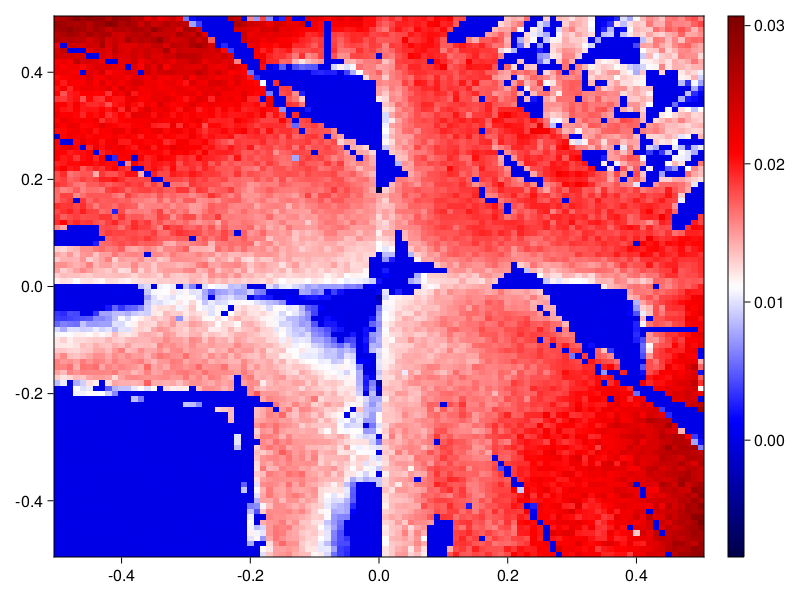

In [38]:
fig, ax, hm = heatmap(k1_array, k2_array, spectrum_matrix[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

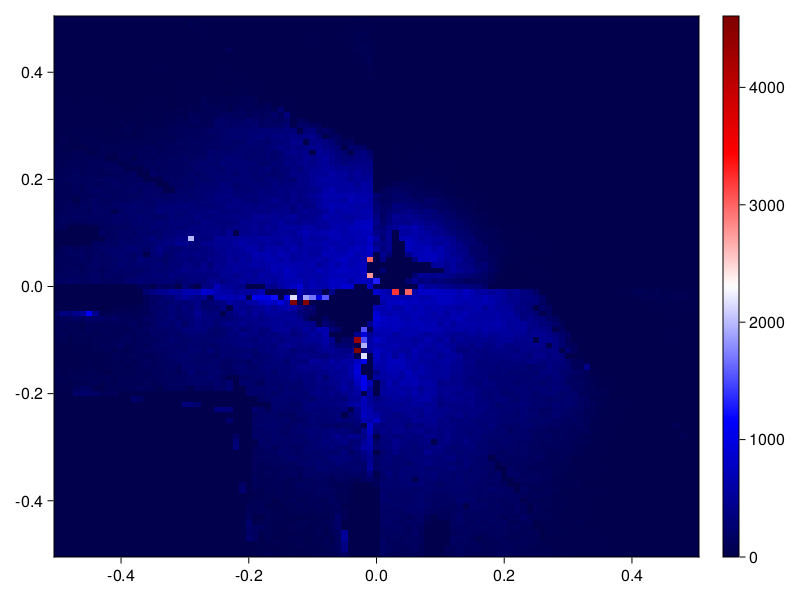

In [39]:
fig, ax, hm = heatmap(k1_array, k2_array, EV_map, colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

In [55]:
using JLD
using NPZ

In [54]:
save("spectrum_matrix_k01.jld", "data", spectrum_matrix)
save("EV_map_k01.jld", "data", EV_map)

In [56]:
npzwrite("spectrum_matrix_k01.npy", spectrum_matrix)
npzwrite("EV_map_k01.npy", EV_map)

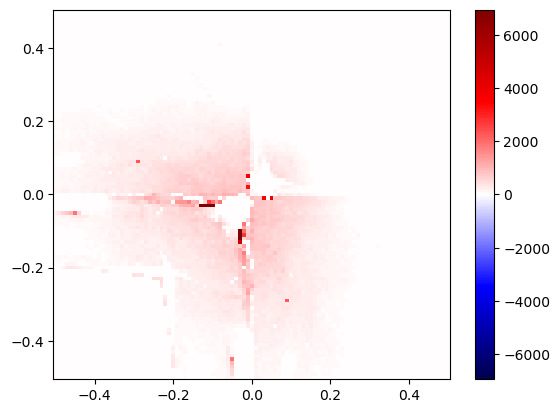

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000497D32B0>

In [30]:
lyapmin,lyapmax =  -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

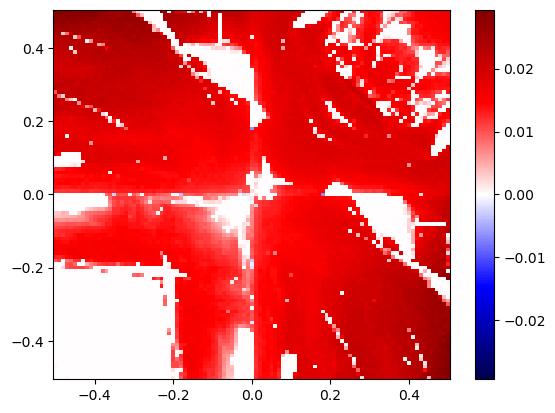

PyObject <matplotlib.colorbar.Colorbar object at 0x000000004988D190>

In [31]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [32]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small_article.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR_article.npy",EV_map)

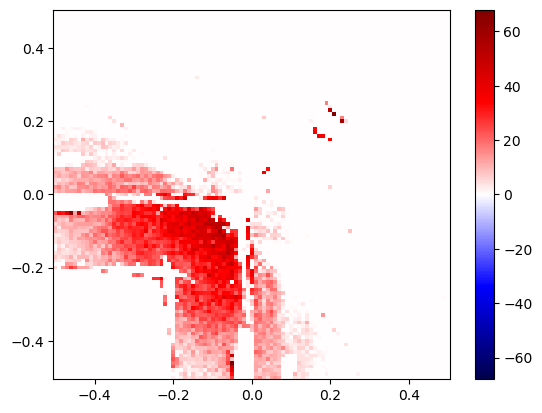

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000009378790>

In [7]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) ) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [10]:
lyap_matrix

101×101 Matrix{Float64}:
  8.19857e-6    6.47474e-5   5.14542e-5   …  0.0276682  0.0272808  0.0291445
  4.06075e-5    3.75252e-5   0.000253653     0.0272182  0.0277339  0.0292966
  3.13037e-5    0.000918656  5.90286e-5      0.0270186  0.0277955  0.029067
  0.000237857   3.48348e-5   2.37488e-5      0.027876   0.027632   0.0287336
  3.654e-5      2.7089e-5    1.00419e-5      0.028559   0.0286812  0.0300362
  9.94368e-6    2.23644e-6   8.28923e-6   …  0.0269209  0.0276201  0.0280668
  2.39406e-5    1.81937e-5   3.74486e-5      0.026856   0.0298292  0.0283967
 -1.85917e-6   -2.39113e-5   1.43275e-5      0.0272673  0.0279262  0.0277269
  1.61646e-5    3.30036e-5   1.4663e-6       0.0264745  0.0275779  0.0280929
 -1.3285e-6     2.29626e-5   6.41577e-6      0.0275636  0.0275413  0.0291799
 -9.06613e-6    9.54144e-6   2.41304e-6   …  0.0270102  0.0268263  0.0291496
  8.70916e-6    1.57952e-5   5.02821e-6      0.025589   0.0269834  0.025414
  3.66871e-5    3.24289e-5   1.65681e-5      0.025743

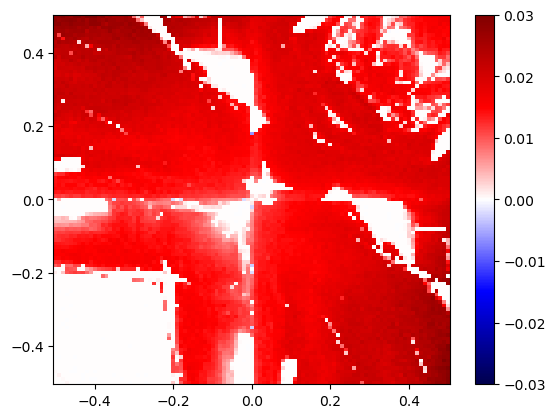

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008D51DC0>

In [11]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

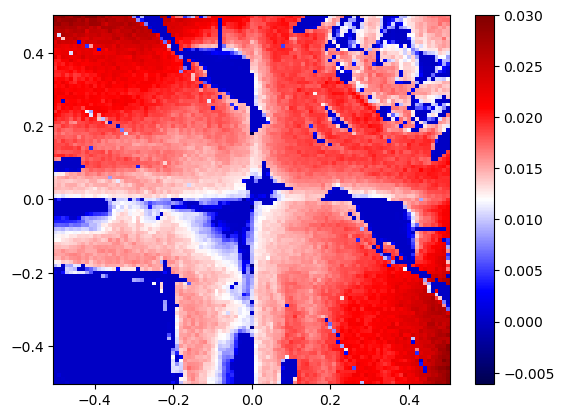

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008E93340>

In [16]:
lyapmin,lyapmax = minimum(lyap_matrix), maximum( lyap_matrix)

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [12]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR.npy",EV_map)